In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import covasim as cv
from util import data

sns.set_context('notebook')
sns.set_style('whitegrid')

pop_region = 4.46e6
pop_size = 450e3
pop_scale = 10

cols = ['n_severe', 'n_critical', 'cum_deaths']
n_runs = 3
n_trials = 2500

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


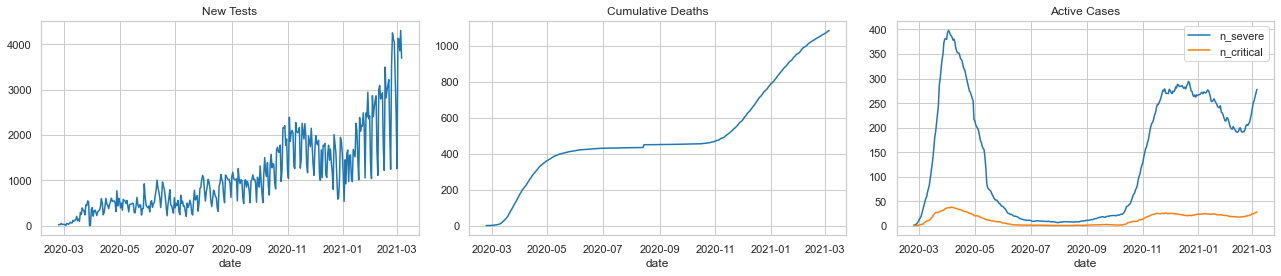

In [2]:
df = data.get_regional_data(scaling_factor=pop_region/pop_size)

_, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)

sns.lineplot(data=df, x='date', y='new_tests', ax=axes[0]).set(title='New Tests', ylabel='')
sns.lineplot(data=df, x='date', y='cum_deaths', ax=axes[1]).set(title='Cumulative Deaths', ylabel='')
sns.lineplot(data=df, x='date', y='n_severe', label='n_severe', ax=axes[2]).set(title='Active Cases')
sns.lineplot(data=df, x='date', y='n_critical', label='n_critical', ax=axes[2]).set(ylabel='')

plt.tight_layout()

In [3]:
default_params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df['date'].iloc[0],
    end_day=df['date'].iloc[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    pop_infected=pop_size / 1e3,
    n_beds_hosp=pop_size * 3.18 / 1e3,
    n_beds_icu=pop_size * 12.5 / 100e3,
    quar_period=14,
    verbose=0
)

In [4]:
def optuna_parameters(trial):
    return dict(
        trace_prob=trial.suggest_uniform('trace_prob', 0., 1.),           # CONTACT TRACING
        trace_time=trial.suggest_uniform('trace_time', 0., 10.),          # 
        work_contacts=trial.suggest_uniform('work_contacts', 0., 1.),     # SMART WORKING
        school_contacts=trial.suggest_uniform('school_contacts', 0., 1.), # SCHOOLS CLOSED
        yellow_contacts=trial.suggest_uniform('yellow_contacts', 0., 1.), # ZONES LOCKDOWN
        orange_contacts=trial.suggest_uniform('orange_contacts', 0., 1.), #
        summer_imports=trial.suggest_uniform('summer_imports', 0., 20.),  # IMPORTED CASES
        yellow_imports=trial.suggest_uniform('yellow_imports', 0., 20.),  #
        orange_imports=trial.suggest_uniform('orange_imports', 0., 20.),  #
        initial_beta=trial.suggest_uniform('initial_beta', 0., 0.1),      # VIRAL LOAD REDUCTION
        summer_beta=trial.suggest_uniform('summer_beta', 0., 0.1),        #
        winter_beta=trial.suggest_uniform('winter_beta', 0., 0.1),        #
        initial_symp=trial.suggest_uniform('initial_symp', 0., 1.),       #
        summer_symp=trial.suggest_uniform('summer_symp', 0., 1.),         #
        winter_symp=trial.suggest_uniform('winter_symp', 0., 1.),         #
        initial_sev=trial.suggest_uniform('initial_sev', 0., 1.),         #
        summer_sev=trial.suggest_uniform('summer_sev', 0., 1.),           #
        winter_sev=trial.suggest_uniform('winter_sev', 0., 1.),           #
        initial_crit=trial.suggest_uniform('initial_crit', 0., 1.),       #
        summer_crit=trial.suggest_uniform('summer_crit', 0., 1.),         #
        winter_crit=trial.suggest_uniform('winter_crit', 0., 1.),         #
        initial_death=trial.suggest_uniform('initial_death', 0., 1.),     #
        summer_death=trial.suggest_uniform('summer_death', 0., 1.),       #
        winter_death=trial.suggest_uniform('winter_death', 0., 1.)        #
    )

In [5]:
import optuna as op
from util.interventions import get_interventions

def objective(trial):
    # define intervention based on learnable parameters
    optuna_pars = optuna_parameters(trial)
    interventions = get_interventions(optuna_pars)
    # define and run simulations
    sim = cv.Sim(pars=default_params, interventions=interventions, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    msim.mean()
    # compute loss
    loss = 0
    for col in cols:
        y_real = df[col].values
        y_simulated = msim.results[col].values
        loss += ((y_real - y_simulated) ** 2).mean()
    return loss


study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-03-07 10:48:16,684] A new study created in memory with name: no-name-e2a72f08-5fe7-40fa-8abe-c6c733b1afe6
[I 2021-03-07 10:48:36,109] Trial 0 finished with value: 264593.73203129426 and parameters: {'trace_prob': 0.5441307979551698, 'trace_time': 7.183460491617676, 'work_contacts': 0.5589215158231238, 'school_contacts': 0.9138399945874218, 'yellow_contacts': 0.060424432345298484, 'orange_contacts': 0.7519742036411163, 'summer_masks': 0.6281443731770607, 'winter_masks': 0.6482051004338375, 'summer_imports': 6.4673989842905, 'yellow_imports': 14.222592390725367, 'orange_imports': 18.17700428202218, 'initial_beta': 0.03954933439134382, 'summer_beta': 0.03500892407246592, 'winter_beta': 0.07691135120575007, 'initial_symp': 0.18153192614101676, 'summer_symp': 0.30214277995541317, 'winter_symp': 0.6323361789749461, 'initial_sev': 0.36715493525741016, 'summer_sev': 0.6179777305923058, 'winter_sev': 0.7885244842166221, 'initial_crit': 0.01956887905995275, 'summer_crit': 0.3975428725251

[I 2021-03-07 10:50:26,119] Trial 7 finished with value: 328172.1401446205 and parameters: {'trace_prob': 0.9154271749656813, 'trace_time': 1.9819734589516325, 'work_contacts': 0.41423604273294223, 'school_contacts': 0.3382684717142861, 'yellow_contacts': 0.3741341057366002, 'orange_contacts': 0.22104581889041242, 'summer_masks': 0.16357006569156163, 'winter_masks': 0.04648652566390432, 'summer_imports': 3.8035183185463017, 'yellow_imports': 1.7944752491970584, 'orange_imports': 6.653709905544842, 'initial_beta': 0.09145728555938554, 'summer_beta': 0.061705618985789516, 'winter_beta': 0.028832536907692975, 'initial_symp': 0.2620116777140187, 'summer_symp': 0.07623101239255159, 'winter_symp': 0.9005045832178183, 'initial_sev': 0.04561519764789501, 'summer_sev': 0.16429644806421773, 'winter_sev': 0.9846486584040672, 'initial_crit': 0.6225988362052544, 'summer_crit': 0.1005807180946321, 'winter_crit': 0.24791073877696457, 'initial_death': 0.685397227835868, 'summer_death': 0.4860996820682

[I 2021-03-07 10:52:18,100] Trial 14 finished with value: 307615.99055137363 and parameters: {'trace_prob': 0.5627587868747111, 'trace_time': 2.5277305540734005, 'work_contacts': 0.9775936974412236, 'school_contacts': 0.18270806839046078, 'yellow_contacts': 0.6406582483511989, 'orange_contacts': 0.8055787842182124, 'summer_masks': 0.6475058616652694, 'winter_masks': 0.8331113869981341, 'summer_imports': 13.873806453820954, 'yellow_imports': 15.867692484524191, 'orange_imports': 16.979183793248303, 'initial_beta': 0.0404054839984751, 'summer_beta': 0.03886717601312989, 'winter_beta': 0.07878209307946127, 'initial_symp': 0.35734430417149254, 'summer_symp': 0.19462368509939731, 'winter_symp': 0.18917450482859088, 'initial_sev': 0.059120172741149724, 'summer_sev': 0.43017378953634855, 'winter_sev': 0.5400091103635923, 'initial_crit': 0.9563647060233732, 'summer_crit': 0.2561596187532518, 'winter_crit': 0.7373931285869569, 'initial_death': 0.508537719420386, 'summer_death': 0.03105678518281

[I 2021-03-07 10:54:13,409] Trial 21 finished with value: 316911.6651805673 and parameters: {'trace_prob': 0.6218791333034729, 'trace_time': 8.53061925380114, 'work_contacts': 0.38027143754394604, 'school_contacts': 0.996484137564605, 'yellow_contacts': 0.9939722916436671, 'orange_contacts': 0.4092242872393429, 'summer_masks': 0.36770405429948416, 'winter_masks': 0.5618834664269501, 'summer_imports': 19.44121215708416, 'yellow_imports': 7.304268236562499, 'orange_imports': 19.738739558955306, 'initial_beta': 0.04547190872838698, 'summer_beta': 0.055693769266431006, 'winter_beta': 0.06417972644865522, 'initial_symp': 0.010252011485514618, 'summer_symp': 0.34626634753077623, 'winter_symp': 0.8029798055805349, 'initial_sev': 0.44413284786539825, 'summer_sev': 0.7429572560702321, 'winter_sev': 0.979627951706319, 'initial_crit': 0.6898646628382452, 'summer_crit': 0.7337148164311448, 'winter_crit': 0.1307793130149256, 'initial_death': 0.8279972910732957, 'summer_death': 0.3500975159494164, '

[I 2021-03-07 10:56:14,534] Trial 28 finished with value: 375751.52441244357 and parameters: {'trace_prob': 0.9141530764774406, 'trace_time': 6.119842697195901, 'work_contacts': 0.8056598517495334, 'school_contacts': 0.44340698899209663, 'yellow_contacts': 0.532777264506847, 'orange_contacts': 0.6335636160450929, 'summer_masks': 0.5739749974307206, 'winter_masks': 0.9968459542596771, 'summer_imports': 5.000001968808931, 'yellow_imports': 16.91474755605176, 'orange_imports': 18.111157620015632, 'initial_beta': 0.05241170999616654, 'summer_beta': 0.03143605405864415, 'winter_beta': 0.059284988350699, 'initial_symp': 0.5360365646915086, 'summer_symp': 0.5772109034875303, 'winter_symp': 0.4616653420979737, 'initial_sev': 0.2834281769709096, 'summer_sev': 0.6866632887154831, 'winter_sev': 0.6374544779669999, 'initial_crit': 0.10037353189743849, 'summer_crit': 0.1438372854974827, 'winter_crit': 0.8889378017216725, 'initial_death': 0.19092203958704773, 'summer_death': 0.18040525895862708, 'wi

[I 2021-03-07 10:58:19,182] Trial 35 finished with value: 179426.4205411349 and parameters: {'trace_prob': 0.36355372536602104, 'trace_time': 8.704313887897968, 'work_contacts': 0.2504107566136826, 'school_contacts': 0.1227366361724081, 'yellow_contacts': 0.5928252935628335, 'orange_contacts': 0.663299843981504, 'summer_masks': 0.46834181676652037, 'winter_masks': 0.3256755829710859, 'summer_imports': 16.55914884445205, 'yellow_imports': 11.947575549360192, 'orange_imports': 12.682063337293357, 'initial_beta': 0.08494269769138338, 'summer_beta': 0.04010366951224803, 'winter_beta': 0.07087744758134158, 'initial_symp': 0.1459954716493415, 'summer_symp': 0.6897642143839811, 'winter_symp': 0.8473438741119177, 'initial_sev': 0.7645795658173741, 'summer_sev': 0.6228914402199471, 'winter_sev': 0.5732750803537352, 'initial_crit': 0.8935656574393832, 'summer_crit': 0.4301190435335505, 'winter_crit': 0.2051970624080231, 'initial_death': 0.9836688936306482, 'summer_death': 0.5460423567136781, 'wi

[I 2021-03-07 11:00:24,160] Trial 42 finished with value: 194660.88314119427 and parameters: {'trace_prob': 0.2814259796355969, 'trace_time': 8.61591096346364, 'work_contacts': 0.16027246565941677, 'school_contacts': 0.14675892170395372, 'yellow_contacts': 0.5820145833683336, 'orange_contacts': 0.7853744415536, 'summer_masks': 0.4166846001138435, 'winter_masks': 0.14133512509926582, 'summer_imports': 12.995029838917494, 'yellow_imports': 11.8893583645952, 'orange_imports': 8.460807470782354, 'initial_beta': 0.08590825509921776, 'summer_beta': 0.043296322045434196, 'winter_beta': 0.032637255947222915, 'initial_symp': 0.212155687114285, 'summer_symp': 0.7574014217575593, 'winter_symp': 0.9905788523144929, 'initial_sev': 0.770574838226546, 'summer_sev': 0.46497033215484107, 'winter_sev': 0.41143322974031565, 'initial_crit': 0.8998774660267445, 'summer_crit': 0.4335914322215229, 'winter_crit': 0.3637909436058172, 'initial_death': 0.9864866948818993, 'summer_death': 0.8181223555384962, 'win

[I 2021-03-07 11:02:22,413] Trial 49 finished with value: 155541.71854234335 and parameters: {'trace_prob': 0.048732026758277494, 'trace_time': 9.508415170679143, 'work_contacts': 0.22599160187688166, 'school_contacts': 0.19835922551046903, 'yellow_contacts': 0.6489931623012467, 'orange_contacts': 0.8409371124817729, 'summer_masks': 0.28061077090404984, 'winter_masks': 0.32205702239738626, 'summer_imports': 17.142711522615127, 'yellow_imports': 15.050659312640162, 'orange_imports': 13.52105125734742, 'initial_beta': 0.06875716814888203, 'summer_beta': 0.04985805529177005, 'winter_beta': 0.02311851515511844, 'initial_symp': 0.4412789684869236, 'summer_symp': 0.9808495226169731, 'winter_symp': 0.7449003360647275, 'initial_sev': 0.950120566789023, 'summer_sev': 0.22353579962618897, 'winter_sev': 0.35578354756222264, 'initial_crit': 0.739821328492937, 'summer_crit': 0.8778818349549695, 'winter_crit': 0.07081372700921804, 'initial_death': 0.791347896722099, 'summer_death': 0.613146888991842

[I 2021-03-07 11:04:26,278] Trial 56 finished with value: 464795.8671705864 and parameters: {'trace_prob': 0.05339888606924978, 'trace_time': 3.446321020302601, 'work_contacts': 0.38986078502887533, 'school_contacts': 0.0409408039928619, 'yellow_contacts': 0.7273551601087297, 'orange_contacts': 0.9755961298579169, 'summer_masks': 0.2339032318950057, 'winter_masks': 0.18193142279973656, 'summer_imports': 18.733114082653366, 'yellow_imports': 18.737844597105273, 'orange_imports': 10.631244927682598, 'initial_beta': 0.06763520668759028, 'summer_beta': 0.07384436077943704, 'winter_beta': 0.0165977646116197, 'initial_symp': 0.43791083133794817, 'summer_symp': 0.81830224513824, 'winter_symp': 0.6138533122680647, 'initial_sev': 0.999768190394304, 'summer_sev': 0.19848346294035218, 'winter_sev': 0.38392499492509585, 'initial_crit': 0.7557266018126111, 'summer_crit': 0.8659875874489609, 'winter_crit': 0.10605775910905427, 'initial_death': 0.7335734229920399, 'summer_death': 0.6465322047925579, 

[I 2021-03-07 11:06:33,788] Trial 63 finished with value: 221603.88560805173 and parameters: {'trace_prob': 0.23282370105077765, 'trace_time': 1.6276452253245932, 'work_contacts': 0.18916413686271744, 'school_contacts': 0.27338628160053446, 'yellow_contacts': 0.6679642015628368, 'orange_contacts': 0.8501615691553408, 'summer_masks': 0.36763288184191184, 'winter_masks': 0.38392817422520104, 'summer_imports': 13.570913866506778, 'yellow_imports': 15.735008924871654, 'orange_imports': 14.703858230679309, 'initial_beta': 0.0989220415965215, 'summer_beta': 0.055131791024420534, 'winter_beta': 0.02574901040019322, 'initial_symp': 0.39861176363018413, 'summer_symp': 0.9986578570485273, 'winter_symp': 0.8028268495611491, 'initial_sev': 0.8727909454790034, 'summer_sev': 0.15887062809523367, 'winter_sev': 0.1803800127045231, 'initial_crit': 0.8303988396545191, 'summer_crit': 0.9997485336446135, 'winter_crit': 0.23150133245374516, 'initial_death': 0.7101677470873641, 'summer_death': 0.86050815747

[I 2021-03-07 11:08:39,482] Trial 70 finished with value: 215229.45556379887 and parameters: {'trace_prob': 0.2548690331510149, 'trace_time': 5.10048550439974, 'work_contacts': 0.2274044865266529, 'school_contacts': 0.34296885839249197, 'yellow_contacts': 0.7753458885345, 'orange_contacts': 0.9070416723196391, 'summer_masks': 0.1462875488942599, 'winter_masks': 0.35467349486103494, 'summer_imports': 16.372552834651742, 'yellow_imports': 15.722299672667496, 'orange_imports': 9.277037419862872, 'initial_beta': 0.055531670037836975, 'summer_beta': 0.06888263713310752, 'winter_beta': 0.02023267420365463, 'initial_symp': 0.2586682478762724, 'summer_symp': 0.997455914760049, 'winter_symp': 0.5853448881083316, 'initial_sev': 0.9190641835531596, 'summer_sev': 0.3278854615152978, 'winter_sev': 0.23105457306895996, 'initial_crit': 0.7471953911547348, 'summer_crit': 0.9699384323750513, 'winter_crit': 0.13853635818942017, 'initial_death': 0.8428317310294993, 'summer_death': 0.6095300754649617, 'wi

[I 2021-03-07 11:10:46,430] Trial 77 finished with value: 272263.2910269487 and parameters: {'trace_prob': 0.0711142599804111, 'trace_time': 4.605377795617184, 'work_contacts': 0.0005245941232813051, 'school_contacts': 0.5362359026297494, 'yellow_contacts': 0.7342658692390364, 'orange_contacts': 0.9346946516318255, 'summer_masks': 0.21298747541277774, 'winter_masks': 0.30608042130302693, 'summer_imports': 19.34458941979041, 'yellow_imports': 19.6093935092773, 'orange_imports': 17.402505888964402, 'initial_beta': 0.05350528401078967, 'summer_beta': 0.06702996896143411, 'winter_beta': 0.013477086102334987, 'initial_symp': 0.5098370890670688, 'summer_symp': 0.9407269830941286, 'winter_symp': 0.6823368381285855, 'initial_sev': 0.8722140370117706, 'summer_sev': 0.2628512943655016, 'winter_sev': 0.5580260351399721, 'initial_crit': 0.8350169171374571, 'summer_crit': 0.8879776531020982, 'winter_crit': 0.011152910487827418, 'initial_death': 0.8166786855648628, 'summer_death': 0.8991404770446966

[I 2021-03-07 11:12:55,773] Trial 84 finished with value: 219309.23462347832 and parameters: {'trace_prob': 0.07244085626037558, 'trace_time': 6.32746072699425, 'work_contacts': 0.18158821485597004, 'school_contacts': 0.3535635338241788, 'yellow_contacts': 0.561078752271202, 'orange_contacts': 0.9217610918356711, 'summer_masks': 0.2556958780876221, 'winter_masks': 0.23078980086326273, 'summer_imports': 19.27077712602773, 'yellow_imports': 18.347995702227678, 'orange_imports': 16.77562059561811, 'initial_beta': 0.06249785973563139, 'summer_beta': 0.07828755907218082, 'winter_beta': 0.025465730778370436, 'initial_symp': 0.4535885470034356, 'summer_symp': 0.7793092275521011, 'winter_symp': 0.7065061080127036, 'initial_sev': 0.8288664458055428, 'summer_sev': 0.2341554202773542, 'winter_sev': 0.45902429325861804, 'initial_crit': 0.9325939186745645, 'summer_crit': 0.851285098988156, 'winter_crit': 0.1597509174380618, 'initial_death': 0.7456776293496166, 'summer_death': 0.7277168155577548, 'w

[I 2021-03-07 11:15:10,073] Trial 91 finished with value: 126510.85278311161 and parameters: {'trace_prob': 0.031708419704801594, 'trace_time': 5.702887335931449, 'work_contacts': 0.34021242597450563, 'school_contacts': 0.5874422552099896, 'yellow_contacts': 0.5157720440974164, 'orange_contacts': 0.9031669974456983, 'summer_masks': 0.19491170707113825, 'winter_masks': 0.2131006232686402, 'summer_imports': 18.298463661858733, 'yellow_imports': 17.019584773548296, 'orange_imports': 18.824159171358232, 'initial_beta': 0.057549647379461, 'summer_beta': 0.0687323850602145, 'winter_beta': 0.0198901592180128, 'initial_symp': 0.290421357807094, 'summer_symp': 0.7124280735437217, 'winter_symp': 0.5685030519136283, 'initial_sev': 0.7888963969188681, 'summer_sev': 0.43332620144584755, 'winter_sev': 0.6443523553674193, 'initial_crit': 0.9910812089398932, 'summer_crit': 0.7697720315317007, 'winter_crit': 0.055129108534495055, 'initial_death': 0.8514952834624051, 'summer_death': 0.895369995746446, '

[I 2021-03-07 11:17:23,579] Trial 98 finished with value: 171968.8963518588 and parameters: {'trace_prob': 0.10889559804002052, 'trace_time': 6.746170653614904, 'work_contacts': 0.4189033885305119, 'school_contacts': 0.515921166956191, 'yellow_contacts': 0.3110844029677113, 'orange_contacts': 0.07462018823549973, 'summer_masks': 0.12478466433760313, 'winter_masks': 0.22799900064594616, 'summer_imports': 19.98404402207877, 'yellow_imports': 18.516775233416027, 'orange_imports': 18.399430747111957, 'initial_beta': 0.04826439845118351, 'summer_beta': 0.05030661402510234, 'winter_beta': 0.022917931129224585, 'initial_symp': 0.5278226123437002, 'summer_symp': 0.8120266407084318, 'winter_symp': 0.49460426992813133, 'initial_sev': 0.6485530483414161, 'summer_sev': 0.48989806540701303, 'winter_sev': 0.5958177191467082, 'initial_crit': 0.9237909798870498, 'summer_crit': 0.8049584635607537, 'winter_crit': 0.1285366007249194, 'initial_death': 0.8278624522363223, 'summer_death': 0.9349307506243604

[I 2021-03-07 11:19:32,725] Trial 105 finished with value: 179999.53716199833 and parameters: {'trace_prob': 0.06193800983778339, 'trace_time': 6.000182242375678, 'work_contacts': 0.4968063712934163, 'school_contacts': 0.5487419217166359, 'yellow_contacts': 0.27516196436844625, 'orange_contacts': 0.16147192501794988, 'summer_masks': 0.20217251086853882, 'winter_masks': 0.13469470034860115, 'summer_imports': 19.539466472459345, 'yellow_imports': 17.130889208291954, 'orange_imports': 17.764360393352824, 'initial_beta': 0.050728973017547946, 'summer_beta': 0.056154714541889285, 'winter_beta': 0.024451682729085607, 'initial_symp': 0.2815300687286569, 'summer_symp': 0.7825836335628434, 'winter_symp': 0.5169038487384622, 'initial_sev': 0.5205477954623938, 'summer_sev': 0.3583143337460617, 'winter_sev': 0.5067079197683642, 'initial_crit': 0.9986145270019037, 'summer_crit': 0.7794182383559584, 'winter_crit': 0.08515193096654736, 'initial_death': 0.9285963170470672, 'summer_death': 0.8405548390

[I 2021-03-07 11:21:53,032] Trial 112 finished with value: 527777.2924180864 and parameters: {'trace_prob': 0.07224863758508017, 'trace_time': 5.839220409606607, 'work_contacts': 0.2671974975010424, 'school_contacts': 0.5235962083564645, 'yellow_contacts': 0.41441729818576906, 'orange_contacts': 0.05821455287488769, 'summer_masks': 0.19501622885482303, 'winter_masks': 0.20821526458568082, 'summer_imports': 18.547182562770622, 'yellow_imports': 18.542633733436613, 'orange_imports': 19.224032140917828, 'initial_beta': 0.04477920690605876, 'summer_beta': 0.07296331760295095, 'winter_beta': 0.02376344422136689, 'initial_symp': 0.43922249516450396, 'summer_symp': 0.812023759879236, 'winter_symp': 0.5466260699327218, 'initial_sev': 0.732208769278642, 'summer_sev': 0.508233779874086, 'winter_sev': 0.5362876805555095, 'initial_crit': 0.8846684422933446, 'summer_crit': 0.8579540723040553, 'winter_crit': 0.14428609014825391, 'initial_death': 0.7856655073190788, 'summer_death': 0.9187412522819097

[I 2021-03-07 11:24:04,357] Trial 119 finished with value: 289695.13846724364 and parameters: {'trace_prob': 0.12927541171169205, 'trace_time': 5.384505746091896, 'work_contacts': 0.555066276270429, 'school_contacts': 0.7065514565183556, 'yellow_contacts': 0.5136051957491719, 'orange_contacts': 0.07191899197359443, 'summer_masks': 0.07759214976269511, 'winter_masks': 0.15031874346612292, 'summer_imports': 16.987214259690287, 'yellow_imports': 5.31366019698784, 'orange_imports': 18.6961941555417, 'initial_beta': 0.041516565872884145, 'summer_beta': 0.05081001837003867, 'winter_beta': 0.020217895454243986, 'initial_symp': 0.49351797352059035, 'summer_symp': 0.766498079628975, 'winter_symp': 0.7212011882951628, 'initial_sev': 0.8279070387998605, 'summer_sev': 0.20762960601860594, 'winter_sev': 0.5244384161006871, 'initial_crit': 0.9990352839075115, 'summer_crit': 0.7668524092648181, 'winter_crit': 0.025372663866831305, 'initial_death': 0.8050656816047403, 'summer_death': 0.901525880944590

[I 2021-03-07 11:26:28,820] Trial 126 finished with value: 252851.73580931 and parameters: {'trace_prob': 0.20032537697047614, 'trace_time': 5.409689769322416, 'work_contacts': 0.3298807562605507, 'school_contacts': 0.4442517513600191, 'yellow_contacts': 0.545219068452192, 'orange_contacts': 0.3587702658453305, 'summer_masks': 0.24083785092621376, 'winter_masks': 0.16414938350115693, 'summer_imports': 19.844078015267723, 'yellow_imports': 4.263306781596544, 'orange_imports': 19.95181401914287, 'initial_beta': 0.06771739746061113, 'summer_beta': 0.06552919370621237, 'winter_beta': 0.022747028545364548, 'initial_symp': 0.42450895323922894, 'summer_symp': 0.8062131820291769, 'winter_symp': 0.7687195996797919, 'initial_sev': 0.6033083688846811, 'summer_sev': 0.46139270884679134, 'winter_sev': 0.6098422840874596, 'initial_crit': 0.29082414800581924, 'summer_crit': 0.9745009809951475, 'winter_crit': 0.16289041721098196, 'initial_death': 0.9179060226194318, 'summer_death': 0.9416744973846478,

[I 2021-03-07 11:28:53,861] Trial 133 finished with value: 112716.08881709723 and parameters: {'trace_prob': 0.1508707693025632, 'trace_time': 6.337832555462618, 'work_contacts': 0.30476029728799287, 'school_contacts': 0.49537156855820064, 'yellow_contacts': 0.5242906339855976, 'orange_contacts': 0.1741543624878109, 'summer_masks': 0.2069539149590544, 'winter_masks': 0.2597348605397358, 'summer_imports': 18.10753365288304, 'yellow_imports': 19.955726265126625, 'orange_imports': 18.543750754547077, 'initial_beta': 0.055969134302934063, 'summer_beta': 0.07014129794731101, 'winter_beta': 0.02733866399059036, 'initial_symp': 0.45720912938463826, 'summer_symp': 0.7060031844348371, 'winter_symp': 0.729602320448272, 'initial_sev': 0.7947917141939831, 'summer_sev': 0.48333751426793986, 'winter_sev': 0.5938315524274886, 'initial_crit': 0.9131533464257618, 'summer_crit': 0.9312371108789249, 'winter_crit': 0.09182105729940863, 'initial_death': 0.9398355309159823, 'summer_death': 0.873286420514015

[I 2021-03-07 11:31:19,138] Trial 140 finished with value: 158156.96648693175 and parameters: {'trace_prob': 0.21600854210550563, 'trace_time': 6.674478535011591, 'work_contacts': 0.3119336828048204, 'school_contacts': 0.46307232941748994, 'yellow_contacts': 0.42722945027104337, 'orange_contacts': 0.20782136309750907, 'summer_masks': 0.0741777556661041, 'winter_masks': 0.33057648923473626, 'summer_imports': 16.313392216581985, 'yellow_imports': 3.5599047442532106, 'orange_imports': 17.299359339362702, 'initial_beta': 0.05873787686824838, 'summer_beta': 0.0882598856389125, 'winter_beta': 0.014329136937982661, 'initial_symp': 0.5406288959933279, 'summer_symp': 0.6627193611016271, 'winter_symp': 0.7370948174956239, 'initial_sev': 0.7864208752956273, 'summer_sev': 0.5813816713095773, 'winter_sev': 0.5959533260304417, 'initial_crit': 0.8530954935506462, 'summer_crit': 0.9847953123282936, 'winter_crit': 0.6644523446371629, 'initial_death': 0.9516732477064213, 'summer_death': 0.75730547115368

[I 2021-03-07 11:33:46,854] Trial 147 finished with value: 180315.86702995072 and parameters: {'trace_prob': 0.11206638380281062, 'trace_time': 7.191647070899954, 'work_contacts': 0.2503627233920631, 'school_contacts': 0.539513577898092, 'yellow_contacts': 0.5814167114438649, 'orange_contacts': 0.10287763030006895, 'summer_masks': 0.1729403581674654, 'winter_masks': 0.2768286533166298, 'summer_imports': 18.732879372374736, 'yellow_imports': 18.59727916492291, 'orange_imports': 17.238547324557906, 'initial_beta': 0.04420003945923298, 'summer_beta': 0.06648384662386346, 'winter_beta': 0.03079941385680533, 'initial_symp': 0.4200505171550543, 'summer_symp': 0.767433109546764, 'winter_symp': 0.7557772174602153, 'initial_sev': 0.8392273733938747, 'summer_sev': 0.5302936502235598, 'winter_sev': 0.6096423535611086, 'initial_crit': 0.8956151644198779, 'summer_crit': 0.8800418916865925, 'winter_crit': 0.06236028193926979, 'initial_death': 0.8961153554964681, 'summer_death': 0.9030525706117895, '

[I 2021-03-07 11:36:17,692] Trial 154 finished with value: 138514.74424632278 and parameters: {'trace_prob': 0.14465128550103573, 'trace_time': 4.591059346203577, 'work_contacts': 0.3195599231980862, 'school_contacts': 0.5142368337584938, 'yellow_contacts': 0.4951610408853361, 'orange_contacts': 0.11133897955362922, 'summer_masks': 0.19425626184199793, 'winter_masks': 0.3637996251685193, 'summer_imports': 17.741209733122112, 'yellow_imports': 4.376043255114821, 'orange_imports': 18.694097034330014, 'initial_beta': 0.058543614554211275, 'summer_beta': 0.06487113883136465, 'winter_beta': 0.019411827838762927, 'initial_symp': 0.4192462393853856, 'summer_symp': 0.7205759482134257, 'winter_symp': 0.6481635630569146, 'initial_sev': 0.8242020933024163, 'summer_sev': 0.3920170655062621, 'winter_sev': 0.6628257996273158, 'initial_crit': 0.9138673976386507, 'summer_crit': 0.9360508949548115, 'winter_crit': 0.6521271325676798, 'initial_death': 0.8759690467348897, 'summer_death': 0.853616032237334

[I 2021-03-07 11:38:48,916] Trial 161 finished with value: 288731.2084451396 and parameters: {'trace_prob': 0.1632132837248409, 'trace_time': 7.7868307782443384, 'work_contacts': 0.21737340738839722, 'school_contacts': 0.508731203563181, 'yellow_contacts': 0.4617211185343968, 'orange_contacts': 0.14708197052973904, 'summer_masks': 0.20885565703289316, 'winter_masks': 0.2653847320345854, 'summer_imports': 17.93401178733307, 'yellow_imports': 7.32022412827858, 'orange_imports': 18.974440850700514, 'initial_beta': 0.042884696416741974, 'summer_beta': 0.06155636526147328, 'winter_beta': 0.01605264560111449, 'initial_symp': 0.3858807949152431, 'summer_symp': 0.7203509998165211, 'winter_symp': 0.7064716816847567, 'initial_sev': 0.7653158682103718, 'summer_sev': 0.44649606776849704, 'winter_sev': 0.6531253766944254, 'initial_crit': 0.8606123679493548, 'summer_crit': 0.864534267313548, 'winter_crit': 0.5249895583629942, 'initial_death': 0.7873524298573917, 'summer_death': 0.8375150832942458, '

[I 2021-03-07 11:41:17,245] Trial 168 finished with value: 741635.6771417989 and parameters: {'trace_prob': 0.21952573714525717, 'trace_time': 5.900365989897864, 'work_contacts': 0.5757901167604456, 'school_contacts': 0.36584607508600514, 'yellow_contacts': 0.5894342712957278, 'orange_contacts': 0.06589569200501144, 'summer_masks': 0.13541133077322343, 'winter_masks': 0.35456274827973283, 'summer_imports': 17.181012272892158, 'yellow_imports': 19.76430314992466, 'orange_imports': 4.455334696601501, 'initial_beta': 0.06709586370257477, 'summer_beta': 0.0523976251682107, 'winter_beta': 0.0139561985439524, 'initial_symp': 0.49466775715042255, 'summer_symp': 0.8612722652203035, 'winter_symp': 0.6657560512350774, 'initial_sev': 0.8624917222239363, 'summer_sev': 0.3643738435722945, 'winter_sev': 0.5103576362729625, 'initial_crit': 0.8559765589302335, 'summer_crit': 0.889696620384572, 'winter_crit': 0.15626706364106716, 'initial_death': 0.767653815102648, 'summer_death': 0.9272762586891878, '

[I 2021-03-07 11:43:46,216] Trial 175 finished with value: 1127457.2502379515 and parameters: {'trace_prob': 0.45112619636123696, 'trace_time': 6.194624997068281, 'work_contacts': 0.542512733244772, 'school_contacts': 0.4366495733667513, 'yellow_contacts': 0.4782599478639905, 'orange_contacts': 0.09360877525384687, 'summer_masks': 0.18749930378380325, 'winter_masks': 0.1617165560634013, 'summer_imports': 8.219444322517722, 'yellow_imports': 19.263419862949867, 'orange_imports': 18.942823739877635, 'initial_beta': 0.05122053276097587, 'summer_beta': 0.06626202939798913, 'winter_beta': 0.03451714262340105, 'initial_symp': 0.8992209561456755, 'summer_symp': 0.798882503463793, 'winter_symp': 0.7326622304588437, 'initial_sev': 0.6913923285060748, 'summer_sev': 0.2465731964055169, 'winter_sev': 0.6788201832384945, 'initial_crit': 0.9543855040556953, 'summer_crit': 0.9324075303655945, 'winter_crit': 0.1065183928072052, 'initial_death': 0.7921562863414726, 'summer_death': 0.9395878827555622, '

[I 2021-03-07 11:46:10,287] Trial 182 finished with value: 115797.1361006611 and parameters: {'trace_prob': 0.5423829071190551, 'trace_time': 7.9341968886802166, 'work_contacts': 0.2779082610317743, 'school_contacts': 0.3853084632436159, 'yellow_contacts': 0.3529116770603379, 'orange_contacts': 0.07845132637144785, 'summer_masks': 0.13998267917917182, 'winter_masks': 0.3117022684230869, 'summer_imports': 18.565394678889277, 'yellow_imports': 5.979670259962557, 'orange_imports': 19.99177156920606, 'initial_beta': 0.061778049067625955, 'summer_beta': 0.07624490433053593, 'winter_beta': 0.0315201969243636, 'initial_symp': 0.37362790424096903, 'summer_symp': 0.7187027730776135, 'winter_symp': 0.7952774730608972, 'initial_sev': 0.8520711799975798, 'summer_sev': 0.30366635813144943, 'winter_sev': 0.46069425804813485, 'initial_crit': 0.9633067281763571, 'summer_crit': 0.8060296278608721, 'winter_crit': 0.5666733554640186, 'initial_death': 0.9801317578854569, 'summer_death': 0.8192076337574207

[I 2021-03-07 11:48:30,899] Trial 189 finished with value: 112310.78473111958 and parameters: {'trace_prob': 0.5303675074718733, 'trace_time': 8.229780028099013, 'work_contacts': 0.286451346796304, 'school_contacts': 0.47408598555320897, 'yellow_contacts': 0.32190285732771673, 'orange_contacts': 0.11118499923530184, 'summer_masks': 0.16783949783994925, 'winter_masks': 0.3679993482603147, 'summer_imports': 17.510326431115637, 'yellow_imports': 7.848078543887152, 'orange_imports': 19.362499592491815, 'initial_beta': 0.06555912577763522, 'summer_beta': 0.06972999756403364, 'winter_beta': 0.03729022220688416, 'initial_symp': 0.3283073875778709, 'summer_symp': 0.6810396018600903, 'winter_symp': 0.857548817146806, 'initial_sev': 0.7739933278474637, 'summer_sev': 0.3459711825651442, 'winter_sev': 0.5526484516043954, 'initial_crit': 0.9491314469580564, 'summer_crit': 0.9806998735779437, 'winter_crit': 0.5400947041777201, 'initial_death': 0.9553703571154435, 'summer_death': 0.8918469454910322, 

[I 2021-03-07 11:50:51,505] Trial 196 finished with value: 146799.9307938415 and parameters: {'trace_prob': 0.5156764793234626, 'trace_time': 8.883490809034006, 'work_contacts': 0.29580691258104996, 'school_contacts': 0.7945911292799335, 'yellow_contacts': 0.32185113601479154, 'orange_contacts': 0.05640858474692646, 'summer_masks': 0.11893377361142754, 'winter_masks': 0.43689986346050186, 'summer_imports': 18.786263111982894, 'yellow_imports': 8.959370684111972, 'orange_imports': 19.065256228105607, 'initial_beta': 0.05998617462385043, 'summer_beta': 0.07144298780988241, 'winter_beta': 0.033734535570703876, 'initial_symp': 0.24342098260057715, 'summer_symp': 0.6606534915047991, 'winter_symp': 0.9475688585379606, 'initial_sev': 0.8143297264707264, 'summer_sev': 0.3718910034921358, 'winter_sev': 0.4982085104901162, 'initial_crit': 0.9231148829325657, 'summer_crit': 0.9752978152395556, 'winter_crit': 0.46166504047052537, 'initial_death': 0.998000896304727, 'summer_death': 0.79605908878404

[I 2021-03-07 11:52:54,628] Trial 203 finished with value: 92535.16312338324 and parameters: {'trace_prob': 0.715155739140743, 'trace_time': 8.117695553920404, 'work_contacts': 0.3316048336266273, 'school_contacts': 0.40909152435424495, 'yellow_contacts': 0.28612299391142554, 'orange_contacts': 0.0030154375234739683, 'summer_masks': 0.20099845674711364, 'winter_masks': 0.41570245194805844, 'summer_imports': 18.92820430228997, 'yellow_imports': 8.156579218935128, 'orange_imports': 18.698488563132695, 'initial_beta': 0.05554403593244704, 'summer_beta': 0.079110988690945, 'winter_beta': 0.03348240879606806, 'initial_symp': 0.34141900683856574, 'summer_symp': 0.6118582389694982, 'winter_symp': 0.9677618375516325, 'initial_sev': 0.7855276814943858, 'summer_sev': 0.29764488525120864, 'winter_sev': 0.5526589491996915, 'initial_crit': 0.9828042009522606, 'summer_crit': 0.9987622584060012, 'winter_crit': 0.5794276584951745, 'initial_death': 0.9980269767127593, 'summer_death': 0.8495214032307314

[I 2021-03-07 11:56:02,894] Trial 210 finished with value: 116712.14603607634 and parameters: {'trace_prob': 0.8215534932188353, 'trace_time': 8.996579531862137, 'work_contacts': 0.3408386705356722, 'school_contacts': 0.3757122955711972, 'yellow_contacts': 0.3436283617848331, 'orange_contacts': 0.026111426151103304, 'summer_masks': 0.1843263928697095, 'winter_masks': 0.5450012980312094, 'summer_imports': 19.099257434110832, 'yellow_imports': 10.39796254794266, 'orange_imports': 17.36628635024763, 'initial_beta': 0.053967989004921925, 'summer_beta': 0.08867433482816423, 'winter_beta': 0.0331495049670746, 'initial_symp': 0.3714293883791074, 'summer_symp': 0.5864785617817209, 'winter_symp': 0.9932363654937594, 'initial_sev': 0.5505498396986709, 'summer_sev': 0.377258452648507, 'winter_sev': 0.4968298668844303, 'initial_crit': 0.8969553174217958, 'summer_crit': 0.6113953568880055, 'winter_crit': 0.5716622297810275, 'initial_death': 0.9702781904801114, 'summer_death': 0.7921191610753917, 'w

[I 2021-03-07 11:59:17,798] Trial 217 finished with value: 114790.41053634313 and parameters: {'trace_prob': 0.7528503529704019, 'trace_time': 8.694746049694503, 'work_contacts': 0.3778976380154821, 'school_contacts': 0.44867984960253593, 'yellow_contacts': 0.3702548934460377, 'orange_contacts': 0.04127502077464365, 'summer_masks': 0.23574982519225884, 'winter_masks': 0.5068193651926414, 'summer_imports': 19.352111708243086, 'yellow_imports': 7.921633439558266, 'orange_imports': 17.956629479208424, 'initial_beta': 0.050505527069242676, 'summer_beta': 0.07922884709394068, 'winter_beta': 0.03528336659335357, 'initial_symp': 0.34091429426490166, 'summer_symp': 0.5720223015594268, 'winter_symp': 0.9787956816672534, 'initial_sev': 0.8359903124570428, 'summer_sev': 0.3651395956035811, 'winter_sev': 0.49222511820375314, 'initial_crit': 0.910428444720308, 'summer_crit': 0.5921020157577708, 'winter_crit': 0.7441866192261253, 'initial_death': 0.9650164418107352, 'summer_death': 0.837026826295936

[I 2021-03-07 12:02:16,737] Trial 224 finished with value: 116248.34141257111 and parameters: {'trace_prob': 0.6826975991094221, 'trace_time': 8.926629718092615, 'work_contacts': 0.4208191419140922, 'school_contacts': 0.7127349774403406, 'yellow_contacts': 0.40080445357263067, 'orange_contacts': 0.04675221781982529, 'summer_masks': 0.2141704705158283, 'winter_masks': 0.5797135343989384, 'summer_imports': 19.879564197031765, 'yellow_imports': 10.069600241528288, 'orange_imports': 17.577491227717804, 'initial_beta': 0.049454442008140406, 'summer_beta': 0.08015837806508844, 'winter_beta': 0.05538242919687443, 'initial_symp': 0.34424297097857115, 'summer_symp': 0.5626360626077034, 'winter_symp': 0.9722926148538708, 'initial_sev': 0.7599877492897198, 'summer_sev': 0.3401706390556581, 'winter_sev': 0.517969171755523, 'initial_crit': 0.9962075268128062, 'summer_crit': 0.5912976259235909, 'winter_crit': 0.6980118813906511, 'initial_death': 0.9754095461341211, 'summer_death': 0.7973439183566091

[I 2021-03-07 12:05:27,093] Trial 231 finished with value: 112434.30885584556 and parameters: {'trace_prob': 0.7373615976771953, 'trace_time': 9.133536521541952, 'work_contacts': 0.4380354820597148, 'school_contacts': 0.7468970753561092, 'yellow_contacts': 0.39751879840174503, 'orange_contacts': 0.03673388022295754, 'summer_masks': 0.24590580987663546, 'winter_masks': 0.6139290036902415, 'summer_imports': 19.985618509933527, 'yellow_imports': 9.27370002915751, 'orange_imports': 17.628550990359827, 'initial_beta': 0.04910575620923303, 'summer_beta': 0.07916533994462176, 'winter_beta': 0.046486037215814194, 'initial_symp': 0.27336665565146345, 'summer_symp': 0.608666645634356, 'winter_symp': 0.9960802180429107, 'initial_sev': 0.8407298273539507, 'summer_sev': 0.2797476646264081, 'winter_sev': 0.4451952833335744, 'initial_crit': 0.982712979151016, 'summer_crit': 0.5708065448365107, 'winter_crit': 0.6860304118075772, 'initial_death': 0.9676872334913627, 'summer_death': 0.8221927096301946, 

[I 2021-03-07 12:08:28,885] Trial 238 finished with value: 224909.00325709383 and parameters: {'trace_prob': 0.6625504900089437, 'trace_time': 8.968583504263071, 'work_contacts': 0.3686753081702268, 'school_contacts': 0.6919725725551042, 'yellow_contacts': 0.376207049858292, 'orange_contacts': 0.03611637493905944, 'summer_masks': 0.2290771617619543, 'winter_masks': 0.593487953223788, 'summer_imports': 19.116088756790944, 'yellow_imports': 8.933562293455857, 'orange_imports': 17.46807835551482, 'initial_beta': 0.055353591910891516, 'summer_beta': 0.08566701157605781, 'winter_beta': 0.049322029681020736, 'initial_symp': 0.36669719178994165, 'summer_symp': 0.5585559204654353, 'winter_symp': 0.9995008719257682, 'initial_sev': 0.1560504809834542, 'summer_sev': 0.2504435033607061, 'winter_sev': 0.4772290719696397, 'initial_crit': 0.9965274481319842, 'summer_crit': 0.5356365540488046, 'winter_crit': 0.7691813618787151, 'initial_death': 0.953788603042093, 'summer_death': 0.8242543578584369, 'w

[I 2021-03-07 12:10:47,919] Trial 245 finished with value: 107837.96815847064 and parameters: {'trace_prob': 0.7128259428499223, 'trace_time': 9.081762785232652, 'work_contacts': 0.41713735353439896, 'school_contacts': 0.7922927667361407, 'yellow_contacts': 0.37534866189385646, 'orange_contacts': 0.04342705979694933, 'summer_masks': 0.21489716158014716, 'winter_masks': 0.5708782424181714, 'summer_imports': 19.55592699563482, 'yellow_imports': 9.433775829433806, 'orange_imports': 17.36674524203149, 'initial_beta': 0.04834782159679937, 'summer_beta': 0.0804312246973639, 'winter_beta': 0.049471979004155515, 'initial_symp': 0.2851181262879572, 'summer_symp': 0.6103066236114103, 'winter_symp': 0.9575797961081796, 'initial_sev': 0.9041851935742838, 'summer_sev': 0.25574221207882764, 'winter_sev': 0.4195372999845939, 'initial_crit': 0.9999170318832596, 'summer_crit': 0.5753148067935778, 'winter_crit': 0.714600497802538, 'initial_death': 0.9587637416225899, 'summer_death': 0.8676685321814734, 

[I 2021-03-07 12:12:36,059] Trial 252 finished with value: 183682.3407123592 and parameters: {'trace_prob': 0.7699246921630799, 'trace_time': 9.084907222018462, 'work_contacts': 0.342059999582992, 'school_contacts': 0.802235947067699, 'yellow_contacts': 0.43408942117761906, 'orange_contacts': 0.016774026350472857, 'summer_masks': 0.18743090869024784, 'winter_masks': 0.5287287001382952, 'summer_imports': 9.340385522048336, 'yellow_imports': 9.19161747343019, 'orange_imports': 18.054887665237334, 'initial_beta': 0.04481055384236311, 'summer_beta': 0.07615489000970299, 'winter_beta': 0.05997442346539129, 'initial_symp': 0.3761707786405911, 'summer_symp': 0.5956522242000537, 'winter_symp': 0.9765997403751234, 'initial_sev': 0.866379122149442, 'summer_sev': 0.22749484321220215, 'winter_sev': 0.49362045702982016, 'initial_crit': 0.4067387604473237, 'summer_crit': 0.6917169081741493, 'winter_crit': 0.6454989842418265, 'initial_death': 0.998940605711226, 'summer_death': 0.8419532458195886, 'wi

[I 2021-03-07 12:14:53,094] Trial 259 finished with value: 105753.71608975081 and parameters: {'trace_prob': 0.7571518028426693, 'trace_time': 9.21577073761745, 'work_contacts': 0.3753264031543596, 'school_contacts': 0.7761002439973048, 'yellow_contacts': 0.4183763672191975, 'orange_contacts': 0.00230653132586163, 'summer_masks': 0.21378910762604694, 'winter_masks': 0.6050283516847038, 'summer_imports': 9.04585598194065, 'yellow_imports': 11.102773653137378, 'orange_imports': 17.484565329848568, 'initial_beta': 0.046422045721015284, 'summer_beta': 0.09292281057705, 'winter_beta': 0.05860340833783717, 'initial_symp': 0.2954694206988416, 'summer_symp': 0.5948729077644974, 'winter_symp': 0.9045974798655552, 'initial_sev': 0.883645251035113, 'summer_sev': 0.22119536500260584, 'winter_sev': 0.37821019191779487, 'initial_crit': 0.91439064819457, 'summer_crit': 0.671724178528684, 'winter_crit': 0.6850135607573301, 'initial_death': 0.9387837038792529, 'summer_death': 0.8691026269825888, 'winte

[I 2021-03-07 12:16:41,262] Trial 266 finished with value: 117406.12693248365 and parameters: {'trace_prob': 0.8297891245870086, 'trace_time': 9.720278401282798, 'work_contacts': 0.3276560983315173, 'school_contacts': 0.7158331229467592, 'yellow_contacts': 0.37178209741577595, 'orange_contacts': 0.03081092185509682, 'summer_masks': 0.19230767333142867, 'winter_masks': 0.5707471853610848, 'summer_imports': 8.94499617363388, 'yellow_imports': 9.467572643269005, 'orange_imports': 17.30610325242941, 'initial_beta': 0.04495127701938045, 'summer_beta': 0.07681824568457365, 'winter_beta': 0.05047108352300656, 'initial_symp': 0.34436057568221734, 'summer_symp': 0.5738740322882336, 'winter_symp': 0.953395067670808, 'initial_sev': 0.8418850947596399, 'summer_sev': 0.24516995485706677, 'winter_sev': 0.3675308173729348, 'initial_crit': 0.9762153353598252, 'summer_crit': 0.5830500835116179, 'winter_crit': 0.6687359798198731, 'initial_death': 0.9596831488201057, 'summer_death': 0.897667962475995, 'w

[I 2021-03-07 12:19:06,959] Trial 273 finished with value: 143068.82555689698 and parameters: {'trace_prob': 0.7524932293420331, 'trace_time': 8.636444277480576, 'work_contacts': 0.40719563452782076, 'school_contacts': 0.6936437771891468, 'yellow_contacts': 0.3992756795972271, 'orange_contacts': 4.2692356962518996e-05, 'summer_masks': 0.18655640840307555, 'winter_masks': 0.6002477544223085, 'summer_imports': 19.444079193417686, 'yellow_imports': 8.775183705583805, 'orange_imports': 18.196039743311896, 'initial_beta': 0.05432596659093147, 'summer_beta': 0.08716961349418999, 'winter_beta': 0.06291398746148569, 'initial_symp': 0.25547655325751084, 'summer_symp': 0.5659462886883609, 'winter_symp': 0.8940903060063066, 'initial_sev': 0.8502128767088204, 'summer_sev': 0.3538354675924241, 'winter_sev': 0.4338883396409188, 'initial_crit': 0.9440032779102735, 'summer_crit': 0.6730657235814076, 'winter_crit': 0.6227667522982834, 'initial_death': 0.9400115965212223, 'summer_death': 0.3291060766633

[I 2021-03-07 12:20:37,893] Trial 280 finished with value: 134082.5334341426 and parameters: {'trace_prob': 0.7276293192608688, 'trace_time': 9.249245097224769, 'work_contacts': 0.3680040638553795, 'school_contacts': 0.7716715961103147, 'yellow_contacts': 0.3359706438968786, 'orange_contacts': 0.41046821543901413, 'summer_masks': 0.2157672560417278, 'winter_masks': 0.5031972542045543, 'summer_imports': 19.173272493184957, 'yellow_imports': 9.123637548718968, 'orange_imports': 17.571643427221893, 'initial_beta': 0.04362105216212766, 'summer_beta': 0.07787900560100394, 'winter_beta': 0.05306020504073268, 'initial_symp': 0.3312128442839196, 'summer_symp': 0.6417012099962554, 'winter_symp': 0.7603740488576615, 'initial_sev': 0.8235649882700452, 'summer_sev': 0.28993283207188714, 'winter_sev': 0.394476014611181, 'initial_crit': 0.8995229900125075, 'summer_crit': 0.5816926512119934, 'winter_crit': 0.7662423149395662, 'initial_death': 0.9226015334150649, 'summer_death': 0.818019035883585, 'wi

[I 2021-03-07 12:22:24,005] Trial 287 finished with value: 263716.3159473957 and parameters: {'trace_prob': 0.7640507901070771, 'trace_time': 9.211523049522892, 'work_contacts': 0.32037977964131836, 'school_contacts': 0.7382939715491077, 'yellow_contacts': 0.3310775680733296, 'orange_contacts': 0.06662417550891667, 'summer_masks': 0.6693985122342903, 'winter_masks': 0.8372598343035929, 'summer_imports': 19.63695293656666, 'yellow_imports': 10.884547671819696, 'orange_imports': 16.962640199088057, 'initial_beta': 0.05822684206790552, 'summer_beta': 0.07431396440959907, 'winter_beta': 0.06120404116112214, 'initial_symp': 0.4239728893745832, 'summer_symp': 0.6234401956717378, 'winter_symp': 0.9829985319396269, 'initial_sev': 0.7389027713467886, 'summer_sev': 0.26456440896337935, 'winter_sev': 0.4829085806313395, 'initial_crit': 0.964574080499139, 'summer_crit': 0.7678972503520218, 'winter_crit': 0.6001299348316992, 'initial_death': 0.962323258600522, 'summer_death': 0.91068537660019, 'win

[I 2021-03-07 12:23:58,354] Trial 294 finished with value: 148852.04378584918 and parameters: {'trace_prob': 0.7820224756783819, 'trace_time': 8.42111213522798, 'work_contacts': 0.43020020260335, 'school_contacts': 0.8889791585748512, 'yellow_contacts': 0.3640959077831275, 'orange_contacts': 0.06740485775853534, 'summer_masks': 0.29663058218095584, 'winter_masks': 0.7208684751832041, 'summer_imports': 8.371501617787274, 'yellow_imports': 19.636787191696293, 'orange_imports': 16.53841107863213, 'initial_beta': 0.05450029085843672, 'summer_beta': 0.0032866989266296803, 'winter_beta': 0.0660609448433252, 'initial_symp': 0.33285748063922466, 'summer_symp': 0.4751752433890926, 'winter_symp': 0.9992738119412194, 'initial_sev': 0.5434121055784273, 'summer_sev': 0.3405480883452365, 'winter_sev': 0.9816785498994742, 'initial_crit': 0.9582912635964722, 'summer_crit': 0.6857927823831398, 'winter_crit': 0.9083602207208209, 'initial_death': 0.9373691687459574, 'summer_death': 0.7625694269737807, 'w

[I 2021-03-07 12:25:45,146] Trial 301 finished with value: 122389.79952000879 and parameters: {'trace_prob': 0.9253139212311945, 'trace_time': 9.054455020374709, 'work_contacts': 0.33735605845415184, 'school_contacts': 0.8616847026210425, 'yellow_contacts': 0.38737532102073063, 'orange_contacts': 0.05357424653900218, 'summer_masks': 0.3239611290390897, 'winter_masks': 0.7609379849006017, 'summer_imports': 7.161557228812761, 'yellow_imports': 19.567564817863783, 'orange_imports': 15.903313339109719, 'initial_beta': 0.0573554408199547, 'summer_beta': 0.08686891354921636, 'winter_beta': 0.0671996186641557, 'initial_symp': 0.36817076626586215, 'summer_symp': 0.556612496228599, 'winter_symp': 0.7440733007888853, 'initial_sev': 0.4453893664002951, 'summer_sev': 0.30566926502214803, 'winter_sev': 0.9366975909967078, 'initial_crit': 0.9428832071154615, 'summer_crit': 0.7692189351375716, 'winter_crit': 0.6096891938448977, 'initial_death': 0.9623707688244822, 'summer_death': 0.7896311155800881, 

[I 2021-03-07 12:27:44,565] Trial 308 finished with value: 94454.62809707937 and parameters: {'trace_prob': 0.8595129591555918, 'trace_time': 8.426663398538572, 'work_contacts': 0.47395715918796855, 'school_contacts': 0.8193056710113509, 'yellow_contacts': 0.2157145287607228, 'orange_contacts': 0.13886902596556186, 'summer_masks': 0.30320816053083965, 'winter_masks': 0.7021210255999489, 'summer_imports': 8.71296260685363, 'yellow_imports': 18.85948262301482, 'orange_imports': 18.848750197118296, 'initial_beta': 0.05820940238375682, 'summer_beta': 0.08782506131836107, 'winter_beta': 0.060850534821421304, 'initial_symp': 0.4427114178261054, 'summer_symp': 0.6561627562390547, 'winter_symp': 0.46430523683125297, 'initial_sev': 0.4134561441994415, 'summer_sev': 0.4141941929818305, 'winter_sev': 0.9057305026697221, 'initial_crit': 0.9304511295115153, 'summer_crit': 0.7152732069041111, 'winter_crit': 0.8407233558153677, 'initial_death': 0.9625434015626827, 'summer_death': 0.7134124717244779, 

[I 2021-03-07 12:29:24,245] Trial 315 finished with value: 84335.2558878301 and parameters: {'trace_prob': 0.9347441612211114, 'trace_time': 8.038096752000666, 'work_contacts': 0.4683388626016101, 'school_contacts': 0.8499529817487229, 'yellow_contacts': 0.18227430890044427, 'orange_contacts': 0.133474536112482, 'summer_masks': 0.3973201973976648, 'winter_masks': 0.7790055111517245, 'summer_imports': 7.780657865334625, 'yellow_imports': 18.778557436956394, 'orange_imports': 19.008478467284796, 'initial_beta': 0.05970449920188489, 'summer_beta': 0.09169998766079966, 'winter_beta': 0.06140419021102097, 'initial_symp': 0.4409797820971002, 'summer_symp': 0.6676851041906309, 'winter_symp': 0.43906247619751754, 'initial_sev': 0.41932017315099035, 'summer_sev': 0.4304118164884704, 'winter_sev': 0.9225083951851686, 'initial_crit': 0.958454710498773, 'summer_crit': 0.715527262417184, 'winter_crit': 0.6539191350927951, 'initial_death': 0.8978797683078961, 'summer_death': 0.7101526888252396, 'win

[I 2021-03-07 12:31:08,660] Trial 322 finished with value: 89229.32144809711 and parameters: {'trace_prob': 0.8754003126915975, 'trace_time': 7.955070555002851, 'work_contacts': 0.46423449234157776, 'school_contacts': 0.8433652182131937, 'yellow_contacts': 0.10046255819419578, 'orange_contacts': 0.13185375409254263, 'summer_masks': 0.42345742321015956, 'winter_masks': 0.8184827299814141, 'summer_imports': 6.590777968246673, 'yellow_imports': 18.721197194265848, 'orange_imports': 19.378258875880828, 'initial_beta': 0.06139335613054437, 'summer_beta': 0.09652682108168154, 'winter_beta': 0.06524921017449742, 'initial_symp': 0.438383270280187, 'summer_symp': 0.6637600688311001, 'winter_symp': 0.3637795109188596, 'initial_sev': 0.3921088802634841, 'summer_sev': 0.4326349977182186, 'winter_sev': 0.957673908864716, 'initial_crit': 0.9521252737376993, 'summer_crit': 0.7325188746020912, 'winter_crit': 0.8405479037830151, 'initial_death': 0.8873053317904113, 'summer_death': 0.6859666936769513, '

[I 2021-03-07 12:32:35,154] Trial 329 finished with value: 78103.75465814433 and parameters: {'trace_prob': 0.9017261087693275, 'trace_time': 7.897872863835482, 'work_contacts': 0.49769084024397703, 'school_contacts': 0.8198103583761769, 'yellow_contacts': 0.03721734910001674, 'orange_contacts': 0.11444272623298025, 'summer_masks': 0.4055339164338043, 'winter_masks': 0.8595503000216481, 'summer_imports': 6.330919192518058, 'yellow_imports': 18.265240649608966, 'orange_imports': 19.58508896000566, 'initial_beta': 0.06053755701965022, 'summer_beta': 0.09744031378200942, 'winter_beta': 0.07102647562859878, 'initial_symp': 0.43726184982238686, 'summer_symp': 0.6486315297608952, 'winter_symp': 0.38041349662025453, 'initial_sev': 0.3380476912353621, 'summer_sev': 0.44019060813525074, 'winter_sev': 0.9949793864645127, 'initial_crit': 0.9408449013804523, 'summer_crit': 0.7359241721701977, 'winter_crit': 0.8759613771138628, 'initial_death': 0.8883211689945301, 'summer_death': 0.7012939531925685

[I 2021-03-07 12:34:04,310] Trial 336 finished with value: 120126.39211666098 and parameters: {'trace_prob': 0.8401289125235952, 'trace_time': 7.6324875310673015, 'work_contacts': 0.519553436767311, 'school_contacts': 0.8741086565813028, 'yellow_contacts': 0.08717175989156899, 'orange_contacts': 0.10610580056547791, 'summer_masks': 0.40715457362516494, 'winter_masks': 0.9177919351493523, 'summer_imports': 5.490407719439496, 'yellow_imports': 17.741900592148273, 'orange_imports': 19.569397414090815, 'initial_beta': 0.06147972913269048, 'summer_beta': 0.098635034165495, 'winter_beta': 0.07802509024664869, 'initial_symp': 0.4900111170792498, 'summer_symp': 0.6863358743136263, 'winter_symp': 0.3433206572788426, 'initial_sev': 0.3206796232090393, 'summer_sev': 0.4593656097724524, 'winter_sev': 0.9994499492312896, 'initial_crit': 0.939733813711195, 'summer_crit': 0.33067989496936084, 'winter_crit': 0.9235563290811386, 'initial_death': 0.8576149461270286, 'summer_death': 0.6539513488901709, '

[I 2021-03-07 12:35:34,361] Trial 343 finished with value: 101382.59437780885 and parameters: {'trace_prob': 0.89192607915291, 'trace_time': 7.272846496189838, 'work_contacts': 0.5022297382279819, 'school_contacts': 0.9779409089217888, 'yellow_contacts': 0.06150830265460144, 'orange_contacts': 0.16152412404623315, 'summer_masks': 0.47948231909238304, 'winter_masks': 0.8399875923534983, 'summer_imports': 6.840170582712046, 'yellow_imports': 18.33318414683755, 'orange_imports': 19.203442065989446, 'initial_beta': 0.05866249915960831, 'summer_beta': 0.09746812911264706, 'winter_beta': 0.0699905012083376, 'initial_symp': 0.4515801101950449, 'summer_symp': 0.6713295518609019, 'winter_symp': 0.4034112712672903, 'initial_sev': 0.39314378596930666, 'summer_sev': 0.40029859964962217, 'winter_sev': 0.9975956249611019, 'initial_crit': 0.978687312782757, 'summer_crit': 0.19733667284304113, 'winter_crit': 0.8178703635703252, 'initial_death': 0.8932717715432773, 'summer_death': 0.7006918950505674, '

[I 2021-03-07 12:37:08,502] Trial 350 finished with value: 148704.7850484698 and parameters: {'trace_prob': 0.9319247552387286, 'trace_time': 7.808155603010709, 'work_contacts': 0.48096713539223124, 'school_contacts': 0.9585256951661631, 'yellow_contacts': 0.04921568822898032, 'orange_contacts': 0.17000515810526892, 'summer_masks': 0.48934943100409234, 'winter_masks': 0.788684168388405, 'summer_imports': 6.723567467914572, 'yellow_imports': 19.203034798495715, 'orange_imports': 19.29075306406881, 'initial_beta': 0.05962559442449018, 'summer_beta': 0.09744572112483695, 'winter_beta': 0.07090360680563962, 'initial_symp': 0.46966263773568534, 'summer_symp': 0.6817236750611373, 'winter_symp': 0.4082847070464223, 'initial_sev': 0.3330438209819804, 'summer_sev': 0.40756766976718894, 'winter_sev': 0.9250763892026858, 'initial_crit': 0.9189204787567877, 'summer_crit': 0.11902718429452208, 'winter_crit': 0.8871756230591562, 'initial_death': 0.9037951863432112, 'summer_death': 0.6989932013097016

[I 2021-03-07 12:38:46,090] Trial 357 finished with value: 118780.3872414847 and parameters: {'trace_prob': 0.8611050255690254, 'trace_time': 7.838495465595987, 'work_contacts': 0.4777769589437688, 'school_contacts': 0.9074558715598711, 'yellow_contacts': 0.23610585330508693, 'orange_contacts': 0.1186116275173568, 'summer_masks': 0.42820559922513496, 'winter_masks': 0.8414232480203717, 'summer_imports': 3.884590202744926, 'yellow_imports': 18.944631687099285, 'orange_imports': 19.67868154361589, 'initial_beta': 0.05800380006216117, 'summer_beta': 0.0999114406097744, 'winter_beta': 0.06535230752019648, 'initial_symp': 0.4829284116648827, 'summer_symp': 0.7064608204842256, 'winter_symp': 0.3490310249698114, 'initial_sev': 0.3015614351321167, 'summer_sev': 0.45863201277799603, 'winter_sev': 0.8314011240877115, 'initial_crit': 0.6379497199815515, 'summer_crit': 0.759155581836487, 'winter_crit': 0.9085411633569662, 'initial_death': 0.8387070672726235, 'summer_death': 0.7205197508571558, 'wi

[I 2021-03-07 12:40:23,500] Trial 364 finished with value: 117265.33360161044 and parameters: {'trace_prob': 0.9000023892839851, 'trace_time': 8.008691164411383, 'work_contacts': 0.45007101799374494, 'school_contacts': 0.8711964776476928, 'yellow_contacts': 0.03431632944061491, 'orange_contacts': 0.16583945996332297, 'summer_masks': 0.3960806318335935, 'winter_masks': 0.7527568792745294, 'summer_imports': 5.163824752505169, 'yellow_imports': 19.422837186917988, 'orange_imports': 19.27432029753718, 'initial_beta': 0.06660249166958218, 'summer_beta': 0.09508749727329549, 'winter_beta': 0.06580936812964815, 'initial_symp': 0.4678932045866617, 'summer_symp': 0.026151359011762687, 'winter_symp': 0.3950386112446898, 'initial_sev': 0.30159754118093995, 'summer_sev': 0.45006963709547587, 'winter_sev': 0.9659718527365927, 'initial_crit': 0.7053721645951626, 'summer_crit': 0.7372231511903907, 'winter_crit': 0.8809477807800102, 'initial_death': 0.8409884302575377, 'summer_death': 0.72197541645035

[I 2021-03-07 12:41:56,085] Trial 371 finished with value: 115226.93200128956 and parameters: {'trace_prob': 0.8649454936776384, 'trace_time': 7.08249400185002, 'work_contacts': 0.44802098108911115, 'school_contacts': 0.7916693941420994, 'yellow_contacts': 0.0013513176239321294, 'orange_contacts': 0.1495722012628371, 'summer_masks': 0.38694527709237153, 'winter_masks': 0.7891798443312725, 'summer_imports': 7.201699456568323, 'yellow_imports': 18.160012972999244, 'orange_imports': 19.62730408817375, 'initial_beta': 0.0625867138140324, 'summer_beta': 0.09698129208729768, 'winter_beta': 0.0689325679006316, 'initial_symp': 0.4177323529772495, 'summer_symp': 0.674613526787708, 'winter_symp': 0.36558406638403795, 'initial_sev': 0.21382000508611138, 'summer_sev': 0.4036419672661889, 'winter_sev': 0.8692926236148426, 'initial_crit': 0.7551913163320563, 'summer_crit': 0.7627876595621801, 'winter_crit': 0.9727675909710116, 'initial_death': 0.9074328584140374, 'summer_death': 0.675277795302372, '

[I 2021-03-07 12:43:35,834] Trial 378 finished with value: 119900.77596817637 and parameters: {'trace_prob': 0.9328877276416436, 'trace_time': 7.98296633374071, 'work_contacts': 0.5057509658187707, 'school_contacts': 0.8611797865106007, 'yellow_contacts': 0.10841413067782585, 'orange_contacts': 0.13296105525818322, 'summer_masks': 0.5498546647848203, 'winter_masks': 0.8404119780768259, 'summer_imports': 5.828454839428941, 'yellow_imports': 19.4954039307361, 'orange_imports': 19.578418199590978, 'initial_beta': 0.06769931357550539, 'summer_beta': 0.09391541541864691, 'winter_beta': 0.06832732822379488, 'initial_symp': 0.4809805216824543, 'summer_symp': 0.6651836041839776, 'winter_symp': 0.3797203698434216, 'initial_sev': 0.3630387561109128, 'summer_sev': 0.4403340759605033, 'winter_sev': 0.952468566151355, 'initial_crit': 0.6749860212310775, 'summer_crit': 0.6986862691110594, 'winter_crit': 0.8401546912527132, 'initial_death': 0.8749026430740251, 'summer_death': 0.7055427570330374, 'win

[I 2021-03-07 12:45:09,812] Trial 385 finished with value: 83836.75219775463 and parameters: {'trace_prob': 0.9981507372007726, 'trace_time': 7.767378121101908, 'work_contacts': 0.46667318523914725, 'school_contacts': 0.8525508383390441, 'yellow_contacts': 0.0880001406587579, 'orange_contacts': 0.08770882854323653, 'summer_masks': 0.3984408685031905, 'winter_masks': 0.8507690151154801, 'summer_imports': 6.746834969709428, 'yellow_imports': 18.032043129908825, 'orange_imports': 19.33827529312556, 'initial_beta': 0.0658993461562983, 'summer_beta': 0.09630772592645422, 'winter_beta': 0.06513135007071151, 'initial_symp': 0.4077645982950903, 'summer_symp': 0.642909037631309, 'winter_symp': 0.3815768827277297, 'initial_sev': 0.4072536544655977, 'summer_sev': 0.45979785819106295, 'winter_sev': 0.8389612085389095, 'initial_crit': 0.9431184126615888, 'summer_crit': 0.7433014235960637, 'winter_crit': 0.8881012119552832, 'initial_death': 0.9000959056259713, 'summer_death': 0.75491445996973, 'wint

[I 2021-03-07 12:46:43,031] Trial 392 finished with value: 86489.35078180688 and parameters: {'trace_prob': 0.9222007203445648, 'trace_time': 7.760975162109571, 'work_contacts': 0.4933910213321567, 'school_contacts': 0.7880862624345845, 'yellow_contacts': 0.22266122578856273, 'orange_contacts': 0.17263120196471526, 'summer_masks': 0.35557818108164363, 'winter_masks': 0.9529038426498297, 'summer_imports': 5.702707111467532, 'yellow_imports': 19.036816867274773, 'orange_imports': 18.874463668233908, 'initial_beta': 0.06194137106347926, 'summer_beta': 0.09795673878812693, 'winter_beta': 0.06786366432073421, 'initial_symp': 0.4431008918196448, 'summer_symp': 0.7196614959650094, 'winter_symp': 0.40398451838243815, 'initial_sev': 0.32351303314947566, 'summer_sev': 0.42877827363763404, 'winter_sev': 0.9771010662012193, 'initial_crit': 0.9977841862705084, 'summer_crit': 0.780767607145064, 'winter_crit': 0.8743998464137551, 'initial_death': 0.8506059244720343, 'summer_death': 0.6622792721624634

[I 2021-03-07 12:48:20,462] Trial 399 finished with value: 91835.34252445404 and parameters: {'trace_prob': 0.9497314160245656, 'trace_time': 8.365396146341723, 'work_contacts': 0.45947330466324915, 'school_contacts': 0.8486414816928463, 'yellow_contacts': 0.1715909963610487, 'orange_contacts': 0.2200418854992238, 'summer_masks': 0.3374820720692978, 'winter_masks': 0.9701980449432732, 'summer_imports': 2.119528249651456, 'yellow_imports': 19.867409265651045, 'orange_imports': 18.857447387365756, 'initial_beta': 0.05660239926233377, 'summer_beta': 0.09987950298666155, 'winter_beta': 0.061179539281419504, 'initial_symp': 0.40692833384276855, 'summer_symp': 0.15339965694227967, 'winter_symp': 0.44865930206409377, 'initial_sev': 0.5282138846594269, 'summer_sev': 0.3984253084733278, 'winter_sev': 0.806879102981418, 'initial_crit': 0.997476248043702, 'summer_crit': 0.8046281296166157, 'winter_crit': 0.8606886532232724, 'initial_death': 0.9048038141078846, 'summer_death': 0.5612431605991415, 

[I 2021-03-07 12:49:57,173] Trial 406 finished with value: 76266.77070370296 and parameters: {'trace_prob': 0.9341086314503251, 'trace_time': 8.372074975248548, 'work_contacts': 0.44993296943187294, 'school_contacts': 0.9068681485110882, 'yellow_contacts': 0.15552136152936627, 'orange_contacts': 0.19969695956730818, 'summer_masks': 0.34621488097890324, 'winter_masks': 0.9910420857534026, 'summer_imports': 2.93216102796262, 'yellow_imports': 19.97072023534475, 'orange_imports': 19.157699846394294, 'initial_beta': 0.05609055453345329, 'summer_beta': 0.09185115052991079, 'winter_beta': 0.062358249746083276, 'initial_symp': 0.42331199126325336, 'summer_symp': 0.36996841936541, 'winter_symp': 0.443714203881404, 'initial_sev': 0.489643011650285, 'summer_sev': 0.38394882093882066, 'winter_sev': 0.9382696365109052, 'initial_crit': 0.9995803845776305, 'summer_crit': 0.8142403784645088, 'winter_crit': 0.8013404029094646, 'initial_death': 0.9252212215888856, 'summer_death': 0.5722535606260403, 'w

[I 2021-03-07 12:51:35,281] Trial 413 finished with value: 106133.28409967531 and parameters: {'trace_prob': 0.9219221324972726, 'trace_time': 8.09158945966201, 'work_contacts': 0.4922052468465814, 'school_contacts': 0.8708460337967188, 'yellow_contacts': 0.1328821732632881, 'orange_contacts': 0.20302619545038475, 'summer_masks': 0.38239248436845025, 'winter_masks': 0.9384127093735535, 'summer_imports': 2.6716857658197575, 'yellow_imports': 19.954369395001113, 'orange_imports': 19.999216041932968, 'initial_beta': 0.059194679308079805, 'summer_beta': 0.09353949592352492, 'winter_beta': 0.06435117968800887, 'initial_symp': 0.43492756632772867, 'summer_symp': 0.37499055985566154, 'winter_symp': 0.4290759001089426, 'initial_sev': 0.4281451519926003, 'summer_sev': 0.41560618684351736, 'winter_sev': 0.8949066626554552, 'initial_crit': 0.9763313065463934, 'summer_crit': 0.8540733990751751, 'winter_crit': 0.8928339377460582, 'initial_death': 0.8943446931503325, 'summer_death': 0.51119186203400

[I 2021-03-07 12:53:11,290] Trial 420 finished with value: 81352.20662303166 and parameters: {'trace_prob': 0.9098559833706013, 'trace_time': 8.232992668193898, 'work_contacts': 0.519947607638344, 'school_contacts': 0.8801793006148887, 'yellow_contacts': 0.1189429094312594, 'orange_contacts': 0.2368660796949813, 'summer_masks': 0.37820616117837397, 'winter_masks': 0.930002431430824, 'summer_imports': 2.007450123164751, 'yellow_imports': 19.906570201274995, 'orange_imports': 19.604326425138403, 'initial_beta': 0.058508880137815356, 'summer_beta': 0.09196036690381419, 'winter_beta': 0.058867425019027926, 'initial_symp': 0.4146073222594706, 'summer_symp': 0.3842234792309769, 'winter_symp': 0.44598062040126196, 'initial_sev': 0.4172356947223449, 'summer_sev': 0.37442784003369445, 'winter_sev': 0.9169384657269813, 'initial_crit': 0.9744217380890162, 'summer_crit': 0.8419606999396558, 'winter_crit': 0.7950534623644553, 'initial_death': 0.9317670022857524, 'summer_death': 0.6217804525394306, 

[I 2021-03-07 12:54:44,893] Trial 427 finished with value: 80980.44165977808 and parameters: {'trace_prob': 0.9568449165474926, 'trace_time': 8.554757091488796, 'work_contacts': 0.5386982076917834, 'school_contacts': 0.9721916815680756, 'yellow_contacts': 0.1515498990566784, 'orange_contacts': 0.26400985581870384, 'summer_masks': 0.39699470276766285, 'winter_masks': 0.9284474832983073, 'summer_imports': 0.9940549906730607, 'yellow_imports': 19.9544740617314, 'orange_imports': 18.502566584323528, 'initial_beta': 0.05709000433661975, 'summer_beta': 0.0912487607700411, 'winter_beta': 0.05855121178216589, 'initial_symp': 0.39209029094304226, 'summer_symp': 0.4218216482074554, 'winter_symp': 0.4799802562728329, 'initial_sev': 0.4325234981940179, 'summer_sev': 0.3582328686335079, 'winter_sev': 0.8533069218175341, 'initial_crit': 0.9997161575439102, 'summer_crit': 0.8577551926725583, 'winter_crit': 0.7749709681968913, 'initial_death': 0.9323017839823003, 'summer_death': 0.5616057949237435, 'w

[I 2021-03-07 12:56:19,840] Trial 434 finished with value: 133320.78408459507 and parameters: {'trace_prob': 0.96384024362103, 'trace_time': 8.589477389789998, 'work_contacts': 0.6311472556527863, 'school_contacts': 0.9933318485798304, 'yellow_contacts': 0.14616350016948754, 'orange_contacts': 0.26880323784203647, 'summer_masks': 0.3994439236169568, 'winter_masks': 0.94232274578612, 'summer_imports': 1.7465712654877832, 'yellow_imports': 19.989428823321454, 'orange_imports': 18.347264900760376, 'initial_beta': 0.054089056331155246, 'summer_beta': 0.08956011215929854, 'winter_beta': 0.06027587069215308, 'initial_symp': 0.38738702301800726, 'summer_symp': 0.3474619885464055, 'winter_symp': 0.08959176759573179, 'initial_sev': 0.4112848269845431, 'summer_sev': 0.3558286419354462, 'winter_sev': 0.8097076933444534, 'initial_crit': 0.9973961587832297, 'summer_crit': 0.8365994215703756, 'winter_crit': 0.7530629157846924, 'initial_death': 0.9275504830781817, 'summer_death': 0.5116278924025496, 

[I 2021-03-07 12:57:51,819] Trial 441 finished with value: 185083.91072320915 and parameters: {'trace_prob': 0.998389134772141, 'trace_time': 8.485421920562516, 'work_contacts': 0.5395717857013482, 'school_contacts': 0.999534091865358, 'yellow_contacts': 0.1420894339507331, 'orange_contacts': 0.26358470098094366, 'summer_masks': 0.3169486808406738, 'winter_masks': 0.9345282716634474, 'summer_imports': 0.7966570417252608, 'yellow_imports': 19.501699187958145, 'orange_imports': 18.692317450948014, 'initial_beta': 0.056301659967099855, 'summer_beta': 0.09087164071133169, 'winter_beta': 0.06202374485788966, 'initial_symp': 0.4137720288107022, 'summer_symp': 0.45709565490098725, 'winter_symp': 0.44947105349686256, 'initial_sev': 0.43949201894083917, 'summer_sev': 0.3719465132574761, 'winter_sev': 0.8552872249285175, 'initial_crit': 0.9744929728115962, 'summer_crit': 0.8238532631066087, 'winter_crit': 0.7998463203498942, 'initial_death': 0.6090754843852644, 'summer_death': 0.523819290476369,

[I 2021-03-07 12:59:25,360] Trial 448 finished with value: 102194.64434081598 and parameters: {'trace_prob': 0.9719158880407589, 'trace_time': 8.102331832741875, 'work_contacts': 0.5752028121697524, 'school_contacts': 0.9998660131490632, 'yellow_contacts': 0.17034684014942958, 'orange_contacts': 0.21281763286900635, 'summer_masks': 0.41008363747890797, 'winter_masks': 0.9394186763853378, 'summer_imports': 2.493709774300955, 'yellow_imports': 19.37545292989955, 'orange_imports': 19.386098905468902, 'initial_beta': 0.055576462338656346, 'summer_beta': 0.09460165575655383, 'winter_beta': 0.05691454906906929, 'initial_symp': 0.40989470285517154, 'summer_symp': 0.3341942069007803, 'winter_symp': 0.4612542037462697, 'initial_sev': 0.3981239784621422, 'summer_sev': 0.34248899376764785, 'winter_sev': 0.888006016533291, 'initial_crit': 0.9994542077101775, 'summer_crit': 0.8644562260074685, 'winter_crit': 0.7866840182352426, 'initial_death': 0.9109885063392519, 'summer_death': 0.5786673465562621

[I 2021-03-07 13:00:57,753] Trial 455 finished with value: 75283.49933182164 and parameters: {'trace_prob': 0.908804956041915, 'trace_time': 8.223338554575697, 'work_contacts': 0.5529400741071815, 'school_contacts': 0.8853502224598176, 'yellow_contacts': 0.15878978155481654, 'orange_contacts': 0.23786583700534003, 'summer_masks': 0.3635684643875113, 'winter_masks': 0.959360584158965, 'summer_imports': 2.8428417446731733, 'yellow_imports': 19.16907479861522, 'orange_imports': 18.152692669540897, 'initial_beta': 0.053015983741634694, 'summer_beta': 0.08853813830181556, 'winter_beta': 0.0634348260275375, 'initial_symp': 0.42612199349014773, 'summer_symp': 0.45823403927696166, 'winter_symp': 0.45796728485816857, 'initial_sev': 0.4041994466875005, 'summer_sev': 0.35777520989115363, 'winter_sev': 0.8539739191562247, 'initial_crit': 0.9830007319133053, 'summer_crit': 0.8106919863020001, 'winter_crit': 0.7921643480109055, 'initial_death': 0.9115939352287667, 'summer_death': 0.6308369136299199,

[I 2021-03-07 13:02:33,485] Trial 462 finished with value: 122609.31157072596 and parameters: {'trace_prob': 0.9479573852479596, 'trace_time': 8.191884741091528, 'work_contacts': 0.5771123098737199, 'school_contacts': 0.9325786001235439, 'yellow_contacts': 0.18417349621262782, 'orange_contacts': 0.3045657889589884, 'summer_masks': 0.30324184705941526, 'winter_masks': 0.9673758739374214, 'summer_imports': 2.475817449521328, 'yellow_imports': 19.97282608109051, 'orange_imports': 18.144627119176622, 'initial_beta': 0.05263068958104417, 'summer_beta': 0.08619574498327906, 'winter_beta': 0.056900558716651256, 'initial_symp': 0.4363906203411018, 'summer_symp': 0.4378868253319754, 'winter_symp': 0.5012528727477282, 'initial_sev': 0.38534823770528037, 'summer_sev': 0.3723651630328099, 'winter_sev': 0.8500325438149651, 'initial_crit': 0.9868627520734886, 'summer_crit': 0.8743841179501627, 'winter_crit': 0.7746622042831238, 'initial_death': 0.9205573845824986, 'summer_death': 0.4450431845460754,

[I 2021-03-07 13:04:04,483] Trial 469 finished with value: 151544.41411184103 and parameters: {'trace_prob': 0.9842728319966572, 'trace_time': 7.872554652266889, 'work_contacts': 0.552029338763947, 'school_contacts': 0.9121833114893638, 'yellow_contacts': 0.20079332871801253, 'orange_contacts': 0.33857423592803987, 'summer_masks': 0.3000992283814113, 'winter_masks': 0.9929736959479685, 'summer_imports': 2.7753095223993696, 'yellow_imports': 19.12908089856653, 'orange_imports': 7.188370615388509, 'initial_beta': 0.05503176775037325, 'summer_beta': 0.032582700962040106, 'winter_beta': 0.06473499511470827, 'initial_symp': 0.43635646451575777, 'summer_symp': 0.37787397828146524, 'winter_symp': 0.18545174792207597, 'initial_sev': 0.21863071212677054, 'summer_sev': 0.3441863669380897, 'winter_sev': 0.8973357876276947, 'initial_crit': 0.9713850431315253, 'summer_crit': 0.8273903484807846, 'winter_crit': 0.8256612689958669, 'initial_death': 0.9367753008405947, 'summer_death': 0.430928206676605

[I 2021-03-07 13:05:38,745] Trial 476 finished with value: 95860.34489951153 and parameters: {'trace_prob': 0.9336925565679717, 'trace_time': 8.286700790286174, 'work_contacts': 0.4965127587248758, 'school_contacts': 0.8945851045420586, 'yellow_contacts': 0.1785762464142675, 'orange_contacts': 0.19726585325523813, 'summer_masks': 0.3747016959998653, 'winter_masks': 0.9223582026048311, 'summer_imports': 3.0726169719114482, 'yellow_imports': 12.230707974944147, 'orange_imports': 8.838205618023103, 'initial_beta': 0.051908340931541466, 'summer_beta': 0.09246437310737998, 'winter_beta': 0.06562779553030809, 'initial_symp': 0.4274578339719624, 'summer_symp': 0.3723410897151543, 'winter_symp': 0.4659685408914072, 'initial_sev': 0.5250814824279363, 'summer_sev': 0.3206366148450153, 'winter_sev': 0.8774413609068369, 'initial_crit': 0.9989757504268859, 'summer_crit': 0.888244642316844, 'winter_crit': 0.75958973659215, 'initial_death': 0.927830812445421, 'summer_death': 0.5995071775989816, 'wint

[I 2021-03-07 13:07:12,508] Trial 483 finished with value: 115958.44796596271 and parameters: {'trace_prob': 0.9102134934125098, 'trace_time': 7.694934356140014, 'work_contacts': 0.5613225452306927, 'school_contacts': 0.8833773373959686, 'yellow_contacts': 0.10108013800146201, 'orange_contacts': 0.19199660650707162, 'summer_masks': 0.3720330471444711, 'winter_masks': 0.9201710448132221, 'summer_imports': 3.8963944837025393, 'yellow_imports': 14.657271288818864, 'orange_imports': 9.636734843021335, 'initial_beta': 0.05946182792133691, 'summer_beta': 0.09054232623426252, 'winter_beta': 0.06012016073706103, 'initial_symp': 0.41411411839580703, 'summer_symp': 0.3756561181785995, 'winter_symp': 0.4417149158757843, 'initial_sev': 0.45173694186086316, 'summer_sev': 0.3248139452587981, 'winter_sev': 0.8855068331931272, 'initial_crit': 0.9609767983772857, 'summer_crit': 0.8586040714284128, 'winter_crit': 0.7940457821384057, 'initial_death': 0.9648505782031475, 'summer_death': 0.4947424114822583

[I 2021-03-07 13:08:45,087] Trial 490 finished with value: 159631.91252232637 and parameters: {'trace_prob': 0.9307423587139055, 'trace_time': 2.1729969087720713, 'work_contacts': 0.5269333981648466, 'school_contacts': 0.8198409664622658, 'yellow_contacts': 0.1014812799667564, 'orange_contacts': 0.21465272731916188, 'summer_masks': 0.38415056751452104, 'winter_masks': 0.9124059016815541, 'summer_imports': 1.9375917945713397, 'yellow_imports': 15.013125415498187, 'orange_imports': 8.739204206165011, 'initial_beta': 0.059694230492348996, 'summer_beta': 0.09082867282730127, 'winter_beta': 0.0604494158563966, 'initial_symp': 0.4228387041580957, 'summer_symp': 0.3636831479878459, 'winter_symp': 0.5309214020909713, 'initial_sev': 0.22738280245680986, 'summer_sev': 0.39800104744910303, 'winter_sev': 0.8261591716158311, 'initial_crit': 0.9996620138246163, 'summer_crit': 0.8853543402924604, 'winter_crit': 0.7827982274133717, 'initial_death': 0.8977684816828726, 'summer_death': 0.379180942326985

[I 2021-03-07 13:10:17,978] Trial 497 finished with value: 103260.75830767931 and parameters: {'trace_prob': 0.9194250714041938, 'trace_time': 8.08655026693865, 'work_contacts': 0.5315169902949956, 'school_contacts': 0.9759983002700694, 'yellow_contacts': 0.08821047810515617, 'orange_contacts': 0.21894194226502467, 'summer_masks': 0.4369791671129071, 'winter_masks': 0.9452650678257671, 'summer_imports': 1.6670434828114837, 'yellow_imports': 19.999171624291183, 'orange_imports': 19.98598483082131, 'initial_beta': 0.05302172635313268, 'summer_beta': 0.09331368752992579, 'winter_beta': 0.07190823113808463, 'initial_symp': 0.4264125583690672, 'summer_symp': 0.3468858577631552, 'winter_symp': 0.4769001944518618, 'initial_sev': 0.5038562204509893, 'summer_sev': 0.36550902603033336, 'winter_sev': 0.9130690656092603, 'initial_crit': 0.961691907979649, 'summer_crit': 0.8056721751497972, 'winter_crit': 0.8190563594889416, 'initial_death': 0.9684197122304812, 'summer_death': 0.5201100044493859, '

[I 2021-03-07 13:11:51,526] Trial 504 finished with value: 83051.56568163389 and parameters: {'trace_prob': 0.8944780524636601, 'trace_time': 8.337705021611253, 'work_contacts': 0.5845609651907759, 'school_contacts': 0.9575196555461019, 'yellow_contacts': 0.13628522425581654, 'orange_contacts': 0.524242756676687, 'summer_masks': 0.3491851354169721, 'winter_masks': 0.9508442293050758, 'summer_imports': 1.9923621258812307, 'yellow_imports': 19.6446073306381, 'orange_imports': 2.354818350917725, 'initial_beta': 0.05412715287148701, 'summer_beta': 0.09806164082939679, 'winter_beta': 0.05709273091385515, 'initial_symp': 0.3728877915755573, 'summer_symp': 0.40838978876855614, 'winter_symp': 0.45552054796402985, 'initial_sev': 0.45111759017732944, 'summer_sev': 0.3645164790366536, 'winter_sev': 0.8661976990057314, 'initial_crit': 0.9563005917688753, 'summer_crit': 0.906705645436357, 'winter_crit': 0.7975152046628453, 'initial_death': 0.9492710857132578, 'summer_death': 0.4242960311299375, 'wi

[I 2021-03-07 13:13:26,049] Trial 511 finished with value: 91378.18756834324 and parameters: {'trace_prob': 0.9755814072236895, 'trace_time': 8.751033390424476, 'work_contacts': 0.5664379127542117, 'school_contacts': 0.9517706316809087, 'yellow_contacts': 0.2016494649855639, 'orange_contacts': 0.34980781150173773, 'summer_masks': 0.3475031342104406, 'winter_masks': 0.963409190361132, 'summer_imports': 1.343573441737092, 'yellow_imports': 19.989051385484405, 'orange_imports': 9.998866107627025, 'initial_beta': 0.0518402158667845, 'summer_beta': 0.08986345352359568, 'winter_beta': 0.0597607824134741, 'initial_symp': 0.3868265272220945, 'summer_symp': 0.20746365720780133, 'winter_symp': 0.5211265057046272, 'initial_sev': 0.422777444492097, 'summer_sev': 0.3800919738237287, 'winter_sev': 0.9300732035194957, 'initial_crit': 0.9999065800934157, 'summer_crit': 0.9162951168867549, 'winter_crit': 0.807715287283153, 'initial_death': 0.9269242080878718, 'summer_death': 0.4784486832562247, 'winter

[I 2021-03-07 13:15:01,985] Trial 518 finished with value: 149762.16051088218 and parameters: {'trace_prob': 0.9261376264734376, 'trace_time': 8.688117427827398, 'work_contacts': 0.6275528068042514, 'school_contacts': 0.8973991019488956, 'yellow_contacts': 0.18724076570365736, 'orange_contacts': 0.3119884621397149, 'summer_masks': 0.41166115752364457, 'winter_masks': 0.9768498232685645, 'summer_imports': 0.698340465775331, 'yellow_imports': 19.541321227348934, 'orange_imports': 9.649529575924904, 'initial_beta': 0.05609393158148284, 'summer_beta': 0.09441680190252104, 'winter_beta': 0.06420171666763129, 'initial_symp': 0.4085074808615064, 'summer_symp': 0.49051462633061, 'winter_symp': 0.552481005366079, 'initial_sev': 0.13782427853595663, 'summer_sev': 0.38364292289094437, 'winter_sev': 0.9326368122489086, 'initial_crit': 0.9766006168637205, 'summer_crit': 0.8662154374864637, 'winter_crit': 0.7810872301195089, 'initial_death': 0.9427695006532365, 'summer_death': 0.5486312793761216, 'w

[I 2021-03-07 13:16:34,922] Trial 525 finished with value: 65842.10211811404 and parameters: {'trace_prob': 0.9993401740002921, 'trace_time': 8.2039323783558, 'work_contacts': 0.5266485074758337, 'school_contacts': 0.9813616483455113, 'yellow_contacts': 0.18236108250102376, 'orange_contacts': 0.24829410946083674, 'summer_masks': 0.35407043900939517, 'winter_masks': 0.9974934823388072, 'summer_imports': 2.151865570136338, 'yellow_imports': 19.990361618578795, 'orange_imports': 5.501329998248828, 'initial_beta': 0.05138268673061513, 'summer_beta': 0.09076789741555397, 'winter_beta': 0.06523285397987764, 'initial_symp': 0.41231647961389045, 'summer_symp': 0.38199405799832536, 'winter_symp': 0.5855949488121928, 'initial_sev': 0.39245110696893365, 'summer_sev': 0.3478681449070348, 'winter_sev': 0.9379634620353843, 'initial_crit': 0.9988968068337218, 'summer_crit': 0.8699280976878236, 'winter_crit': 0.9438880928265514, 'initial_death': 0.9720417565174131, 'summer_death': 0.49023959154796054,

[I 2021-03-07 13:18:08,130] Trial 532 finished with value: 124417.06846758237 and parameters: {'trace_prob': 0.9065934780134824, 'trace_time': 8.202466723295492, 'work_contacts': 0.5287177166213508, 'school_contacts': 0.8722911951932907, 'yellow_contacts': 0.23392859559239906, 'orange_contacts': 0.2218906009474785, 'summer_masks': 0.3687313051324656, 'winter_masks': 0.9815538510756431, 'summer_imports': 1.7373556817472962, 'yellow_imports': 19.00944107156123, 'orange_imports': 5.886226191989719, 'initial_beta': 0.055245400080549976, 'summer_beta': 0.09264007512604469, 'winter_beta': 0.06223143708980028, 'initial_symp': 0.3972260147438583, 'summer_symp': 0.44768791052141127, 'winter_symp': 0.5851227120083078, 'initial_sev': 0.4567953438665464, 'summer_sev': 0.3772248236575412, 'winter_sev': 0.9369776974776277, 'initial_crit': 0.745515889713956, 'summer_crit': 0.8636467822225347, 'winter_crit': 0.9489880130791858, 'initial_death': 0.952725018544469, 'summer_death': 0.6218110685066535, 'w

[I 2021-03-07 13:19:39,977] Trial 539 finished with value: 609351.4203219415 and parameters: {'trace_prob': 0.3754868045865719, 'trace_time': 8.892833356879736, 'work_contacts': 0.5463249575637118, 'school_contacts': 0.9109901725087857, 'yellow_contacts': 0.18962383438449434, 'orange_contacts': 0.48414726227515487, 'summer_masks': 0.3507197275230818, 'winter_masks': 0.9742703194389629, 'summer_imports': 2.3721031343764007, 'yellow_imports': 19.98906779600501, 'orange_imports': 9.314264612847987, 'initial_beta': 0.013146439896501785, 'summer_beta': 0.09992296430096258, 'winter_beta': 0.06287769926249961, 'initial_symp': 0.47641894414077174, 'summer_symp': 0.42823280933977154, 'winter_symp': 0.3047109554559837, 'initial_sev': 0.45582820108700206, 'summer_sev': 0.4060773048922847, 'winter_sev': 0.9071609646409166, 'initial_crit': 0.9984273833408005, 'summer_crit': 0.8366949892745632, 'winter_crit': 0.9851990410944633, 'initial_death': 0.9457558664128343, 'summer_death': 0.4858837939937769

[I 2021-03-07 13:21:17,762] Trial 546 finished with value: 66468.40763938686 and parameters: {'trace_prob': 0.999583617518659, 'trace_time': 7.06549508585004, 'work_contacts': 0.45736204857439766, 'school_contacts': 0.8573764031352484, 'yellow_contacts': 0.20080061595866516, 'orange_contacts': 0.6976383519857448, 'summer_masks': 0.34359607031066397, 'winter_masks': 0.7298962766033623, 'summer_imports': 3.2817586270068495, 'yellow_imports': 19.33900591496804, 'orange_imports': 5.236040815340406, 'initial_beta': 0.05606376482473173, 'summer_beta': 0.08492999187761423, 'winter_beta': 0.06482140061105326, 'initial_symp': 0.4510037943109892, 'summer_symp': 0.28059555314779755, 'winter_symp': 0.3944516378568033, 'initial_sev': 0.3819085270943696, 'summer_sev': 0.416857438905428, 'winter_sev': 0.9181303801186114, 'initial_crit': 0.9789933691802138, 'summer_crit': 0.869759865971174, 'winter_crit': 0.9177324058348865, 'initial_death': 0.9507435733667235, 'summer_death': 0.5682789591542917, 'win

[I 2021-03-07 13:22:52,744] Trial 553 finished with value: 132624.4677994598 and parameters: {'trace_prob': 0.9301018785714265, 'trace_time': 7.228252836154764, 'work_contacts': 0.4511241600911264, 'school_contacts': 0.8102971910821162, 'yellow_contacts': 0.2612344934348446, 'orange_contacts': 0.6073504728635977, 'summer_masks': 0.349600433749413, 'winter_masks': 0.9807576432090599, 'summer_imports': 2.8575064835389345, 'yellow_imports': 19.350501266262924, 'orange_imports': 5.581389483420628, 'initial_beta': 0.04809642325945994, 'summer_beta': 0.08582978414126119, 'winter_beta': 0.06350594705569733, 'initial_symp': 0.4534191384512475, 'summer_symp': 0.2975583172368897, 'winter_symp': 0.3494656942601348, 'initial_sev': 0.35608114336877605, 'summer_sev': 0.38666960460069166, 'winter_sev': 0.9820120051702457, 'initial_crit': 0.9830088746974396, 'summer_crit': 0.9004678020399645, 'winter_crit': 0.9401797341428857, 'initial_death': 0.9535205477789938, 'summer_death': 0.5755065783663581, 'w

[I 2021-03-07 13:24:32,489] Trial 560 finished with value: 113873.38985545523 and parameters: {'trace_prob': 0.9989197816262628, 'trace_time': 6.782276908670016, 'work_contacts': 0.44455504406293544, 'school_contacts': 0.8133137206721579, 'yellow_contacts': 0.2594147679811395, 'orange_contacts': 0.7118059095717754, 'summer_masks': 0.28039234024716975, 'winter_masks': 0.7281535743816966, 'summer_imports': 2.6226608147306907, 'yellow_imports': 17.17078448601663, 'orange_imports': 4.157469641522309, 'initial_beta': 0.04762051371401098, 'summer_beta': 0.08679508513786799, 'winter_beta': 0.06160655995347642, 'initial_symp': 0.7871009907540967, 'summer_symp': 0.23841723055729944, 'winter_symp': 0.4517340207424239, 'initial_sev': 0.411155341340084, 'summer_sev': 0.16097209511965432, 'winter_sev': 0.9712755957332672, 'initial_crit': 0.9835315533375182, 'summer_crit': 0.8419494457126806, 'winter_crit': 0.9204743733828732, 'initial_death': 0.9837569594990462, 'summer_death': 0.5255635996640297, 

[I 2021-03-07 13:26:15,406] Trial 567 finished with value: 158266.40480545218 and parameters: {'trace_prob': 0.9817644936835193, 'trace_time': 6.884937935441906, 'work_contacts': 0.472816718858869, 'school_contacts': 0.8412072803886772, 'yellow_contacts': 0.21112587024425736, 'orange_contacts': 0.6862488870726339, 'summer_masks': 0.3057216555340689, 'winter_masks': 0.7606915182547931, 'summer_imports': 3.680235038675155, 'yellow_imports': 11.381269747959504, 'orange_imports': 5.209378784642179, 'initial_beta': 0.05399381243647586, 'summer_beta': 0.084180116707326, 'winter_beta': 0.06378141655073388, 'initial_symp': 0.5604220415648374, 'summer_symp': 0.19678998110559745, 'winter_symp': 0.4503792901768342, 'initial_sev': 0.4163668658186037, 'summer_sev': 0.3472760081406824, 'winter_sev': 0.94293129016458, 'initial_crit': 0.9641280952965379, 'summer_crit': 0.8182273881460963, 'winter_crit': 0.998004303200727, 'initial_death': 0.9499160783262081, 'summer_death': 0.5839203242286687, 'winter

[I 2021-03-07 13:27:59,627] Trial 574 finished with value: 68819.39738976957 and parameters: {'trace_prob': 0.9991104179102682, 'trace_time': 6.807165719809248, 'work_contacts': 0.4156540040512878, 'school_contacts': 0.7845419375840406, 'yellow_contacts': 0.23979525252289535, 'orange_contacts': 0.6612771683213643, 'summer_masks': 0.2798497806831022, 'winter_masks': 0.7331926234914592, 'summer_imports': 2.419232010408647, 'yellow_imports': 11.657090081076984, 'orange_imports': 3.596996962447688, 'initial_beta': 0.05143439750951803, 'summer_beta': 0.08151565821851346, 'winter_beta': 0.06755194442209737, 'initial_symp': 0.5724993139310278, 'summer_symp': 0.16393717438195138, 'winter_symp': 0.4611733835186279, 'initial_sev': 0.39357643859116387, 'summer_sev': 0.32410066476860505, 'winter_sev': 0.8765271889917746, 'initial_crit': 0.9349043003503503, 'summer_crit': 0.8984727650764609, 'winter_crit': 0.9124225862841419, 'initial_death': 0.9986229652643873, 'summer_death': 0.6066725077092384, 

[I 2021-03-07 13:29:45,152] Trial 581 finished with value: 89014.63380646173 and parameters: {'trace_prob': 0.9945719722373076, 'trace_time': 6.20404611366323, 'work_contacts': 0.4303299341441716, 'school_contacts': 0.7916009859851457, 'yellow_contacts': 0.2362999453883896, 'orange_contacts': 0.6410150700959023, 'summer_masks': 0.256685902923793, 'winter_masks': 0.7412155587859853, 'summer_imports': 11.402534445047866, 'yellow_imports': 16.188793251284537, 'orange_imports': 4.351370631420285, 'initial_beta': 0.04916169666647494, 'summer_beta': 0.08237717951726091, 'winter_beta': 0.0660597735982019, 'initial_symp': 0.5902355941416809, 'summer_symp': 0.137036164926811, 'winter_symp': 0.5050882334445123, 'initial_sev': 0.38617203104071096, 'summer_sev': 0.29733331722973877, 'winter_sev': 0.8689775463899801, 'initial_crit': 0.9442683903451738, 'summer_crit': 0.9217170249158992, 'winter_crit': 0.9966233804239703, 'initial_death': 0.9793657043900241, 'summer_death': 0.575193115004515, 'winte

[I 2021-03-07 13:31:29,454] Trial 588 finished with value: 100035.06836904012 and parameters: {'trace_prob': 0.28469958142964247, 'trace_time': 6.475670077445388, 'work_contacts': 0.40850550175316525, 'school_contacts': 0.7582242885111407, 'yellow_contacts': 0.2900141403006687, 'orange_contacts': 0.6314730413569282, 'summer_masks': 0.2595682747172648, 'winter_masks': 0.7318816280320335, 'summer_imports': 1.793641108393965, 'yellow_imports': 15.897688998029304, 'orange_imports': 3.214448600860372, 'initial_beta': 0.05233858471226435, 'summer_beta': 0.08067511858212255, 'winter_beta': 0.0671114623533203, 'initial_symp': 0.5432485923477335, 'summer_symp': 0.18977602371657923, 'winter_symp': 0.4880114551261235, 'initial_sev': 0.35141837201003584, 'summer_sev': 0.3194443704608877, 'winter_sev': 0.8890287095663046, 'initial_crit': 0.9053046337403879, 'summer_crit': 0.9399422470193975, 'winter_crit': 0.9326756415887106, 'initial_death': 0.9815279859034683, 'summer_death': 0.6010485692831133, 

[I 2021-03-07 13:33:15,166] Trial 595 finished with value: 80730.66260749544 and parameters: {'trace_prob': 0.4133870481830393, 'trace_time': 6.076645587121877, 'work_contacts': 0.4077082100761467, 'school_contacts': 0.7647160139852206, 'yellow_contacts': 0.26971692756910287, 'orange_contacts': 0.6188561183771831, 'summer_masks': 0.24583332811089792, 'winter_masks': 0.7357310476048755, 'summer_imports': 2.3576474831675123, 'yellow_imports': 16.671057209192114, 'orange_imports': 3.234784794121818, 'initial_beta': 0.053233706263599176, 'summer_beta': 0.08039003838856347, 'winter_beta': 0.06832433594532496, 'initial_symp': 0.5408715216183002, 'summer_symp': 0.20018621111540283, 'winter_symp': 0.47301934374248544, 'initial_sev': 0.3647534370438684, 'summer_sev': 0.268096141102594, 'winter_sev': 0.8649570925053092, 'initial_crit': 0.9041881653991146, 'summer_crit': 0.9307261326596583, 'winter_crit': 0.924959920169043, 'initial_death': 0.9999205524030094, 'summer_death': 0.5369924952826898, 

[I 2021-03-07 13:34:55,283] Trial 602 finished with value: 153102.04439656693 and parameters: {'trace_prob': 0.28856270322010386, 'trace_time': 6.4366181530491, 'work_contacts': 0.37498370830558625, 'school_contacts': 0.7609256697771629, 'yellow_contacts': 0.2701183604641729, 'orange_contacts': 0.6134717385375753, 'summer_masks': 0.2425617435392397, 'winter_masks': 0.7453063490435783, 'summer_imports': 14.889814277585488, 'yellow_imports': 17.3009209188393, 'orange_imports': 1.8376319273539203, 'initial_beta': 0.09999481116109253, 'summer_beta': 0.07898568692518461, 'winter_beta': 0.07014329073287726, 'initial_symp': 0.5079236595612289, 'summer_symp': 0.2503101835278435, 'winter_symp': 0.44818866020289466, 'initial_sev': 0.3425200807332519, 'summer_sev': 0.2618414098118806, 'winter_sev': 0.8467158582846541, 'initial_crit': 0.8826910140604931, 'summer_crit': 0.9358333081568191, 'winter_crit': 0.9024835455002957, 'initial_death': 0.9985372096177912, 'summer_death': 0.5397913545213714, 'w

[I 2021-03-07 13:36:35,453] Trial 609 finished with value: 62049.72586685694 and parameters: {'trace_prob': 0.3152934310730731, 'trace_time': 5.847542607421689, 'work_contacts': 0.4160046486015823, 'school_contacts': 0.7466491301674801, 'yellow_contacts': 0.2955067538973025, 'orange_contacts': 0.605798287887346, 'summer_masks': 0.2682569141388726, 'winter_masks': 0.7546202255079331, 'summer_imports': 15.643740715196262, 'yellow_imports': 15.505884976058427, 'orange_imports': 3.392289873007471, 'initial_beta': 0.04776606728464805, 'summer_beta': 0.07915007472954086, 'winter_beta': 0.07288641866829657, 'initial_symp': 0.5527306137177815, 'summer_symp': 0.22428792901449013, 'winter_symp': 0.4883374546727621, 'initial_sev': 0.3599654435926798, 'summer_sev': 0.25455576376352623, 'winter_sev': 0.8631653921739969, 'initial_crit': 0.8631955012016443, 'summer_crit': 0.9687107371854893, 'winter_crit': 0.919010939309805, 'initial_death': 0.9980243385102134, 'summer_death': 0.5742062882689006, 'wi

[I 2021-03-07 13:38:15,260] Trial 616 finished with value: 85132.1228740598 and parameters: {'trace_prob': 0.3821055436619281, 'trace_time': 5.79194178044149, 'work_contacts': 0.3992756602279546, 'school_contacts': 0.7373543270354259, 'yellow_contacts': 0.29766149935587854, 'orange_contacts': 0.5982882807821571, 'summer_masks': 0.23435888844321986, 'winter_masks': 0.7321227133474074, 'summer_imports': 12.719407616207866, 'yellow_imports': 15.731150371772987, 'orange_imports': 2.75827862740168, 'initial_beta': 0.0414480037921942, 'summer_beta': 0.0786150831374107, 'winter_beta': 0.07777206043551627, 'initial_symp': 0.6132151883003498, 'summer_symp': 0.22148819445450102, 'winter_symp': 0.46675317510036674, 'initial_sev': 0.339040159435521, 'summer_sev': 0.22880859503375298, 'winter_sev': 0.8598227233218378, 'initial_crit': 0.8587476408794725, 'summer_crit': 0.9999078950892878, 'winter_crit': 0.8949489728186107, 'initial_death': 0.9978650433648429, 'summer_death': 0.5661302533326618, 'win

[I 2021-03-07 13:39:59,039] Trial 623 finished with value: 163843.37192210997 and parameters: {'trace_prob': 0.2758047394979303, 'trace_time': 6.389219051889976, 'work_contacts': 0.40773377214514794, 'school_contacts': 0.7993583001130128, 'yellow_contacts': 0.253545016541591, 'orange_contacts': 0.650182986930324, 'summer_masks': 0.2264566940164004, 'winter_masks': 0.7222641207329974, 'summer_imports': 13.584602814851861, 'yellow_imports': 15.556879614807881, 'orange_imports': 3.0889221683860097, 'initial_beta': 0.0448689029724342, 'summer_beta': 0.07616939179670888, 'winter_beta': 0.07732118788105986, 'initial_symp': 0.5699112257064987, 'summer_symp': 0.18809576366311834, 'winter_symp': 0.49635580628847203, 'initial_sev': 0.3255374864710838, 'summer_sev': 0.2159472818559763, 'winter_sev': 0.8354965796930898, 'initial_crit': 0.8534763407152735, 'summer_crit': 0.9449985868200844, 'winter_crit': 0.9495375670317403, 'initial_death': 0.9997346698751978, 'summer_death': 0.5670100158264617, '

[I 2021-03-07 13:41:45,257] Trial 630 finished with value: 78155.148618955 and parameters: {'trace_prob': 0.27665572606589806, 'trace_time': 6.461607533725742, 'work_contacts': 0.3960528854376814, 'school_contacts': 0.7451041496614965, 'yellow_contacts': 0.22700969037752503, 'orange_contacts': 0.6983925165665792, 'summer_masks': 0.281699177080568, 'winter_masks': 0.6669749556671313, 'summer_imports': 12.319811039198886, 'yellow_imports': 15.271812777975667, 'orange_imports': 3.6591955166150827, 'initial_beta': 0.04899804493290879, 'summer_beta': 0.07529124255143332, 'winter_beta': 0.07627530485178026, 'initial_symp': 0.5584210436456168, 'summer_symp': 0.1731830868332778, 'winter_symp': 0.5004690056000558, 'initial_sev': 0.3552833332229928, 'summer_sev': 0.25794088229155365, 'winter_sev': 0.871679653232298, 'initial_crit': 0.8372433831690792, 'summer_crit': 0.9883061655766475, 'winter_crit': 0.9245500967906334, 'initial_death': 0.9999852109199642, 'summer_death': 0.5931894030993912, 'wi

[I 2021-03-07 13:43:30,409] Trial 637 finished with value: 80794.48673573179 and parameters: {'trace_prob': 0.3178917587276719, 'trace_time': 6.636099712708359, 'work_contacts': 0.3763469662202202, 'school_contacts': 0.7994188689025002, 'yellow_contacts': 0.22789239254980187, 'orange_contacts': 0.6321375884068947, 'summer_masks': 0.2665846697513828, 'winter_masks': 0.7495507446901095, 'summer_imports': 13.893540282182236, 'yellow_imports': 15.692363895467997, 'orange_imports': 2.604272682364189, 'initial_beta': 0.047129504358105215, 'summer_beta': 0.0782909332539759, 'winter_beta': 0.07691072045579112, 'initial_symp': 0.6095127242020094, 'summer_symp': 0.23093584639670636, 'winter_symp': 0.4766512570616218, 'initial_sev': 0.3747585477654168, 'summer_sev': 0.2649524724366374, 'winter_sev': 0.822054808505651, 'initial_crit': 0.8471785935432796, 'summer_crit': 0.9502679928573792, 'winter_crit': 0.9848792811525549, 'initial_death': 0.9587581869097572, 'summer_death': 0.5790168178654443, 'w

[I 2021-03-07 13:45:14,804] Trial 644 finished with value: 73162.14895279858 and parameters: {'trace_prob': 0.2494016374256684, 'trace_time': 6.732895522798027, 'work_contacts': 0.4284981103191348, 'school_contacts': 0.7571761747517712, 'yellow_contacts': 0.2520488881568948, 'orange_contacts': 0.6872407254495608, 'summer_masks': 0.28103600551794294, 'winter_masks': 0.6834275598026976, 'summer_imports': 13.108983150134083, 'yellow_imports': 17.215290837613672, 'orange_imports': 2.449102475742257, 'initial_beta': 0.05019848836159844, 'summer_beta': 0.08000653260154433, 'winter_beta': 0.07163118732755687, 'initial_symp': 0.5567287205150714, 'summer_symp': 0.230318920128205, 'winter_symp': 0.4632172220926289, 'initial_sev': 0.4001811541949621, 'summer_sev': 0.20427469567393125, 'winter_sev': 0.9090749169118357, 'initial_crit': 0.860006988122705, 'summer_crit': 0.9118057886760054, 'winter_crit': 0.9414129379422105, 'initial_death': 0.9826647324790128, 'summer_death': 0.599912199590441, 'win

[I 2021-03-07 13:47:00,661] Trial 651 finished with value: 55265.334423003165 and parameters: {'trace_prob': 0.3253465312537441, 'trace_time': 5.939039112992612, 'work_contacts': 0.37472496246109405, 'school_contacts': 0.7554196662372682, 'yellow_contacts': 0.2229716570610551, 'orange_contacts': 0.6669388948051087, 'summer_masks': 0.24603465441269756, 'winter_masks': 0.7050401592140377, 'summer_imports': 15.938414685978225, 'yellow_imports': 17.386021827758725, 'orange_imports': 1.9315564141407322, 'initial_beta': 0.04713091939099078, 'summer_beta': 0.07479427962087516, 'winter_beta': 0.07223869865293167, 'initial_symp': 0.5955953895999797, 'summer_symp': 0.22188507207524305, 'winter_symp': 0.5318133411029505, 'initial_sev': 0.3047372690768706, 'summer_sev': 0.3033638353848717, 'winter_sev': 0.8552936869890226, 'initial_crit': 0.900428281909832, 'summer_crit': 0.4561291892420242, 'winter_crit': 0.9568931392626547, 'initial_death': 0.9804464211169441, 'summer_death': 0.5564725377038631,

[I 2021-03-07 13:48:46,639] Trial 658 finished with value: 69378.92276187596 and parameters: {'trace_prob': 0.34408035498576195, 'trace_time': 5.181865161710602, 'work_contacts': 0.39229366132558924, 'school_contacts': 0.7159763226310324, 'yellow_contacts': 0.29045254481577226, 'orange_contacts': 0.6909585282077654, 'summer_masks': 0.2610883638661395, 'winter_masks': 0.7114252791026291, 'summer_imports': 15.610618037319703, 'yellow_imports': 16.75061946936096, 'orange_imports': 2.5677187024057364, 'initial_beta': 0.04722033177136425, 'summer_beta': 0.07421863200171112, 'winter_beta': 0.07701381028355933, 'initial_symp': 0.5824634430616982, 'summer_symp': 0.2520025263209896, 'winter_symp': 0.5484912830910198, 'initial_sev': 0.32245433292083625, 'summer_sev': 0.25646037674044175, 'winter_sev': 0.8653371664849111, 'initial_crit': 0.9122088403056506, 'summer_crit': 0.49541863232061456, 'winter_crit': 0.9519006886020653, 'initial_death': 0.9818135789898634, 'summer_death': 0.530937410927744

[I 2021-03-07 13:50:31,755] Trial 665 finished with value: 112001.62194204857 and parameters: {'trace_prob': 0.22950738513856986, 'trace_time': 5.590668619433747, 'work_contacts': 0.3658471883119895, 'school_contacts': 0.7400546383393601, 'yellow_contacts': 0.2708898067196596, 'orange_contacts': 0.7548300124147447, 'summer_masks': 0.22113493844885707, 'winter_masks': 0.6491309850982413, 'summer_imports': 14.87661650506647, 'yellow_imports': 16.684599117112885, 'orange_imports': 3.9389761599736377, 'initial_beta': 0.044248503631453925, 'summer_beta': 0.07783717001223833, 'winter_beta': 0.07272434866195403, 'initial_symp': 0.5980873182387124, 'summer_symp': 0.2027707323790844, 'winter_symp': 0.5397527215520427, 'initial_sev': 0.31778701378824986, 'summer_sev': 0.3087225452001685, 'winter_sev': 0.8209933884792906, 'initial_crit': 0.8787371373804841, 'summer_crit': 0.439752438255517, 'winter_crit': 0.961353665346879, 'initial_death': 0.982075510549325, 'summer_death': 0.5680258340306961, '

[I 2021-03-07 13:52:16,786] Trial 672 finished with value: 101358.06424669834 and parameters: {'trace_prob': 0.22837488308671222, 'trace_time': 5.481302723322297, 'work_contacts': 0.41059929622326935, 'school_contacts': 0.7344079970944363, 'yellow_contacts': 0.22216694738211978, 'orange_contacts': 0.7729811428473753, 'summer_masks': 0.24533807497010968, 'winter_masks': 0.6919631426533679, 'summer_imports': 16.70403931799439, 'yellow_imports': 15.846009000473204, 'orange_imports': 4.230146417871554, 'initial_beta': 0.04463560930820118, 'summer_beta': 0.07270361080140295, 'winter_beta': 0.07392004574998037, 'initial_symp': 0.6202570781937949, 'summer_symp': 0.25570709695866445, 'winter_symp': 0.583428705149905, 'initial_sev': 0.25260752794716984, 'summer_sev': 0.21831123824002582, 'winter_sev': 0.9176583629224612, 'initial_crit': 0.7864316669442615, 'summer_crit': 0.45988582994614075, 'winter_crit': 0.9983913278986227, 'initial_death': 0.9994567301139333, 'summer_death': 0.49700621034481

[I 2021-03-07 13:54:01,348] Trial 679 finished with value: 101414.17576442432 and parameters: {'trace_prob': 0.29216254510854306, 'trace_time': 5.195055790302756, 'work_contacts': 0.37324746754846644, 'school_contacts': 0.6994973230891219, 'yellow_contacts': 0.2087591460833626, 'orange_contacts': 0.6890410306633065, 'summer_masks': 0.2894107873730461, 'winter_masks': 0.7433287469340703, 'summer_imports': 17.05283537589074, 'yellow_imports': 15.318580977219103, 'orange_imports': 4.811469745349978, 'initial_beta': 0.04740483528934716, 'summer_beta': 0.07333014783066175, 'winter_beta': 0.07890633014309201, 'initial_symp': 0.6462051350000628, 'summer_symp': 0.2516257038819943, 'winter_symp': 0.5859716212012969, 'initial_sev': 0.2814470300046015, 'summer_sev': 0.08812896601288449, 'winter_sev': 0.9027100241476433, 'initial_crit': 0.8486047415884895, 'summer_crit': 0.4266940124109637, 'winter_crit': 0.9971393080128946, 'initial_death': 0.983228104298349, 'summer_death': 0.5116015721178375, '

[I 2021-03-07 13:55:46,243] Trial 686 finished with value: 100840.56154990038 and parameters: {'trace_prob': 0.2731084385269602, 'trace_time': 6.048666545620736, 'work_contacts': 0.38012131288241874, 'school_contacts': 0.7353188653102066, 'yellow_contacts': 0.2407275604268806, 'orange_contacts': 0.7241153194639096, 'summer_masks': 0.2532597092499215, 'winter_masks': 0.7553377635755444, 'summer_imports': 15.547087015173265, 'yellow_imports': 16.271787633607023, 'orange_imports': 3.7500821501862864, 'initial_beta': 0.048776566974951654, 'summer_beta': 0.07445373594255081, 'winter_beta': 0.07398604693253007, 'initial_symp': 0.6195725476669265, 'summer_symp': 0.25671711779299494, 'winter_symp': 0.5866616427076047, 'initial_sev': 0.2527675437058767, 'summer_sev': 0.19925992988940777, 'winter_sev': 0.9211077811604302, 'initial_crit': 0.8706724290440214, 'summer_crit': 0.45542908617993144, 'winter_crit': 0.9967293311190939, 'initial_death': 0.9812110603521426, 'summer_death': 0.52882584676423

[I 2021-03-07 13:57:30,308] Trial 693 finished with value: 441965.64302944695 and parameters: {'trace_prob': 0.32339435418757295, 'trace_time': 6.147692567180152, 'work_contacts': 0.3985491489808951, 'school_contacts': 0.7964987000322274, 'yellow_contacts': 0.2147971528262039, 'orange_contacts': 0.6958705780970263, 'summer_masks': 0.21674093956657298, 'winter_masks': 0.6957390875949135, 'summer_imports': 16.043684187964928, 'yellow_imports': 16.80885512579024, 'orange_imports': 2.4826169723463423, 'initial_beta': 0.04888413118092469, 'summer_beta': 0.07594084933854313, 'winter_beta': 0.08486938147347714, 'initial_symp': 0.5924996885911935, 'summer_symp': 0.21294029954761054, 'winter_symp': 0.5417835006172775, 'initial_sev': 0.31425242576484397, 'summer_sev': 0.20070886461555584, 'winter_sev': 0.8547420289109023, 'initial_crit': 0.8529658323427448, 'summer_crit': 0.4736715358400032, 'winter_crit': 0.9594875460026165, 'initial_death': 0.9775306918071948, 'summer_death': 0.525648501867337

[I 2021-03-07 13:59:16,480] Trial 700 finished with value: 157573.04988561914 and parameters: {'trace_prob': 0.25309106756065414, 'trace_time': 6.336916390706007, 'work_contacts': 0.38513309730767925, 'school_contacts': 0.7660732503215952, 'yellow_contacts': 0.19890369438455213, 'orange_contacts': 0.6150709389828964, 'summer_masks': 0.2826631867037244, 'winter_masks': 0.7824270142964902, 'summer_imports': 17.294063518162936, 'yellow_imports': 16.02215458072001, 'orange_imports': 4.076774930021136, 'initial_beta': 0.04943222554619542, 'summer_beta': 0.06898318645053048, 'winter_beta': 0.07525292718321631, 'initial_symp': 0.582847143567778, 'summer_symp': 0.2247183440082922, 'winter_symp': 0.5312055246801309, 'initial_sev': 0.30956927256419636, 'summer_sev': 0.16121902070296645, 'winter_sev': 0.8369765476773283, 'initial_crit': 0.8124125929198386, 'summer_crit': 0.4764720013593376, 'winter_crit': 0.933434497310121, 'initial_death': 0.5841757634586608, 'summer_death': 0.572191988975606, '

[I 2021-03-07 14:01:01,097] Trial 707 finished with value: 64526.111840045516 and parameters: {'trace_prob': 0.2868837950870081, 'trace_time': 5.041893957694471, 'work_contacts': 0.4077617174750306, 'school_contacts': 0.7357581196927859, 'yellow_contacts': 0.22238892547990977, 'orange_contacts': 0.6592696547636345, 'summer_masks': 0.3028192715613814, 'winter_masks': 0.7467232517182337, 'summer_imports': 14.225496565907985, 'yellow_imports': 17.492760113168274, 'orange_imports': 4.687912600670072, 'initial_beta': 0.049937796361194414, 'summer_beta': 0.07537212934760552, 'winter_beta': 0.074925065103207, 'initial_symp': 0.6592140910846133, 'summer_symp': 0.21379964732204074, 'winter_symp': 0.5413708006178307, 'initial_sev': 0.3404046182890762, 'summer_sev': 0.2438947233776609, 'winter_sev': 0.9211374043709314, 'initial_crit': 0.9089997729543996, 'summer_crit': 0.4444464124524427, 'winter_crit': 0.9761207032887947, 'initial_death': 0.9998480278507919, 'summer_death': 0.5575951654071349, '

[I 2021-03-07 14:02:45,428] Trial 714 finished with value: 167163.87046471564 and parameters: {'trace_prob': 0.2829633290909481, 'trace_time': 6.194582516709935, 'work_contacts': 0.39265702820917675, 'school_contacts': 0.807747720277768, 'yellow_contacts': 0.2195022155537461, 'orange_contacts': 0.7138739103030204, 'summer_masks': 0.2732275550081952, 'winter_masks': 0.733479985180015, 'summer_imports': 13.543551118618653, 'yellow_imports': 16.508203341726198, 'orange_imports': 4.1566081541568805, 'initial_beta': 0.04347294841939882, 'summer_beta': 0.08350072181468927, 'winter_beta': 0.07245718406563231, 'initial_symp': 0.5989594732907317, 'summer_symp': 0.21578786854859636, 'winter_symp': 0.5265166381671373, 'initial_sev': 0.35003234592219146, 'summer_sev': 0.22377549785945375, 'winter_sev': 0.8820053454815011, 'initial_crit': 0.8750740795004543, 'summer_crit': 0.40026469941569404, 'winter_crit': 0.9791679167408016, 'initial_death': 0.9804498975895493, 'summer_death': 0.5676515880113788

[I 2021-03-07 14:04:32,275] Trial 721 finished with value: 263737.4591444942 and parameters: {'trace_prob': 0.3050454960147951, 'trace_time': 6.050896585369064, 'work_contacts': 0.41034178545413935, 'school_contacts': 0.7734747838197787, 'yellow_contacts': 0.2682784641678062, 'orange_contacts': 0.6176915401560169, 'summer_masks': 0.2946969120527756, 'winter_masks': 0.7311201245732734, 'summer_imports': 15.467151796922838, 'yellow_imports': 16.07240166463006, 'orange_imports': 1.6052417814060154, 'initial_beta': 0.048034779044211766, 'summer_beta': 0.08093521502715617, 'winter_beta': 0.07306041404387043, 'initial_symp': 0.6282857509038345, 'summer_symp': 0.23830924295121972, 'winter_symp': 0.5060553540129942, 'initial_sev': 0.3287685924467414, 'summer_sev': 0.28920756620600446, 'winter_sev': 0.8720754965715266, 'initial_crit': 0.8713507515548808, 'summer_crit': 0.36562222003753925, 'winter_crit': 0.9271127776966561, 'initial_death': 0.03299275292987036, 'summer_death': 0.588297483460488

[I 2021-03-07 14:06:16,913] Trial 728 finished with value: 253771.92035883787 and parameters: {'trace_prob': 0.2494824361525308, 'trace_time': 5.801972501148239, 'work_contacts': 0.42612134881224645, 'school_contacts': 0.7588951412132071, 'yellow_contacts': 0.19166454751138937, 'orange_contacts': 0.7392557379418193, 'summer_masks': 0.21676011209776141, 'winter_masks': 0.7074975336910273, 'summer_imports': 15.713135256258147, 'yellow_imports': 17.242799757728616, 'orange_imports': 3.3708791392105675, 'initial_beta': 0.051178703295075546, 'summer_beta': 0.078082551676995, 'winter_beta': 0.07448729868240202, 'initial_symp': 0.56413689290829, 'summer_symp': 0.19203452079354702, 'winter_symp': 0.5947807162060127, 'initial_sev': 0.29380868388084275, 'summer_sev': 0.1915095805894718, 'winter_sev': 0.877945364191396, 'initial_crit': 0.8577932088877855, 'summer_crit': 0.467246989464684, 'winter_crit': 0.908529909342624, 'initial_death': 0.9487424977982335, 'summer_death': 0.565744151295294, 'wi

[I 2021-03-07 14:08:00,874] Trial 735 finished with value: 143868.65477024583 and parameters: {'trace_prob': 0.22530717580223789, 'trace_time': 4.373517251592865, 'work_contacts': 0.3711260500228264, 'school_contacts': 0.7820218579736528, 'yellow_contacts': 0.19081935751962256, 'orange_contacts': 0.6764663884891157, 'summer_masks': 0.20017861773442935, 'winter_masks': 0.7926287526879812, 'summer_imports': 14.369169773174157, 'yellow_imports': 17.709430106732803, 'orange_imports': 4.662700592996155, 'initial_beta': 0.046880181989927834, 'summer_beta': 0.08350287781219316, 'winter_beta': 0.06971566139337841, 'initial_symp': 0.833266426972145, 'summer_symp': 0.28800652218347617, 'winter_symp': 0.5260600970439573, 'initial_sev': 0.3540933268077322, 'summer_sev': 0.2942757220543123, 'winter_sev': 0.9224563212709549, 'initial_crit': 0.9211956132615168, 'summer_crit': 0.5418048692733567, 'winter_crit': 0.9641933977017207, 'initial_death': 0.9811578734197648, 'summer_death': 0.559366923545544,

[I 2021-03-07 14:09:46,513] Trial 742 finished with value: 189288.7161382371 and parameters: {'trace_prob': 0.23739908276220478, 'trace_time': 4.705826943659628, 'work_contacts': 0.3147155929337236, 'school_contacts': 0.724469626183837, 'yellow_contacts': 0.3154743381249411, 'orange_contacts': 0.7620257579320114, 'summer_masks': 0.16425887668192146, 'winter_masks': 0.7936264989617796, 'summer_imports': 14.645534645502858, 'yellow_imports': 17.557623625703712, 'orange_imports': 4.813834372006389, 'initial_beta': 0.0446135629228459, 'summer_beta': 0.008455289218105767, 'winter_beta': 0.06866953352097101, 'initial_symp': 0.9127789774449417, 'summer_symp': 0.26062715106494166, 'winter_symp': 0.623045525861892, 'initial_sev': 0.2922543803212154, 'summer_sev': 0.25450372495805995, 'winter_sev': 0.9123765881300258, 'initial_crit': 0.9327624722582245, 'summer_crit': 0.32247982422731736, 'winter_crit': 0.975441385603896, 'initial_death': 0.9997022154941823, 'summer_death': 0.50947422786475, 'wi

[I 2021-03-07 14:11:32,051] Trial 749 finished with value: 199976.018033123 and parameters: {'trace_prob': 0.18933356103616047, 'trace_time': 4.276174996715863, 'work_contacts': 0.3202770313817811, 'school_contacts': 0.7481558229404087, 'yellow_contacts': 0.2817443302888091, 'orange_contacts': 0.7461559799031359, 'summer_masks': 0.21306554131985864, 'winter_masks': 0.7891034640532018, 'summer_imports': 15.262376073736622, 'yellow_imports': 16.91087238164028, 'orange_imports': 3.6189198872443513, 'initial_beta': 0.04255454172243131, 'summer_beta': 0.08099991897735853, 'winter_beta': 0.0735676386657705, 'initial_symp': 0.8564328791733063, 'summer_symp': 0.2447019362376609, 'winter_symp': 0.6160008479313811, 'initial_sev': 0.30845544079372306, 'summer_sev': 0.29723147045535325, 'winter_sev': 0.9289504083735455, 'initial_crit': 0.9026257020091285, 'summer_crit': 0.4053822551647441, 'winter_crit': 0.9741398388027247, 'initial_death': 0.9992159240056281, 'summer_death': 0.49038092659573695, 

[I 2021-03-07 14:13:19,454] Trial 756 finished with value: 979829.4007118999 and parameters: {'trace_prob': 0.2719763691126766, 'trace_time': 4.556647909768683, 'work_contacts': 0.3461916532703357, 'school_contacts': 0.6759470118651807, 'yellow_contacts': 0.3000647382713777, 'orange_contacts': 0.7594216843400743, 'summer_masks': 0.1581732098667796, 'winter_masks': 0.787936385188395, 'summer_imports': 13.643396239752914, 'yellow_imports': 16.71252234998932, 'orange_imports': 3.428292825648864, 'initial_beta': 0.05046610405177296, 'summer_beta': 0.08581568718195597, 'winter_beta': 0.07250978637892637, 'initial_symp': 0.8521867405219156, 'summer_symp': 0.27315615928306536, 'winter_symp': 0.557719142415157, 'initial_sev': 0.29474438073864795, 'summer_sev': 0.2530257367192241, 'winter_sev': 0.909016297078366, 'initial_crit': 0.9375719421608282, 'summer_crit': 0.3853664003175591, 'winter_crit': 0.9753121379508775, 'initial_death': 0.9819518721976231, 'summer_death': 0.5143193797331237, 'wint

[I 2021-03-07 14:15:03,565] Trial 763 finished with value: 71401.97637321489 and parameters: {'trace_prob': 0.2526085044032272, 'trace_time': 4.8672480108053495, 'work_contacts': 0.3596220381005809, 'school_contacts': 0.7248073852570924, 'yellow_contacts': 0.2968147921516659, 'orange_contacts': 0.7116612379274028, 'summer_masks': 0.26240066094605957, 'winter_masks': 0.7627998180037849, 'summer_imports': 16.173494491471594, 'yellow_imports': 18.01053214140998, 'orange_imports': 4.7601924051115825, 'initial_beta': 0.0510990096621635, 'summer_beta': 0.08037011710979408, 'winter_beta': 0.06742460291742176, 'initial_symp': 0.7979663719640315, 'summer_symp': 0.24371570658882413, 'winter_symp': 0.5980600156820727, 'initial_sev': 0.34369357774041137, 'summer_sev': 0.25822580416819585, 'winter_sev': 0.8763052756452261, 'initial_crit': 0.883214933974981, 'summer_crit': 0.365260189667506, 'winter_crit': 0.9214028520713886, 'initial_death': 0.9668612156354587, 'summer_death': 0.5035195942188551, '

[I 2021-03-07 14:16:48,633] Trial 770 finished with value: 138574.8810441617 and parameters: {'trace_prob': 0.23286282478824094, 'trace_time': 4.733036665427438, 'work_contacts': 0.30968011161516174, 'school_contacts': 0.7713746563563838, 'yellow_contacts': 0.34647817131619224, 'orange_contacts': 0.7537703857945671, 'summer_masks': 0.18008369179347125, 'winter_masks': 0.6864934929147077, 'summer_imports': 16.821717812337987, 'yellow_imports': 17.268370729659342, 'orange_imports': 3.1796563626916523, 'initial_beta': 0.04769952444543115, 'summer_beta': 0.08183364371764627, 'winter_beta': 0.07249947188277746, 'initial_symp': 0.6514454086143896, 'summer_symp': 0.26564693834349334, 'winter_symp': 0.5379265014188686, 'initial_sev': 0.3104483016430227, 'summer_sev': 0.24738760059270185, 'winter_sev': 0.8494900863033603, 'initial_crit': 0.9023032711343375, 'summer_crit': 0.42762700029886613, 'winter_crit': 0.9989350943715604, 'initial_death': 0.13177746008407565, 'summer_death': 0.546702759817

[I 2021-03-07 14:18:32,781] Trial 777 finished with value: 134574.72245267688 and parameters: {'trace_prob': 0.25616849972108063, 'trace_time': 4.779345914617744, 'work_contacts': 0.34679962076558335, 'school_contacts': 0.7780191565114997, 'yellow_contacts': 0.26316555159916577, 'orange_contacts': 0.735223641836552, 'summer_masks': 0.1813196087510484, 'winter_masks': 0.693710196009713, 'summer_imports': 15.648340391212283, 'yellow_imports': 16.88410103443309, 'orange_imports': 4.298583138498728, 'initial_beta': 0.04564848131784714, 'summer_beta': 0.08114893447373872, 'winter_beta': 0.07084534673556246, 'initial_symp': 0.8939099960164575, 'summer_symp': 0.27886351652692515, 'winter_symp': 0.559194328793037, 'initial_sev': 0.33506493704271184, 'summer_sev': 0.30164071350679195, 'winter_sev': 0.8903176842218843, 'initial_crit': 0.9161852072680328, 'summer_crit': 0.4243889940018368, 'winter_crit': 0.932006814856032, 'initial_death': 0.9986261753756874, 'summer_death': 0.5070888057340781, '

[I 2021-03-07 14:20:17,582] Trial 784 finished with value: 131879.07100939995 and parameters: {'trace_prob': 0.2153550539043239, 'trace_time': 4.902409635403996, 'work_contacts': 0.3139450563085577, 'school_contacts': 0.7124464274556865, 'yellow_contacts': 0.8691521207646763, 'orange_contacts': 0.6950752487235994, 'summer_masks': 0.20706154324004497, 'winter_masks': 0.8049463153690669, 'summer_imports': 14.72728122285724, 'yellow_imports': 16.345910961352214, 'orange_imports': 4.189544391846539, 'initial_beta': 0.05147722083559495, 'summer_beta': 0.07946500740397816, 'winter_beta': 0.06883230903431489, 'initial_symp': 0.8852333203118656, 'summer_symp': 0.233222629360307, 'winter_symp': 0.49742230774212326, 'initial_sev': 0.2941062773767905, 'summer_sev': 0.2524330459483335, 'winter_sev': 0.9176316181369231, 'initial_crit': 0.9208809572528484, 'summer_crit': 0.45106162828993296, 'winter_crit': 0.4294772949877479, 'initial_death': 0.9972833229840643, 'summer_death': 0.5321658872699722, '

[I 2021-03-07 14:22:02,445] Trial 791 finished with value: 206426.39745649503 and parameters: {'trace_prob': 0.2796921648938373, 'trace_time': 5.382228207712024, 'work_contacts': 0.2666922817310306, 'school_contacts': 0.7537554827387868, 'yellow_contacts': 0.3464838370455608, 'orange_contacts': 0.6856286132718385, 'summer_masks': 0.2424585698449785, 'winter_masks': 0.7019088154470501, 'summer_imports': 14.431922699608968, 'yellow_imports': 15.862227484472783, 'orange_imports': 3.912224877351185, 'initial_beta': 0.05185848777273243, 'summer_beta': 0.0765702064758039, 'winter_beta': 0.0698779076583899, 'initial_symp': 0.7478494318445369, 'summer_symp': 0.1497234609561569, 'winter_symp': 0.5557463200111573, 'initial_sev': 0.25691006254807813, 'summer_sev': 0.23450435355085153, 'winter_sev': 0.924476752080982, 'initial_crit': 0.7930228010272946, 'summer_crit': 0.5304981772199967, 'winter_crit': 0.9776572056759817, 'initial_death': 0.9985939421970977, 'summer_death': 0.5019657457644244, 'wi

[I 2021-03-07 14:23:48,107] Trial 798 finished with value: 443742.332397196 and parameters: {'trace_prob': 0.261609798728253, 'trace_time': 5.506772793370269, 'work_contacts': 0.30207357197007484, 'school_contacts': 0.7914957748297674, 'yellow_contacts': 0.24976403569918285, 'orange_contacts': 0.6632589975808857, 'summer_masks': 0.20104817684484716, 'winter_masks': 0.72593276338003, 'summer_imports': 13.6343572756157, 'yellow_imports': 17.581128489325927, 'orange_imports': 3.4752741819701343, 'initial_beta': 0.052063778156434926, 'summer_beta': 0.07212655670008625, 'winter_beta': 0.07978100002994193, 'initial_symp': 0.7961046972980597, 'summer_symp': 0.12805829263033536, 'winter_symp': 0.5593189704517924, 'initial_sev': 0.34637211688626307, 'summer_sev': 0.24951695090756126, 'winter_sev': 0.870130720314083, 'initial_crit': 0.8990035549958114, 'summer_crit': 0.346694054602089, 'winter_crit': 0.9456636373950538, 'initial_death': 0.9660556140360457, 'summer_death': 0.5717240655059009, 'wi

[I 2021-03-07 14:25:33,093] Trial 805 finished with value: 157187.79801516308 and parameters: {'trace_prob': 0.32245259943740534, 'trace_time': 6.406957263897289, 'work_contacts': 0.3619247014815026, 'school_contacts': 0.8029959330377511, 'yellow_contacts': 0.3185126145031069, 'orange_contacts': 0.6238941897752841, 'summer_masks': 0.25904145724464855, 'winter_masks': 0.7764906112894459, 'summer_imports': 15.498806945208356, 'yellow_imports': 15.433013465066413, 'orange_imports': 2.0233497465803967, 'initial_beta': 0.04776260897181085, 'summer_beta': 0.08524665363730217, 'winter_beta': 0.0665362376823256, 'initial_symp': 0.7139141554297973, 'summer_symp': 0.30185296696456493, 'winter_symp': 0.4832688256367109, 'initial_sev': 0.25539623616035123, 'summer_sev': 0.25970754709237487, 'winter_sev': 0.9369179950184587, 'initial_crit': 0.9228659294662844, 'summer_crit': 0.3342324459689929, 'winter_crit': 0.8942529805979736, 'initial_death': 0.98175784513263, 'summer_death': 0.5563717146631212,

[I 2021-03-07 14:27:16,977] Trial 812 finished with value: 53015.73969719993 and parameters: {'trace_prob': 0.33592252992420274, 'trace_time': 6.304122152429013, 'work_contacts': 0.3679519444009324, 'school_contacts': 0.805978267868357, 'yellow_contacts': 0.3493201887093011, 'orange_contacts': 0.7036725284856009, 'summer_masks': 0.2293438482175015, 'winter_masks': 0.8187106964985735, 'summer_imports': 15.578842881532747, 'yellow_imports': 15.851242096992603, 'orange_imports': 2.2216799072320574, 'initial_beta': 0.04999982010580079, 'summer_beta': 0.08255489778646449, 'winter_beta': 0.06886184887184722, 'initial_symp': 0.7215147255584228, 'summer_symp': 0.2660153339315862, 'winter_symp': 0.4828911814381958, 'initial_sev': 0.2885814268865361, 'summer_sev': 0.29051182048533813, 'winter_sev': 0.8969643524309524, 'initial_crit': 0.9452741899131344, 'summer_crit': 0.37888771511482927, 'winter_crit': 0.9406598989613606, 'initial_death': 0.9422077751169632, 'summer_death': 0.5657115418812158, 

[I 2021-03-07 14:29:02,142] Trial 819 finished with value: 181157.22854518527 and parameters: {'trace_prob': 0.3082795912303371, 'trace_time': 6.152852549000867, 'work_contacts': 0.3658695695524542, 'school_contacts': 0.8273240767562964, 'yellow_contacts': 0.32016369504618386, 'orange_contacts': 0.6944335188306021, 'summer_masks': 0.18244766866972933, 'winter_masks': 0.7902451740089911, 'summer_imports': 14.843371275034125, 'yellow_imports': 16.26693679205847, 'orange_imports': 2.813398073617923, 'initial_beta': 0.04815191510340167, 'summer_beta': 0.08345954016867752, 'winter_beta': 0.0711844459522704, 'initial_symp': 0.7226234638908174, 'summer_symp': 0.11300059358569065, 'winter_symp': 0.4785212911747548, 'initial_sev': 0.26211888741711903, 'summer_sev': 0.2964660368158823, 'winter_sev': 0.9460765542241111, 'initial_crit': 0.9102002548324858, 'summer_crit': 0.30028623830578766, 'winter_crit': 0.9029937962852468, 'initial_death': 0.9611634727386437, 'summer_death': 0.5862561096994339,

[I 2021-03-07 14:30:47,765] Trial 826 finished with value: 561401.6749134696 and parameters: {'trace_prob': 0.3076331857716845, 'trace_time': 6.575643493831942, 'work_contacts': 0.3877945468798542, 'school_contacts': 0.7903102518951071, 'yellow_contacts': 0.28551008126780386, 'orange_contacts': 0.6356787539139394, 'summer_masks': 0.24395238334693325, 'winter_masks': 0.8177832795016919, 'summer_imports': 15.145536905522304, 'yellow_imports': 15.893587205627062, 'orange_imports': 0.6879309615632583, 'initial_beta': 0.05052832345709085, 'summer_beta': 0.08046937927636261, 'winter_beta': 0.07032424224731443, 'initial_symp': 0.9123922776990938, 'summer_symp': 0.24419473214073473, 'winter_symp': 0.5223898463780052, 'initial_sev': 0.5949889631866192, 'summer_sev': 0.2264670285039105, 'winter_sev': 0.8663982573515283, 'initial_crit': 0.925486345097905, 'summer_crit': 0.3227724159193832, 'winter_crit': 0.9603949164595068, 'initial_death': 0.9587315780397158, 'summer_death': 0.5946062844799291, 

[I 2021-03-07 14:32:51,619] Trial 833 finished with value: 123801.29699428915 and parameters: {'trace_prob': 0.6362881323257881, 'trace_time': 6.3178122748210335, 'work_contacts': 0.3964656546849231, 'school_contacts': 0.7556745484180761, 'yellow_contacts': 0.2891020422462543, 'orange_contacts': 0.6481048493040261, 'summer_masks': 0.25701397977851825, 'winter_masks': 0.7360641729760585, 'summer_imports': 13.492799376072396, 'yellow_imports': 17.15104238630727, 'orange_imports': 0.5138236678852384, 'initial_beta': 0.046786612814507196, 'summer_beta': 0.08073100247949642, 'winter_beta': 0.06764562404721422, 'initial_symp': 0.5298504753304649, 'summer_symp': 0.21832194685877013, 'winter_symp': 0.5004616889475952, 'initial_sev': 0.3045778652784668, 'summer_sev': 0.216215108705929, 'winter_sev': 0.8882685906055262, 'initial_crit': 0.9166275339644774, 'summer_crit': 0.28272694325553605, 'winter_crit': 0.9640773180336718, 'initial_death': 0.9388857490931147, 'summer_death': 0.5562671763134266

[I 2021-03-07 14:34:53,363] Trial 840 finished with value: 310360.1664783101 and parameters: {'trace_prob': 0.19602081035696695, 'trace_time': 6.094095813809242, 'work_contacts': 0.3431759235716929, 'school_contacts': 0.8089565397685812, 'yellow_contacts': 0.3480079940189156, 'orange_contacts': 0.6568846605718889, 'summer_masks': 0.1988279727145142, 'winter_masks': 0.7951649868070458, 'summer_imports': 14.69686958331495, 'yellow_imports': 16.42305702522619, 'orange_imports': 1.8285442904607334, 'initial_beta': 0.05290418950010606, 'summer_beta': 0.08469529332129959, 'winter_beta': 0.06891420405926788, 'initial_symp': 0.837618576056715, 'summer_symp': 0.19407821002160783, 'winter_symp': 0.5503268926146476, 'initial_sev': 0.28343393841544673, 'summer_sev': 0.24853569159049024, 'winter_sev': 0.951738155208039, 'initial_crit': 0.9526119179164775, 'summer_crit': 0.9975870492022542, 'winter_crit': 0.8840119665529107, 'initial_death': 0.933829744680034, 'summer_death': 0.555468837917025, 'win

[I 2021-03-07 14:36:50,676] Trial 847 finished with value: 292460.15674135624 and parameters: {'trace_prob': 0.2676319421461237, 'trace_time': 6.517500845534792, 'work_contacts': 0.32309291236185755, 'school_contacts': 0.8269478935429521, 'yellow_contacts': 0.3086158772751895, 'orange_contacts': 0.738149895525311, 'summer_masks': 0.18472563813454237, 'winter_masks': 0.8152311401426618, 'summer_imports': 15.53311839874911, 'yellow_imports': 15.050482900729785, 'orange_imports': 3.552961539081732, 'initial_beta': 0.05315604234897975, 'summer_beta': 0.08015429080653186, 'winter_beta': 0.06905283746692326, 'initial_symp': 0.6997791242041437, 'summer_symp': 0.2595103965047727, 'winter_symp': 0.5047825128961838, 'initial_sev': 0.30717461652123323, 'summer_sev': 0.32025081896582647, 'winter_sev': 0.8816294541916516, 'initial_crit': 0.952237638889626, 'summer_crit': 0.415397651108226, 'winter_crit': 0.9615638196890375, 'initial_death': 0.9992889293921006, 'summer_death': 0.5514675558572872, 'w

[I 2021-03-07 14:38:51,378] Trial 854 finished with value: 279097.86455206975 and parameters: {'trace_prob': 0.3533611280734188, 'trace_time': 6.322091528030838, 'work_contacts': 0.3282484644963823, 'school_contacts': 0.8200413606205696, 'yellow_contacts': 0.23882671457121019, 'orange_contacts': 0.7520418676447634, 'summer_masks': 0.286423489854377, 'winter_masks': 0.7378393457850615, 'summer_imports': 16.89531289162453, 'yellow_imports': 17.24268064034793, 'orange_imports': 1.8820331486071473, 'initial_beta': 0.04549636599769225, 'summer_beta': 0.08714002894283043, 'winter_beta': 0.07351596270131443, 'initial_symp': 0.5236881249061105, 'summer_symp': 0.26710865917090865, 'winter_symp': 0.5000047690856377, 'initial_sev': 0.31602142180514076, 'summer_sev': 0.5908352506244324, 'winter_sev': 0.8751248308469635, 'initial_crit': 0.8730240326348406, 'summer_crit': 0.395322877090086, 'winter_crit': 0.9161548139040354, 'initial_death': 0.9630516232912618, 'summer_death': 0.5454401654721431, 'w

[I 2021-03-07 14:40:47,532] Trial 861 finished with value: 147912.51652077778 and parameters: {'trace_prob': 0.1944169279737415, 'trace_time': 6.144309411516159, 'work_contacts': 0.30428750283350725, 'school_contacts': 0.12205949333106192, 'yellow_contacts': 0.3615092348224272, 'orange_contacts': 0.5670476014128284, 'summer_masks': 0.2712115099547728, 'winter_masks': 0.7860179419100399, 'summer_imports': 15.638101926627192, 'yellow_imports': 17.59381745974235, 'orange_imports': 3.9487138998926246, 'initial_beta': 0.05068204977974314, 'summer_beta': 0.08691624935564983, 'winter_beta': 0.06867876605673633, 'initial_symp': 0.4936299881694026, 'summer_symp': 0.2161916347929136, 'winter_symp': 0.47979939519043135, 'initial_sev': 0.33568785019065533, 'summer_sev': 0.6391677844237372, 'winter_sev': 0.8329346186738295, 'initial_crit': 0.8687588490219299, 'summer_crit': 0.99992998792681, 'winter_crit': 0.9996792270443945, 'initial_death': 0.9565333800520762, 'summer_death': 0.5782979755039271, 

[I 2021-03-07 14:42:50,907] Trial 868 finished with value: 67153.44342634444 and parameters: {'trace_prob': 0.22184525151839452, 'trace_time': 5.926029567526088, 'work_contacts': 0.3898240472852624, 'school_contacts': 0.7649790693752502, 'yellow_contacts': 0.24911692714703262, 'orange_contacts': 0.7402895915726694, 'summer_masks': 0.25696707033248267, 'winter_masks': 0.7878390815237019, 'summer_imports': 15.818269407461342, 'yellow_imports': 17.436840042113325, 'orange_imports': 2.3528018696243778, 'initial_beta': 0.04661324409585977, 'summer_beta': 0.07815710799089473, 'winter_beta': 0.07574446253567389, 'initial_symp': 0.8681841641451538, 'summer_symp': 0.2616426606126063, 'winter_symp': 0.5385202995971575, 'initial_sev': 0.3861715100083993, 'summer_sev': 0.2669209939090128, 'winter_sev': 0.8615053481320532, 'initial_crit': 0.9536288055002244, 'summer_crit': 0.423853114995951, 'winter_crit': 0.9788759355776788, 'initial_death': 0.9991598765731553, 'summer_death': 0.5867029266332415, 

[I 2021-03-07 14:44:47,628] Trial 875 finished with value: 216853.9903091757 and parameters: {'trace_prob': 0.4486800505821066, 'trace_time': 5.172520639193502, 'work_contacts': 0.41777927347032523, 'school_contacts': 0.7646153955243243, 'yellow_contacts': 0.37662506489473885, 'orange_contacts': 0.6367362598887294, 'summer_masks': 0.06190875900872972, 'winter_masks': 0.740069651778165, 'summer_imports': 14.461422551210449, 'yellow_imports': 16.221046248783722, 'orange_imports': 2.014758909813986, 'initial_beta': 0.05361537067278188, 'summer_beta': 0.07908388046588986, 'winter_beta': 0.06762277495487476, 'initial_symp': 0.6566505355341167, 'summer_symp': 0.26485065975370203, 'winter_symp': 0.4900602198594148, 'initial_sev': 0.28789697893527383, 'summer_sev': 0.27068654728815533, 'winter_sev': 0.8681185929651422, 'initial_crit': 0.9548751051422667, 'summer_crit': 0.3761190586023208, 'winter_crit': 0.9010997306802551, 'initial_death': 0.5295875064211649, 'summer_death': 0.5539132760134944

[I 2021-03-07 14:46:48,155] Trial 882 finished with value: 101833.82144691696 and parameters: {'trace_prob': 0.3355417449280945, 'trace_time': 6.266765327510399, 'work_contacts': 0.32725909608148257, 'school_contacts': 0.8059333158491655, 'yellow_contacts': 0.24240828491957278, 'orange_contacts': 0.7843951160174512, 'summer_masks': 0.27246220187539216, 'winter_masks': 0.7631459686019982, 'summer_imports': 11.212900522259543, 'yellow_imports': 14.174335743171333, 'orange_imports': 2.050097445142939, 'initial_beta': 0.05383831775117335, 'summer_beta': 0.07564194183520848, 'winter_beta': 0.06780835717361199, 'initial_symp': 0.6243912054998587, 'summer_symp': 0.2728525231648211, 'winter_symp': 0.4939440231739799, 'initial_sev': 0.33493018008941655, 'summer_sev': 0.29251602630329904, 'winter_sev': 0.8768547558307069, 'initial_crit': 0.933733479774256, 'summer_crit': 0.4684929223423162, 'winter_crit': 0.965074839526422, 'initial_death': 0.9457437514655993, 'summer_death': 0.6295419629813341,

[I 2021-03-07 14:48:45,719] Trial 889 finished with value: 2642795.550858143 and parameters: {'trace_prob': 0.2212870787941948, 'trace_time': 5.2707050617090125, 'work_contacts': 0.29728252373442865, 'school_contacts': 0.7622749848907284, 'yellow_contacts': 0.21284031946276727, 'orange_contacts': 0.6638225749219265, 'summer_masks': 0.1002313702619033, 'winter_masks': 0.7159643044744143, 'summer_imports': 13.700380053565636, 'yellow_imports': 16.853022294040716, 'orange_imports': 2.5055553538130333, 'initial_beta': 0.046862884882035216, 'summer_beta': 0.0774502070486027, 'winter_beta': 0.06490576295321293, 'initial_symp': 0.8213382689496743, 'summer_symp': 0.2510397944622705, 'winter_symp': 0.5911547613479122, 'initial_sev': 0.25617879309604413, 'summer_sev': 0.23379505722071578, 'winter_sev': 0.854731619361693, 'initial_crit': 0.9143602679490318, 'summer_crit': 0.43900743089963346, 'winter_crit': 0.9827118154474148, 'initial_death': 0.9749335361681942, 'summer_death': 0.561567366012275

[I 2021-03-07 14:50:46,944] Trial 896 finished with value: 336961.36962416075 and parameters: {'trace_prob': 0.3361159155980729, 'trace_time': 6.01767934576877, 'work_contacts': 0.3888997927524959, 'school_contacts': 0.7197864041976934, 'yellow_contacts': 0.2413182347521991, 'orange_contacts': 0.672986564199369, 'summer_masks': 0.1783485082577171, 'winter_masks': 0.778627587764306, 'summer_imports': 15.47731735695718, 'yellow_imports': 16.10385271260226, 'orange_imports': 2.7046314022267417, 'initial_beta': 0.050633684929579016, 'summer_beta': 0.07819852544034986, 'winter_beta': 0.06525936788151718, 'initial_symp': 0.6349415740825655, 'summer_symp': 0.25410279355657595, 'winter_symp': 0.5536990829904165, 'initial_sev': 0.2877300686550739, 'summer_sev': 0.28034145328298654, 'winter_sev': 0.9397456361600685, 'initial_crit': 0.9399061195997439, 'summer_crit': 0.4554731868797897, 'winter_crit': 0.873590546968672, 'initial_death': 0.9983211490885923, 'summer_death': 0.5929982207906428, 'win

[I 2021-03-07 14:52:42,591] Trial 903 finished with value: 146716.7000548119 and parameters: {'trace_prob': 0.29930241067750185, 'trace_time': 5.01654833429864, 'work_contacts': 0.4508116181877468, 'school_contacts': 0.7412608539106748, 'yellow_contacts': 0.2612302881368914, 'orange_contacts': 0.7204179399070956, 'summer_masks': 0.19123535886810844, 'winter_masks': 0.8409423711138524, 'summer_imports': 15.19524873379517, 'yellow_imports': 14.336098699448607, 'orange_imports': 3.643157467477981, 'initial_beta': 0.05054230527659438, 'summer_beta': 0.08594100508025439, 'winter_beta': 0.06431667288230183, 'initial_symp': 0.7162013212057483, 'summer_symp': 0.18373901335713377, 'winter_symp': 0.515475987364558, 'initial_sev': 0.3413698554623757, 'summer_sev': 0.3323359110538101, 'winter_sev': 0.888810306907598, 'initial_crit': 0.9136248041972301, 'summer_crit': 0.37711724620076487, 'winter_crit': 0.9302964548576966, 'initial_death': 0.9998330332092933, 'summer_death': 0.5152292975152315, 'wi

[I 2021-03-07 14:54:41,176] Trial 910 finished with value: 199768.43558956546 and parameters: {'trace_prob': 0.17475739227500994, 'trace_time': 5.139908181413284, 'work_contacts': 0.3672487972615222, 'school_contacts': 0.7443698045295648, 'yellow_contacts': 0.2797858093947499, 'orange_contacts': 0.8590563582238924, 'summer_masks': 0.2463579169539269, 'winter_masks': 0.7016333708851057, 'summer_imports': 14.055186756406087, 'yellow_imports': 18.071995858728688, 'orange_imports': 3.9886572907767075, 'initial_beta': 0.048339869411146826, 'summer_beta': 0.08742258445242514, 'winter_beta': 0.06745349582121801, 'initial_symp': 0.7689229353803152, 'summer_symp': 0.21270064793855722, 'winter_symp': 0.5276901635809327, 'initial_sev': 0.27688353914842373, 'summer_sev': 0.18847755345733952, 'winter_sev': 0.8733496715947016, 'initial_crit': 0.9553496833010457, 'summer_crit': 0.561602724489393, 'winter_crit': 0.9239788637918851, 'initial_death': 0.619355801439859, 'summer_death': 0.6157236278925172

[I 2021-03-07 14:56:36,567] Trial 917 finished with value: 55278.776859768135 and parameters: {'trace_prob': 0.3386991947340815, 'trace_time': 4.861916418101056, 'work_contacts': 0.36142837879948175, 'school_contacts': 0.6945265068638049, 'yellow_contacts': 0.19245474674934832, 'orange_contacts': 0.9232849555393534, 'summer_masks': 0.2575148229220883, 'winter_masks': 0.7073142455936208, 'summer_imports': 15.79081136561971, 'yellow_imports': 16.06158709101593, 'orange_imports': 3.18008913982768, 'initial_beta': 0.05366027052476631, 'summer_beta': 0.08289214318709832, 'winter_beta': 0.07026591244563951, 'initial_symp': 0.8246413072999393, 'summer_symp': 0.30920465252929175, 'winter_symp': 0.513102578142884, 'initial_sev': 0.2747826415603276, 'summer_sev': 0.31809373451539685, 'winter_sev': 0.8968293338750375, 'initial_crit': 0.9561446997855227, 'summer_crit': 0.42239308430877764, 'winter_crit': 0.9008711652920106, 'initial_death': 0.9190361628087342, 'summer_death': 0.5877546822199281, '

[I 2021-03-07 14:58:35,516] Trial 924 finished with value: 65113.97879047545 and parameters: {'trace_prob': 0.3566099430102175, 'trace_time': 4.5377419435392685, 'work_contacts': 0.41631468812829797, 'school_contacts': 0.6815262302184688, 'yellow_contacts': 0.1903768559789631, 'orange_contacts': 0.9502824950910188, 'summer_masks': 0.27435149762527544, 'winter_masks': 0.6701612855990513, 'summer_imports': 16.716487409630634, 'yellow_imports': 16.656046378342452, 'orange_imports': 3.0139980128152897, 'initial_beta': 0.05461961158872631, 'summer_beta': 0.08220522894891155, 'winter_beta': 0.06962912877271213, 'initial_symp': 0.8267119082934291, 'summer_symp': 0.17547838921014694, 'winter_symp': 0.5356359843783393, 'initial_sev': 0.2500612212582858, 'summer_sev': 0.3156343451080351, 'winter_sev': 0.8532392270910581, 'initial_crit': 0.8258542768065331, 'summer_crit': 0.424732386113481, 'winter_crit': 0.8734996273587694, 'initial_death': 0.9279061914871899, 'summer_death': 0.6095378593878047,

[I 2021-03-07 15:00:33,842] Trial 931 finished with value: 60768.84762484554 and parameters: {'trace_prob': 0.3817293681005632, 'trace_time': 4.904044158656789, 'work_contacts': 0.3247417607785465, 'school_contacts': 0.6565464265338913, 'yellow_contacts': 0.18128750557517964, 'orange_contacts': 0.9582931248535356, 'summer_masks': 0.2442989354108111, 'winter_masks': 0.6289560488896391, 'summer_imports': 16.496723422813446, 'yellow_imports': 16.327526835115528, 'orange_imports': 2.2338847537467834, 'initial_beta': 0.056034983726986114, 'summer_beta': 0.0762588119763805, 'winter_beta': 0.07887894848748822, 'initial_symp': 0.7598484401930384, 'summer_symp': 0.19051587310771387, 'winter_symp': 0.5113497225489446, 'initial_sev': 0.31164669770831654, 'summer_sev': 0.3080363694872612, 'winter_sev': 0.8030015130407577, 'initial_crit': 0.9602372600496791, 'summer_crit': 0.5013131681006022, 'winter_crit': 0.9990215764779178, 'initial_death': 0.9118480165568025, 'summer_death': 0.6387222478869802,

[I 2021-03-07 15:02:31,626] Trial 938 finished with value: 176318.51702966492 and parameters: {'trace_prob': 0.44964774169920074, 'trace_time': 4.646023485473065, 'work_contacts': 0.3195447952596496, 'school_contacts': 0.5683091530170367, 'yellow_contacts': 0.1838721553923631, 'orange_contacts': 0.8855310862941193, 'summer_masks': 0.20934957632739157, 'winter_masks': 0.6255130223086274, 'summer_imports': 16.93347035725175, 'yellow_imports': 17.165790747816395, 'orange_imports': 2.621271589468982, 'initial_beta': 0.05595304505004765, 'summer_beta': 0.07622291675378665, 'winter_beta': 0.08047796649850243, 'initial_symp': 0.7486982324835888, 'summer_symp': 0.16951396738710336, 'winter_symp': 0.5552424637531295, 'initial_sev': 0.31070091580283465, 'summer_sev': 0.3197062681963045, 'winter_sev': 0.8137460570783749, 'initial_crit': 0.9627536814662245, 'summer_crit': 0.49316660253344896, 'winter_crit': 0.9987488979581299, 'initial_death': 0.9071663173164476, 'summer_death': 0.658800221068063,

[I 2021-03-07 15:04:30,925] Trial 945 finished with value: 51763.13760165484 and parameters: {'trace_prob': 0.39020107680398575, 'trace_time': 4.793370734797246, 'work_contacts': 0.31313308152111885, 'school_contacts': 0.664817817501152, 'yellow_contacts': 0.19443203079228055, 'orange_contacts': 0.9418120925665134, 'summer_masks': 0.25839913473319304, 'winter_masks': 0.6326912367941981, 'summer_imports': 16.454965371561936, 'yellow_imports': 17.32185092909577, 'orange_imports': 2.334686566746129, 'initial_beta': 0.055334341758364394, 'summer_beta': 0.07510673495434954, 'winter_beta': 0.08145842397029952, 'initial_symp': 0.798534149535301, 'summer_symp': 0.2215969543052388, 'winter_symp': 0.5340141265799296, 'initial_sev': 0.28794357319243624, 'summer_sev': 0.29620138137873653, 'winter_sev': 0.827744669599844, 'initial_crit': 0.9645100542916083, 'summer_crit': 0.4809048641407207, 'winter_crit': 0.9726648060802311, 'initial_death': 0.932412878257336, 'summer_death': 0.6160234239299783, '

[I 2021-03-07 15:06:28,761] Trial 952 finished with value: 132303.65306499146 and parameters: {'trace_prob': 0.3750969999326293, 'trace_time': 4.210400018679453, 'work_contacts': 0.30060921482995995, 'school_contacts': 0.66577929840571, 'yellow_contacts': 0.199116723571268, 'orange_contacts': 0.9456293288365374, 'summer_masks': 0.28537473252610834, 'winter_masks': 0.6010536254909573, 'summer_imports': 16.524745550658217, 'yellow_imports': 17.208869424306137, 'orange_imports': 1.9225253133687974, 'initial_beta': 0.05298893973224984, 'summer_beta': 0.07546724441915292, 'winter_beta': 0.07861066694061272, 'initial_symp': 0.7323265217445787, 'summer_symp': 0.22552934314484827, 'winter_symp': 0.5420162442700344, 'initial_sev': 0.29976362429991554, 'summer_sev': 0.303657814216761, 'winter_sev': 0.8132802964490451, 'initial_crit': 0.9460013323070613, 'summer_crit': 0.4749696545131117, 'winter_crit': 0.9676271062789829, 'initial_death': 0.9078124633113526, 'summer_death': 0.6136564417736435, '

[I 2021-03-07 15:08:26,156] Trial 959 finished with value: 88900.15108715196 and parameters: {'trace_prob': 0.4087919046169354, 'trace_time': 4.142490284636722, 'work_contacts': 0.2843463564786148, 'school_contacts': 0.6768909498062265, 'yellow_contacts': 0.15556054705643785, 'orange_contacts': 0.9229818004685764, 'summer_masks': 0.21888720899421696, 'winter_masks': 0.6386781730149562, 'summer_imports': 16.88303096982261, 'yellow_imports': 17.360688597591082, 'orange_imports': 1.8122354922567712, 'initial_beta': 0.05257490297909502, 'summer_beta': 0.07054917850965799, 'winter_beta': 0.07692665014797077, 'initial_symp': 0.8018653021513733, 'summer_symp': 0.23756978507785215, 'winter_symp': 0.535914611766612, 'initial_sev': 0.3058684998788218, 'summer_sev': 0.28541687215736194, 'winter_sev': 0.8001891284257225, 'initial_crit': 0.9667091337287254, 'summer_crit': 0.48240033223235784, 'winter_crit': 0.9825640216982581, 'initial_death': 0.9326300357881311, 'summer_death': 0.6673336892918202,

[I 2021-03-07 15:10:23,195] Trial 966 finished with value: 211054.2772489149 and parameters: {'trace_prob': 0.4056749281262679, 'trace_time': 4.554432398691445, 'work_contacts': 0.3319324173786982, 'school_contacts': 0.6406806865472124, 'yellow_contacts': 0.18353145101550217, 'orange_contacts': 0.9262724769599454, 'summer_masks': 0.24457346160765175, 'winter_masks': 0.6379261116761848, 'summer_imports': 17.788830283414345, 'yellow_imports': 15.733842143970323, 'orange_imports': 1.0095189275993985, 'initial_beta': 0.05802878537946296, 'summer_beta': 0.07566643700589787, 'winter_beta': 0.08890835949981556, 'initial_symp': 0.7238160305034615, 'summer_symp': 0.20391183804125637, 'winter_symp': 0.5552307821567204, 'initial_sev': 0.3222677212792626, 'summer_sev': 0.34530393055110026, 'winter_sev': 0.7887750062906728, 'initial_crit': 0.9669116489073452, 'summer_crit': 0.49928130966850753, 'winter_crit': 0.9619217244960793, 'initial_death': 0.9200111947759901, 'summer_death': 0.652733813194105

[I 2021-03-07 15:12:14,089] Trial 973 finished with value: 117556.2201331946 and parameters: {'trace_prob': 0.3846761040978772, 'trace_time': 4.825381413455868, 'work_contacts': 0.2961083834937953, 'school_contacts': 0.6690214397836202, 'yellow_contacts': 0.2049042563053333, 'orange_contacts': 0.8675036621027501, 'summer_masks': 0.3070026198088967, 'winter_masks': 0.5967872081681074, 'summer_imports': 17.020560876170666, 'yellow_imports': 17.453831219636008, 'orange_imports': 2.509895300828614, 'initial_beta': 0.05425317362374436, 'summer_beta': 0.06692312259279395, 'winter_beta': 0.0819187094026997, 'initial_symp': 0.7436474041903162, 'summer_symp': 0.19507971268243135, 'winter_symp': 0.5240567265061206, 'initial_sev': 0.30341795260252075, 'summer_sev': 0.2802551306348975, 'winter_sev': 0.782611676571032, 'initial_crit': 0.9749851145347287, 'summer_crit': 0.4812917987848372, 'winter_crit': 0.9571733629591281, 'initial_death': 0.8967046582691178, 'summer_death': 0.6008666237170893, 'wi

[I 2021-03-07 15:14:07,913] Trial 980 finished with value: 147134.05732198272 and parameters: {'trace_prob': 0.4458064006982768, 'trace_time': 4.349473385131377, 'work_contacts': 0.32079625144360874, 'school_contacts': 0.691799830149195, 'yellow_contacts': 0.23752647004890104, 'orange_contacts': 0.8930603610573267, 'summer_masks': 0.30004939155829197, 'winter_masks': 0.6406733741796397, 'summer_imports': 15.951131436168216, 'yellow_imports': 15.463765329038475, 'orange_imports': 0.8335086886457715, 'initial_beta': 0.053609749847788386, 'summer_beta': 0.07950541448672985, 'winter_beta': 0.08112880366089774, 'initial_symp': 0.7414317378067387, 'summer_symp': 0.23016978777556021, 'winter_symp': 0.5583766664496015, 'initial_sev': 0.3361735600121386, 'summer_sev': 0.3457052427789207, 'winter_sev': 0.8349099339124839, 'initial_crit': 0.9108124771187607, 'summer_crit': 0.4721229808623917, 'winter_crit': 0.9542986642511398, 'initial_death': 0.955909563871014, 'summer_death': 0.6084534792976785

[I 2021-03-07 15:16:06,994] Trial 987 finished with value: 104288.44593173041 and parameters: {'trace_prob': 0.44375517677748466, 'trace_time': 4.117359218193134, 'work_contacts': 0.3191880263014637, 'school_contacts': 0.5974760592717252, 'yellow_contacts': 0.20738262889147488, 'orange_contacts': 0.8540958333925806, 'summer_masks': 0.3101464807465478, 'winter_masks': 0.6865271625323398, 'summer_imports': 16.79401668079858, 'yellow_imports': 15.51910085259537, 'orange_imports': 1.3796881724588288, 'initial_beta': 0.05049656002992736, 'summer_beta': 0.0672869263481424, 'winter_beta': 0.08957587857234245, 'initial_symp': 0.8320884888818484, 'summer_symp': 0.2439518450000962, 'winter_symp': 0.5361067550742293, 'initial_sev': 0.319495246244443, 'summer_sev': 0.34403859469441983, 'winter_sev': 0.7749396995822185, 'initial_crit': 0.9736888111359963, 'summer_crit': 0.46479222476969456, 'winter_crit': 0.9478054117614456, 'initial_death': 0.9551022938071811, 'summer_death': 0.6054485446966106, '

[I 2021-03-07 15:18:06,819] Trial 994 finished with value: 78981.03121161374 and parameters: {'trace_prob': 0.5037934744272278, 'trace_time': 4.469032855991264, 'work_contacts': 0.2798764842845859, 'school_contacts': 0.6121168514000099, 'yellow_contacts': 0.21701124424470714, 'orange_contacts': 0.8956147830238482, 'summer_masks': 0.2727039102758861, 'winter_masks': 0.6497847836076894, 'summer_imports': 15.353609383013621, 'yellow_imports': 16.06115952322473, 'orange_imports': 1.1060006201152555, 'initial_beta': 0.054525969991708986, 'summer_beta': 0.07065983597015103, 'winter_beta': 0.08117810983827495, 'initial_symp': 0.84563777669006, 'summer_symp': 0.2620712275576984, 'winter_symp': 0.48808104978976025, 'initial_sev': 0.3045403258538004, 'summer_sev': 0.3117218852568708, 'winter_sev': 0.7875653316955666, 'initial_crit': 0.9762664583559783, 'summer_crit': 0.4860022446712814, 'winter_crit': 0.9989468250451107, 'initial_death': 0.9288078417294622, 'summer_death': 0.6041791458063407, 'w

[I 2021-03-07 15:19:57,978] Trial 1001 finished with value: 109865.9033512206 and parameters: {'trace_prob': 0.40618592905886475, 'trace_time': 4.755055479176219, 'work_contacts': 0.27599158050258354, 'school_contacts': 0.6399116552215468, 'yellow_contacts': 0.2364262133900243, 'orange_contacts': 0.9568892682606926, 'summer_masks': 0.27833301879709194, 'winter_masks': 0.6103911906557679, 'summer_imports': 16.06419187043008, 'yellow_imports': 15.936947947403944, 'orange_imports': 1.270201173143163, 'initial_beta': 0.057137890653646835, 'summer_beta': 0.07157510102715355, 'winter_beta': 0.08077743921179076, 'initial_symp': 0.8279143766437342, 'summer_symp': 0.25623976027861006, 'winter_symp': 0.499642240855555, 'initial_sev': 0.26480094403663657, 'summer_sev': 0.272829417343755, 'winter_sev': 0.8311177795384644, 'initial_crit': 0.9359126798438712, 'summer_crit': 0.49428076953432576, 'winter_crit': 0.9594125772415925, 'initial_death': 0.9299166330124508, 'summer_death': 0.6315372668723871

[I 2021-03-07 15:21:52,742] Trial 1008 finished with value: 408650.0489555124 and parameters: {'trace_prob': 0.3959980067777602, 'trace_time': 4.2977406807850835, 'work_contacts': 0.33825865518471665, 'school_contacts': 0.6276065682086315, 'yellow_contacts': 0.2427916043421482, 'orange_contacts': 0.9053626612170951, 'summer_masks': 0.24030381083345304, 'winter_masks': 0.6458601391615121, 'summer_imports': 15.874158440468294, 'yellow_imports': 16.59288463060994, 'orange_imports': 1.634742253190435, 'initial_beta': 0.051170148403636796, 'summer_beta': 0.06232037611936593, 'winter_beta': 0.08769951120309118, 'initial_symp': 0.8395821799040786, 'summer_symp': 0.28518122777529087, 'winter_symp': 0.5712528692850798, 'initial_sev': 0.24907120179203263, 'summer_sev': 0.30645753618312443, 'winter_sev': 0.7646935363908243, 'initial_crit': 0.9206204812454728, 'summer_crit': 0.4471833801241628, 'winter_crit': 0.9998268125354745, 'initial_death': 0.9298209830531614, 'summer_death': 0.66046191935522

[I 2021-03-07 15:23:52,445] Trial 1015 finished with value: 81891.94137446377 and parameters: {'trace_prob': 0.42255689834047383, 'trace_time': 4.817025294902992, 'work_contacts': 0.3042607731327217, 'school_contacts': 0.5859301982717245, 'yellow_contacts': 0.22085472340904777, 'orange_contacts': 0.8564296967249463, 'summer_masks': 0.2833156515777963, 'winter_masks': 0.5681178647117282, 'summer_imports': 16.79972757233095, 'yellow_imports': 18.14786166865436, 'orange_imports': 1.2274705635664356, 'initial_beta': 0.05626271947495706, 'summer_beta': 0.06956268497256574, 'winter_beta': 0.07919478473000488, 'initial_symp': 0.7845649517924347, 'summer_symp': 0.22257505159363777, 'winter_symp': 0.4684370732856949, 'initial_sev': 0.34106221091940475, 'summer_sev': 0.3566436300421913, 'winter_sev': 0.7476006112929733, 'initial_crit': 0.9129897793070085, 'summer_crit': 0.5024696522747609, 'winter_crit': 0.94436809131493, 'initial_death': 0.9362023586585013, 'summer_death': 0.5952993225930601, '

[I 2021-03-07 15:25:40,687] Trial 1022 finished with value: 96703.24545492446 and parameters: {'trace_prob': 0.3656309030603639, 'trace_time': 4.619735835037681, 'work_contacts': 0.2757481145094546, 'school_contacts': 0.6251948602719756, 'yellow_contacts': 0.1857524231734295, 'orange_contacts': 0.8970866765393916, 'summer_masks': 0.26131180849609553, 'winter_masks': 0.6168282502185802, 'summer_imports': 15.152969601350335, 'yellow_imports': 15.642636431297982, 'orange_imports': 1.8143253661645444, 'initial_beta': 0.055040236700840274, 'summer_beta': 0.07392975176814813, 'winter_beta': 0.09720230804496426, 'initial_symp': 0.8540109960477785, 'summer_symp': 0.26618304886708505, 'winter_symp': 0.5045688140633164, 'initial_sev': 0.23074824443352135, 'summer_sev': 0.33360710616499073, 'winter_sev': 0.7893538906616118, 'initial_crit': 0.920068640269761, 'summer_crit': 0.5260092766367404, 'winter_crit': 0.9777412949429505, 'initial_death': 0.8895490372481348, 'summer_death': 0.606176304129080

[I 2021-03-07 15:27:42,494] Trial 1029 finished with value: 127024.52832482787 and parameters: {'trace_prob': 0.42888976993716454, 'trace_time': 4.007350192809162, 'work_contacts': 0.30735363902967794, 'school_contacts': 0.5374965162607085, 'yellow_contacts': 0.16916322526802452, 'orange_contacts': 0.9250942117933174, 'summer_masks': 0.3019314193309495, 'winter_masks': 0.636569734741234, 'summer_imports': 17.970105400701637, 'yellow_imports': 15.785524714108487, 'orange_imports': 2.490721896607363, 'initial_beta': 0.05734199155239252, 'summer_beta': 0.06733062683855685, 'winter_beta': 0.07996762698535047, 'initial_symp': 0.7949141944638605, 'summer_symp': 0.20805276926110447, 'winter_symp': 0.5089635083696018, 'initial_sev': 0.2103852864039139, 'summer_sev': 0.35670433104704874, 'winter_sev': 0.8096453107556976, 'initial_crit': 0.9824375033475623, 'summer_crit': 0.5555350023210637, 'winter_crit': 0.9834754810275731, 'initial_death': 0.9258162278334369, 'summer_death': 0.584078221873601

[I 2021-03-07 15:29:40,374] Trial 1036 finished with value: 64434.68454297846 and parameters: {'trace_prob': 0.5116536979950478, 'trace_time': 3.6537022615288572, 'work_contacts': 0.29070381582592947, 'school_contacts': 0.6057963532927308, 'yellow_contacts': 0.20643377184436812, 'orange_contacts': 0.9185206298258503, 'summer_masks': 0.29275367411494485, 'winter_masks': 0.6364864287548377, 'summer_imports': 17.26543550961138, 'yellow_imports': 15.64097110834833, 'orange_imports': 2.7298319545483727, 'initial_beta': 0.05483895737690598, 'summer_beta': 0.06511757154512231, 'winter_beta': 0.08167648567869894, 'initial_symp': 0.802349160565623, 'summer_symp': 0.2300244805530292, 'winter_symp': 0.49632973254908663, 'initial_sev': 0.3415605111528841, 'summer_sev': 0.3079737259590605, 'winter_sev': 0.8087095558892969, 'initial_crit': 0.9852922578435986, 'summer_crit': 0.5055753576566399, 'winter_crit': 0.9607623553515576, 'initial_death': 0.9444022728816918, 'summer_death': 0.6589101205812753,

[I 2021-03-07 15:31:39,743] Trial 1043 finished with value: 110428.8240614841 and parameters: {'trace_prob': 0.4761445851532218, 'trace_time': 4.269865563462471, 'work_contacts': 0.305640917168816, 'school_contacts': 0.5715762819793739, 'yellow_contacts': 0.2337358404369919, 'orange_contacts': 0.9704717432150883, 'summer_masks': 0.26833716938670327, 'winter_masks': 0.5900577547201583, 'summer_imports': 17.53890487802619, 'yellow_imports': 15.395379420385238, 'orange_imports': 1.0692152297214226, 'initial_beta': 0.05237748698649995, 'summer_beta': 0.06858179629290512, 'winter_beta': 0.08404009055855047, 'initial_symp': 0.7594267456890503, 'summer_symp': 0.14415461453303424, 'winter_symp': 0.4826889553032885, 'initial_sev': 0.34419516915398524, 'summer_sev': 0.30577347373477026, 'winter_sev': 0.8360436302282713, 'initial_crit': 0.9480730770055891, 'summer_crit': 0.49024221313555955, 'winter_crit': 0.9590845585632033, 'initial_death': 0.8678763087987553, 'summer_death': 0.5681573563057934

[I 2021-03-07 15:33:40,475] Trial 1050 finished with value: 140556.2503002938 and parameters: {'trace_prob': 0.47001041460151044, 'trace_time': 3.720893824548308, 'work_contacts': 0.26365913316193046, 'school_contacts': 0.582472937606705, 'yellow_contacts': 0.13339219838710387, 'orange_contacts': 0.9750932337115434, 'summer_masks': 0.3327450624437636, 'winter_masks': 0.5507275216437059, 'summer_imports': 18.115336078821933, 'yellow_imports': 16.039115713532997, 'orange_imports': 0.14159571732829912, 'initial_beta': 0.06103841089943783, 'summer_beta': 0.06209887305286925, 'winter_beta': 0.08910725894647852, 'initial_symp': 0.7306087524796367, 'summer_symp': 0.1899279212269849, 'winter_symp': 0.5901297326575019, 'initial_sev': 0.3582259001458211, 'summer_sev': 0.2817793955094048, 'winter_sev': 0.7314253239908801, 'initial_crit': 0.9960478485308427, 'summer_crit': 0.07028650708086887, 'winter_crit': 0.9961245566673845, 'initial_death': 0.8320171343274108, 'summer_death': 0.556832938860501

[I 2021-03-07 15:35:40,212] Trial 1057 finished with value: 77558.8141361634 and parameters: {'trace_prob': 0.4312804075597727, 'trace_time': 4.1115098843431355, 'work_contacts': 0.318546733427494, 'school_contacts': 0.5457741590012625, 'yellow_contacts': 0.1493940607183925, 'orange_contacts': 0.9945419281882892, 'summer_masks': 0.33172581100950704, 'winter_masks': 0.5781820135144631, 'summer_imports': 17.11021578417773, 'yellow_imports': 16.817362192252155, 'orange_imports': 0.7043005612345955, 'initial_beta': 0.06093981755249449, 'summer_beta': 0.06054251485232261, 'winter_beta': 0.08549432394648315, 'initial_symp': 0.7769010381585776, 'summer_symp': 0.22387434553838498, 'winter_symp': 0.5690136673694233, 'initial_sev': 0.33204949341892614, 'summer_sev': 0.28073844936712145, 'winter_sev': 0.7495807833226198, 'initial_crit': 0.9755609202987523, 'summer_crit': 0.24039231117740856, 'winter_crit': 0.9815982560215769, 'initial_death': 0.8140124460020625, 'summer_death': 0.5752226665183107

[I 2021-03-07 15:37:39,411] Trial 1064 finished with value: 188206.0439363184 and parameters: {'trace_prob': 0.43366936227316605, 'trace_time': 4.362469547158392, 'work_contacts': 0.2967580142490537, 'school_contacts': 0.6057668823534736, 'yellow_contacts': 0.18437934604765968, 'orange_contacts': 0.9653578281203068, 'summer_masks': 0.2779298331844154, 'winter_masks': 0.6359494230897413, 'summer_imports': 16.372722721241605, 'yellow_imports': 15.603742167236398, 'orange_imports': 0.23595795174991507, 'initial_beta': 0.058482075769284346, 'summer_beta': 0.06135355012643493, 'winter_beta': 0.0844552066438115, 'initial_symp': 0.7753331895783275, 'summer_symp': 0.19561000064946554, 'winter_symp': 0.565252390770417, 'initial_sev': 0.31319868328439104, 'summer_sev': 0.31156014660232567, 'winter_sev': 0.7727109438230051, 'initial_crit': 0.2871822962427443, 'summer_crit': 0.5013936579159226, 'winter_crit': 0.9661369146453317, 'initial_death': 0.9171712815960941, 'summer_death': 0.55099306223584

[I 2021-03-07 15:39:31,479] Trial 1071 finished with value: 139556.05246524277 and parameters: {'trace_prob': 0.5309308488650868, 'trace_time': 4.487433640920091, 'work_contacts': 0.3439121576366219, 'school_contacts': 0.5812485364163106, 'yellow_contacts': 0.1552689304865873, 'orange_contacts': 0.9771473320765984, 'summer_masks': 0.262518345671684, 'winter_masks': 0.649502085883587, 'summer_imports': 16.729608340398425, 'yellow_imports': 16.036489496052294, 'orange_imports': 2.015460906576356, 'initial_beta': 0.056162112020908254, 'summer_beta': 0.0660816013581402, 'winter_beta': 0.08012939130946765, 'initial_symp': 0.740327404120855, 'summer_symp': 0.2391932227132339, 'winter_symp': 0.5467852320191271, 'initial_sev': 0.19528948140270652, 'summer_sev': 0.3181707704155479, 'winter_sev': 0.799946931514467, 'initial_crit': 0.9850919848823362, 'summer_crit': 0.49179080512227286, 'winter_crit': 0.9809997325487941, 'initial_death': 0.8964403012804825, 'summer_death': 0.6803796642592781, 'wi

[I 2021-03-07 15:41:27,204] Trial 1078 finished with value: 119743.57656543984 and parameters: {'trace_prob': 0.42103051034542616, 'trace_time': 4.115463449255512, 'work_contacts': 0.32630070623760815, 'school_contacts': 0.6174809418328824, 'yellow_contacts': 0.15101714695885693, 'orange_contacts': 0.8890197445486615, 'summer_masks': 0.30174408605576647, 'winter_masks': 0.6436904681283874, 'summer_imports': 16.263891876743244, 'yellow_imports': 15.500451956412721, 'orange_imports': 1.655549867569084, 'initial_beta': 0.06348929210275085, 'summer_beta': 0.06352855709916629, 'winter_beta': 0.0851000168535974, 'initial_symp': 0.7546736732524648, 'summer_symp': 0.23922104276815037, 'winter_symp': 0.5227953793049973, 'initial_sev': 0.30309952006869345, 'summer_sev': 0.3079076674415381, 'winter_sev': 0.8082424649636368, 'initial_crit': 0.9826791909644434, 'summer_crit': 0.5020942592932105, 'winter_crit': 0.961323519913483, 'initial_death': 0.8531138067946376, 'summer_death': 0.648382509833912

[I 2021-03-07 15:43:25,670] Trial 1085 finished with value: 71405.34596863731 and parameters: {'trace_prob': 0.39391187724094623, 'trace_time': 4.385671925753273, 'work_contacts': 0.2880249936922189, 'school_contacts': 0.5882307496117617, 'yellow_contacts': 0.16405965639662215, 'orange_contacts': 0.9959378380875898, 'summer_masks': 0.33027187603068414, 'winter_masks': 0.629511902795188, 'summer_imports': 16.43167623741963, 'yellow_imports': 15.130563861558183, 'orange_imports': 2.4400769476259194, 'initial_beta': 0.06199436186914619, 'summer_beta': 0.06650442989939169, 'winter_beta': 0.08455899659060317, 'initial_symp': 0.7158598924356327, 'summer_symp': 0.2532914687851035, 'winter_symp': 0.5988999544786476, 'initial_sev': 0.3205970373974952, 'summer_sev': 0.05667171154865608, 'winter_sev': 0.7604299954239697, 'initial_crit': 0.9970628143405493, 'summer_crit': 0.5202898128423303, 'winter_crit': 0.9967952856616497, 'initial_death': 0.8398646489507713, 'summer_death': 0.6488472714603759,

[I 2021-03-07 15:45:24,616] Trial 1092 finished with value: 172974.68865962044 and parameters: {'trace_prob': 0.4056604807600723, 'trace_time': 4.622669892245023, 'work_contacts': 0.29864773989812765, 'school_contacts': 0.5709792432425685, 'yellow_contacts': 0.16348214064150396, 'orange_contacts': 0.9967220898240328, 'summer_masks': 0.310276018528398, 'winter_masks': 0.6268412527190513, 'summer_imports': 16.83697546405229, 'yellow_imports': 15.088919099941144, 'orange_imports': 2.5655898155326646, 'initial_beta': 0.0696476712102966, 'summer_beta': 0.06547275311750378, 'winter_beta': 0.0851662828512793, 'initial_symp': 0.6890102681702053, 'summer_symp': 0.2678164071374597, 'winter_symp': 0.6153168767630678, 'initial_sev': 0.24973901816976107, 'summer_sev': 0.07687728328237964, 'winter_sev': 0.7459576515510328, 'initial_crit': 0.9772678833974757, 'summer_crit': 0.4986463952713289, 'winter_crit': 0.9966671381483552, 'initial_death': 0.8513875547832641, 'summer_death': 0.6465313534392616, 

[I 2021-03-07 15:47:23,902] Trial 1099 finished with value: 83883.62625762109 and parameters: {'trace_prob': 0.38727625653876, 'trace_time': 4.094896505737916, 'work_contacts': 0.30945439712431844, 'school_contacts': 0.4985214166588861, 'yellow_contacts': 0.20117106710269927, 'orange_contacts': 0.9657678500307165, 'summer_masks': 0.33863461331210193, 'winter_masks': 0.5878853071864585, 'summer_imports': 16.543764812925325, 'yellow_imports': 13.513714230938605, 'orange_imports': 0.48346422323223326, 'initial_beta': 0.06546968764534515, 'summer_beta': 0.06814177697931843, 'winter_beta': 0.08735445266979516, 'initial_symp': 0.7250051590173004, 'summer_symp': 0.16474502954842465, 'winter_symp': 0.6493790294489085, 'initial_sev': 0.22389057086197645, 'summer_sev': 0.020119654273952903, 'winter_sev': 0.7389271616097881, 'initial_crit': 0.9807083490860351, 'summer_crit': 0.5396700990614682, 'winter_crit': 0.9735481160240823, 'initial_death': 0.8057682099292152, 'summer_death': 0.7067424295408

[I 2021-03-07 15:49:14,103] Trial 1106 finished with value: 109563.78039799721 and parameters: {'trace_prob': 0.39405564957045786, 'trace_time': 4.74244219650756, 'work_contacts': 0.31532972302749224, 'school_contacts': 0.5545909296530207, 'yellow_contacts': 0.18941487654518832, 'orange_contacts': 0.9540810967194016, 'summer_masks': 0.2947301678788647, 'winter_masks': 0.6167727611175008, 'summer_imports': 16.12371618734453, 'yellow_imports': 14.936099476841488, 'orange_imports': 0.5995932162891162, 'initial_beta': 0.0642423912753021, 'summer_beta': 0.07128693154029025, 'winter_beta': 0.08365304119571801, 'initial_symp': 0.6813847929416574, 'summer_symp': 0.16045253417027971, 'winter_symp': 0.6360993399912466, 'initial_sev': 0.2632704991321466, 'summer_sev': 0.05494575139977606, 'winter_sev': 0.765865341994613, 'initial_crit': 0.9659863751954098, 'summer_crit': 0.5311059727098043, 'winter_crit': 0.9977741596746694, 'initial_death': 0.8684439002239667, 'summer_death': 0.6882508654024614,

[I 2021-03-07 15:51:19,829] Trial 1113 finished with value: 139852.98225144343 and parameters: {'trace_prob': 0.40787157297260607, 'trace_time': 4.451424430822602, 'work_contacts': 0.3259559156853912, 'school_contacts': 0.5573045969196222, 'yellow_contacts': 0.17881472931118575, 'orange_contacts': 0.9771227940066187, 'summer_masks': 0.29791678295621066, 'winter_masks': 0.6151936379670275, 'summer_imports': 17.481103024615624, 'yellow_imports': 14.936027674565668, 'orange_imports': 1.35778248114296, 'initial_beta': 0.06196562374850651, 'summer_beta': 0.06149113721833476, 'winter_beta': 0.08367939047883119, 'initial_symp': 0.7707165219523896, 'summer_symp': 0.1449885211542063, 'winter_symp': 0.6165975347271736, 'initial_sev': 0.3048181879652738, 'summer_sev': 0.3172788616925973, 'winter_sev': 0.7076657126613, 'initial_crit': 0.949696486007286, 'summer_crit': 0.5760753669557431, 'winter_crit': 0.9986160962059591, 'initial_death': 0.8519221102490361, 'summer_death': 0.6716524358989527, 'wi

[I 2021-03-07 15:53:25,253] Trial 1120 finished with value: 97132.5573231075 and parameters: {'trace_prob': 0.3948379343218198, 'trace_time': 4.185665912169702, 'work_contacts': 0.2627372990046842, 'school_contacts': 0.5837514482439283, 'yellow_contacts': 0.1654688205835541, 'orange_contacts': 0.9031182622674829, 'summer_masks': 0.26504546669453916, 'winter_masks': 0.6324528809084644, 'summer_imports': 15.335739583367982, 'yellow_imports': 14.835441945046378, 'orange_imports': 1.112763104907693, 'initial_beta': 0.06195466140007911, 'summer_beta': 0.06415659853680877, 'winter_beta': 0.08331705945857291, 'initial_symp': 0.7534503183495123, 'summer_symp': 0.17289477772299774, 'winter_symp': 0.5840147178024006, 'initial_sev': 0.28595059720269334, 'summer_sev': 0.2549850693848025, 'winter_sev': 0.7624612671130225, 'initial_crit': 0.9646644030698437, 'summer_crit': 0.5060755890334476, 'winter_crit': 0.9789779879144475, 'initial_death': 0.890090695005666, 'summer_death': 0.6801320612550555, '

[I 2021-03-07 15:55:24,613] Trial 1127 finished with value: 397432.97686916415 and parameters: {'trace_prob': 0.4550239245099991, 'trace_time': 3.6449689445132245, 'work_contacts': 0.3149734118850277, 'school_contacts': 0.4839853367087138, 'yellow_contacts': 0.16721985581950438, 'orange_contacts': 0.9657703765027266, 'summer_masks': 0.24630896775896122, 'winter_masks': 0.6475586879492211, 'summer_imports': 16.981256260505514, 'yellow_imports': 14.783254594364017, 'orange_imports': 0.6893954562561809, 'initial_beta': 0.0626854522210121, 'summer_beta': 0.05961472541130691, 'winter_beta': 0.07808613153952865, 'initial_symp': 0.6887124827325286, 'summer_symp': 0.2640046334640598, 'winter_symp': 0.6210006027429603, 'initial_sev': 0.3449388221966873, 'summer_sev': 0.2802625403955792, 'winter_sev': 0.755626117997449, 'initial_crit': 0.9814858896989617, 'summer_crit': 0.49428130056175273, 'winter_crit': 0.9983051852160644, 'initial_death': 0.9003606176546165, 'summer_death': 0.6178747636924169

[I 2021-03-07 15:57:13,693] Trial 1134 finished with value: 121625.21870907048 and parameters: {'trace_prob': 0.4421927069222928, 'trace_time': 4.795813673434061, 'work_contacts': 0.2802157974872667, 'school_contacts': 0.6661942206903134, 'yellow_contacts': 0.20702255923756158, 'orange_contacts': 0.9755738514073767, 'summer_masks': 0.28725259646904366, 'winter_masks': 0.639717583494194, 'summer_imports': 15.35950256900144, 'yellow_imports': 14.916720465953118, 'orange_imports': 1.881013854718307, 'initial_beta': 0.060068181219417136, 'summer_beta': 0.05790567320741559, 'winter_beta': 0.07724518692512582, 'initial_symp': 0.8219004526259768, 'summer_symp': 0.29301121948499476, 'winter_symp': 0.5692154309122861, 'initial_sev': 0.23794698593968264, 'summer_sev': 0.3511026401228768, 'winter_sev': 0.7454729297505693, 'initial_crit': 0.95344248392686, 'summer_crit': 0.28716567412652505, 'winter_crit': 0.9506681430996768, 'initial_death': 0.9094810302447712, 'summer_death': 0.6317068638615754,

[I 2021-03-07 15:59:19,364] Trial 1141 finished with value: 57993.81334033789 and parameters: {'trace_prob': 0.4293587768155356, 'trace_time': 5.105111776579102, 'work_contacts': 0.3436063700161065, 'school_contacts': 0.5607408893324763, 'yellow_contacts': 0.18392826719691688, 'orange_contacts': 0.9047757927912748, 'summer_masks': 0.32502303674154476, 'winter_masks': 0.6661265285177869, 'summer_imports': 16.24673692685354, 'yellow_imports': 17.072793942679652, 'orange_imports': 1.168734369530391, 'initial_beta': 0.057707143089535194, 'summer_beta': 0.06167750333219664, 'winter_beta': 0.08070721870415536, 'initial_symp': 0.6712788743854875, 'summer_symp': 0.21651887500863043, 'winter_symp': 0.5522588824093845, 'initial_sev': 0.2641801903462763, 'summer_sev': 0.2940548456450826, 'winter_sev': 0.8244780369613793, 'initial_crit': 0.9619896571929122, 'summer_crit': 0.5155258775625603, 'winter_crit': 0.9995776750525431, 'initial_death': 0.9141146861732314, 'summer_death': 0.6330984438497458,

[I 2021-03-07 16:01:18,661] Trial 1148 finished with value: 69302.59457903219 and parameters: {'trace_prob': 0.47366358307417605, 'trace_time': 4.878903453408615, 'work_contacts': 0.3358398736090271, 'school_contacts': 0.632900260615436, 'yellow_contacts': 0.2311682834837074, 'orange_contacts': 0.9230511816339314, 'summer_masks': 0.31557209704560996, 'winter_masks': 0.6259988433769891, 'summer_imports': 16.778852723921453, 'yellow_imports': 17.676838637058967, 'orange_imports': 3.55193630702814, 'initial_beta': 0.06024273964706356, 'summer_beta': 0.07485194450293917, 'winter_beta': 0.08343921844353637, 'initial_symp': 0.7316130820335298, 'summer_symp': 0.2052720779781696, 'winter_symp': 0.6067365402211575, 'initial_sev': 0.3052287750694776, 'summer_sev': 0.3211077931461473, 'winter_sev': 0.8005025041222713, 'initial_crit': 0.9768416295663571, 'summer_crit': 0.4646682077258308, 'winter_crit': 0.9628114657070728, 'initial_death': 0.915648488821965, 'summer_death': 0.6570943688016472, 'wi

[I 2021-03-07 16:03:19,756] Trial 1155 finished with value: 88748.51593351016 and parameters: {'trace_prob': 0.34396576079775987, 'trace_time': 5.209694721432789, 'work_contacts': 0.21356025603760684, 'school_contacts': 0.6503389312812929, 'yellow_contacts': 0.7455737161113594, 'orange_contacts': 0.9469294473060388, 'summer_masks': 0.21756750723851428, 'winter_masks': 0.5385298450569426, 'summer_imports': 14.949311150848711, 'yellow_imports': 17.658109528927838, 'orange_imports': 2.917497145894167, 'initial_beta': 0.060404674321193785, 'summer_beta': 0.07242059737454462, 'winter_beta': 0.07572796222434022, 'initial_symp': 0.8685312605376322, 'summer_symp': 0.27697119693026256, 'winter_symp': 0.4986047724854725, 'initial_sev': 0.3971045883014885, 'summer_sev': 0.212666741652782, 'winter_sev': 0.7912219030171076, 'initial_crit': 0.9192274259113575, 'summer_crit': 0.11600519654031519, 'winter_crit': 0.9491212773935578, 'initial_death': 0.9053823252937556, 'summer_death': 0.504463133870315

[I 2021-03-07 16:05:20,651] Trial 1162 finished with value: 157718.15676127162 and parameters: {'trace_prob': 0.35399729339312813, 'trace_time': 5.1249770034093665, 'work_contacts': 0.27540099082841024, 'school_contacts': 0.6876438570732436, 'yellow_contacts': 0.24886539926974813, 'orange_contacts': 0.9436210865779603, 'summer_masks': 0.23734350537592583, 'winter_masks': 0.5906882661342497, 'summer_imports': 15.439588074941225, 'yellow_imports': 18.04629078271804, 'orange_imports': 2.4349752912026204, 'initial_beta': 0.06120804199298908, 'summer_beta': 0.06841500517612738, 'winter_beta': 0.07736379061397128, 'initial_symp': 0.8329921058862347, 'summer_symp': 0.2828699158315676, 'winter_symp': 0.6535462204115795, 'initial_sev': 0.16377548478090614, 'summer_sev': 2.3986567921463475e-05, 'winter_sev': 0.7707637866508134, 'initial_crit': 0.9360351317478321, 'summer_crit': 0.045813635356134, 'winter_crit': 0.9685617115715787, 'initial_death': 0.9150951563861188, 'summer_death': 0.5117897832

[I 2021-03-07 16:07:24,017] Trial 1169 finished with value: 100798.16575833353 and parameters: {'trace_prob': 0.3743137984192725, 'trace_time': 5.343438438652225, 'work_contacts': 0.2956298411521251, 'school_contacts': 0.6685859848428666, 'yellow_contacts': 0.5140007823569481, 'orange_contacts': 0.95470498422616, 'summer_masks': 0.25595356260022883, 'winter_masks': 0.6076554388208558, 'summer_imports': 15.609272905935772, 'yellow_imports': 16.94897392850187, 'orange_imports': 2.7469952583386843, 'initial_beta': 0.059077774082562595, 'summer_beta': 0.0691597711651868, 'winter_beta': 0.07547683726941336, 'initial_symp': 0.8929949530766406, 'summer_symp': 0.24758871392196355, 'winter_symp': 0.5013165307403399, 'initial_sev': 0.36652874445563927, 'summer_sev': 0.2788840908063366, 'winter_sev': 0.8231568262173696, 'initial_crit': 0.9369395796854205, 'summer_crit': 0.0843856611860582, 'winter_crit': 0.9814999528889549, 'initial_death': 0.9233164915582048, 'summer_death': 0.6759642646495595, 

[I 2021-03-07 16:09:20,808] Trial 1176 finished with value: 261088.43054645305 and parameters: {'trace_prob': 0.3802866935696279, 'trace_time': 4.744428543296282, 'work_contacts': 0.2514874511108818, 'school_contacts': 0.6365124701910524, 'yellow_contacts': 0.7690966384077877, 'orange_contacts': 0.9710378629038507, 'summer_masks': 0.26927844761584385, 'winter_masks': 0.5651949998080404, 'summer_imports': 16.040565554460727, 'yellow_imports': 18.294702302956516, 'orange_imports': 2.508463165477327, 'initial_beta': 0.06320830505238503, 'summer_beta': 0.07500523713062297, 'winter_beta': 0.08171911596454658, 'initial_symp': 0.708705652057937, 'summer_symp': 0.31167624763938145, 'winter_symp': 0.46611505562453753, 'initial_sev': 0.3989319084799396, 'summer_sev': 0.20555529106345827, 'winter_sev': 0.7760272017223023, 'initial_crit': 0.25939775906198315, 'summer_crit': 0.09293645631997027, 'winter_crit': 0.9768889388026858, 'initial_death': 0.8480013364222555, 'summer_death': 0.71067563214293

[I 2021-03-07 16:11:23,065] Trial 1183 finished with value: 162419.3244891252 and parameters: {'trace_prob': 0.40518472980106046, 'trace_time': 6.9168115195675455, 'work_contacts': 0.28483051281386146, 'school_contacts': 0.4542050757773693, 'yellow_contacts': 0.8128522721878153, 'orange_contacts': 0.944953422893176, 'summer_masks': 0.2653174021671416, 'winter_masks': 0.5005070472437441, 'summer_imports': 15.599588032779968, 'yellow_imports': 17.80792580751175, 'orange_imports': 2.6362635896773687, 'initial_beta': 0.06381197863115952, 'summer_beta': 0.07620191520987424, 'winter_beta': 0.08206522600004587, 'initial_symp': 0.6963617202272498, 'summer_symp': 0.2810034966907769, 'winter_symp': 0.4593299955638918, 'initial_sev': 0.19238213626028577, 'summer_sev': 0.16719913082254642, 'winter_sev': 0.7783600945343625, 'initial_crit': 0.4775349807819953, 'summer_crit': 0.07338430156325758, 'winter_crit': 0.9995605382391242, 'initial_death': 0.8754920334646424, 'summer_death': 0.699205334827015

[I 2021-03-07 16:13:15,626] Trial 1190 finished with value: 102966.71833700423 and parameters: {'trace_prob': 0.3447523116489347, 'trace_time': 4.615459183559156, 'work_contacts': 0.27542307572422303, 'school_contacts': 0.4899914714936122, 'yellow_contacts': 0.8024056534555468, 'orange_contacts': 0.9642126634455905, 'summer_masks': 0.24327247455854567, 'winter_masks': 0.5866521018839208, 'summer_imports': 16.87406661538939, 'yellow_imports': 17.235300861343465, 'orange_imports': 2.3219975026357687, 'initial_beta': 0.07262494078122395, 'summer_beta': 0.07291247967072212, 'winter_beta': 0.0770045957521504, 'initial_symp': 0.637517996312345, 'summer_symp': 0.27044349346849744, 'winter_symp': 0.5060122356614917, 'initial_sev': 0.27490495740736315, 'summer_sev': 0.2193643707289109, 'winter_sev': 0.7573808810787731, 'initial_crit': 0.9825211068304491, 'summer_crit': 0.10581508196583896, 'winter_crit': 0.9630901860469451, 'initial_death': 0.8644355567509194, 'summer_death': 0.0377133326343784

[I 2021-03-07 16:15:16,352] Trial 1197 finished with value: 148604.7357564852 and parameters: {'trace_prob': 0.4234879750707319, 'trace_time': 4.542085605237684, 'work_contacts': 0.3114315531169506, 'school_contacts': 0.44439775394529885, 'yellow_contacts': 0.7609061424636174, 'orange_contacts': 0.9983514605925461, 'summer_masks': 0.23007427838724542, 'winter_masks': 0.5977955835335891, 'summer_imports': 17.24303834829181, 'yellow_imports': 14.766765565277382, 'orange_imports': 1.7427985073332035, 'initial_beta': 0.06889942786164283, 'summer_beta': 0.07330212666952392, 'winter_beta': 0.07854112949337987, 'initial_symp': 0.6910075872122335, 'summer_symp': 0.25780136292669725, 'winter_symp': 0.5165059997133461, 'initial_sev': 0.24935489334849592, 'summer_sev': 0.20658575362447942, 'winter_sev': 0.7947482124433068, 'initial_crit': 0.9998288051190211, 'summer_crit': 0.04004368583709014, 'winter_crit': 0.9533094089127089, 'initial_death': 0.880703313798844, 'summer_death': 0.669495762066008

[I 2021-03-07 16:16:41,169] Trial 1204 finished with value: 112251.97240397357 and parameters: {'trace_prob': 0.4146459125316918, 'trace_time': 5.054904522571691, 'work_contacts': 0.26792998424168285, 'school_contacts': 0.07879279981883192, 'yellow_contacts': 0.7429946918094311, 'orange_contacts': 0.9455486064376964, 'summer_masks': 0.2811422803104548, 'winter_masks': 0.6169728382125553, 'summer_imports': 16.343248837262745, 'yellow_imports': 16.831051650543763, 'orange_imports': 2.2795300820746056, 'initial_beta': 0.06465989651176193, 'summer_beta': 0.06953266385741294, 'winter_beta': 0.08110653276586753, 'initial_symp': 0.7115559813746121, 'summer_symp': 0.2862604645795685, 'winter_symp': 0.4591944757825832, 'initial_sev': 0.22707101034435864, 'summer_sev': 0.15403234069109817, 'winter_sev': 0.742869243562678, 'initial_crit': 0.9991252934058538, 'summer_crit': 0.1208613038534635, 'winter_crit': 0.9997854825087152, 'initial_death': 0.8091716248203996, 'summer_death': 0.727741629834751

[I 2021-03-07 16:18:08,704] Trial 1211 finished with value: 77087.37276433165 and parameters: {'trace_prob': 0.3506245854508724, 'trace_time': 4.515130745059045, 'work_contacts': 0.3076939534856934, 'school_contacts': 0.3796468445413435, 'yellow_contacts': 0.7265539066850348, 'orange_contacts': 0.9534414905316339, 'summer_masks': 0.2473123506165359, 'winter_masks': 0.6223006725807282, 'summer_imports': 16.061305997380504, 'yellow_imports': 17.287393482290412, 'orange_imports': 2.1685216108607177, 'initial_beta': 0.06222037238272809, 'summer_beta': 0.07011695790344921, 'winter_beta': 0.07816721734309781, 'initial_symp': 0.8126665789703006, 'summer_symp': 0.2958057081185928, 'winter_symp': 0.43182317861903075, 'initial_sev': 0.3056686805045201, 'summer_sev': 0.22867492553953678, 'winter_sev': 0.7402779432283314, 'initial_crit': 0.9988147653832535, 'summer_crit': 0.12963209651292631, 'winter_crit': 0.9849611778956315, 'initial_death': 0.8979465731545233, 'summer_death': 0.7649410950334241

[I 2021-03-07 16:19:36,272] Trial 1218 finished with value: 68501.98511017526 and parameters: {'trace_prob': 0.37620465800509006, 'trace_time': 5.610685306251101, 'work_contacts': 0.28864632312228267, 'school_contacts': 0.7078988684453223, 'yellow_contacts': 0.7373342840865825, 'orange_contacts': 0.9608151490004907, 'summer_masks': 0.27552315433063873, 'winter_masks': 0.6057449047831612, 'summer_imports': 16.65233954480623, 'yellow_imports': 17.131574843476947, 'orange_imports': 2.784998691279155, 'initial_beta': 0.0590075023373308, 'summer_beta': 0.07077535065671452, 'winter_beta': 0.08045983706060275, 'initial_symp': 0.7313567375293404, 'summer_symp': 0.2385606586659023, 'winter_symp': 0.4834061676090648, 'initial_sev': 0.3130301007478208, 'summer_sev': 0.22345125059568505, 'winter_sev': 0.7613190833847737, 'initial_crit': 0.920883407491096, 'summer_crit': 0.143769828075149, 'winter_crit': 0.9676469115435145, 'initial_death': 0.8967942382336344, 'summer_death': 0.6940133753473611, 'w

[I 2021-03-07 16:21:05,728] Trial 1225 finished with value: 89358.02285187857 and parameters: {'trace_prob': 0.363060269166148, 'trace_time': 5.30194971153244, 'work_contacts': 0.29948224658945416, 'school_contacts': 0.6206884913934954, 'yellow_contacts': 0.8109049945478742, 'orange_contacts': 0.9124460734000569, 'summer_masks': 0.2967735923271543, 'winter_masks': 0.5607059594838176, 'summer_imports': 15.029430667658696, 'yellow_imports': 17.88503686442565, 'orange_imports': 1.6853682154283225, 'initial_beta': 0.05914426666920251, 'summer_beta': 0.07228447594413297, 'winter_beta': 0.08305587275553296, 'initial_symp': 0.8132986280742776, 'summer_symp': 0.2416372099023285, 'winter_symp': 0.5343855450563099, 'initial_sev': 0.30261947406499146, 'summer_sev': 0.20016130653660796, 'winter_sev': 0.7848757421508655, 'initial_crit': 0.9587415617527164, 'summer_crit': 0.0762256114808597, 'winter_crit': 0.9815095351051698, 'initial_death': 0.9093408824770187, 'summer_death': 0.7035106443507377, '

[I 2021-03-07 16:22:39,022] Trial 1232 finished with value: 219482.02896923918 and parameters: {'trace_prob': 0.4166254986419898, 'trace_time': 4.726170419396593, 'work_contacts': 0.31418102674056614, 'school_contacts': 0.5843117234774043, 'yellow_contacts': 0.7279118250320235, 'orange_contacts': 0.997921812955226, 'summer_masks': 0.27172695334166697, 'winter_masks': 0.5885718697999952, 'summer_imports': 16.522365914604183, 'yellow_imports': 16.989217311043937, 'orange_imports': 1.6750940217576842, 'initial_beta': 0.0661250291384406, 'summer_beta': 0.075460970095993, 'winter_beta': 0.08537317832502081, 'initial_symp': 0.8205329462125435, 'summer_symp': 0.27718860880699425, 'winter_symp': 0.5132833761828574, 'initial_sev': 0.30820553595377664, 'summer_sev': 0.26127677114912157, 'winter_sev': 0.8034048995141986, 'initial_crit': 0.953764104311436, 'summer_crit': 0.2126136010171558, 'winter_crit': 0.9807365913766822, 'initial_death': 0.9103261106703862, 'summer_death': 0.6671271173959092, 

[I 2021-03-07 16:24:08,749] Trial 1239 finished with value: 159713.29363359621 and parameters: {'trace_prob': 0.36133948330067783, 'trace_time': 4.4484018599313195, 'work_contacts': 0.26555139435955355, 'school_contacts': 0.5267816624204622, 'yellow_contacts': 0.684617166478478, 'orange_contacts': 0.9289454378073108, 'summer_masks': 0.23835726621226852, 'winter_masks': 0.6211592568606317, 'summer_imports': 15.455578261748515, 'yellow_imports': 16.75688972729694, 'orange_imports': 3.5701643321332126, 'initial_beta': 0.0631201560325528, 'summer_beta': 0.06585048524940593, 'winter_beta': 0.08017528903737073, 'initial_symp': 0.7938735438021275, 'summer_symp': 0.24511826877306125, 'winter_symp': 0.44136442376227036, 'initial_sev': 0.33303234142552546, 'summer_sev': 0.24301717055771047, 'winter_sev': 0.8159654472330229, 'initial_crit': 0.9989546104087101, 'summer_crit': 0.5151706887890974, 'winter_crit': 0.9990077217573485, 'initial_death': 0.8845861471833545, 'summer_death': 0.6521834756408

[I 2021-03-07 16:25:39,230] Trial 1246 finished with value: 538499.549519954 and parameters: {'trace_prob': 0.3830600066776925, 'trace_time': 4.325872150546663, 'work_contacts': 0.2713964572534472, 'school_contacts': 0.6125446283380986, 'yellow_contacts': 0.7445682693039346, 'orange_contacts': 0.40904721369634467, 'summer_masks': 0.22753864385965225, 'winter_masks': 0.6532034665970723, 'summer_imports': 16.306923399580754, 'yellow_imports': 16.06837427662311, 'orange_imports': 3.4785734318231163, 'initial_beta': 0.06275289362144924, 'summer_beta': 0.06595343714189036, 'winter_beta': 0.08583565914887062, 'initial_symp': 0.7689879609962382, 'summer_symp': 0.27025408238518334, 'winter_symp': 0.5466421809025379, 'initial_sev': 0.28294921942708046, 'summer_sev': 0.2285297572880004, 'winter_sev': 0.744242674364282, 'initial_crit': 0.949409764145201, 'summer_crit': 0.481127211736633, 'winter_crit': 0.981194810303182, 'initial_death': 0.8968867908307301, 'summer_death': 0.6571066546440653, 'wi

[I 2021-03-07 16:27:08,245] Trial 1253 finished with value: 148606.68691340392 and parameters: {'trace_prob': 0.4252910806789808, 'trace_time': 4.907487265296564, 'work_contacts': 0.3061218166214235, 'school_contacts': 0.02257406575695281, 'yellow_contacts': 0.8183631188105046, 'orange_contacts': 0.92953632051552, 'summer_masks': 0.35145821786471937, 'winter_masks': 0.4782354966183868, 'summer_imports': 15.377563151442512, 'yellow_imports': 17.842399900559403, 'orange_imports': 2.9238357119067846, 'initial_beta': 0.08604291966725078, 'summer_beta': 0.07207940988667105, 'winter_beta': 0.07658450255057883, 'initial_symp': 0.6327053356407232, 'summer_symp': 0.20622181972463222, 'winter_symp': 0.6001590675639622, 'initial_sev': 0.19909925407964857, 'summer_sev': 0.3026595198026206, 'winter_sev': 0.8496016949173546, 'initial_crit': 0.9986016510962356, 'summer_crit': 0.12474879702606514, 'winter_crit': 0.9993654567337427, 'initial_death': 0.8231518089495959, 'summer_death': 0.626081091376482

[I 2021-03-07 16:28:38,066] Trial 1260 finished with value: 207656.96191281927 and parameters: {'trace_prob': 0.4586020479275832, 'trace_time': 4.965664207483468, 'work_contacts': 0.2924179556520915, 'school_contacts': 0.6424965128604176, 'yellow_contacts': 0.7048212850281791, 'orange_contacts': 0.950231820929442, 'summer_masks': 0.3100893296363491, 'winter_masks': 0.5385380766266542, 'summer_imports': 15.556239947496897, 'yellow_imports': 17.19629561787396, 'orange_imports': 1.9393323773318512, 'initial_beta': 0.05920002914634965, 'summer_beta': 0.06982797408159415, 'winter_beta': 0.07543398345340518, 'initial_symp': 0.629135777980678, 'summer_symp': 0.20134674674642244, 'winter_symp': 0.6077403857881707, 'initial_sev': 0.1855820313369087, 'summer_sev': 0.2740573563134485, 'winter_sev': 0.8305006222292951, 'initial_crit': 0.9996493811981604, 'summer_crit': 0.4739049406905567, 'winter_crit': 0.9669364242367973, 'initial_death': 0.8636142332546936, 'summer_death': 0.6329776279616314, 'w

[I 2021-03-07 16:30:09,784] Trial 1267 finished with value: 119504.83550002579 and parameters: {'trace_prob': 0.47282310245541925, 'trace_time': 4.432380388011364, 'work_contacts': 0.25273291757492705, 'school_contacts': 0.7143041942106593, 'yellow_contacts': 0.8434508804422959, 'orange_contacts': 0.886122160365486, 'summer_masks': 0.3320348611653059, 'winter_masks': 0.49616576265699847, 'summer_imports': 15.37350021434059, 'yellow_imports': 18.46741656212323, 'orange_imports': 3.6204442331191444, 'initial_beta': 0.07476646702500689, 'summer_beta': 0.0705239485495179, 'winter_beta': 0.0811255845130942, 'initial_symp': 0.647540937765131, 'summer_symp': 0.15050620879636095, 'winter_symp': 0.6360295616484474, 'initial_sev': 0.21970904337625224, 'summer_sev': 0.271227607444403, 'winter_sev': 0.8546101239352917, 'initial_crit': 0.9654592559489408, 'summer_crit': 0.6048567728814962, 'winter_crit': 0.999600803306314, 'initial_death': 0.8616429844869838, 'summer_death': 0.6879938536963406, 'wi

[I 2021-03-07 16:31:39,692] Trial 1274 finished with value: 59989.99112996436 and parameters: {'trace_prob': 0.4356208172338441, 'trace_time': 4.684104607098019, 'work_contacts': 0.3128230556174441, 'school_contacts': 0.7127961515628941, 'yellow_contacts': 0.8616112257262875, 'orange_contacts': 0.9996813596865279, 'summer_masks': 0.35079441530418937, 'winter_masks': 0.5121814897365271, 'summer_imports': 15.533358995766136, 'yellow_imports': 18.306350481315516, 'orange_imports': 3.3973907388883386, 'initial_beta': 0.07872494078153584, 'summer_beta': 0.0685469634313229, 'winter_beta': 0.0771847417305112, 'initial_symp': 0.6201661360790469, 'summer_symp': 0.22946558339753909, 'winter_symp': 0.6712264736517064, 'initial_sev': 0.21953243368943193, 'summer_sev': 0.25452331049634036, 'winter_sev': 0.856918879523353, 'initial_crit': 0.9529130362808318, 'summer_crit': 0.06850915096630919, 'winter_crit': 0.9376252862094011, 'initial_death': 0.8412141509286938, 'summer_death': 0.6661539850911076,

[I 2021-03-07 16:33:13,665] Trial 1281 finished with value: 135676.70332790643 and parameters: {'trace_prob': 0.4512259096169942, 'trace_time': 3.835469380734253, 'work_contacts': 0.3222708573695749, 'school_contacts': 0.7252789732491027, 'yellow_contacts': 0.7228792851060206, 'orange_contacts': 0.8833377560437704, 'summer_masks': 0.32538915841645727, 'winter_masks': 0.5376946796279622, 'summer_imports': 15.421341897623899, 'yellow_imports': 17.555427664348503, 'orange_imports': 2.135270406172637, 'initial_beta': 0.07979494311394522, 'summer_beta': 0.0651833623635809, 'winter_beta': 0.08728034220182042, 'initial_symp': 0.6141261950908838, 'summer_symp': 0.24739579969585748, 'winter_symp': 0.6354324287468902, 'initial_sev': 0.2301499474238824, 'summer_sev': 0.2660037510087632, 'winter_sev': 0.7934953406041108, 'initial_crit': 0.9446353936039787, 'summer_crit': 0.5013401980251513, 'winter_crit': 0.2374441259250346, 'initial_death': 0.8399942623098071, 'summer_death': 0.7471878140495628, 

[I 2021-03-07 16:34:41,588] Trial 1288 finished with value: 138835.62711615962 and parameters: {'trace_prob': 0.39361126079799336, 'trace_time': 4.453161502507166, 'work_contacts': 0.31302962070845264, 'school_contacts': 0.6434609190546908, 'yellow_contacts': 0.7858598790174655, 'orange_contacts': 0.9809700935967118, 'summer_masks': 0.28911528247809937, 'winter_masks': 0.5150257885664219, 'summer_imports': 16.013152644969637, 'yellow_imports': 18.48083657160038, 'orange_imports': 1.436917461638918, 'initial_beta': 0.08786728989458557, 'summer_beta': 0.07199066411892928, 'winter_beta': 0.07522848791833088, 'initial_symp': 0.9032359927296343, 'summer_symp': 0.29808238480581084, 'winter_symp': 0.5904248723136472, 'initial_sev': 0.24129646371414512, 'summer_sev': 0.2879654249341865, 'winter_sev': 0.8008737957098773, 'initial_crit': 0.9411279903746194, 'summer_crit': 0.4480408855399156, 'winter_crit': 0.965268934129878, 'initial_death': 0.8930524157516553, 'summer_death': 0.6371545114464122

[I 2021-03-07 16:36:12,107] Trial 1295 finished with value: 212549.89988796323 and parameters: {'trace_prob': 0.4665664693759045, 'trace_time': 4.791969534826554, 'work_contacts': 0.25337327156357997, 'school_contacts': 0.6283832217115829, 'yellow_contacts': 0.6832894023183832, 'orange_contacts': 0.9999916054702456, 'summer_masks': 0.27188854223658215, 'winter_masks': 0.5647910126088072, 'summer_imports': 15.067545323922095, 'yellow_imports': 18.041982761190877, 'orange_imports': 3.7914765082178743, 'initial_beta': 0.07702322234789322, 'summer_beta': 0.07480163327156333, 'winter_beta': 0.08583378786938917, 'initial_symp': 0.8698234958325659, 'summer_symp': 0.2732475581513461, 'winter_symp': 0.6149909576062779, 'initial_sev': 0.2544677664461273, 'summer_sev': 0.27252639658334366, 'winter_sev': 0.8605448786728493, 'initial_crit': 0.9398353057379474, 'summer_crit': 0.4334767971087371, 'winter_crit': 0.9158515746804595, 'initial_death': 0.8922828688651869, 'summer_death': 0.640667866405174

[I 2021-03-07 16:37:42,933] Trial 1302 finished with value: 69249.140989421 and parameters: {'trace_prob': 0.46002526072159294, 'trace_time': 4.50446994814131, 'work_contacts': 0.24038345138924155, 'school_contacts': 0.5609661701352623, 'yellow_contacts': 0.7764348675683016, 'orange_contacts': 0.9045022117528986, 'summer_masks': 0.28669345277303904, 'winter_masks': 0.6285764404985982, 'summer_imports': 16.40742661310155, 'yellow_imports': 15.649119765711665, 'orange_imports': 2.1743569052524463, 'initial_beta': 0.07288395321634018, 'summer_beta': 0.07390186125230147, 'winter_beta': 0.08717905652370336, 'initial_symp': 0.8668950684022189, 'summer_symp': 0.2323911039787409, 'winter_symp': 0.43459434559210397, 'initial_sev': 0.21401659843932694, 'summer_sev': 0.23540320043537807, 'winter_sev': 0.7783894004460309, 'initial_crit': 0.9788965739641873, 'summer_crit': 0.4271806454979694, 'winter_crit': 0.9992662163053272, 'initial_death': 0.8405730965606442, 'summer_death': 0.7365036533023481,

[I 2021-03-07 16:39:14,270] Trial 1309 finished with value: 116601.62107031673 and parameters: {'trace_prob': 0.40718460093520986, 'trace_time': 3.7897275840537663, 'work_contacts': 0.33719172929881536, 'school_contacts': 0.5513020476396184, 'yellow_contacts': 0.4978632732306428, 'orange_contacts': 0.8692301692612556, 'summer_masks': 0.3430269939575312, 'winter_masks': 0.43155949744448735, 'summer_imports': 15.81327247115661, 'yellow_imports': 18.17229655406308, 'orange_imports': 2.1800542632410482, 'initial_beta': 0.07100859883414193, 'summer_beta': 0.0683640724470709, 'winter_beta': 0.07487066823696528, 'initial_symp': 0.7422202742065189, 'summer_symp': 0.27847092102536797, 'winter_symp': 0.45725629311102073, 'initial_sev': 0.16389470316546328, 'summer_sev': 0.2795761935657603, 'winter_sev': 0.8571185783626829, 'initial_crit': 0.9829218873999765, 'summer_crit': 0.4779662252811062, 'winter_crit': 0.9832161127252642, 'initial_death': 0.8929688153881341, 'summer_death': 0.67046156385053

[I 2021-03-07 16:40:44,616] Trial 1316 finished with value: 182626.06813839028 and parameters: {'trace_prob': 0.4367940976190286, 'trace_time': 4.957599343969142, 'work_contacts': 0.3384747138617104, 'school_contacts': 0.5102097701891547, 'yellow_contacts': 0.650566315332272, 'orange_contacts': 0.8944426364696156, 'summer_masks': 0.3310781699749084, 'winter_masks': 0.6543009564475856, 'summer_imports': 16.065927344587305, 'yellow_imports': 15.29545300879533, 'orange_imports': 2.7588606224057473, 'initial_beta': 0.0685577260168426, 'summer_beta': 0.06645676355628, 'winter_beta': 0.08058868148442451, 'initial_symp': 0.853890402259002, 'summer_symp': 0.268604068885109, 'winter_symp': 0.5984923750159168, 'initial_sev': 0.24098835471754726, 'summer_sev': 0.23423595179053489, 'winter_sev': 0.7614889055722456, 'initial_crit': 0.9798082654020009, 'summer_crit': 0.43203728596833474, 'winter_crit': 0.9813084542778187, 'initial_death': 0.9069698244314002, 'summer_death': 0.6708937260412863, 'wint

[I 2021-03-07 16:42:16,958] Trial 1323 finished with value: 140794.6687585957 and parameters: {'trace_prob': 0.38667396169577695, 'trace_time': 4.1143252351394315, 'work_contacts': 0.3158444276914893, 'school_contacts': 0.5927901668762426, 'yellow_contacts': 0.729463257614871, 'orange_contacts': 0.9751073953405941, 'summer_masks': 0.28736185485056837, 'winter_masks': 0.45020894686096147, 'summer_imports': 16.57871450335343, 'yellow_imports': 6.459201285600333, 'orange_imports': 3.5444889614139337, 'initial_beta': 0.0619641226251166, 'summer_beta': 0.06541605697421696, 'winter_beta': 0.08505742629492774, 'initial_symp': 0.8355626025605131, 'summer_symp': 0.220630751166778, 'winter_symp': 0.4420649151584836, 'initial_sev': 0.22476745743345883, 'summer_sev': 0.3135823448468398, 'winter_sev': 0.8176605498164644, 'initial_crit': 0.21121887854350707, 'summer_crit': 0.047917862872673606, 'winter_crit': 0.9357668984913416, 'initial_death': 0.9185222700121711, 'summer_death': 0.6975214774182292

[I 2021-03-07 16:43:50,578] Trial 1330 finished with value: 367958.63090531563 and parameters: {'trace_prob': 0.38126455732857434, 'trace_time': 3.6007146625768294, 'work_contacts': 0.3424892751348433, 'school_contacts': 0.6297451986260602, 'yellow_contacts': 0.8225722396605968, 'orange_contacts': 0.9472949381404884, 'summer_masks': 0.27387330599856907, 'winter_masks': 0.651909617380578, 'summer_imports': 15.819172456664969, 'yellow_imports': 15.073615895397117, 'orange_imports': 2.5648012567320535, 'initial_beta': 0.06649166241065885, 'summer_beta': 0.07266441087126335, 'winter_beta': 0.09013811025365101, 'initial_symp': 0.736006000773004, 'summer_symp': 0.16930124667597726, 'winter_symp': 0.537107455601388, 'initial_sev': 0.3852197402100449, 'summer_sev': 0.26910641265743196, 'winter_sev': 0.7925059871865194, 'initial_crit': 0.9115649586010501, 'summer_crit': 0.5474671160842823, 'winter_crit': 0.9663031833317394, 'initial_death': 0.44869931376213235, 'summer_death': 0.674119845255188

[I 2021-03-07 16:45:23,752] Trial 1337 finished with value: 519689.75200960215 and parameters: {'trace_prob': 0.45252792464725994, 'trace_time': 4.5177532278854935, 'work_contacts': 0.25946620390645353, 'school_contacts': 0.6415700376208997, 'yellow_contacts': 0.6602173440910099, 'orange_contacts': 0.8970593958124893, 'summer_masks': 0.236790806902393, 'winter_masks': 0.660254561949458, 'summer_imports': 14.93767926588852, 'yellow_imports': 17.228910338138956, 'orange_imports': 1.152161477448854, 'initial_beta': 0.06500724733746743, 'summer_beta': 0.06400616516413783, 'winter_beta': 0.07645587056855518, 'initial_symp': 0.8665872206075873, 'summer_symp': 0.2254070245879759, 'winter_symp': 0.6095235785580183, 'initial_sev': 0.35073851321414345, 'summer_sev': 0.3273717978044561, 'winter_sev': 0.8383413305790969, 'initial_crit': 0.9124601736503958, 'summer_crit': 0.48088126746911314, 'winter_crit': 0.9243919282314836, 'initial_death': 0.6850379932612618, 'summer_death': 0.6954129852483086,

[I 2021-03-07 16:46:52,095] Trial 1344 finished with value: 138177.39396398648 and parameters: {'trace_prob': 0.49508798443472385, 'trace_time': 3.9309525373111844, 'work_contacts': 0.35144061537207494, 'school_contacts': 0.5796641579568321, 'yellow_contacts': 0.8804352925793963, 'orange_contacts': 0.9832689546197235, 'summer_masks': 0.23070117551855424, 'winter_masks': 0.5546629401150219, 'summer_imports': 15.78940414266945, 'yellow_imports': 17.41291975281483, 'orange_imports': 2.0613294520745686, 'initial_beta': 0.06784798235886919, 'summer_beta': 0.07633271399126557, 'winter_beta': 0.08281887281178048, 'initial_symp': 0.9049439534061906, 'summer_symp': 0.21515531703113908, 'winter_symp': 0.5267850756873121, 'initial_sev': 0.2612217565509411, 'summer_sev': 0.06441499161918435, 'winter_sev': 0.711965384356997, 'initial_crit': 0.9000121673628265, 'summer_crit': 0.425797326364909, 'winter_crit': 0.9154825088860362, 'initial_death': 0.9030115088896431, 'summer_death': 0.293494391178969,

[I 2021-03-07 16:48:23,859] Trial 1351 finished with value: 242298.51958187018 and parameters: {'trace_prob': 0.36524850283241544, 'trace_time': 4.588462782568495, 'work_contacts': 0.35006397651130866, 'school_contacts': 0.28314237940967557, 'yellow_contacts': 0.18612899588425044, 'orange_contacts': 0.9281313037338957, 'summer_masks': 0.2744729690849883, 'winter_masks': 0.6446185399714988, 'summer_imports': 16.38624571012769, 'yellow_imports': 18.511578983033015, 'orange_imports': 2.015989678815126, 'initial_beta': 0.07129529614187453, 'summer_beta': 0.06359732499408485, 'winter_beta': 0.08318632241251117, 'initial_symp': 0.8766252475444933, 'summer_symp': 0.22673799360949518, 'winter_symp': 0.5802830753685245, 'initial_sev': 0.33908144637645987, 'summer_sev': 0.33668142746087243, 'winter_sev': 0.7652173490267614, 'initial_crit': 0.9328524755375028, 'summer_crit': 0.5405940334380878, 'winter_crit': 0.9801519628545039, 'initial_death': 0.5205217308798731, 'summer_death': 0.6818215256544

[I 2021-03-07 16:49:50,609] Trial 1358 finished with value: 220766.03570989176 and parameters: {'trace_prob': 0.4031663622113048, 'trace_time': 4.830292642928343, 'work_contacts': 0.32125081760850077, 'school_contacts': 0.1303466335841013, 'yellow_contacts': 0.18311304491751063, 'orange_contacts': 0.999814692799449, 'summer_masks': 0.23752277408906963, 'winter_masks': 0.637066435245601, 'summer_imports': 16.523124443667385, 'yellow_imports': 17.21380260507307, 'orange_imports': 1.4188817801858287, 'initial_beta': 0.06590002543604365, 'summer_beta': 0.07271146739040693, 'winter_beta': 0.09162879754236616, 'initial_symp': 0.7140243614793886, 'summer_symp': 0.19077795048865012, 'winter_symp': 0.47151508199492964, 'initial_sev': 0.32029341200332895, 'summer_sev': 0.25847015354940955, 'winter_sev': 0.7844010952714435, 'initial_crit': 0.9290642249698426, 'summer_crit': 0.4691298639068373, 'winter_crit': 0.9812525947358289, 'initial_death': 0.92805223509806, 'summer_death': 0.5718579094571645

[I 2021-03-07 16:51:22,632] Trial 1365 finished with value: 78192.00260202202 and parameters: {'trace_prob': 0.3351590935383291, 'trace_time': 4.483181485442325, 'work_contacts': 0.33971906221669024, 'school_contacts': 0.6739376192150447, 'yellow_contacts': 0.7569830392424635, 'orange_contacts': 0.9541140989946213, 'summer_masks': 0.27632899972606634, 'winter_masks': 0.5556406389007439, 'summer_imports': 16.02595376744864, 'yellow_imports': 17.66912933673423, 'orange_imports': 2.213946029306362, 'initial_beta': 0.057135170324364756, 'summer_beta': 0.0703600764497746, 'winter_beta': 0.08730365133574125, 'initial_symp': 0.781267375089252, 'summer_symp': 0.31482377557617447, 'winter_symp': 0.6124221370806215, 'initial_sev': 0.32310663931726297, 'summer_sev': 0.2843675602777054, 'winter_sev': 0.8074297050431223, 'initial_crit': 0.964718950148702, 'summer_crit': 0.48051671179039357, 'winter_crit': 0.9787614952559511, 'initial_death': 0.9027122153409245, 'summer_death': 0.6197747464526009, '

[I 2021-03-07 16:52:50,938] Trial 1372 finished with value: 143783.1132860269 and parameters: {'trace_prob': 0.1553520149597416, 'trace_time': 4.869662512786413, 'work_contacts': 0.2807703110935564, 'school_contacts': 0.580611680692761, 'yellow_contacts': 0.44662023252059874, 'orange_contacts': 0.9056421640303256, 'summer_masks': 0.2905361380217276, 'winter_masks': 0.6043052974339829, 'summer_imports': 15.246177481464382, 'yellow_imports': 16.883306422478277, 'orange_imports': 3.2812749384718516, 'initial_beta': 0.06171494747708156, 'summer_beta': 0.0713462433289697, 'winter_beta': 0.0746633653150195, 'initial_symp': 0.870351893183195, 'summer_symp': 0.9658898034799435, 'winter_symp': 0.5963147050442839, 'initial_sev': 0.2655386887900389, 'summer_sev': 0.2923082391109126, 'winter_sev': 0.8025453267426995, 'initial_crit': 0.9435468756075742, 'summer_crit': 0.44767497635398856, 'winter_crit': 0.9641703773424652, 'initial_death': 0.9106325063551961, 'summer_death': 0.6578781878608042, 'wi

[I 2021-03-07 16:54:22,975] Trial 1379 finished with value: 91306.6700369526 and parameters: {'trace_prob': 0.4678337569858736, 'trace_time': 4.50497378595089, 'work_contacts': 0.35303544533000086, 'school_contacts': 0.5595290293625983, 'yellow_contacts': 0.21381509703091736, 'orange_contacts': 0.9508087297491804, 'summer_masks': 0.2193937280577741, 'winter_masks': 0.46723688390646545, 'summer_imports': 17.686198278047144, 'yellow_imports': 14.982817947077965, 'orange_imports': 3.10528977773423, 'initial_beta': 0.06227634350736973, 'summer_beta': 0.07136997414817588, 'winter_beta': 0.08618658959081175, 'initial_symp': 0.770166796154245, 'summer_symp': 0.24251211276214416, 'winter_symp': 0.48879461346787245, 'initial_sev': 0.3643030900645589, 'summer_sev': 0.32157635914681265, 'winter_sev': 0.805265958465312, 'initial_crit': 0.9834665336120777, 'summer_crit': 0.5008397057986136, 'winter_crit': 0.999940875657908, 'initial_death': 0.8579564861765377, 'summer_death': 0.6172812252814526, 'w

[I 2021-03-07 16:55:55,554] Trial 1386 finished with value: 156396.49813726055 and parameters: {'trace_prob': 0.3249821036910314, 'trace_time': 3.252269096917054, 'work_contacts': 0.36252432923389416, 'school_contacts': 0.5986993622809811, 'yellow_contacts': 0.14470384199830816, 'orange_contacts': 0.9841236265817128, 'summer_masks': 0.2712610473034056, 'winter_masks': 0.6805260665712026, 'summer_imports': 17.259317551220818, 'yellow_imports': 16.416422158552177, 'orange_imports': 1.6470554844533967, 'initial_beta': 0.056936871784650886, 'summer_beta': 0.07816006137139819, 'winter_beta': 0.08898503796830216, 'initial_symp': 0.9445121608047996, 'summer_symp': 0.19834514879687215, 'winter_symp': 0.6018912155079026, 'initial_sev': 0.3370291175794621, 'summer_sev': 0.36331270905652113, 'winter_sev': 0.7493320153800284, 'initial_crit': 0.8894743801353554, 'summer_crit': 0.16746437819214988, 'winter_crit': 0.9814103410738279, 'initial_death': 0.9401051831308234, 'summer_death': 0.657014017819

[I 2021-03-07 16:57:23,683] Trial 1393 finished with value: 149638.00538085928 and parameters: {'trace_prob': 0.4796091075463426, 'trace_time': 4.539688758213451, 'work_contacts': 0.27968140910311184, 'school_contacts': 0.545070494849649, 'yellow_contacts': 0.9970488068616998, 'orange_contacts': 0.9986720333513328, 'summer_masks': 0.28376143554836336, 'winter_masks': 0.6551911494430108, 'summer_imports': 16.463846326428026, 'yellow_imports': 15.819587868238512, 'orange_imports': 1.900434450424201, 'initial_beta': 0.054895151950967586, 'summer_beta': 0.07866278886482833, 'winter_beta': 0.09212173166861228, 'initial_symp': 0.9304086530771112, 'summer_symp': 0.23375506705552246, 'winter_symp': 0.625548944079181, 'initial_sev': 0.32848651540941476, 'summer_sev': 0.321847130929077, 'winter_sev': 0.7943250220158075, 'initial_crit': 0.9092875874840302, 'summer_crit': 0.1475113893265546, 'winter_crit': 0.9819268430876442, 'initial_death': 0.9218164387816792, 'summer_death': 0.6492351716655815,

[I 2021-03-07 16:58:54,852] Trial 1400 finished with value: 66950.30118954262 and parameters: {'trace_prob': 0.35129498631970396, 'trace_time': 4.1587324917418975, 'work_contacts': 0.28049069418330264, 'school_contacts': 0.5503648112981352, 'yellow_contacts': 0.14039828951596378, 'orange_contacts': 0.9798083219314765, 'summer_masks': 0.27374274270181315, 'winter_masks': 0.6344955682464248, 'summer_imports': 16.810231825231813, 'yellow_imports': 14.637685333917549, 'orange_imports': 1.165672440782012, 'initial_beta': 0.06475544309644493, 'summer_beta': 0.07611567672117253, 'winter_beta': 0.08991801406169884, 'initial_symp': 0.915915337369951, 'summer_symp': 0.13433964977048884, 'winter_symp': 0.6670656634250248, 'initial_sev': 0.29393395043173587, 'summer_sev': 0.34528471291471313, 'winter_sev': 0.7412949115868426, 'initial_crit': 0.999289314593147, 'summer_crit': 0.18013831099701733, 'winter_crit': 0.9998763428083168, 'initial_death': 0.915913067885069, 'summer_death': 0.63655718817660

[I 2021-03-07 17:00:25,273] Trial 1407 finished with value: 182059.4146617506 and parameters: {'trace_prob': 0.3274963763267193, 'trace_time': 3.9530376016126647, 'work_contacts': 0.27689250066353244, 'school_contacts': 0.5639724789202778, 'yellow_contacts': 0.19169529332561455, 'orange_contacts': 0.9983780900037282, 'summer_masks': 0.2541603226686901, 'winter_masks': 0.6220192717011526, 'summer_imports': 16.928347443635985, 'yellow_imports': 15.006002395968755, 'orange_imports': 0.3595361299637718, 'initial_beta': 0.059772485424651196, 'summer_beta': 0.07269416884262826, 'winter_beta': 0.09006940522387466, 'initial_symp': 0.9436539856820789, 'summer_symp': 0.15757420006758585, 'winter_symp': 0.6326633776749545, 'initial_sev': 0.33352823472817006, 'summer_sev': 0.330924915234185, 'winter_sev': 0.7683740555731101, 'initial_crit': 0.9690456764750945, 'summer_crit': 0.1355874252908866, 'winter_crit': 0.9607255400344066, 'initial_death': 0.09443348073229779, 'summer_death': 0.6711433283787

[I 2021-03-07 17:01:54,015] Trial 1414 finished with value: 97867.32318217387 and parameters: {'trace_prob': 0.3280435021730128, 'trace_time': 4.017303730372708, 'work_contacts': 0.28670388970102206, 'school_contacts': 0.5980827648361208, 'yellow_contacts': 0.16889717995323006, 'orange_contacts': 0.9377555321211725, 'summer_masks': 0.30563870915332625, 'winter_masks': 0.6201702172098217, 'summer_imports': 16.6501501914996, 'yellow_imports': 14.813252975470748, 'orange_imports': 1.3173672877563072, 'initial_beta': 0.06297268821201754, 'summer_beta': 0.07034469054891962, 'winter_beta': 0.08787018978783868, 'initial_symp': 0.5867588903265026, 'summer_symp': 0.13111301777425619, 'winter_symp': 0.5808576478087429, 'initial_sev': 0.2799697788497727, 'summer_sev': 0.6405212495502228, 'winter_sev': 0.7433954012434052, 'initial_crit': 0.9665421872836392, 'summer_crit': 0.2024764722797311, 'winter_crit': 0.9996930344461339, 'initial_death': 0.9147439999060349, 'summer_death': 0.6269687820133351,

[I 2021-03-07 17:03:26,230] Trial 1421 finished with value: 224543.3734635958 and parameters: {'trace_prob': 0.42304626032790327, 'trace_time': 4.162842134428623, 'work_contacts': 0.3152918993858575, 'school_contacts': 0.5888064204218211, 'yellow_contacts': 0.1432094225191537, 'orange_contacts': 0.9489518088380376, 'summer_masks': 0.25397119076216446, 'winter_masks': 0.6694224097105947, 'summer_imports': 17.022227780600357, 'yellow_imports': 13.917540312074738, 'orange_imports': 2.3471368283159504, 'initial_beta': 0.06294212204384568, 'summer_beta': 0.07635795844481633, 'winter_beta': 0.08398197844419486, 'initial_symp': 0.753090401233147, 'summer_symp': 0.2519510581289076, 'winter_symp': 0.6306526141207732, 'initial_sev': 0.27428161659315115, 'summer_sev': 0.37163179911426913, 'winter_sev': 0.7311043841262496, 'initial_crit': 0.9512780346461689, 'summer_crit': 0.1359185043435458, 'winter_crit': 0.9282574952135828, 'initial_death': 0.9426084745493871, 'summer_death': 0.64680097371847, 

[I 2021-03-07 17:04:55,009] Trial 1428 finished with value: 89747.04169611918 and parameters: {'trace_prob': 0.36578249240667504, 'trace_time': 4.617077549534531, 'work_contacts': 0.31470720582221356, 'school_contacts': 0.5455595755844032, 'yellow_contacts': 0.9637396105041771, 'orange_contacts': 0.999560752565156, 'summer_masks': 0.28087711687762673, 'winter_masks': 0.6555805087932676, 'summer_imports': 17.247680603983, 'yellow_imports': 16.231796721700526, 'orange_imports': 2.1571422131322997, 'initial_beta': 0.06024000949728291, 'summer_beta': 0.06498697018382726, 'winter_beta': 0.08405388765739695, 'initial_symp': 0.5962020623079644, 'summer_symp': 0.15085955162527945, 'winter_symp': 0.5915176950808838, 'initial_sev': 0.33842026428483857, 'summer_sev': 0.2933643534221132, 'winter_sev': 0.7033701818268933, 'initial_crit': 0.9819503784871104, 'summer_crit': 0.20200339844442095, 'winter_crit': 0.9321138627294961, 'initial_death': 0.8751812073872732, 'summer_death': 0.6603177289337631,

[I 2021-03-07 17:06:26,390] Trial 1435 finished with value: 275226.2958129507 and parameters: {'trace_prob': 0.3727021319329231, 'trace_time': 4.31102080016703, 'work_contacts': 0.3596889306161668, 'school_contacts': 0.6004940760255006, 'yellow_contacts': 0.9138703820547749, 'orange_contacts': 0.9790623544495636, 'summer_masks': 0.2429530398104526, 'winter_masks': 0.6208241140822448, 'summer_imports': 16.523798370345382, 'yellow_imports': 16.506830139151443, 'orange_imports': 1.583993779818456, 'initial_beta': 0.056972385555174386, 'summer_beta': 0.07141281038722122, 'winter_beta': 0.08645826071992559, 'initial_symp': 0.8889960665366323, 'summer_symp': 0.1806000777496827, 'winter_symp': 0.627971623695827, 'initial_sev': 0.32069366259354215, 'summer_sev': 0.2973832490593396, 'winter_sev': 0.7214296886722955, 'initial_crit': 0.9670280742961858, 'summer_crit': 0.597286450803313, 'winter_crit': 0.9816886118777464, 'initial_death': 0.9251955711566241, 'summer_death': 0.6181146502017094, 'wi

[I 2021-03-07 17:07:57,484] Trial 1442 finished with value: 79846.71045812893 and parameters: {'trace_prob': 0.3818663341006404, 'trace_time': 3.979023937580145, 'work_contacts': 0.29028845609810516, 'school_contacts': 0.5844585466472152, 'yellow_contacts': 0.20422704272485112, 'orange_contacts': 0.9624143348220753, 'summer_masks': 0.3033618004189331, 'winter_masks': 0.6942795985936548, 'summer_imports': 16.439866235860805, 'yellow_imports': 18.539750694872428, 'orange_imports': 1.1833877577839251, 'initial_beta': 0.06562063301955841, 'summer_beta': 0.06967633560184373, 'winter_beta': 0.0852099485769679, 'initial_symp': 0.7387159931476899, 'summer_symp': 0.2022006862148065, 'winter_symp': 0.6829373298941329, 'initial_sev': 0.3700494082597252, 'summer_sev': 0.3098483334351195, 'winter_sev': 0.7511865150735794, 'initial_crit': 0.9545909380576967, 'summer_crit': 0.12315554956357844, 'winter_crit': 0.9107943243112133, 'initial_death': 0.8196849413390661, 'summer_death': 0.6172477822693869,

[I 2021-03-07 17:09:26,938] Trial 1449 finished with value: 155823.46131359178 and parameters: {'trace_prob': 0.43959482513459336, 'trace_time': 4.757363278848791, 'work_contacts': 0.28386165102664157, 'school_contacts': 0.6800780256830261, 'yellow_contacts': 0.21986378229970416, 'orange_contacts': 0.8426586823781229, 'summer_masks': 0.3034587748709351, 'winter_masks': 0.6202685830139989, 'summer_imports': 15.685058942230945, 'yellow_imports': 15.855999402606495, 'orange_imports': 2.030652883529241, 'initial_beta': 0.06359172005862339, 'summer_beta': 0.06104516100073103, 'winter_beta': 0.09170240113052083, 'initial_symp': 0.6367550961960399, 'summer_symp': 0.17446611124544265, 'winter_symp': 0.550095772112261, 'initial_sev': 0.2317238918859793, 'summer_sev': 0.3538401928979802, 'winter_sev': 0.7985507268139774, 'initial_crit': 0.9716664464847916, 'summer_crit': 0.5514679472338151, 'winter_crit': 0.9356678210314309, 'initial_death': 0.9292323118189854, 'summer_death': 0.6093180039962812

[I 2021-03-07 17:10:59,577] Trial 1456 finished with value: 145376.90150991565 and parameters: {'trace_prob': 0.41362728944853255, 'trace_time': 4.3078945324211695, 'work_contacts': 0.31576332919614003, 'school_contacts': 0.5881361945495144, 'yellow_contacts': 0.2063388714533586, 'orange_contacts': 0.9550255315579512, 'summer_masks': 0.6578402027655565, 'winter_masks': 0.6926299790135343, 'summer_imports': 16.77859905784925, 'yellow_imports': 17.77266882893015, 'orange_imports': 0.9919923965289866, 'initial_beta': 0.0607291765316689, 'summer_beta': 0.07625361299388768, 'winter_beta': 0.08056102325175658, 'initial_symp': 0.6584827064475167, 'summer_symp': 0.24244092852761456, 'winter_symp': 0.6562194998742452, 'initial_sev': 0.3711835384133817, 'summer_sev': 0.3089883678876295, 'winter_sev': 0.8264272265781262, 'initial_crit': 0.9377359065005061, 'summer_crit': 0.19475381503124248, 'winter_crit': 0.9452698104686815, 'initial_death': 0.8360621739959788, 'summer_death': 0.5790651883027426

[I 2021-03-07 17:12:27,298] Trial 1463 finished with value: 97721.09337595699 and parameters: {'trace_prob': 0.3742363416105413, 'trace_time': 4.199563112651872, 'work_contacts': 0.361792260134964, 'school_contacts': 0.7248365024897121, 'yellow_contacts': 0.20434397304261248, 'orange_contacts': 0.9772314282443003, 'summer_masks': 0.34868138490798767, 'winter_masks': 0.5986994622705833, 'summer_imports': 15.973048492037014, 'yellow_imports': 14.859035902930506, 'orange_imports': 1.1981503711272392, 'initial_beta': 0.05635403024599013, 'summer_beta': 0.0768896773930422, 'winter_beta': 0.08400943766030147, 'initial_symp': 0.7441801788837746, 'summer_symp': 0.19128718900492037, 'winter_symp': 0.5616993793648959, 'initial_sev': 0.33264112489860664, 'summer_sev': 0.32417594938243577, 'winter_sev': 0.8310353716675913, 'initial_crit': 0.946425596471023, 'summer_crit': 0.6149265017791805, 'winter_crit': 0.9834738937733452, 'initial_death': 0.9487009486060107, 'summer_death': 0.6305487970589263,

[I 2021-03-07 17:13:57,442] Trial 1470 finished with value: 175368.59881623872 and parameters: {'trace_prob': 0.32050347290186876, 'trace_time': 6.9555731747133525, 'work_contacts': 0.2881491713547535, 'school_contacts': 0.5146491223315842, 'yellow_contacts': 0.15477365474265414, 'orange_contacts': 0.9686590542834129, 'summer_masks': 0.2863748384569986, 'winter_masks': 0.09949203837686205, 'summer_imports': 17.067702583630787, 'yellow_imports': 18.55926301120934, 'orange_imports': 0.8289166058749314, 'initial_beta': 0.053571552022473906, 'summer_beta': 0.07552416491838565, 'winter_beta': 0.07849340106434449, 'initial_symp': 0.7176358408754882, 'summer_symp': 0.23115561628669126, 'winter_symp': 0.5896067625695118, 'initial_sev': 0.3075802641150427, 'summer_sev': 0.277563611748165, 'winter_sev': 0.7469768865913525, 'initial_crit': 0.9227613356487384, 'summer_crit': 0.4977624640160222, 'winter_crit': 0.9777038740466718, 'initial_death': 0.8213746393704833, 'summer_death': 0.68178134666178

[I 2021-03-07 17:15:26,887] Trial 1477 finished with value: 165430.58741261493 and parameters: {'trace_prob': 0.44022036074321247, 'trace_time': 4.770466648945329, 'work_contacts': 0.24841912090019289, 'school_contacts': 0.6000803706072011, 'yellow_contacts': 0.10453943328234443, 'orange_contacts': 0.9292204531582018, 'summer_masks': 0.2678261162028106, 'winter_masks': 0.6696135854409545, 'summer_imports': 17.24886568789037, 'yellow_imports': 17.633317311319086, 'orange_imports': 2.5230032695826012, 'initial_beta': 0.05803215510113051, 'summer_beta': 0.07896888578480543, 'winter_beta': 0.07946867185946362, 'initial_symp': 0.7693679358300735, 'summer_symp': 0.2679717547896568, 'winter_symp': 0.555378636385653, 'initial_sev': 0.27095628577792297, 'summer_sev': 0.2829900484455259, 'winter_sev': 0.8036735512737795, 'initial_crit': 0.9358158977669884, 'summer_crit': 0.5104065754934293, 'winter_crit': 0.9298891985369612, 'initial_death': 0.9516181027202003, 'summer_death': 0.6346360130186899

[I 2021-03-07 17:16:58,126] Trial 1484 finished with value: 134293.96755486462 and parameters: {'trace_prob': 0.33721803557295954, 'trace_time': 4.999583545834928, 'work_contacts': 0.31516047389125096, 'school_contacts': 0.5316087772875652, 'yellow_contacts': 0.19584203705339584, 'orange_contacts': 0.954006272406761, 'summer_masks': 0.30629101870464615, 'winter_masks': 0.6808498151170324, 'summer_imports': 15.65548969217182, 'yellow_imports': 15.053433155271234, 'orange_imports': 2.5956716021491126, 'initial_beta': 0.05738688328993518, 'summer_beta': 0.07302613241394428, 'winter_beta': 0.08083460779454783, 'initial_symp': 0.7438338012243685, 'summer_symp': 0.2520293372462887, 'winter_symp': 0.5945755088885845, 'initial_sev': 0.26036526859958325, 'summer_sev': 0.2938860332515094, 'winter_sev': 0.7670503680392656, 'initial_crit': 0.9379103951109268, 'summer_crit': 0.48105973246443096, 'winter_crit': 0.9804524516848103, 'initial_death': 0.8258292620827418, 'summer_death': 0.64212761567982

[I 2021-03-07 17:18:32,796] Trial 1491 finished with value: 208106.26691355306 and parameters: {'trace_prob': 0.38834218263481357, 'trace_time': 4.253897716721361, 'work_contacts': 0.28943757572984796, 'school_contacts': 0.6028287414696055, 'yellow_contacts': 0.21351728574672424, 'orange_contacts': 0.904129654228252, 'summer_masks': 0.36686461016269617, 'winter_masks': 0.6204218213764052, 'summer_imports': 16.226918992542757, 'yellow_imports': 16.416049607308178, 'orange_imports': 0.8191941577683586, 'initial_beta': 0.05377949398712537, 'summer_beta': 0.07226637063499333, 'winter_beta': 0.07990852623783379, 'initial_symp': 0.7294734961906574, 'summer_symp': 0.21968428287712988, 'winter_symp': 0.5224708436639435, 'initial_sev': 0.27392933563131894, 'summer_sev': 0.31373807548744503, 'winter_sev': 0.7360398811912455, 'initial_crit': 0.9536431313980342, 'summer_crit': 0.5372487386659073, 'winter_crit': 0.9354741355479013, 'initial_death': 0.8393863884824512, 'summer_death': 0.560896747238

[I 2021-03-07 17:20:01,038] Trial 1498 finished with value: 56555.071635115164 and parameters: {'trace_prob': 0.384392716441727, 'trace_time': 6.798640828311595, 'work_contacts': 0.21553735950990915, 'school_contacts': 0.619779527119597, 'yellow_contacts': 0.11248122764664732, 'orange_contacts': 0.9837617522503073, 'summer_masks': 0.25058268267051576, 'winter_masks': 0.5917388043164497, 'summer_imports': 15.527180133184382, 'yellow_imports': 18.186553713563953, 'orange_imports': 0.33013056377968875, 'initial_beta': 0.06234296325969692, 'summer_beta': 0.06696303121444039, 'winter_beta': 0.07508824802655503, 'initial_symp': 0.925174273967099, 'summer_symp': 0.19335239459014114, 'winter_symp': 0.6491487935362833, 'initial_sev': 0.3725721824312998, 'summer_sev': 0.25128412110719406, 'winter_sev': 0.820458960604557, 'initial_crit': 0.9789133522215905, 'summer_crit': 0.5492628131996969, 'winter_crit': 0.9821356556943497, 'initial_death': 0.9557352852010672, 'summer_death': 0.7261105746274944

[I 2021-03-07 17:21:31,466] Trial 1505 finished with value: 81016.32181590325 and parameters: {'trace_prob': 0.47386398642334804, 'trace_time': 6.8851530012378985, 'work_contacts': 0.3122108539650888, 'school_contacts': 0.6525149883413043, 'yellow_contacts': 0.15729348993180237, 'orange_contacts': 0.9782269734857068, 'summer_masks': 0.26636409119274956, 'winter_masks': 0.6034562067464384, 'summer_imports': 19.315226000198404, 'yellow_imports': 17.905899506343502, 'orange_imports': 0.682731488757341, 'initial_beta': 0.056670892851008285, 'summer_beta': 0.07346424378090244, 'winter_beta': 0.08172061457493064, 'initial_symp': 0.9024316401990286, 'summer_symp': 0.2534102846756216, 'winter_symp': 0.6266478899899042, 'initial_sev': 0.32834549227009074, 'summer_sev': 0.29025595892243705, 'winter_sev': 0.7525934414161387, 'initial_crit': 0.9994812476667982, 'summer_crit': 0.22470917899753834, 'winter_crit': 0.9826258913698407, 'initial_death': 0.8022462591350127, 'summer_death': 0.718537439498

[I 2021-03-07 17:23:04,040] Trial 1512 finished with value: 115835.14512091661 and parameters: {'trace_prob': 0.3602117238674654, 'trace_time': 6.92163043610261, 'work_contacts': 0.26787285514332215, 'school_contacts': 0.5526749679565188, 'yellow_contacts': 0.14327323055566657, 'orange_contacts': 0.965811303202932, 'summer_masks': 0.29082013452975763, 'winter_masks': 0.5784301642475033, 'summer_imports': 15.538066792349039, 'yellow_imports': 16.573422171621782, 'orange_imports': 1.7093556656154014, 'initial_beta': 0.08677592865742349, 'summer_beta': 0.07402338097206082, 'winter_beta': 0.07512651544626323, 'initial_symp': 0.8746434763238754, 'summer_symp': 0.21100553914974093, 'winter_symp': 0.6446936797852857, 'initial_sev': 0.2951058644540756, 'summer_sev': 0.2959076501561696, 'winter_sev': 0.8728226188037954, 'initial_crit': 0.9976708093717572, 'summer_crit': 0.5269839329786146, 'winter_crit': 0.9836058240080159, 'initial_death': 0.9599034496392146, 'summer_death': 0.6761042979758238

[I 2021-03-07 17:24:37,088] Trial 1519 finished with value: 63800.82150520103 and parameters: {'trace_prob': 0.38612459367171714, 'trace_time': 6.6835092970959495, 'work_contacts': 0.30394755252964867, 'school_contacts': 0.6800648429169515, 'yellow_contacts': 0.8375128939632615, 'orange_contacts': 0.9801733329718081, 'summer_masks': 0.27865228197470415, 'winter_masks': 0.5104382223788566, 'summer_imports': 16.021535884574153, 'yellow_imports': 18.68466995911193, 'orange_imports': 0.4930027864844386, 'initial_beta': 0.05907979206489689, 'summer_beta': 0.06969934520576541, 'winter_beta': 0.08299635679234241, 'initial_symp': 0.9230336961664419, 'summer_symp': 0.3066317677091386, 'winter_symp': 0.6382055368898603, 'initial_sev': 0.3400799988805419, 'summer_sev': 0.24520288323490927, 'winter_sev': 0.7377170463275597, 'initial_crit': 0.9640213640227409, 'summer_crit': 0.43323575794967945, 'winter_crit': 0.9825429397920633, 'initial_death': 0.8853733107236846, 'summer_death': 0.77815229631384

[I 2021-03-07 17:26:15,930] Trial 1526 finished with value: 144507.4644456008 and parameters: {'trace_prob': 0.38836944574179283, 'trace_time': 7.311960764607811, 'work_contacts': 0.28946138210325634, 'school_contacts': 0.1725944721522512, 'yellow_contacts': 0.8137661117261165, 'orange_contacts': 0.9362482035398619, 'summer_masks': 0.3092753375784146, 'winter_masks': 0.533544319572614, 'summer_imports': 16.613931920938487, 'yellow_imports': 18.19589517140234, 'orange_imports': 0.29047506436002146, 'initial_beta': 0.05546696035761056, 'summer_beta': 0.06360390972850524, 'winter_beta': 0.08034189330301104, 'initial_symp': 0.9196621591324364, 'summer_symp': 0.3391108736047478, 'winter_symp': 0.5956128240678679, 'initial_sev': 0.31404672764962555, 'summer_sev': 0.2586217428728746, 'winter_sev': 0.804517708513176, 'initial_crit': 0.9710266415500118, 'summer_crit': 0.1544912822026633, 'winter_crit': 0.9453233171207014, 'initial_death': 0.9346482423347472, 'summer_death': 0.7359327819941376, 

[I 2021-03-07 17:27:47,379] Trial 1533 finished with value: 159932.9492379941 and parameters: {'trace_prob': 0.4298194857604828, 'trace_time': 6.754782978621942, 'work_contacts': 0.3218453806075342, 'school_contacts': 0.6399801061892889, 'yellow_contacts': 0.7883050462507961, 'orange_contacts': 0.8964959836592168, 'summer_masks': 0.29170562065903277, 'winter_masks': 0.47109431719059175, 'summer_imports': 18.51476687699424, 'yellow_imports': 15.611658864871185, 'orange_imports': 1.1200925357232188, 'initial_beta': 0.06126835180105376, 'summer_beta': 0.06941217876965151, 'winter_beta': 0.07951766867435002, 'initial_symp': 0.8776849770878641, 'summer_symp': 0.26696668827697523, 'winter_symp': 0.6489284863948285, 'initial_sev': 0.32056881547738547, 'summer_sev': 0.20485281680702006, 'winter_sev': 0.7953207472149506, 'initial_crit': 0.3637157150295989, 'summer_crit': 0.4984872595999735, 'winter_crit': 0.9991963749765853, 'initial_death': 0.8729605064956899, 'summer_death': 0.701205645201164

[I 2021-03-07 17:29:22,724] Trial 1540 finished with value: 94889.39743852762 and parameters: {'trace_prob': 0.39036310580862255, 'trace_time': 7.076259951770556, 'work_contacts': 0.26825710688803317, 'school_contacts': 0.593748814435267, 'yellow_contacts': 0.7810773136781561, 'orange_contacts': 0.9995933794288762, 'summer_masks': 0.2755878904982965, 'winter_masks': 0.5943660119691612, 'summer_imports': 15.6107351938513, 'yellow_imports': 15.853889070560118, 'orange_imports': 1.6622069326132054, 'initial_beta': 0.054370979376602395, 'summer_beta': 0.06373417168189391, 'winter_beta': 0.08917285680587736, 'initial_symp': 0.7008678352917657, 'summer_symp': 0.271024016448565, 'winter_symp': 0.584817514932453, 'initial_sev': 0.30482985619549624, 'summer_sev': 0.2813958759249158, 'winter_sev': 0.8207936738317502, 'initial_crit': 0.9994606950018474, 'summer_crit': 0.409263433415977, 'winter_crit': 0.9989579008050732, 'initial_death': 0.942906684311873, 'summer_death': 0.712359923019614, 'wint

[I 2021-03-07 17:31:16,111] Trial 1547 finished with value: 354406.3007010705 and parameters: {'trace_prob': 0.357573482500371, 'trace_time': 3.6754931903576296, 'work_contacts': 0.3019109551979077, 'school_contacts': 0.5475933025805841, 'yellow_contacts': 0.7611757333376501, 'orange_contacts': 0.8489396250457764, 'summer_masks': 0.24380220229585864, 'winter_masks': 0.5994558330811648, 'summer_imports': 17.295687368181618, 'yellow_imports': 14.24538929554165, 'orange_imports': 2.295023329211203, 'initial_beta': 0.0608491657223581, 'summer_beta': 0.06322344987906019, 'winter_beta': 0.0834282906652039, 'initial_symp': 0.7089565262817773, 'summer_symp': 0.3071832837855904, 'winter_symp': 0.7047311241214068, 'initial_sev': 0.399523836606662, 'summer_sev': 0.23094358632991124, 'winter_sev': 0.7464651538823919, 'initial_crit': 0.9527210194389343, 'summer_crit': 0.510343246976499, 'winter_crit': 0.9590047555361914, 'initial_death': 0.9174374910285111, 'summer_death': 0.7914125810922448, 'wint

[I 2021-03-07 17:32:57,702] Trial 1554 finished with value: 78358.41971920207 and parameters: {'trace_prob': 0.37292206547212825, 'trace_time': 3.433678298513824, 'work_contacts': 0.19947463174960697, 'school_contacts': 0.4520563602438186, 'yellow_contacts': 0.7561200701450408, 'orange_contacts': 0.8775867669100963, 'summer_masks': 0.2131197565358466, 'winter_masks': 0.6085940494143883, 'summer_imports': 18.474745231537938, 'yellow_imports': 13.633746949016308, 'orange_imports': 0.7808920000906365, 'initial_beta': 0.05555037576760649, 'summer_beta': 0.07193615965385033, 'winter_beta': 0.09449067431366702, 'initial_symp': 0.6907814582817611, 'summer_symp': 0.29180477649061776, 'winter_symp': 0.7199809392864862, 'initial_sev': 0.40234008778155583, 'summer_sev': 0.16374663297172745, 'winter_sev': 0.7039931823734368, 'initial_crit': 0.9682703483511458, 'summer_crit': 0.6165594922493708, 'winter_crit': 0.9289735960776969, 'initial_death': 0.9268558918567213, 'summer_death': 0.79268784139942

[I 2021-03-07 17:34:35,122] Trial 1561 finished with value: 75144.29115922714 and parameters: {'trace_prob': 0.3439657905004454, 'trace_time': 2.7287396088137137, 'work_contacts': 0.2563690558026535, 'school_contacts': 0.48721102812339606, 'yellow_contacts': 0.7419660285579004, 'orange_contacts': 0.8912562145479784, 'summer_masks': 0.23718998641716485, 'winter_masks': 0.6215972224512433, 'summer_imports': 17.157780105656713, 'yellow_imports': 13.373134187943146, 'orange_imports': 1.1903679200174544, 'initial_beta': 0.0559670984893245, 'summer_beta': 0.0669156970065992, 'winter_beta': 0.0912294147750179, 'initial_symp': 0.7351138146288739, 'summer_symp': 0.2751804808675048, 'winter_symp': 0.6639573360959459, 'initial_sev': 0.4549492049169402, 'summer_sev': 0.2163189221416801, 'winter_sev': 0.6871245273782364, 'initial_crit': 0.9630987400565579, 'summer_crit': 0.5765505597155048, 'winter_crit': 0.9531307076219668, 'initial_death': 0.9374017739181539, 'summer_death': 0.7976990096488343, '

[I 2021-03-07 17:36:23,572] Trial 1568 finished with value: 1482755.6784144451 and parameters: {'trace_prob': 0.3854888912925277, 'trace_time': 2.3758376605684792, 'work_contacts': 0.22657760240032704, 'school_contacts': 0.48445727332576005, 'yellow_contacts': 0.7767533554038857, 'orange_contacts': 0.8998778883359589, 'summer_masks': 0.24353286294847692, 'winter_masks': 0.6214690790161964, 'summer_imports': 17.396992310489786, 'yellow_imports': 13.369883064988816, 'orange_imports': 1.4259876756779777, 'initial_beta': 0.05751044249448414, 'summer_beta': 0.050078291635751226, 'winter_beta': 0.09179237544683255, 'initial_symp': 0.7379855371852988, 'summer_symp': 0.2757749285359263, 'winter_symp': 0.690148855555247, 'initial_sev': 0.4402872895783326, 'summer_sev': 0.2217343967581265, 'winter_sev': 0.7619335105786369, 'initial_crit': 0.9990058011312007, 'summer_crit': 0.5644559873477674, 'winter_crit': 0.9175575355810874, 'initial_death': 0.9243065708996072, 'summer_death': 0.80920168195790

[I 2021-03-07 17:38:12,860] Trial 1575 finished with value: 91438.59820398592 and parameters: {'trace_prob': 0.36550682333793394, 'trace_time': 2.942054540489051, 'work_contacts': 0.22057492719588268, 'school_contacts': 0.4095326463569008, 'yellow_contacts': 0.7439378884117079, 'orange_contacts': 0.9143844053831323, 'summer_masks': 0.2326750328639917, 'winter_masks': 0.643278986515319, 'summer_imports': 17.345218864371606, 'yellow_imports': 12.448858524113152, 'orange_imports': 1.122304556000064, 'initial_beta': 0.05621215294966833, 'summer_beta': 0.07438317134261367, 'winter_beta': 0.09291297819895127, 'initial_symp': 0.6745250805902044, 'summer_symp': 0.34527784056299454, 'winter_symp': 0.6889307476436923, 'initial_sev': 0.4261913592177079, 'summer_sev': 0.20819082586180143, 'winter_sev': 0.7600556057836426, 'initial_crit': 0.9654609756957913, 'summer_crit': 0.609660499551478, 'winter_crit': 0.9269381239680191, 'initial_death': 0.9548653053413566, 'summer_death': 0.785987111749846, '

[I 2021-03-07 17:40:08,421] Trial 1582 finished with value: 67133.52596371119 and parameters: {'trace_prob': 0.36445709410112437, 'trace_time': 2.3712519201716615, 'work_contacts': 0.20511984486143212, 'school_contacts': 0.4591897687758877, 'yellow_contacts': 0.7615140949832901, 'orange_contacts': 0.8632633346923124, 'summer_masks': 0.2220333772100665, 'winter_masks': 0.5717633414685929, 'summer_imports': 16.905291549709922, 'yellow_imports': 13.89496450332581, 'orange_imports': 1.3808296598798484, 'initial_beta': 0.06448282691494288, 'summer_beta': 0.07625136031097478, 'winter_beta': 0.09386680767428439, 'initial_symp': 0.6989027306924922, 'summer_symp': 0.32738541618694705, 'winter_symp': 0.6839685291074744, 'initial_sev': 0.4093781404607905, 'summer_sev': 0.17457040852617697, 'winter_sev': 0.7175766155621988, 'initial_crit': 0.9845696532330338, 'summer_crit': 0.574298417572521, 'winter_crit': 0.9316070836511611, 'initial_death': 0.9305969461594679, 'summer_death': 0.805584479739301,

[I 2021-03-07 17:41:57,559] Trial 1589 finished with value: 331520.0942708644 and parameters: {'trace_prob': 0.367410119598583, 'trace_time': 2.0967215640934587, 'work_contacts': 0.20736277608476694, 'school_contacts': 0.49122019692913826, 'yellow_contacts': 0.7677790916168473, 'orange_contacts': 0.9118119368908163, 'summer_masks': 0.20207959325162175, 'winter_masks': 0.6107865670666457, 'summer_imports': 17.26823812151844, 'yellow_imports': 13.620924559995752, 'orange_imports': 1.7546645879686176, 'initial_beta': 0.06156707579946349, 'summer_beta': 0.07228802355931423, 'winter_beta': 0.0990466937396672, 'initial_symp': 0.6773019545354305, 'summer_symp': 0.3643666281360365, 'winter_symp': 0.7324424031420865, 'initial_sev': 0.4160766491659268, 'summer_sev': 0.17990944871942, 'winter_sev': 0.6578936705523634, 'initial_crit': 0.9160776537901067, 'summer_crit': 0.5871648879756941, 'winter_crit': 0.9384348985360346, 'initial_death': 0.9634721232792336, 'summer_death': 0.8180286128361223, 'w

[I 2021-03-07 17:43:54,597] Trial 1596 finished with value: 235803.01574516296 and parameters: {'trace_prob': 0.347050566503865, 'trace_time': 2.926495058560105, 'work_contacts': 0.23644271330141206, 'school_contacts': 0.42546782347011947, 'yellow_contacts': 0.7412209017616773, 'orange_contacts': 0.8940169054116256, 'summer_masks': 0.2157294985995751, 'winter_masks': 0.6495637237708817, 'summer_imports': 17.68173255747758, 'yellow_imports': 13.585978803421488, 'orange_imports': 0.49592223789907364, 'initial_beta': 0.06569564385210096, 'summer_beta': 0.07623133784007949, 'winter_beta': 0.09181699620054687, 'initial_symp': 0.667197048732555, 'summer_symp': 0.35319502725136653, 'winter_symp': 0.7615541123255606, 'initial_sev': 0.44108710153273745, 'summer_sev': 0.1460685070653175, 'winter_sev': 0.7102732165968587, 'initial_crit': 0.9286550184710316, 'summer_crit': 0.610283494731481, 'winter_crit': 0.9291798799007521, 'initial_death': 0.9603431104817108, 'summer_death': 0.8151389864156295,

[I 2021-03-07 17:45:48,466] Trial 1603 finished with value: 61797.573289052445 and parameters: {'trace_prob': 0.37818514917664026, 'trace_time': 2.757120110983657, 'work_contacts': 0.23890765022697621, 'school_contacts': 0.48766967424124275, 'yellow_contacts': 0.7994747385956827, 'orange_contacts': 0.8371608567773252, 'summer_masks': 0.2559454138963229, 'winter_masks': 0.5800878327665913, 'summer_imports': 17.808779828209367, 'yellow_imports': 13.715502596797226, 'orange_imports': 1.9710615272935623, 'initial_beta': 0.06518291301634296, 'summer_beta': 0.0738233723956899, 'winter_beta': 0.09433992794326791, 'initial_symp': 0.6591489235691516, 'summer_symp': 0.35841145889647996, 'winter_symp': 0.6875858970989877, 'initial_sev': 0.42483163442273864, 'summer_sev': 0.20979010289439945, 'winter_sev': 0.7218759774107567, 'initial_crit': 0.9507193687360566, 'summer_crit': 0.650904781855621, 'winter_crit': 0.9453903244296806, 'initial_death': 0.9313376436307166, 'summer_death': 0.79750159807779

[I 2021-03-07 17:47:48,768] Trial 1610 finished with value: 129905.61131981129 and parameters: {'trace_prob': 0.3574712289530607, 'trace_time': 2.7602633704435937, 'work_contacts': 0.19543424652055846, 'school_contacts': 0.5007403366326205, 'yellow_contacts': 0.7717836107739738, 'orange_contacts': 0.8703012882956689, 'summer_masks': 0.2542658598205293, 'winter_masks': 0.611345287450226, 'summer_imports': 17.74931384134821, 'yellow_imports': 13.385034319163859, 'orange_imports': 1.4860504319909975, 'initial_beta': 0.06376320236991397, 'summer_beta': 0.07654382436862471, 'winter_beta': 0.0966010490241524, 'initial_symp': 0.6659761807074536, 'summer_symp': 0.29963583163784446, 'winter_symp': 0.7401145390010042, 'initial_sev': 0.426387689164307, 'summer_sev': 0.20756536809448695, 'winter_sev': 0.7680909355494396, 'initial_crit': 0.9193151840409458, 'summer_crit': 0.5575110193049799, 'winter_crit': 0.9523645173397965, 'initial_death': 0.9457327413451202, 'summer_death': 0.745009984071583, '

[I 2021-03-07 17:49:48,726] Trial 1617 finished with value: 108737.17770940621 and parameters: {'trace_prob': 0.3498453180945246, 'trace_time': 2.9832790431052865, 'work_contacts': 0.1849949849054409, 'school_contacts': 0.525889786216771, 'yellow_contacts': 0.7755298546940766, 'orange_contacts': 0.9227929027517312, 'summer_masks': 0.2125957912115748, 'winter_masks': 0.6486760341255473, 'summer_imports': 18.722554653270635, 'yellow_imports': 14.394496834816378, 'orange_imports': 0.8540193874642483, 'initial_beta': 0.06482580792865501, 'summer_beta': 0.07787437701529462, 'winter_beta': 0.09489973726643983, 'initial_symp': 0.6545525747529887, 'summer_symp': 0.38377238956339355, 'winter_symp': 0.6724700632333439, 'initial_sev': 0.40706533013208335, 'summer_sev': 0.17040334153540582, 'winter_sev': 0.713732899459354, 'initial_crit': 0.9652054338555486, 'summer_crit': 0.5933134487400898, 'winter_crit': 0.9861781951796444, 'initial_death': 0.38119734293613255, 'summer_death': 0.770894514401791

[I 2021-03-07 17:51:48,541] Trial 1624 finished with value: 84803.66133460568 and parameters: {'trace_prob': 0.404345881443935, 'trace_time': 3.202041765008372, 'work_contacts': 0.16420613356926897, 'school_contacts': 0.5041687868065406, 'yellow_contacts': 0.7903712058016814, 'orange_contacts': 0.9051364247373707, 'summer_masks': 0.23828538872404778, 'winter_masks': 0.6197466406300103, 'summer_imports': 18.00862976702892, 'yellow_imports': 13.785801986093103, 'orange_imports': 1.6778584722867316, 'initial_beta': 0.06081899492168656, 'summer_beta': 0.07333699020637105, 'winter_beta': 0.09613530525663029, 'initial_symp': 0.6923569056841925, 'summer_symp': 0.3829457627527251, 'winter_symp': 0.7249392867766675, 'initial_sev': 0.40940665123358055, 'summer_sev': 0.2083850036454425, 'winter_sev': 0.765426631988384, 'initial_crit': 0.9074308624529481, 'summer_crit': 0.5790339185868975, 'winter_crit': 0.9994942276090595, 'initial_death': 0.9237953494900164, 'summer_death': 0.8353415849338455, '

[I 2021-03-07 17:53:37,492] Trial 1631 finished with value: 98447.24942025513 and parameters: {'trace_prob': 0.39233464912425714, 'trace_time': 2.9999032783000628, 'work_contacts': 0.20357561149165126, 'school_contacts': 0.4905271462229217, 'yellow_contacts': 0.758155124399564, 'orange_contacts': 0.9179582102032657, 'summer_masks': 0.2591183166697102, 'winter_masks': 0.6211303689128299, 'summer_imports': 17.750331272583708, 'yellow_imports': 14.664452894263297, 'orange_imports': 1.105574999721391, 'initial_beta': 0.06453399097876134, 'summer_beta': 0.07413645105507623, 'winter_beta': 0.0902465632311789, 'initial_symp': 0.9081907804143158, 'summer_symp': 0.3361573074258276, 'winter_symp': 0.6673836513641715, 'initial_sev': 0.4513311334404554, 'summer_sev': 0.18688634876947458, 'winter_sev': 0.7683901060439681, 'initial_crit': 0.9372170841501165, 'summer_crit': 0.6224662684279306, 'winter_crit': 0.9806315090274396, 'initial_death': 0.9321809841292046, 'summer_death': 0.7450833265193192, 

[I 2021-03-07 17:55:31,377] Trial 1638 finished with value: 187194.77686329265 and parameters: {'trace_prob': 0.34189313416967754, 'trace_time': 2.319464630706709, 'work_contacts': 0.24698800622418796, 'school_contacts': 0.43717108509468394, 'yellow_contacts': 0.7438944330684031, 'orange_contacts': 0.8677362453058081, 'summer_masks': 0.21403739255861454, 'winter_masks': 0.5943897024663768, 'summer_imports': 17.54512418904068, 'yellow_imports': 13.912239169146636, 'orange_imports': 2.2425022878580405, 'initial_beta': 0.06590413421180429, 'summer_beta': 0.07828924878338421, 'winter_beta': 0.09654224411409565, 'initial_symp': 0.6564842992232999, 'summer_symp': 0.4942447322714805, 'winter_symp': 0.7631310268881218, 'initial_sev': 0.41841756535828667, 'summer_sev': 0.15039841910829788, 'winter_sev': 0.7023124417748119, 'initial_crit': 0.9170536817219084, 'summer_crit': 0.5741433121655394, 'winter_crit': 0.9991812006839891, 'initial_death': 0.9068693917218918, 'summer_death': 0.7314597915734

[I 2021-03-07 17:57:30,353] Trial 1645 finished with value: 130834.96147540052 and parameters: {'trace_prob': 0.3240516180061482, 'trace_time': 3.332224994585796, 'work_contacts': 0.23057510158826627, 'school_contacts': 0.4625568372604411, 'yellow_contacts': 0.8054088524871206, 'orange_contacts': 0.9349253424374133, 'summer_masks': 0.20384347405035377, 'winter_masks': 0.6082932310721827, 'summer_imports': 17.001132779943003, 'yellow_imports': 14.043753344091638, 'orange_imports': 1.6352993713716084, 'initial_beta': 0.062050681933186046, 'summer_beta': 0.07523648128483465, 'winter_beta': 0.08862883899515615, 'initial_symp': 0.7016369375319178, 'summer_symp': 0.40496533603370116, 'winter_symp': 0.705218866807531, 'initial_sev': 0.42593614743696184, 'summer_sev': 0.13407574736403602, 'winter_sev': 0.717116207163295, 'initial_crit': 0.919484805536077, 'summer_crit': 0.5525062439665294, 'winter_crit': 0.9681318841405071, 'initial_death': 0.9386921438366945, 'summer_death': 0.800808821436862

[I 2021-03-07 17:59:25,795] Trial 1652 finished with value: 63813.3549345605 and parameters: {'trace_prob': 0.31790811992364654, 'trace_time': 2.678114037097081, 'work_contacts': 0.25853459477670593, 'school_contacts': 0.5003012745301221, 'yellow_contacts': 0.7570010861239607, 'orange_contacts': 0.8899052352560892, 'summer_masks': 0.21959685033028994, 'winter_masks': 0.5938524868908727, 'summer_imports': 17.52929427926148, 'yellow_imports': 14.544731690325078, 'orange_imports': 2.011257294921449, 'initial_beta': 0.06252255998227545, 'summer_beta': 0.07887449255571059, 'winter_beta': 0.08833266837557818, 'initial_symp': 0.6795593932478666, 'summer_symp': 0.30598610740764426, 'winter_symp': 0.6735927011260626, 'initial_sev': 0.4029956318775649, 'summer_sev': 0.22468158044344055, 'winter_sev': 0.7682544018160035, 'initial_crit': 0.908292434542581, 'summer_crit': 0.5708861674365856, 'winter_crit': 0.9818325837839934, 'initial_death': 0.934219430173906, 'summer_death': 0.7843454408097738, '

[I 2021-03-07 18:01:22,168] Trial 1659 finished with value: 94620.40882110943 and parameters: {'trace_prob': 0.31931575704582776, 'trace_time': 3.346331640930366, 'work_contacts': 0.26222635098633834, 'school_contacts': 0.4550395913986588, 'yellow_contacts': 0.7801656785553088, 'orange_contacts': 0.9216268251787606, 'summer_masks': 0.21990237470665405, 'winter_masks': 0.5471701705470156, 'summer_imports': 17.06745984312071, 'yellow_imports': 14.669930699779366, 'orange_imports': 2.4248153931190544, 'initial_beta': 0.05808247748054997, 'summer_beta': 0.07142536675617699, 'winter_beta': 0.08808186706389219, 'initial_symp': 0.7168655592250268, 'summer_symp': 0.38828230958465415, 'winter_symp': 0.714044165170096, 'initial_sev': 0.38030784986342864, 'summer_sev': 0.11620978437778008, 'winter_sev': 0.7144221460705706, 'initial_crit': 0.9000766365162063, 'summer_crit': 0.583601742779865, 'winter_crit': 0.9686620827024821, 'initial_death': 0.9494591474256227, 'summer_death': 0.8080018587034974

[I 2021-03-07 18:03:17,349] Trial 1666 finished with value: 122971.20073691463 and parameters: {'trace_prob': 0.34259619656184365, 'trace_time': 2.6464309902712944, 'work_contacts': 0.2642895212975964, 'school_contacts': 0.4375544107968838, 'yellow_contacts': 0.7246365392448042, 'orange_contacts': 0.8974807396449964, 'summer_masks': 0.2329978793634419, 'winter_masks': 0.5522968461459932, 'summer_imports': 18.190659133757094, 'yellow_imports': 14.436471215954302, 'orange_imports': 2.0467627855184625, 'initial_beta': 0.061798717356653744, 'summer_beta': 0.07342726087397031, 'winter_beta': 0.09350141565895503, 'initial_symp': 0.9223726799137199, 'summer_symp': 0.36660060500673014, 'winter_symp': 0.6734486534369256, 'initial_sev': 0.4086509455261894, 'summer_sev': 0.20975001225341391, 'winter_sev': 0.7538280301191931, 'initial_crit': 0.8838155766822797, 'summer_crit': 0.5940578756818343, 'winter_crit': 0.9990124297854461, 'initial_death': 0.42025104551064313, 'summer_death': 0.762864894187

[I 2021-03-07 18:05:12,640] Trial 1673 finished with value: 208167.37953825 and parameters: {'trace_prob': 0.367271806814572, 'trace_time': 2.550691935997838, 'work_contacts': 0.24942123941692523, 'school_contacts': 0.5077165944988113, 'yellow_contacts': 0.8107557224144435, 'orange_contacts': 0.9041555667508893, 'summer_masks': 0.23953775464682553, 'winter_masks': 0.5475777752848624, 'summer_imports': 17.085952762110544, 'yellow_imports': 14.775109981449626, 'orange_imports': 2.3523177796338945, 'initial_beta': 0.06378780972257767, 'summer_beta': 0.06902352108560193, 'winter_beta': 0.08962378873291842, 'initial_symp': 0.7094677799953485, 'summer_symp': 0.4672161943739656, 'winter_symp': 0.7141827171987537, 'initial_sev': 0.4571072384008676, 'summer_sev': 0.2316521686384886, 'winter_sev': 0.6963621793451971, 'initial_crit': 0.9080196547993924, 'summer_crit': 0.5867895476983988, 'winter_crit': 0.9994391547844353, 'initial_death': 0.9109767575052611, 'summer_death': 0.7405314819564038, 'w

[I 2021-03-07 18:07:08,928] Trial 1680 finished with value: 167016.0610824984 and parameters: {'trace_prob': 0.384770409371686, 'trace_time': 3.5163216463446005, 'work_contacts': 0.1972969619735854, 'school_contacts': 0.47895419655650406, 'yellow_contacts': 0.8280221523671231, 'orange_contacts': 0.9219909895948549, 'summer_masks': 0.20965767088468, 'winter_masks': 0.5728717581141737, 'summer_imports': 16.677977614197903, 'yellow_imports': 13.624391831227111, 'orange_imports': 1.7759565497483092, 'initial_beta': 0.06268889854915817, 'summer_beta': 0.0730746651274797, 'winter_beta': 0.09458652532214436, 'initial_symp': 0.7264358465783601, 'summer_symp': 0.2835132171970991, 'winter_symp': 0.7486728452500481, 'initial_sev': 0.4080452547721264, 'summer_sev': 0.08224353556039113, 'winter_sev': 0.7572337447212415, 'initial_crit': 0.9688630064368647, 'summer_crit': 0.5873717916828202, 'winter_crit': 0.9665755528638841, 'initial_death': 0.9661226776396031, 'summer_death': 0.7796986289039533, 'w

[I 2021-03-07 18:09:03,907] Trial 1687 finished with value: 63252.95162705966 and parameters: {'trace_prob': 0.34530136443327575, 'trace_time': 2.6494978577976167, 'work_contacts': 0.27207296876405773, 'school_contacts': 0.47868609187250644, 'yellow_contacts': 0.7474128347688029, 'orange_contacts': 0.900453773789922, 'summer_masks': 0.2692417901428697, 'winter_masks': 0.5375175370563251, 'summer_imports': 18.095989366774266, 'yellow_imports': 10.692220039860127, 'orange_imports': 1.2687935967874968, 'initial_beta': 0.05784189789849548, 'summer_beta': 0.06799059608907901, 'winter_beta': 0.09688954291549909, 'initial_symp': 0.692768061631768, 'summer_symp': 0.2994509706941517, 'winter_symp': 0.807700469368873, 'initial_sev': 0.47699897259519397, 'summer_sev': 0.23560488343054947, 'winter_sev': 0.7568742253436832, 'initial_crit': 0.9869085062955743, 'summer_crit': 0.5631493653060646, 'winter_crit': 0.980313670469391, 'initial_death': 0.8877491319596865, 'summer_death': 0.70712124824781, '

[I 2021-03-07 18:10:58,549] Trial 1694 finished with value: 110859.82764674164 and parameters: {'trace_prob': 0.33446527892197375, 'trace_time': 2.156862585161691, 'work_contacts': 0.1456969679202093, 'school_contacts': 0.4605505802405617, 'yellow_contacts': 0.7192491063333902, 'orange_contacts': 0.8951420050976557, 'summer_masks': 0.2416765163794234, 'winter_masks': 0.550571768431134, 'summer_imports': 18.64564438077463, 'yellow_imports': 11.167577113389962, 'orange_imports': 0.24607219585730633, 'initial_beta': 0.06270602038025942, 'summer_beta': 0.06922795785693468, 'winter_beta': 0.09999065188886011, 'initial_symp': 0.7118491858165976, 'summer_symp': 0.3983058500347776, 'winter_symp': 0.7454116228128238, 'initial_sev': 0.464122635137659, 'summer_sev': 0.2365074915525471, 'winter_sev': 0.7165113572507792, 'initial_crit': 0.9821191626610998, 'summer_crit': 0.5372877711737595, 'winter_crit': 0.966217236855799, 'initial_death': 0.8914504108979803, 'summer_death': 0.7562043584132689, 'w

[I 2021-03-07 18:12:54,244] Trial 1701 finished with value: 101715.3299971433 and parameters: {'trace_prob': 0.35558486035976555, 'trace_time': 2.873357472327713, 'work_contacts': 0.1709573233216606, 'school_contacts': 0.43490778084011195, 'yellow_contacts': 0.7470187997366069, 'orange_contacts': 0.9128261743454339, 'summer_masks': 0.2506140313532554, 'winter_masks': 0.5593473670359937, 'summer_imports': 18.096534547388583, 'yellow_imports': 14.052779522635197, 'orange_imports': 0.8963199214496099, 'initial_beta': 0.060162966237251515, 'summer_beta': 0.07045012824470176, 'winter_beta': 0.09597482528268221, 'initial_symp': 0.7114292818107226, 'summer_symp': 0.3363303319818627, 'winter_symp': 0.7192372095405998, 'initial_sev': 0.4671995389253933, 'summer_sev': 0.23861852593076258, 'winter_sev': 0.7066741921218828, 'initial_crit': 0.9989390599775252, 'summer_crit': 0.5890274495398578, 'winter_crit': 0.977160398332299, 'initial_death': 0.8958717644812565, 'summer_death': 0.7977520647035743

[I 2021-03-07 18:14:49,973] Trial 1708 finished with value: 2344617.787729839 and parameters: {'trace_prob': 0.3291696816028948, 'trace_time': 2.3255133806667665, 'work_contacts': 0.20402820028787286, 'school_contacts': 0.5451093053561573, 'yellow_contacts': 0.7861141391861756, 'orange_contacts': 0.8116357005655312, 'summer_masks': 0.162063808816417, 'winter_masks': 0.581346591360317, 'summer_imports': 19.01922614912523, 'yellow_imports': 12.778751141908998, 'orange_imports': 1.0277780734308373, 'initial_beta': 0.056767787693993765, 'summer_beta': 0.07168018323411778, 'winter_beta': 0.09529695318964661, 'initial_symp': 0.9636768522823054, 'summer_symp': 0.3168470287353737, 'winter_symp': 0.687891911617525, 'initial_sev': 0.44777356415343533, 'summer_sev': 0.18672754985365772, 'winter_sev': 0.7675104371022444, 'initial_crit': 0.9987827440050532, 'summer_crit': 0.5706129197619744, 'winter_crit': 0.999688590923025, 'initial_death': 0.877163500678145, 'summer_death': 0.8219697304565478, 'w

[I 2021-03-07 18:16:43,737] Trial 1715 finished with value: 187310.82808957002 and parameters: {'trace_prob': 0.3717676755834175, 'trace_time': 2.137471080894455, 'work_contacts': 0.2703737671823493, 'school_contacts': 0.5162350709460287, 'yellow_contacts': 0.7428868459704442, 'orange_contacts': 0.9198806783264798, 'summer_masks': 0.255174895120598, 'winter_masks': 0.5664520430168856, 'summer_imports': 17.67283062760154, 'yellow_imports': 10.49806183077194, 'orange_imports': 0.009896251556619103, 'initial_beta': 0.06489285489318652, 'summer_beta': 0.06853236048426593, 'winter_beta': 0.09250008708147656, 'initial_symp': 0.6654707498928838, 'summer_symp': 0.3322886688827081, 'winter_symp': 0.6738074028847659, 'initial_sev': 0.4421130628484262, 'summer_sev': 0.17249061816765646, 'winter_sev': 0.7544409366137828, 'initial_crit': 0.9671221237400286, 'summer_crit': 0.5796478410609319, 'winter_crit': 0.9491669354819112, 'initial_death': 0.9042033564934826, 'summer_death': 0.7575713291214479, 

[I 2021-03-07 18:18:40,697] Trial 1722 finished with value: 136160.24088370244 and parameters: {'trace_prob': 0.3726416874469869, 'trace_time': 3.2250797030321428, 'work_contacts': 0.23753228682322788, 'school_contacts': 0.5280279559836984, 'yellow_contacts': 0.7755164367393563, 'orange_contacts': 0.8937452281471381, 'summer_masks': 0.2389861948402487, 'winter_masks': 0.6171778211136698, 'summer_imports': 18.037182354234908, 'yellow_imports': 9.980079815454458, 'orange_imports': 0.9745315206725358, 'initial_beta': 0.0607771486644227, 'summer_beta': 0.06695354222048536, 'winter_beta': 0.09088320415376727, 'initial_symp': 0.6867692541389292, 'summer_symp': 0.3670443063906558, 'winter_symp': 0.7399759100864854, 'initial_sev': 0.4458109966677324, 'summer_sev': 0.22446915069241197, 'winter_sev': 0.7443856979364528, 'initial_crit': 0.9550624101919621, 'summer_crit': 0.5301613176662665, 'winter_crit': 0.9810972107775111, 'initial_death': 0.9677306137002343, 'summer_death': 0.7616842767132505,

[I 2021-03-07 18:20:35,779] Trial 1729 finished with value: 147175.5411687833 and parameters: {'trace_prob': 0.3658042782629259, 'trace_time': 3.372945379719796, 'work_contacts': 0.1759152721785222, 'school_contacts': 0.5512765440967067, 'yellow_contacts': 0.6971360743898772, 'orange_contacts': 0.8876642902355341, 'summer_masks': 0.2236354770058585, 'winter_masks': 0.6188103320360697, 'summer_imports': 19.23132352369361, 'yellow_imports': 11.196128855329231, 'orange_imports': 0.1923743085238923, 'initial_beta': 0.0557526485634495, 'summer_beta': 0.0659678677038933, 'winter_beta': 0.09394043236287884, 'initial_symp': 0.737804705195416, 'summer_symp': 0.3698163782008449, 'winter_symp': 0.6870302133961851, 'initial_sev': 0.4285049243040766, 'summer_sev': 0.14608158193783866, 'winter_sev': 0.6470189228504312, 'initial_crit': 0.9992957888380498, 'summer_crit': 0.5893648450450093, 'winter_crit': 0.9125587903988708, 'initial_death': 0.8886945146294547, 'summer_death': 0.7007046375675735, 'win

[I 2021-03-07 18:22:31,683] Trial 1736 finished with value: 545430.123761743 and parameters: {'trace_prob': 0.3848873541612864, 'trace_time': 3.2558722960667823, 'work_contacts': 0.22714987280643142, 'school_contacts': 0.5468858497979323, 'yellow_contacts': 0.7013960794401269, 'orange_contacts': 0.8630178167497184, 'summer_masks': 0.19509378331423793, 'winter_masks': 0.5626758209992179, 'summer_imports': 18.950883279639733, 'yellow_imports': 10.832033152559797, 'orange_imports': 0.6106936262588007, 'initial_beta': 0.057244905841649006, 'summer_beta': 0.06802764408950367, 'winter_beta': 0.09462966955104653, 'initial_symp': 0.9178870377288558, 'summer_symp': 0.45212585867310423, 'winter_symp': 0.6442628770985205, 'initial_sev': 0.4110960070031434, 'summer_sev': 0.16223665998268724, 'winter_sev': 0.6914252036029385, 'initial_crit': 0.9668554740621879, 'summer_crit': 0.5959931282344212, 'winter_crit': 0.933128310268502, 'initial_death': 0.9048463647977424, 'summer_death': 0.699098701313329

[I 2021-03-07 18:24:22,674] Trial 1743 finished with value: 93475.17799516552 and parameters: {'trace_prob': 0.31780175716839476, 'trace_time': 1.7507946994624786, 'work_contacts': 0.18995055863313104, 'school_contacts': 0.5213783138641965, 'yellow_contacts': 0.7134828937853894, 'orange_contacts': 0.8531403463968193, 'summer_masks': 0.23417004147950818, 'winter_masks': 0.5990738470629171, 'summer_imports': 17.951907190948667, 'yellow_imports': 10.52007879049525, 'orange_imports': 1.1999744336724805, 'initial_beta': 0.05497722324847102, 'summer_beta': 0.07018159321582965, 'winter_beta': 0.09575200756197402, 'initial_symp': 0.9065811804910763, 'summer_symp': 0.35769060328328495, 'winter_symp': 0.6795172651232966, 'initial_sev': 0.4065252005534756, 'summer_sev': 0.15063999793952637, 'winter_sev': 0.7396289930542134, 'initial_crit': 0.9657727965788244, 'summer_crit': 0.5664867913586551, 'winter_crit': 0.9463025084524013, 'initial_death': 0.9254866534437156, 'summer_death': 0.71528050518844

[I 2021-03-07 18:26:10,792] Trial 1750 finished with value: 230387.89608867752 and parameters: {'trace_prob': 0.3711273230167785, 'trace_time': 2.673266612888905, 'work_contacts': 0.21690936019371204, 'school_contacts': 0.5554879774281134, 'yellow_contacts': 0.7759434880790961, 'orange_contacts': 0.9339411894015375, 'summer_masks': 0.20565300145093796, 'winter_masks': 0.5714532713126138, 'summer_imports': 18.937527340119814, 'yellow_imports': 14.467003342670859, 'orange_imports': 0.04668601243985515, 'initial_beta': 0.06048029749837479, 'summer_beta': 0.07122011491928854, 'winter_beta': 0.09223499513452467, 'initial_symp': 0.7237449799406829, 'summer_symp': 0.4787850215783206, 'winter_symp': 0.7144854548275875, 'initial_sev': 0.4223876227417957, 'summer_sev': 0.19179131015956946, 'winter_sev': 0.7585623453514346, 'initial_crit': 0.9663701043558581, 'summer_crit': 0.6111219375448242, 'winter_crit': 0.9580342786813251, 'initial_death': 0.9370529481832345, 'summer_death': 0.78229294784654

[I 2021-03-07 18:27:41,180] Trial 1757 finished with value: 122665.31977353696 and parameters: {'trace_prob': 0.37055067753857573, 'trace_time': 2.4598044784505393, 'work_contacts': 0.23777133936309583, 'school_contacts': 0.4631030530611328, 'yellow_contacts': 0.6879683660985998, 'orange_contacts': 0.948558366266248, 'summer_masks': 0.22137308031410521, 'winter_masks': 0.6268319563009244, 'summer_imports': 18.71244496478093, 'yellow_imports': 12.111292048941124, 'orange_imports': 1.6611186507266522, 'initial_beta': 0.054919288444832244, 'summer_beta': 0.06907470550350985, 'winter_beta': 0.09200684989196793, 'initial_symp': 0.7049569439126409, 'summer_symp': 0.4196956158930039, 'winter_symp': 0.6580934787530038, 'initial_sev': 0.40102441123423005, 'summer_sev': 0.20591900068626431, 'winter_sev': 0.7582210956849585, 'initial_crit': 0.9579287469253821, 'summer_crit': 0.623764055423016, 'winter_crit': 0.9454907272183356, 'initial_death': 0.8986957873341714, 'summer_death': 0.79927504535771

[I 2021-03-07 18:29:19,752] Trial 1764 finished with value: 150518.28989261857 and parameters: {'trace_prob': 0.3366352027770484, 'trace_time': 2.8012537747392696, 'work_contacts': 0.2775155844260992, 'school_contacts': 0.5597020061734925, 'yellow_contacts': 0.9199224763321703, 'orange_contacts': 0.9229794408188319, 'summer_masks': 0.620433322116328, 'winter_masks': 0.5449893081952042, 'summer_imports': 18.474971312649263, 'yellow_imports': 11.019181478184738, 'orange_imports': 1.1075118669006567, 'initial_beta': 0.058341836399675114, 'summer_beta': 0.07273104360257651, 'winter_beta': 0.08725464824060129, 'initial_symp': 0.6811175281699919, 'summer_symp': 0.38634389855400947, 'winter_symp': 0.7280931004503817, 'initial_sev': 0.39315616389589025, 'summer_sev': 0.24260840710547926, 'winter_sev': 0.7783194423744254, 'initial_crit': 0.9818320495243692, 'summer_crit': 0.5228437769288501, 'winter_crit': 0.9797906365556699, 'initial_death': 0.9511359657258226, 'summer_death': 0.75796457459283

[I 2021-03-07 18:31:04,079] Trial 1771 finished with value: 173596.17593422876 and parameters: {'trace_prob': 0.40420930770687535, 'trace_time': 3.351342516259599, 'work_contacts': 0.24800050617683378, 'school_contacts': 0.3551727692978652, 'yellow_contacts': 0.7821292751340514, 'orange_contacts': 0.9309167425953008, 'summer_masks': 0.5662667044699545, 'winter_masks': 0.5653762540200844, 'summer_imports': 18.266133528134052, 'yellow_imports': 11.198820308578128, 'orange_imports': 1.3260709140265372, 'initial_beta': 0.06175279571279482, 'summer_beta': 0.07361104063203656, 'winter_beta': 0.09114747107291798, 'initial_symp': 0.9250546236854582, 'summer_symp': 0.4526486337264666, 'winter_symp': 0.7178285881235312, 'initial_sev': 0.4076837480346669, 'summer_sev': 0.24837139271140607, 'winter_sev': 0.7820329999500368, 'initial_crit': 0.9986904984956769, 'summer_crit': 0.6206467692657316, 'winter_crit': 0.21574336870838867, 'initial_death': 0.9251467321237167, 'summer_death': 0.71233815367995

[I 2021-03-07 18:33:01,149] Trial 1778 finished with value: 55051.214982237965 and parameters: {'trace_prob': 0.39742863994878186, 'trace_time': 2.351935442200999, 'work_contacts': 0.23432608488997078, 'school_contacts': 0.5600732126406632, 'yellow_contacts': 0.8931347228246599, 'orange_contacts': 0.8521972675824704, 'summer_masks': 0.25965643949451833, 'winter_masks': 0.6404491301584551, 'summer_imports': 17.379170598585613, 'yellow_imports': 14.321197567541585, 'orange_imports': 1.381284422795782, 'initial_beta': 0.06848866481764272, 'summer_beta': 0.07269296074089233, 'winter_beta': 0.09811671324366375, 'initial_symp': 0.7162539244983929, 'summer_symp': 0.36843080484657786, 'winter_symp': 0.6880694674023331, 'initial_sev': 0.3658475375609475, 'summer_sev': 0.0668250309981348, 'winter_sev': 0.7822352837710376, 'initial_crit': 0.9829766286240369, 'summer_crit': 0.5449518451404735, 'winter_crit': 0.9783629370135297, 'initial_death': 0.9183516158396198, 'summer_death': 0.741125820080655

[I 2021-03-07 18:34:51,156] Trial 1785 finished with value: 80397.8033281005 and parameters: {'trace_prob': 0.37170947102172835, 'trace_time': 3.7435106060640484, 'work_contacts': 0.2627851540106922, 'school_contacts': 0.5353688118627071, 'yellow_contacts': 0.6286646919955948, 'orange_contacts': 0.8710240904387899, 'summer_masks': 0.2510900026288524, 'winter_masks': 0.6419329537202775, 'summer_imports': 17.288122207794114, 'yellow_imports': 13.878978852436074, 'orange_imports': 0.3695463187461183, 'initial_beta': 0.061812167421911174, 'summer_beta': 0.06792708686538068, 'winter_beta': 0.09035898249118345, 'initial_symp': 0.7011590662947513, 'summer_symp': 0.27001445173760763, 'winter_symp': 0.72953726319036, 'initial_sev': 0.3713024377444794, 'summer_sev': 0.22381590217794645, 'winter_sev': 0.7634968727433695, 'initial_crit': 0.9814735522917433, 'summer_crit': 0.575085510533496, 'winter_crit': 0.9528811371802461, 'initial_death': 0.9053094298695764, 'summer_death': 0.8086027185892807, 

[I 2021-03-07 18:36:29,694] Trial 1792 finished with value: 192853.8568029865 and parameters: {'trace_prob': 0.35248186603099546, 'trace_time': 2.629867023032998, 'work_contacts': 0.2227948003088701, 'school_contacts': 0.5455922399990807, 'yellow_contacts': 0.7867836779204962, 'orange_contacts': 0.9353298363706204, 'summer_masks': 0.2146034615288942, 'winter_masks': 0.534730235320281, 'summer_imports': 18.326831620218535, 'yellow_imports': 11.21509206019456, 'orange_imports': 2.032650402914734, 'initial_beta': 0.06362265438098354, 'summer_beta': 0.06964844987737336, 'winter_beta': 0.09976555015186156, 'initial_symp': 0.7279303401915422, 'summer_symp': 0.2868751658502805, 'winter_symp': 0.6300294989881983, 'initial_sev': 0.38351121034705377, 'summer_sev': 0.2360906817933064, 'winter_sev': 0.6819862744515215, 'initial_crit': 0.9798992392264827, 'summer_crit': 0.5655310725193712, 'winter_crit': 0.9999700015249248, 'initial_death': 0.8919974336363825, 'summer_death': 0.7104744284357422, 'w

[I 2021-03-07 18:38:02,302] Trial 1799 finished with value: 177602.63617349544 and parameters: {'trace_prob': 0.374664149629232, 'trace_time': 3.2788215819030277, 'work_contacts': 0.20817464630809793, 'school_contacts': 0.2587699428573118, 'yellow_contacts': 0.733688315046902, 'orange_contacts': 0.887033775678371, 'summer_masks': 0.23591830464852073, 'winter_masks': 0.5908843796159294, 'summer_imports': 16.53252627993943, 'yellow_imports': 13.432173962139958, 'orange_imports': 1.6875524617187447, 'initial_beta': 0.05625143613275255, 'summer_beta': 0.07420310309127773, 'winter_beta': 0.08973042295736602, 'initial_symp': 0.918579503264965, 'summer_symp': 0.3010321529204847, 'winter_symp': 0.6691219191371172, 'initial_sev': 0.3871919890538462, 'summer_sev': 0.2450083721202322, 'winter_sev': 0.7287618391176719, 'initial_crit': 0.9807451088409535, 'summer_crit': 0.5830602918199042, 'winter_crit': 0.931532466012628, 'initial_death': 0.5756701862603808, 'summer_death': 0.7309901340443407, 'wi

[I 2021-03-07 18:39:54,412] Trial 1806 finished with value: 301672.36436170747 and parameters: {'trace_prob': 0.33806649970694824, 'trace_time': 2.327143485876701, 'work_contacts': 0.2650089457635093, 'school_contacts': 0.5498482921413467, 'yellow_contacts': 0.7170030330686854, 'orange_contacts': 0.9669558356260003, 'summer_masks': 0.23674026448348343, 'winter_masks': 0.5948301931717248, 'summer_imports': 17.91025538822809, 'yellow_imports': 14.897670602148315, 'orange_imports': 0.007412274204435576, 'initial_beta': 0.056686991186020164, 'summer_beta': 0.0649412150938609, 'winter_beta': 0.09764204325292156, 'initial_symp': 0.6812006939573619, 'summer_symp': 0.3120905339911001, 'winter_symp': 0.6669832616687538, 'initial_sev': 0.4228138313272005, 'summer_sev': 0.21627201350691655, 'winter_sev': 0.723799201420335, 'initial_crit': 0.9819973160675654, 'summer_crit': 0.5433308636675727, 'winter_crit': 0.9287774583569541, 'initial_death': 0.861222196498052, 'summer_death': 0.7828072444944939

[I 2021-03-07 18:42:05,427] Trial 1813 finished with value: 237819.92530595744 and parameters: {'trace_prob': 0.35801905498278946, 'trace_time': 2.6367602580861234, 'work_contacts': 0.05473003104055424, 'school_contacts': 0.5643609761454826, 'yellow_contacts': 0.7203678940705538, 'orange_contacts': 0.9077850308979146, 'summer_masks': 0.15335520998014354, 'winter_masks': 0.6493935006207648, 'summer_imports': 18.11761446348039, 'yellow_imports': 14.639880792804265, 'orange_imports': 1.506548673082537, 'initial_beta': 0.06190447279344578, 'summer_beta': 0.06599081362520308, 'winter_beta': 0.09456123665266, 'initial_symp': 0.9374074883553281, 'summer_symp': 0.2896947246056124, 'winter_symp': 0.6236803487888415, 'initial_sev': 0.36197159449208116, 'summer_sev': 0.21259117318745446, 'winter_sev': 0.7512850039487088, 'initial_crit': 0.9491333539199917, 'summer_crit': 0.5150826214034374, 'winter_crit': 0.9641069150462815, 'initial_death': 0.8846343678992769, 'summer_death': 0.6802751084828907,

[I 2021-03-07 18:44:18,698] Trial 1820 finished with value: 116487.5793648827 and parameters: {'trace_prob': 0.37045290857463803, 'trace_time': 3.443006837428469, 'work_contacts': 0.25958949032728257, 'school_contacts': 0.44483179435921905, 'yellow_contacts': 0.8788749053514211, 'orange_contacts': 0.8708400377880314, 'summer_masks': 0.246019438709409, 'winter_masks': 0.553204881180191, 'summer_imports': 18.603769668374976, 'yellow_imports': 14.761507722036281, 'orange_imports': 1.6989544077840013, 'initial_beta': 0.05342514150895351, 'summer_beta': 0.07688619328449176, 'winter_beta': 0.09017365645409475, 'initial_symp': 0.9147118785767823, 'summer_symp': 0.4589736791241429, 'winter_symp': 0.7015995349395805, 'initial_sev': 0.41258557966270254, 'summer_sev': 0.25445256274946176, 'winter_sev': 0.7441262079109746, 'initial_crit': 0.9989599728467013, 'summer_crit': 0.5662497837335585, 'winter_crit': 0.898607446487152, 'initial_death': 0.8761810035470747, 'summer_death': 0.7400257684469058,

[I 2021-03-07 18:46:29,123] Trial 1827 finished with value: 155103.27959619425 and parameters: {'trace_prob': 0.3768063493536978, 'trace_time': 3.5572536967354935, 'work_contacts': 0.19316483130651357, 'school_contacts': 0.5453295003208507, 'yellow_contacts': 0.7441451193812997, 'orange_contacts': 0.9697982677296068, 'summer_masks': 0.2607449073175991, 'winter_masks': 0.6358003385639233, 'summer_imports': 17.21656908293627, 'yellow_imports': 14.555199723971274, 'orange_imports': 1.6948591964098911, 'initial_beta': 0.06042116785393875, 'summer_beta': 0.07892159987628442, 'winter_beta': 0.08447263329343863, 'initial_symp': 0.6975863832519495, 'summer_symp': 0.2685578949489901, 'winter_symp': 0.6442605287019318, 'initial_sev': 0.44528436887635525, 'summer_sev': 0.22307502298413218, 'winter_sev': 0.6980530124047644, 'initial_crit': 0.9174035089028102, 'summer_crit': 0.5736187102110512, 'winter_crit': 0.9826257505422679, 'initial_death': 0.8943793294142746, 'summer_death': 0.677594394360047

[I 2021-03-07 18:48:39,602] Trial 1834 finished with value: 244479.52083222728 and parameters: {'trace_prob': 0.4011592726690868, 'trace_time': 1.7325861225591321, 'work_contacts': 0.22627472168240859, 'school_contacts': 0.568347211843438, 'yellow_contacts': 0.7806112851783018, 'orange_contacts': 0.8971268555911782, 'summer_masks': 0.2716304053033457, 'winter_masks': 0.6189385618722623, 'summer_imports': 16.234174962166243, 'yellow_imports': 14.226417524454861, 'orange_imports': 0.5970981135215446, 'initial_beta': 0.053209754521682896, 'summer_beta': 0.07720249450490367, 'winter_beta': 0.08449871030367287, 'initial_symp': 0.648333347415881, 'summer_symp': 0.404336042363373, 'winter_symp': 0.6906472747765319, 'initial_sev': 0.07480079023082897, 'summer_sev': 0.25907771023280585, 'winter_sev': 0.792197088367752, 'initial_crit': 0.9997761365044964, 'summer_crit': 0.531044939005591, 'winter_crit': 0.943019015364136, 'initial_death': 0.8715156729177805, 'summer_death': 0.7911831338498453, '

[I 2021-03-07 18:50:56,323] Trial 1841 finished with value: 83203.96773486296 and parameters: {'trace_prob': 0.32152855384641427, 'trace_time': 2.310413620293598, 'work_contacts': 0.21058487355646668, 'school_contacts': 0.4985278852955487, 'yellow_contacts': 0.7992604113591534, 'orange_contacts': 0.9201028163864777, 'summer_masks': 0.2254737141620594, 'winter_masks': 0.506643953398488, 'summer_imports': 17.204493255461966, 'yellow_imports': 12.683243136211347, 'orange_imports': 1.830483439505017, 'initial_beta': 0.06258112940508641, 'summer_beta': 0.07166842059408916, 'winter_beta': 0.08908116471282439, 'initial_symp': 0.8802656583028136, 'summer_symp': 0.2445180550663134, 'winter_symp': 0.6422695293334826, 'initial_sev': 0.37418152418075873, 'summer_sev': 0.00012646274859770892, 'winter_sev': 0.7750365137950029, 'initial_crit': 0.9689691645809978, 'summer_crit': 0.5668705754922159, 'winter_crit': 0.9002056250245842, 'initial_death': 0.9325465503776497, 'summer_death': 0.69676320321208

[I 2021-03-07 18:53:07,930] Trial 1848 finished with value: 993409.3365774474 and parameters: {'trace_prob': 0.30189639589816397, 'trace_time': 3.9073242768249097, 'work_contacts': 0.2734708153250836, 'school_contacts': 0.5046730958602944, 'yellow_contacts': 0.7074346604491382, 'orange_contacts': 0.9995840369018845, 'summer_masks': 0.21413941592674618, 'winter_masks': 0.521647901094575, 'summer_imports': 17.712277993275958, 'yellow_imports': 14.936310881141594, 'orange_imports': 0.9410312240706982, 'initial_beta': 0.06351199802954509, 'summer_beta': 0.06331285834101665, 'winter_beta': 0.09451591873210155, 'initial_symp': 0.6992289105494429, 'summer_symp': 0.24047544308534669, 'winter_symp': 0.7413806999801613, 'initial_sev': 0.47851161039598167, 'summer_sev': 0.22126402321410227, 'winter_sev': 0.6516909861957934, 'initial_crit': 0.9805199959413057, 'summer_crit': 0.5426977258556201, 'winter_crit': 0.9655386018782879, 'initial_death': 0.9367473838651744, 'summer_death': 0.71526469847024

[I 2021-03-07 18:55:25,550] Trial 1855 finished with value: 183398.4474998687 and parameters: {'trace_prob': 0.397611759510935, 'trace_time': 2.1880471315775285, 'work_contacts': 0.21648083345659894, 'school_contacts': 0.4073147807127393, 'yellow_contacts': 0.763798347028936, 'orange_contacts': 0.8258700801520676, 'summer_masks': 0.28579611789138903, 'winter_masks': 0.6309647857721411, 'summer_imports': 17.342866140187414, 'yellow_imports': 14.4715888364584, 'orange_imports': 0.7318862630402372, 'initial_beta': 0.053321156355402036, 'summer_beta': 0.07100627809692893, 'winter_beta': 0.08380269062802319, 'initial_symp': 0.7199612023899229, 'summer_symp': 0.24406820394891027, 'winter_symp': 0.6649882719899882, 'initial_sev': 0.4221500005490107, 'summer_sev': 0.16194196105518918, 'winter_sev': 0.11345021352442264, 'initial_crit': 0.9668402251940847, 'summer_crit': 0.5737423588796494, 'winter_crit': 0.9270992685294388, 'initial_death': 0.8833831423215999, 'summer_death': 0.6759903151799928

[I 2021-03-07 18:57:37,881] Trial 1862 finished with value: 72136.89859392264 and parameters: {'trace_prob': 0.40505333733230303, 'trace_time': 3.3296642868202726, 'work_contacts': 0.23091071245533523, 'school_contacts': 0.5014841737469773, 'yellow_contacts': 0.7883721949781267, 'orange_contacts': 0.938469284039845, 'summer_masks': 0.26634174482392464, 'winter_masks': 0.4953128250240835, 'summer_imports': 17.12405170223568, 'yellow_imports': 11.550699909594288, 'orange_imports': 1.573940333614061, 'initial_beta': 0.06742983244596308, 'summer_beta': 0.06767455911201575, 'winter_beta': 0.08371875412957001, 'initial_symp': 0.6860110225525099, 'summer_symp': 0.30567587207490077, 'winter_symp': 0.6601833801087683, 'initial_sev': 0.45160027236714767, 'summer_sev': 0.23902930944342343, 'winter_sev': 0.7404188804406323, 'initial_crit': 0.9657658781494582, 'summer_crit': 0.5833832446221802, 'winter_crit': 0.9156981361952572, 'initial_death': 0.8939150879001928, 'summer_death': 0.670274952041296

[I 2021-03-07 18:59:52,727] Trial 1869 finished with value: 141514.55249117874 and parameters: {'trace_prob': 0.3156399016932842, 'trace_time': 3.670662645594107, 'work_contacts': 0.20808261727452637, 'school_contacts': 0.0927440247440014, 'yellow_contacts': 0.6908506521601329, 'orange_contacts': 0.8668693851181268, 'summer_masks': 0.2421027539677994, 'winter_masks': 0.5845640286498088, 'summer_imports': 16.100963105437945, 'yellow_imports': 15.034587356044046, 'orange_imports': 1.8567877136839663, 'initial_beta': 0.058578713473905704, 'summer_beta': 0.07413007407643879, 'winter_beta': 0.08800751440797724, 'initial_symp': 0.6788570530791216, 'summer_symp': 0.2644814679232952, 'winter_symp': 0.7180675007048949, 'initial_sev': 0.43268899430005175, 'summer_sev': 0.215691198608445, 'winter_sev': 0.7364837083279413, 'initial_crit': 0.9666375650216021, 'summer_crit': 0.5701341941298776, 'winter_crit': 0.999934135760688, 'initial_death': 0.8847101465099908, 'summer_death': 0.7137749712665373,

[I 2021-03-07 19:02:10,623] Trial 1876 finished with value: 190474.06709330445 and parameters: {'trace_prob': 0.29983268313617095, 'trace_time': 1.9490436176606996, 'work_contacts': 0.1860354346713263, 'school_contacts': 0.47635753958484495, 'yellow_contacts': 0.7498241095051487, 'orange_contacts': 0.8744730100025258, 'summer_masks': 0.25105157299484754, 'winter_masks': 0.5154044080669712, 'summer_imports': 16.148910216534667, 'yellow_imports': 14.277379052025667, 'orange_imports': 1.0841767709068892, 'initial_beta': 0.05531717649696656, 'summer_beta': 0.07496661160898369, 'winter_beta': 0.09061094977680145, 'initial_symp': 0.6742964022837784, 'summer_symp': 0.3443142573221625, 'winter_symp': 0.611020577060049, 'initial_sev': 0.38394091565939603, 'summer_sev': 0.1790725597693928, 'winter_sev': 0.7310563380199986, 'initial_crit': 0.9635930624629122, 'summer_crit': 0.5389529940027584, 'winter_crit': 0.9345574138918755, 'initial_death': 0.9362067374203716, 'summer_death': 0.78824693474588

[I 2021-03-07 19:04:25,018] Trial 1883 finished with value: 152665.18354965674 and parameters: {'trace_prob': 0.3255929752566406, 'trace_time': 3.0205910848108273, 'work_contacts': 0.21174163631285656, 'school_contacts': 0.5169676524111386, 'yellow_contacts': 0.8951299209187826, 'orange_contacts': 0.9213029935632766, 'summer_masks': 0.29666786571175996, 'winter_masks': 0.6310757564050816, 'summer_imports': 18.410505842614004, 'yellow_imports': 14.05105934312228, 'orange_imports': 2.1435542480470575, 'initial_beta': 0.059507434915203036, 'summer_beta': 0.066253879185846, 'winter_beta': 0.08263631458867667, 'initial_symp': 0.6781539523133621, 'summer_symp': 0.4619863966166272, 'winter_symp': 0.6115816900897518, 'initial_sev': 0.36044377565308133, 'summer_sev': 0.18764265808296093, 'winter_sev': 0.7997184092645254, 'initial_crit': 0.9832834784285874, 'summer_crit': 0.49989438690539295, 'winter_crit': 0.9314380103476969, 'initial_death': 0.9092703796089893, 'summer_death': 0.84499232289150

[I 2021-03-07 19:06:39,852] Trial 1890 finished with value: 439219.8332546198 and parameters: {'trace_prob': 0.329357347895362, 'trace_time': 4.124639279036461, 'work_contacts': 0.22449526222549437, 'school_contacts': 0.48585054235758474, 'yellow_contacts': 0.8051812780090584, 'orange_contacts': 0.875741504212681, 'summer_masks': 0.22293975365977747, 'winter_masks': 0.6430877812859628, 'summer_imports': 17.732000788901903, 'yellow_imports': 14.04790186358458, 'orange_imports': 2.66994611577197, 'initial_beta': 0.0602198181416475, 'summer_beta': 0.0650011077707064, 'winter_beta': 0.08528375452565685, 'initial_symp': 0.7019420362499336, 'summer_symp': 0.26672473181818657, 'winter_symp': 0.747954691744032, 'initial_sev': 0.4326379526440489, 'summer_sev': 0.23384986511242456, 'winter_sev': 0.7988191590902832, 'initial_crit': 0.9642022716885851, 'summer_crit': 0.6027601890804108, 'winter_crit': 0.9501550687256005, 'initial_death': 0.9154869257885601, 'summer_death': 0.7364105383903887, 'win

[I 2021-03-07 19:08:44,798] Trial 1897 finished with value: 788439.2727727804 and parameters: {'trace_prob': 0.3446834332501238, 'trace_time': 2.702916044275226, 'work_contacts': 0.3008023523385398, 'school_contacts': 0.5304138677636804, 'yellow_contacts': 0.7236100976152893, 'orange_contacts': 0.9992681056484918, 'summer_masks': 0.21435918169416104, 'winter_masks': 0.5739351171954584, 'summer_imports': 17.459557102122258, 'yellow_imports': 14.11353832554377, 'orange_imports': 0.36191761179209864, 'initial_beta': 0.06254258634510991, 'summer_beta': 0.06935602840985679, 'winter_beta': 0.09784958482567316, 'initial_symp': 0.9308352763792387, 'summer_symp': 0.32374874126177355, 'winter_symp': 0.6448899424757033, 'initial_sev': 0.34515655799275335, 'summer_sev': 0.21973516593237097, 'winter_sev': 0.7461705948605633, 'initial_crit': 0.9996454767743406, 'summer_crit': 0.5496486589435571, 'winter_crit': 0.9660974441821188, 'initial_death': 0.9762538967073356, 'summer_death': 0.717476557462173

[I 2021-03-07 19:10:52,544] Trial 1904 finished with value: 91361.59593061186 and parameters: {'trace_prob': 0.3793281767118183, 'trace_time': 4.430782765081497, 'work_contacts': 0.24634628140346115, 'school_contacts': 0.5365545773725882, 'yellow_contacts': 0.6592167883500524, 'orange_contacts': 0.8868198046345198, 'summer_masks': 0.2682909431383811, 'winter_masks': 0.6436104230939573, 'summer_imports': 16.005250344622123, 'yellow_imports': 10.79981558196441, 'orange_imports': 2.6705844155884657, 'initial_beta': 0.061683499643188526, 'summer_beta': 0.06713717855451519, 'winter_beta': 0.09994003458401197, 'initial_symp': 0.743088745957891, 'summer_symp': 0.3290269598472237, 'winter_symp': 0.6526131285558328, 'initial_sev': 0.4486777704934175, 'summer_sev': 0.38474432515258605, 'winter_sev': 0.7397826182730823, 'initial_crit': 0.9474489260183468, 'summer_crit': 0.5395750758780683, 'winter_crit': 0.9623104980360415, 'initial_death': 0.9320308196590249, 'summer_death': 0.755786250249897, '

[I 2021-03-07 19:13:08,205] Trial 1911 finished with value: 97798.228473271 and parameters: {'trace_prob': 0.3534094328521975, 'trace_time': 1.6550946941047175, 'work_contacts': 0.25334880277334365, 'school_contacts': 0.4292237878634525, 'yellow_contacts': 0.760531098429897, 'orange_contacts': 0.8212556962704716, 'summer_masks': 0.20926253214965407, 'winter_masks': 0.617182865837788, 'summer_imports': 16.350981586776413, 'yellow_imports': 13.71640844645836, 'orange_imports': 0.6902458816571814, 'initial_beta': 0.05949284946971829, 'summer_beta': 0.07937611605243375, 'winter_beta': 0.09797201328684717, 'initial_symp': 0.7383450198172745, 'summer_symp': 0.2868769259219536, 'winter_symp': 0.6764027561854898, 'initial_sev': 0.439194201280131, 'summer_sev': 0.16833483285048323, 'winter_sev': 0.7850864016079685, 'initial_crit': 0.9428612993829583, 'summer_crit': 0.017397364139168273, 'winter_crit': 0.9002223990366052, 'initial_death': 0.9054508184371267, 'summer_death': 0.6830658818918317, '

[I 2021-03-07 19:15:26,744] Trial 1918 finished with value: 340482.18185734324 and parameters: {'trace_prob': 0.3588758197751305, 'trace_time': 4.408823367914992, 'work_contacts': 0.31430569077935455, 'school_contacts': 0.4784937111573925, 'yellow_contacts': 0.7428010538593299, 'orange_contacts': 0.8872426971435158, 'summer_masks': 0.2472450868900296, 'winter_masks': 0.48978081183903077, 'summer_imports': 16.059795806913783, 'yellow_imports': 10.979036070436111, 'orange_imports': 1.7540056970205493, 'initial_beta': 0.06088626995599892, 'summer_beta': 0.06483180820058236, 'winter_beta': 0.09368294263936805, 'initial_symp': 0.938813740276825, 'summer_symp': 0.2760228421799624, 'winter_symp': 0.6056406028807674, 'initial_sev': 0.43038833677319566, 'summer_sev': 0.10294254699417106, 'winter_sev': 0.7802694569314855, 'initial_crit': 0.9650965052635445, 'summer_crit': 0.5474158620792899, 'winter_crit': 0.940858931861178, 'initial_death': 0.9159218359823819, 'summer_death': 0.8051504869099583

[I 2021-03-07 19:17:45,362] Trial 1925 finished with value: 132068.68269802592 and parameters: {'trace_prob': 0.3190369452221421, 'trace_time': 4.310662699695522, 'work_contacts': 0.2360473992577436, 'school_contacts': 0.48861412201320686, 'yellow_contacts': 0.7578874017573973, 'orange_contacts': 0.940807853710292, 'summer_masks': 0.29812024922649494, 'winter_masks': 0.653874172709478, 'summer_imports': 18.178863491999888, 'yellow_imports': 13.46130732783173, 'orange_imports': 0.6648213701648349, 'initial_beta': 0.06353623848738424, 'summer_beta': 0.07819641386007123, 'winter_beta': 0.08484113909129154, 'initial_symp': 0.7625526248513567, 'summer_symp': 0.228889462659718, 'winter_symp': 0.80709211819129, 'initial_sev': 0.38688563029035067, 'summer_sev': 0.17090945698595683, 'winter_sev': 0.7382221247239384, 'initial_crit': 0.8809452199264608, 'summer_crit': 0.5600288268092729, 'winter_crit': 0.9977879878752552, 'initial_death': 0.865918659871765, 'summer_death': 0.6945411482624708, 'wi

[I 2021-03-07 19:20:02,966] Trial 1932 finished with value: 210428.75690314558 and parameters: {'trace_prob': 0.3652410400228995, 'trace_time': 4.327640786110741, 'work_contacts': 0.1767344969720394, 'school_contacts': 0.5130067976662278, 'yellow_contacts': 0.7078814098309874, 'orange_contacts': 0.9200929631669108, 'summer_masks': 0.2677605220041369, 'winter_masks': 0.6461280722145454, 'summer_imports': 17.598834641834426, 'yellow_imports': 13.065937252295923, 'orange_imports': 0.9454416044402119, 'initial_beta': 0.0661000212826751, 'summer_beta': 0.07528790632299491, 'winter_beta': 0.08723633499919066, 'initial_symp': 0.765158388100932, 'summer_symp': 0.2870090381387044, 'winter_symp': 0.7332572698165158, 'initial_sev': 0.35758085333842976, 'summer_sev': 0.18197463773643374, 'winter_sev': 0.7332269207855943, 'initial_crit': 0.7537409170434951, 'summer_crit': 0.5811447531344606, 'winter_crit': 0.9819401030843635, 'initial_death': 0.8447614908107308, 'summer_death': 0.7239345399383704, 

[I 2021-03-07 19:22:17,806] Trial 1939 finished with value: 158074.80053011142 and parameters: {'trace_prob': 0.3731467720072488, 'trace_time': 4.409860168429489, 'work_contacts': 0.19607421576886427, 'school_contacts': 0.5210204729965515, 'yellow_contacts': 0.8213585904656141, 'orange_contacts': 0.9163469170841073, 'summer_masks': 0.2651776729326604, 'winter_masks': 0.670722249569347, 'summer_imports': 18.007053455587766, 'yellow_imports': 14.237287114816379, 'orange_imports': 1.0990086462367388, 'initial_beta': 0.05945890489984615, 'summer_beta': 0.07314342248683252, 'winter_beta': 0.08842495685156672, 'initial_symp': 0.7119505788836055, 'summer_symp': 0.2231899977409952, 'winter_symp': 0.7767655956674079, 'initial_sev': 0.4122276551278879, 'summer_sev': 0.1872730788908911, 'winter_sev': 0.8041683784396592, 'initial_crit': 0.999483260420914, 'summer_crit': 0.5302424730081662, 'winter_crit': 0.9721921158684919, 'initial_death': 0.9518291495239266, 'summer_death': 0.7366119582117603, '

[I 2021-03-07 19:24:36,363] Trial 1946 finished with value: 64526.81124314544 and parameters: {'trace_prob': 0.3857060569118383, 'trace_time': 3.1448760729329304, 'work_contacts': 0.26882580688554886, 'school_contacts': 0.49196949688412467, 'yellow_contacts': 0.7942924707900642, 'orange_contacts': 0.952629383447076, 'summer_masks': 0.22202543865651878, 'winter_masks': 0.46126757715630745, 'summer_imports': 18.56242083267714, 'yellow_imports': 15.077408804963424, 'orange_imports': 0.47489643412091626, 'initial_beta': 0.064909946004929, 'summer_beta': 0.07782444668457834, 'winter_beta': 0.09513764178734785, 'initial_symp': 0.6824894551555855, 'summer_symp': 0.5258483033961758, 'winter_symp': 0.8009192990465211, 'initial_sev': 0.3393298778707614, 'summer_sev': 0.21455357704182856, 'winter_sev': 0.686982539074867, 'initial_crit': 0.9998309627089685, 'summer_crit': 0.6266519804488221, 'winter_crit': 0.9544266919376725, 'initial_death': 0.8798291285330848, 'summer_death': 0.6634783140285379,

[I 2021-03-07 19:26:55,293] Trial 1953 finished with value: 59798.58338159925 and parameters: {'trace_prob': 0.3872087658792108, 'trace_time': 3.0697462342518724, 'work_contacts': 0.24149605522859907, 'school_contacts': 0.499426376201675, 'yellow_contacts': 0.7916622394724366, 'orange_contacts': 0.9538959600696075, 'summer_masks': 0.20826391672633196, 'winter_masks': 0.5102834596452087, 'summer_imports': 18.559836390641756, 'yellow_imports': 15.086433486023429, 'orange_imports': 0.03613390242502979, 'initial_beta': 0.0587947971254499, 'summer_beta': 0.07541812811266653, 'winter_beta': 0.08484964182783081, 'initial_symp': 0.6984245656118383, 'summer_symp': 0.33787343590241786, 'winter_symp': 0.8104302337877771, 'initial_sev': 0.33448530571878005, 'summer_sev': 0.04702916130383347, 'winter_sev': 0.7113134229283966, 'initial_crit': 0.9999176199262638, 'summer_crit': 0.5977467577493365, 'winter_crit': 0.9251364184590813, 'initial_death': 0.9017024952969123, 'summer_death': 0.66460806277681

[I 2021-03-07 19:29:15,496] Trial 1960 finished with value: 161111.03904276917 and parameters: {'trace_prob': 0.40450565348571343, 'trace_time': 3.280521293403865, 'work_contacts': 0.25709784573985656, 'school_contacts': 0.49031354352517004, 'yellow_contacts': 0.7107599217274507, 'orange_contacts': 0.8922512814124512, 'summer_masks': 0.20989985023430924, 'winter_masks': 0.45479809190759324, 'summer_imports': 18.377607319131698, 'yellow_imports': 15.260574262692487, 'orange_imports': 0.4384911026528785, 'initial_beta': 0.0657318543894467, 'summer_beta': 0.07961250609724345, 'winter_beta': 0.08438008240663718, 'initial_symp': 0.7074513022229859, 'summer_symp': 0.3303533302870999, 'winter_symp': 0.7186125208111208, 'initial_sev': 0.4304927248454689, 'summer_sev': 0.24217752267442744, 'winter_sev': 0.71071949155177, 'initial_crit': 0.1274923995942986, 'summer_crit': 0.6401911147624205, 'winter_crit': 0.9392166301602138, 'initial_death': 0.9109907957675124, 'summer_death': 0.702353584939507

[I 2021-03-07 19:31:34,713] Trial 1967 finished with value: 102078.90014629706 and parameters: {'trace_prob': 0.35011697196310176, 'trace_time': 3.4575928342727473, 'work_contacts': 0.26274982111802886, 'school_contacts': 0.5124652157909274, 'yellow_contacts': 0.7595062184131015, 'orange_contacts': 0.9603401945787705, 'summer_masks': 0.23229115641810275, 'winter_masks': 0.4382114812240625, 'summer_imports': 18.002360033401366, 'yellow_imports': 14.266626604338345, 'orange_imports': 0.6041191776193996, 'initial_beta': 0.05694788188010932, 'summer_beta': 0.06836649000565694, 'winter_beta': 0.08086702075482884, 'initial_symp': 0.6557523987561549, 'summer_symp': 0.45071969966928344, 'winter_symp': 0.7378073819581789, 'initial_sev': 0.3741599945217714, 'summer_sev': 0.1833385443466346, 'winter_sev': 0.6933223581401896, 'initial_crit': 0.9681482700786018, 'summer_crit': 0.24978252056189515, 'winter_crit': 0.9529581059682106, 'initial_death': 0.8893757009756789, 'summer_death': 0.661770983061

[I 2021-03-07 19:33:50,402] Trial 1974 finished with value: 72654.4534241667 and parameters: {'trace_prob': 0.3893642957635823, 'trace_time': 3.037560240857807, 'work_contacts': 0.24810605092546384, 'school_contacts': 0.4646902833845198, 'yellow_contacts': 0.8025699752881655, 'orange_contacts': 0.9184850515065677, 'summer_masks': 0.23643201663000538, 'winter_masks': 0.4565807904904564, 'summer_imports': 11.987450218231887, 'yellow_imports': 14.43880262969679, 'orange_imports': 1.0659187328225417, 'initial_beta': 0.06335470218563766, 'summer_beta': 0.06980416952572677, 'winter_beta': 0.08668830543142662, 'initial_symp': 0.6723662703687001, 'summer_symp': 0.4924540113108021, 'winter_symp': 0.8208037213903074, 'initial_sev': 0.4584278501067419, 'summer_sev': 0.20915540966456764, 'winter_sev': 0.695630233663479, 'initial_crit': 0.9819856399912847, 'summer_crit': 0.5741514520429002, 'winter_crit': 0.9990141175755011, 'initial_death': 0.8978098508781309, 'summer_death': 0.759023902030635, 'w

[I 2021-03-07 19:36:06,104] Trial 1981 finished with value: 209066.650926528 and parameters: {'trace_prob': 0.3643534058829957, 'trace_time': 3.827286108817906, 'work_contacts': 0.2524318386638425, 'school_contacts': 0.44764361968888755, 'yellow_contacts': 0.7234240023426386, 'orange_contacts': 0.9204610264065385, 'summer_masks': 0.2067913320767719, 'winter_masks': 0.44522622680927565, 'summer_imports': 16.52623625243551, 'yellow_imports': 15.136576540740094, 'orange_imports': 1.4506360593090868, 'initial_beta': 0.06206902691746635, 'summer_beta': 0.07248183397329651, 'winter_beta': 0.0964090930987236, 'initial_symp': 0.6878933831783028, 'summer_symp': 0.21458353780748668, 'winter_symp': 0.6007339393896547, 'initial_sev': 0.4271725673190342, 'summer_sev': 0.1623621655673553, 'winter_sev': 0.758857285066315, 'initial_crit': 0.9632712618402239, 'summer_crit': 0.6280262764529728, 'winter_crit': 0.9801671303596752, 'initial_death': 0.8855857460279641, 'summer_death': 0.7121489650970947, 'w

[I 2021-03-07 19:38:25,834] Trial 1988 finished with value: 72167.85869858279 and parameters: {'trace_prob': 0.427150005589783, 'trace_time': 2.826777127961322, 'work_contacts': 0.23402640767463714, 'school_contacts': 0.2200989817610858, 'yellow_contacts': 0.7963412500224941, 'orange_contacts': 0.8990528669955529, 'summer_masks': 0.26440037140055983, 'winter_masks': 0.6425692672019426, 'summer_imports': 18.096329984462503, 'yellow_imports': 12.908931967774441, 'orange_imports': 1.608923363934163, 'initial_beta': 0.05851353515367568, 'summer_beta': 0.06594308670232142, 'winter_beta': 0.09353130075445257, 'initial_symp': 0.655821571699705, 'summer_symp': 0.2555135781730981, 'winter_symp': 0.7080872822249181, 'initial_sev': 0.33888454075162383, 'summer_sev': 0.2372549942806454, 'winter_sev': 0.7634267975212815, 'initial_crit': 0.9684624509360872, 'summer_crit': 0.5472062641080376, 'winter_crit': 0.963304619981291, 'initial_death': 0.9005958325877397, 'summer_death': 0.806660703765069, 'wi

[I 2021-03-07 19:40:45,236] Trial 1995 finished with value: 187970.85938231173 and parameters: {'trace_prob': 0.33299775985515245, 'trace_time': 3.0556539018471987, 'work_contacts': 0.1810233157481249, 'school_contacts': 0.7067920578899511, 'yellow_contacts': 0.6936577361996978, 'orange_contacts': 0.873531983163161, 'summer_masks': 0.2292468900750338, 'winter_masks': 0.5995892856273264, 'summer_imports': 17.58143926858825, 'yellow_imports': 13.341067834299928, 'orange_imports': 0.33011134509073603, 'initial_beta': 0.05498998281176335, 'summer_beta': 0.07535108451392408, 'winter_beta': 0.0898738988487467, 'initial_symp': 0.6801085246564058, 'summer_symp': 0.23403439748788898, 'winter_symp': 0.6655335687515461, 'initial_sev': 0.4639946326362776, 'summer_sev': 0.19204729026807466, 'winter_sev': 0.6886364215218381, 'initial_crit': 0.9987371531362598, 'summer_crit': 0.23062090185223755, 'winter_crit': 0.99987595115267, 'initial_death': 0.8148457132942829, 'summer_death': 0.7205830366136282,

[I 2021-03-07 19:42:59,461] Trial 2002 finished with value: 259394.1343366696 and parameters: {'trace_prob': 0.3232532097297096, 'trace_time': 2.9584526057221296, 'work_contacts': 0.2962720100285225, 'school_contacts': 0.531618031114961, 'yellow_contacts': 0.9134038321393375, 'orange_contacts': 0.8803389560197616, 'summer_masks': 0.2513221323312614, 'winter_masks': 0.5950113101803791, 'summer_imports': 17.796527773573185, 'yellow_imports': 13.318461179721531, 'orange_imports': 0.03431295890600078, 'initial_beta': 0.06714821665685615, 'summer_beta': 0.07382898030300508, 'winter_beta': 0.09172761272260216, 'initial_symp': 0.6977433235082579, 'summer_symp': 0.2446126006062393, 'winter_symp': 0.6662903621488594, 'initial_sev': 0.411471271786677, 'summer_sev': 0.19376012102700077, 'winter_sev': 0.7161846372383491, 'initial_crit': 0.999068976849427, 'summer_crit': 0.21231707440583472, 'winter_crit': 0.9996359031406831, 'initial_death': 0.8725728958600889, 'summer_death': 0.7172876783259705, 

[I 2021-03-07 19:45:13,088] Trial 2009 finished with value: 122574.08778269097 and parameters: {'trace_prob': 0.38562006022320694, 'trace_time': 3.69873615487978, 'work_contacts': 0.23483442058121634, 'school_contacts': 0.39899849227818346, 'yellow_contacts': 0.9830268765383285, 'orange_contacts': 0.9956753993879681, 'summer_masks': 0.18500280161624943, 'winter_masks': 0.6193182995572278, 'summer_imports': 16.964271463494292, 'yellow_imports': 12.51699764236605, 'orange_imports': 0.758847518980683, 'initial_beta': 0.052758425702791364, 'summer_beta': 0.08001106737612575, 'winter_beta': 0.09829974571433424, 'initial_symp': 0.7311624755855246, 'summer_symp': 0.20138058099445375, 'winter_symp': 0.7369519544132728, 'initial_sev': 0.45032314508735205, 'summer_sev': 0.0700836548162779, 'winter_sev': 0.7250075852348044, 'initial_crit': 0.9708279484711158, 'summer_crit': 0.13689111037643714, 'winter_crit': 0.9987536556006223, 'initial_death': 0.8979053826001931, 'summer_death': 0.7812825710079

[I 2021-03-07 19:47:28,120] Trial 2016 finished with value: 81032.36444241532 and parameters: {'trace_prob': 0.3687253423065067, 'trace_time': 3.881916659653879, 'work_contacts': 0.24158417611943026, 'school_contacts': 0.4053377607188555, 'yellow_contacts': 0.6900943059945466, 'orange_contacts': 0.97941617522614, 'summer_masks': 0.1721201373252496, 'winter_masks': 0.37334362226295015, 'summer_imports': 17.718531776339844, 'yellow_imports': 12.72643756346916, 'orange_imports': 0.4421408428471681, 'initial_beta': 0.052969297822671256, 'summer_beta': 0.08025240694900765, 'winter_beta': 0.09672341956634672, 'initial_symp': 0.6932314671995147, 'summer_symp': 0.1952631607712197, 'winter_symp': 0.7114414283223726, 'initial_sev': 0.43294555472443974, 'summer_sev': 0.10458742408110024, 'winter_sev': 0.733594089418765, 'initial_crit': 0.9667545635421234, 'summer_crit': 0.5583590233498578, 'winter_crit': 0.9997504909930367, 'initial_death': 0.864822029838145, 'summer_death': 0.6893257179771315, '

[I 2021-03-07 19:49:34,765] Trial 2023 finished with value: 175135.20567757278 and parameters: {'trace_prob': 0.368500577290251, 'trace_time': 3.399124874004117, 'work_contacts': 0.16079168934063495, 'school_contacts': 0.36592538961646554, 'yellow_contacts': 0.9091135496920177, 'orange_contacts': 0.8670218563735163, 'summer_masks': 0.22042593051345727, 'winter_masks': 0.5871952988235077, 'summer_imports': 16.5901967139898, 'yellow_imports': 12.8615997453884, 'orange_imports': 1.8513880910584626, 'initial_beta': 0.054845360771185285, 'summer_beta': 0.0805944896169218, 'winter_beta': 0.09418559902915785, 'initial_symp': 0.6924021831869074, 'summer_symp': 0.5167621258417521, 'winter_symp': 0.7047315295812203, 'initial_sev': 0.43108510503030706, 'summer_sev': 0.14122000069441373, 'winter_sev': 0.7441643719741586, 'initial_crit': 0.9685555819709901, 'summer_crit': 0.14443678521945075, 'winter_crit': 0.9781799399995276, 'initial_death': 0.9513983428646009, 'summer_death': 0.7583507183482987,

[I 2021-03-07 19:51:38,852] Trial 2030 finished with value: 160478.6916748652 and parameters: {'trace_prob': 0.3967832719513113, 'trace_time': 2.959350448275182, 'work_contacts': 0.23531735044226895, 'school_contacts': 0.4621128942984066, 'yellow_contacts': 0.9640099392057584, 'orange_contacts': 0.874606251376512, 'summer_masks': 0.2803606054025928, 'winter_masks': 0.6047274169328145, 'summer_imports': 18.65293148498363, 'yellow_imports': 14.087670149504083, 'orange_imports': 1.9351251130900216, 'initial_beta': 0.06115735976257029, 'summer_beta': 0.07216856761697803, 'winter_beta': 0.09334653862992463, 'initial_symp': 0.7296568818107025, 'summer_symp': 0.48331821513097184, 'winter_symp': 0.7203816320162989, 'initial_sev': 0.4032772015885435, 'summer_sev': 0.07861634156509806, 'winter_sev': 0.7516263161311567, 'initial_crit': 0.980741033876174, 'summer_crit': 0.5258463342772395, 'winter_crit': 0.9668497661454681, 'initial_death': 0.913801303522331, 'summer_death': 0.739103498552269, 'wi

[I 2021-03-07 19:53:41,836] Trial 2037 finished with value: 468658.78504844545 and parameters: {'trace_prob': 0.3959632528910052, 'trace_time': 2.903386794503314, 'work_contacts': 0.2491846463856857, 'school_contacts': 0.506823437661594, 'yellow_contacts': 0.9308882540370976, 'orange_contacts': 0.9210885780434657, 'summer_masks': 0.2386185501366681, 'winter_masks': 0.6611460997005737, 'summer_imports': 17.927366521054783, 'yellow_imports': 11.591348928017181, 'orange_imports': 1.7323111994737286, 'initial_beta': 0.06099782687336266, 'summer_beta': 0.0670384993731186, 'winter_beta': 0.0933816585307827, 'initial_symp': 0.6564713101271904, 'summer_symp': 0.4552825516569165, 'winter_symp': 0.7543702855575717, 'initial_sev': 0.4095144256897487, 'summer_sev': 0.0902188681733672, 'winter_sev': 0.7675703363244651, 'initial_crit': 0.9380641711257028, 'summer_crit': 0.5556635551214325, 'winter_crit': 0.9590348422656664, 'initial_death': 0.9424838714946102, 'summer_death': 0.6958074491436839, 'wi

[I 2021-03-07 19:55:51,013] Trial 2044 finished with value: 151844.70874845365 and parameters: {'trace_prob': 0.3712974899250118, 'trace_time': 3.729064941663458, 'work_contacts': 0.2522550478976244, 'school_contacts': 0.45126244582402936, 'yellow_contacts': 0.7397665452258263, 'orange_contacts': 0.9692870546873413, 'summer_masks': 0.24139903668215199, 'winter_masks': 0.6091642938620074, 'summer_imports': 17.77363334150435, 'yellow_imports': 15.332833166005617, 'orange_imports': 0.008084725213561149, 'initial_beta': 0.051864315525158564, 'summer_beta': 0.07490546865491383, 'winter_beta': 0.08807254404900675, 'initial_symp': 0.6607607502407798, 'summer_symp': 0.2670059928574043, 'winter_symp': 0.6760297712087981, 'initial_sev': 0.4180534909830217, 'summer_sev': 0.37959251713002146, 'winter_sev': 0.7407593654219264, 'initial_crit': 0.9040611809202467, 'summer_crit': 0.6073778128493318, 'winter_crit': 0.9999414266686532, 'initial_death': 0.8863952209685693, 'summer_death': 0.7782579973368

[I 2021-03-07 19:57:52,222] Trial 2051 finished with value: 496266.6655979282 and parameters: {'trace_prob': 0.4116833801037902, 'trace_time': 3.1579192881186797, 'work_contacts': 0.305735733760482, 'school_contacts': 0.5318100557098062, 'yellow_contacts': 0.503850547760558, 'orange_contacts': 0.8870163244413253, 'summer_masks': 0.23658250447886345, 'winter_masks': 0.6402901478554751, 'summer_imports': 17.886289657960845, 'yellow_imports': 10.931085051342842, 'orange_imports': 0.9184094513316051, 'initial_beta': 0.060936264163518, 'summer_beta': 0.07247510532018653, 'winter_beta': 0.09994979129216656, 'initial_symp': 0.6712785831888746, 'summer_symp': 0.22695888941254244, 'winter_symp': 0.6851997155003017, 'initial_sev': 0.48121737498778744, 'summer_sev': 0.5116214432370041, 'winter_sev': 0.652183840523304, 'initial_crit': 0.9360582784871762, 'summer_crit': 0.5855241173320048, 'winter_crit': 0.9616849061308627, 'initial_death': 0.844474888601126, 'summer_death': 0.7730343122367233, 'wi

[I 2021-03-07 19:59:46,082] Trial 2058 finished with value: 199541.6093179043 and parameters: {'trace_prob': 0.41159659719330427, 'trace_time': 3.30372966237802, 'work_contacts': 0.3004095160816113, 'school_contacts': 0.5144091239899187, 'yellow_contacts': 0.9773201952093531, 'orange_contacts': 0.9621364325326921, 'summer_masks': 0.22970641958679935, 'winter_masks': 0.6127680745425318, 'summer_imports': 18.004812409453596, 'yellow_imports': 13.424877010042515, 'orange_imports': 2.231457421787819, 'initial_beta': 0.056448816532115184, 'summer_beta': 0.07185754164275629, 'winter_beta': 0.09124608554865551, 'initial_symp': 0.707969657725381, 'summer_symp': 0.27840046896709525, 'winter_symp': 0.6407558146005254, 'initial_sev': 0.34987282449944457, 'summer_sev': 0.1830342656023255, 'winter_sev': 0.7733880057086948, 'initial_crit': 0.9366255174870345, 'summer_crit': 0.5174749111114441, 'winter_crit': 0.9993345968103371, 'initial_death': 0.8815877350176977, 'summer_death': 0.651532022373343, 

[I 2021-03-07 20:01:52,053] Trial 2065 finished with value: 100916.18866167775 and parameters: {'trace_prob': 0.39533740174458576, 'trace_time': 2.356126197982207, 'work_contacts': 0.26915412825911184, 'school_contacts': 0.5431134579412081, 'yellow_contacts': 0.758662921796687, 'orange_contacts': 0.951470968392092, 'summer_masks': 0.2807628785960847, 'winter_masks': 0.5735364738127592, 'summer_imports': 15.81667064904061, 'yellow_imports': 14.941481483337524, 'orange_imports': 1.558145259506349, 'initial_beta': 0.06225182461394709, 'summer_beta': 0.07154408490963446, 'winter_beta': 0.09102944530619689, 'initial_symp': 0.7675970577387663, 'summer_symp': 0.2351050136377978, 'winter_symp': 0.08058370977422791, 'initial_sev': 0.4125045224269891, 'summer_sev': 0.17776174905385092, 'winter_sev': 0.7141307927496747, 'initial_crit': 0.9697018697383094, 'summer_crit': 0.5546432594031993, 'winter_crit': 0.9667608872863932, 'initial_death': 0.9288785307202452, 'summer_death': 0.7900028600012041, 

[I 2021-03-07 20:03:53,663] Trial 2072 finished with value: 142268.00085441448 and parameters: {'trace_prob': 0.42827885917276587, 'trace_time': 2.4504852735997655, 'work_contacts': 0.23198043994316395, 'school_contacts': 0.41557993711644897, 'yellow_contacts': 0.7571639369672193, 'orange_contacts': 0.9069491055082762, 'summer_masks': 0.25923098613179657, 'winter_masks': 0.6100706078657098, 'summer_imports': 17.50014661836283, 'yellow_imports': 2.9158974155891357, 'orange_imports': 0.6630845657405211, 'initial_beta': 0.061962420926456305, 'summer_beta': 0.07575050957522139, 'winter_beta': 0.09596567602908954, 'initial_symp': 0.6438990279394669, 'summer_symp': 0.2777364732468854, 'winter_symp': 0.7543818152136539, 'initial_sev': 0.3396612941128647, 'summer_sev': 0.19011756079724618, 'winter_sev': 0.696402836146457, 'initial_crit': 0.8876513799310184, 'summer_crit': 0.5387272169723958, 'winter_crit': 0.920432318308561, 'initial_death': 0.8806317973378749, 'summer_death': 0.77304585842161

[I 2021-03-07 20:05:45,078] Trial 2079 finished with value: 120380.59278207952 and parameters: {'trace_prob': 0.3425403247196651, 'trace_time': 3.847410864927763, 'work_contacts': 0.23891486832313938, 'school_contacts': 0.45840646192709006, 'yellow_contacts': 0.6970861492046327, 'orange_contacts': 0.949795058965545, 'summer_masks': 0.2606812387800645, 'winter_masks': 0.6417090630455772, 'summer_imports': 16.35800816022712, 'yellow_imports': 9.930256602446676, 'orange_imports': 0.47128918076749343, 'initial_beta': 0.06327438950991576, 'summer_beta': 0.07252670949999411, 'winter_beta': 0.08160475773726862, 'initial_symp': 0.7359464807245663, 'summer_symp': 0.2062096005251234, 'winter_symp': 0.6842768363819752, 'initial_sev': 0.33142244373039914, 'summer_sev': 0.17469634892347619, 'winter_sev': 0.7467475126770452, 'initial_crit': 0.9492398367332476, 'summer_crit': 0.5662044211937031, 'winter_crit': 0.9287284114738927, 'initial_death': 0.9099902651324571, 'summer_death': 0.7669111949455325

[I 2021-03-07 20:07:26,704] Trial 2086 finished with value: 299308.25073112606 and parameters: {'trace_prob': 0.40202071115135923, 'trace_time': 4.157209548083311, 'work_contacts': 0.29591842179286226, 'school_contacts': 0.5369821301216573, 'yellow_contacts': 0.751286124367762, 'orange_contacts': 0.8741605342445237, 'summer_masks': 0.22370918202698817, 'winter_masks': 0.6547668910232698, 'summer_imports': 19.102509848203347, 'yellow_imports': 12.766950437047331, 'orange_imports': 0.4464694869582424, 'initial_beta': 0.05939082778095311, 'summer_beta': 0.07171174264069441, 'winter_beta': 0.08633146655791052, 'initial_symp': 0.7039678235726908, 'summer_symp': 0.2852334982651073, 'winter_symp': 0.6340951370160502, 'initial_sev': 0.3234485287623951, 'summer_sev': 0.26806136653224, 'winter_sev': 0.7444930827939477, 'initial_crit': 0.9999182874919083, 'summer_crit': 0.5594572845789035, 'winter_crit': 0.9312990278288892, 'initial_death': 0.8679582367724605, 'summer_death': 0.6959065072098168, 

[I 2021-03-07 20:08:56,788] Trial 2093 finished with value: 89654.53943973753 and parameters: {'trace_prob': 0.3484618468541436, 'trace_time': 1.9947651993492923, 'work_contacts': 0.2081427073920763, 'school_contacts': 0.4919182777744757, 'yellow_contacts': 0.7617533203236191, 'orange_contacts': 0.9080900003129762, 'summer_masks': 0.2053330908814945, 'winter_masks': 0.544388952575731, 'summer_imports': 15.797258205179334, 'yellow_imports': 12.996688114924508, 'orange_imports': 0.7656062342863823, 'initial_beta': 0.06020588582055567, 'summer_beta': 0.07501953404655236, 'winter_beta': 0.09003843601406526, 'initial_symp': 0.6816564222933701, 'summer_symp': 0.23134257697826718, 'winter_symp': 0.7054150694101261, 'initial_sev': 0.3741509850439308, 'summer_sev': 0.3767296939125854, 'winter_sev': 0.7823059099173344, 'initial_crit': 0.9323458909768502, 'summer_crit': 0.5717044312365673, 'winter_crit': 0.9994538620754077, 'initial_death': 0.9303218581473571, 'summer_death': 0.7097935717010031, 

[I 2021-03-07 20:10:29,491] Trial 2100 finished with value: 234640.33643576852 and parameters: {'trace_prob': 0.3599921677637301, 'trace_time': 4.703859831789249, 'work_contacts': 0.3372356284158311, 'school_contacts': 0.539290636031031, 'yellow_contacts': 0.7394440113410456, 'orange_contacts': 0.9234130077793511, 'summer_masks': 0.26289614387513605, 'winter_masks': 0.5891128024122307, 'summer_imports': 17.273894655781874, 'yellow_imports': 13.58484748224604, 'orange_imports': 2.059605682675154, 'initial_beta': 0.0673808628230255, 'summer_beta': 0.06765250474463032, 'winter_beta': 0.08830888560745744, 'initial_symp': 0.6627590519638388, 'summer_symp': 0.3588134459947987, 'winter_symp': 0.676969609313173, 'initial_sev': 0.3669596083509831, 'summer_sev': 0.19070691364268474, 'winter_sev': 0.7938222826627138, 'initial_crit': 0.9241331462206785, 'summer_crit': 0.14746490692441414, 'winter_crit': 0.8681980171549609, 'initial_death': 0.9618173312604836, 'summer_death': 0.7071625145968701, 'w

[I 2021-03-07 20:12:11,583] Trial 2107 finished with value: 69880.84415515608 and parameters: {'trace_prob': 0.3453871652074496, 'trace_time': 2.7879386207759427, 'work_contacts': 0.2477262265581048, 'school_contacts': 0.5392560347960341, 'yellow_contacts': 0.7621051088075559, 'orange_contacts': 0.9252050362443675, 'summer_masks': 0.20386670729417472, 'winter_masks': 0.443567276176841, 'summer_imports': 17.852794393656943, 'yellow_imports': 14.58260447399619, 'orange_imports': 2.1874991842399933, 'initial_beta': 0.05559958838272789, 'summer_beta': 0.07521006241178038, 'winter_beta': 0.09218123115263854, 'initial_symp': 0.6991653172188196, 'summer_symp': 0.24482359838150633, 'winter_symp': 0.7166026211813974, 'initial_sev': 0.47764932902328217, 'summer_sev': 0.2543420208385897, 'winter_sev': 0.6838654960363789, 'initial_crit': 0.9996555278380158, 'summer_crit': 0.5685287428374886, 'winter_crit': 0.9510178980555567, 'initial_death': 0.9775659788727914, 'summer_death': 0.695995066017311, 

[I 2021-03-07 20:13:57,935] Trial 2114 finished with value: 208596.80111758827 and parameters: {'trace_prob': 0.37642208592808524, 'trace_time': 4.470803423283496, 'work_contacts': 0.28174988432692, 'school_contacts': 0.5574072942880121, 'yellow_contacts': 0.15725894061758333, 'orange_contacts': 0.9669384737879162, 'summer_masks': 0.25276418956726676, 'winter_masks': 0.5824355305710676, 'summer_imports': 18.939798462769012, 'yellow_imports': 14.4368334679748, 'orange_imports': 1.0100838320163725, 'initial_beta': 0.05651459733866381, 'summer_beta': 0.06800652517489401, 'winter_beta': 0.08290530133006607, 'initial_symp': 0.7263259648880425, 'summer_symp': 0.3183260655549487, 'winter_symp': 0.7661147466344996, 'initial_sev': 0.3579515478378595, 'summer_sev': 0.2649464205946078, 'winter_sev': 0.7290918442113427, 'initial_crit': 0.003501628954888314, 'summer_crit': 0.05262680967821178, 'winter_crit': 0.9581870913498269, 'initial_death': 0.911921634048569, 'summer_death': 0.7634157483342088,

[I 2021-03-07 20:15:47,594] Trial 2121 finished with value: 690722.3159187521 and parameters: {'trace_prob': 0.4109632954699382, 'trace_time': 2.570690704421091, 'work_contacts': 0.2180825456258013, 'school_contacts': 0.50968569228089, 'yellow_contacts': 0.7201571760999784, 'orange_contacts': 0.9306045250262713, 'summer_masks': 0.21640748737751464, 'winter_masks': 0.6555408504826478, 'summer_imports': 18.636991003765164, 'yellow_imports': 13.097448595395706, 'orange_imports': 3.131752801321467, 'initial_beta': 0.055985075996686486, 'summer_beta': 0.06550559794807256, 'winter_beta': 0.09584021824579597, 'initial_symp': 0.6345207087642267, 'summer_symp': 0.42648240476772187, 'winter_symp': 0.7251112071497945, 'initial_sev': 0.5089642395128599, 'summer_sev': 0.24722515554564517, 'winter_sev': 0.8062988692895388, 'initial_crit': 0.9367026172255878, 'summer_crit': 0.5888620078028236, 'winter_crit': 0.8961248108054971, 'initial_death': 0.8549190368905712, 'summer_death': 0.7793253254997823, 

[I 2021-03-07 20:17:38,992] Trial 2128 finished with value: 104049.60825252955 and parameters: {'trace_prob': 0.3804607417117038, 'trace_time': 2.5394506782133277, 'work_contacts': 0.2317566187211539, 'school_contacts': 0.31656158239206433, 'yellow_contacts': 0.7291814997812626, 'orange_contacts': 0.9998884171234088, 'summer_masks': 0.25300487163629276, 'winter_masks': 0.6439083817583992, 'summer_imports': 17.803607155501233, 'yellow_imports': 13.344901074808266, 'orange_imports': 2.281016794734921, 'initial_beta': 0.058830602069563226, 'summer_beta': 0.0665388082301335, 'winter_beta': 0.0791961795811801, 'initial_symp': 0.6552279919531266, 'summer_symp': 0.4469869625248693, 'winter_symp': 0.7479255768953743, 'initial_sev': 0.5796780867922559, 'summer_sev': 0.25459783495180466, 'winter_sev': 0.7949700179986068, 'initial_crit': 0.9126766643468992, 'summer_crit': 0.571010437496534, 'winter_crit': 0.9476977271252612, 'initial_death': 0.908429946797553, 'summer_death': 0.724616564022059, '

[I 2021-03-07 20:19:24,031] Trial 2135 finished with value: 114725.0391879743 and parameters: {'trace_prob': 0.37403117622873, 'trace_time': 2.715932266516977, 'work_contacts': 0.15104573370657665, 'school_contacts': 0.05685229394629637, 'yellow_contacts': 0.7486609898518548, 'orange_contacts': 0.9782114380582451, 'summer_masks': 0.23410383970466597, 'winter_masks': 0.641603423256638, 'summer_imports': 19.14561232285428, 'yellow_imports': 13.378713005689475, 'orange_imports': 2.5449292507352554, 'initial_beta': 0.05979175555706544, 'summer_beta': 0.06484685679196191, 'winter_beta': 0.08976056092694729, 'initial_symp': 0.6510560765954242, 'summer_symp': 0.4008679157758364, 'winter_symp': 0.7364013254191442, 'initial_sev': 0.47120891546262106, 'summer_sev': 0.2794983356751661, 'winter_sev': 0.7791666046458756, 'initial_crit': 0.9108463488905842, 'summer_crit': 0.6156088890810052, 'winter_crit': 0.9554443429713416, 'initial_death': 0.6060824582297707, 'summer_death': 0.8125627058183384, '

[I 2021-03-07 20:21:11,150] Trial 2142 finished with value: 96640.40063047424 and parameters: {'trace_prob': 0.40862295189432135, 'trace_time': 2.8426412796174207, 'work_contacts': 0.23286076410321344, 'school_contacts': 0.5283998444443639, 'yellow_contacts': 0.7099372114079828, 'orange_contacts': 0.9833205017225143, 'summer_masks': 0.29026682849210234, 'winter_masks': 0.601894309561932, 'summer_imports': 17.79200319760379, 'yellow_imports': 13.611080738177156, 'orange_imports': 2.9913063400723403, 'initial_beta': 0.06101206593020247, 'summer_beta': 0.0680176516719826, 'winter_beta': 0.0933631416529304, 'initial_symp': 0.6676449379305028, 'summer_symp': 0.40213620639863945, 'winter_symp': 0.7016237488102534, 'initial_sev': 0.47126331237436586, 'summer_sev': 0.18939674029370634, 'winter_sev': 0.5639631771092035, 'initial_crit': 0.9809591214039746, 'summer_crit': 0.6175405540105344, 'winter_crit': 0.9391670184017835, 'initial_death': 0.9375620349511703, 'summer_death': 0.7674791008770191

[I 2021-03-07 20:22:56,784] Trial 2149 finished with value: 117273.66656318305 and parameters: {'trace_prob': 0.424896001904502, 'trace_time': 2.6732980500602537, 'work_contacts': 0.25864809282114914, 'school_contacts': 0.5160613531052443, 'yellow_contacts': 0.7548171616829371, 'orange_contacts': 0.9827778014083245, 'summer_masks': 0.25257008630797795, 'winter_masks': 0.6533347145944225, 'summer_imports': 17.277221653113408, 'yellow_imports': 13.821216160661976, 'orange_imports': 2.092589480395416, 'initial_beta': 0.05380159231451565, 'summer_beta': 0.06997942283031695, 'winter_beta': 0.09987783094729716, 'initial_symp': 0.7031875012777269, 'summer_symp': 0.3511602965181155, 'winter_symp': 0.02835849205127766, 'initial_sev': 0.44500936086428555, 'summer_sev': 8.554714079216097e-05, 'winter_sev': 0.7765801225571949, 'initial_crit': 0.9810837260710652, 'summer_crit': 0.5275675979446516, 'winter_crit': 0.9813763571959107, 'initial_death': 0.9598996144746421, 'summer_death': 0.718277880526

[I 2021-03-07 20:24:44,861] Trial 2156 finished with value: 630737.3518318067 and parameters: {'trace_prob': 0.4296593420595481, 'trace_time': 2.415910820571634, 'work_contacts': 0.2730180288968627, 'school_contacts': 0.533319372250766, 'yellow_contacts': 0.7188997160513365, 'orange_contacts': 0.8935523412781482, 'summer_masks': 0.2000964395869873, 'winter_masks': 0.5595804755488832, 'summer_imports': 17.31445761011768, 'yellow_imports': 13.456877784163485, 'orange_imports': 1.7455921485311163, 'initial_beta': 0.05763503605574539, 'summer_beta': 0.06981879307595697, 'winter_beta': 0.08743368734415226, 'initial_symp': 0.6864829308096546, 'summer_symp': 0.36405935874107465, 'winter_symp': 0.6809570539023013, 'initial_sev': 0.47214286634440644, 'summer_sev': 0.17936720067151546, 'winter_sev': 0.8049585321040013, 'initial_crit': 0.7272952524839444, 'summer_crit': 0.5593351864221482, 'winter_crit': 0.9997274973825301, 'initial_death': 0.5076543901682686, 'summer_death': 0.829124220994476, '

[I 2021-03-07 20:26:31,596] Trial 2163 finished with value: 119126.41885735828 and parameters: {'trace_prob': 0.3857546381507325, 'trace_time': 2.931811148834946, 'work_contacts': 0.2803522926258213, 'school_contacts': 0.44325048041426784, 'yellow_contacts': 0.7865527837667655, 'orange_contacts': 0.9993100815627854, 'summer_masks': 0.4722640284476981, 'winter_masks': 0.61361524901088, 'summer_imports': 18.5390221481063, 'yellow_imports': 14.128730244484164, 'orange_imports': 2.704398905300571, 'initial_beta': 0.06131980077396958, 'summer_beta': 0.07114681321699438, 'winter_beta': 0.09820941857754602, 'initial_symp': 0.6404788268715318, 'summer_symp': 0.30138287014407095, 'winter_symp': 0.6742474322430833, 'initial_sev': 0.38878938516158296, 'summer_sev': 0.16560597541655175, 'winter_sev': 0.7615146349287162, 'initial_crit': 0.8837226045244816, 'summer_crit': 0.5514687815922766, 'winter_crit': 0.9474266244527803, 'initial_death': 0.921113436356046, 'summer_death': 0.6956042955115065, 'w

[I 2021-03-07 20:28:22,408] Trial 2170 finished with value: 109292.2506049771 and parameters: {'trace_prob': 0.2840596428204007, 'trace_time': 2.428100872097564, 'work_contacts': 0.2724414824662956, 'school_contacts': 0.4594949331887057, 'yellow_contacts': 0.7946713439149965, 'orange_contacts': 0.9991871784917583, 'summer_masks': 0.2837959081087885, 'winter_masks': 0.6075482193337335, 'summer_imports': 16.067473224619174, 'yellow_imports': 12.181997217705627, 'orange_imports': 0.5032491086072182, 'initial_beta': 0.053878020415200546, 'summer_beta': 0.06240388804816428, 'winter_beta': 0.08633717431229744, 'initial_symp': 0.7454884699008179, 'summer_symp': 0.36097826004815814, 'winter_symp': 0.6619340598627859, 'initial_sev': 0.39788494955484477, 'summer_sev': 0.20473635927311598, 'winter_sev': 0.7023054057727169, 'initial_crit': 0.8777051652337021, 'summer_crit': 0.5432283985376106, 'winter_crit': 0.8882761195367667, 'initial_death': 0.39250189153540316, 'summer_death': 0.68986956647676

[I 2021-03-07 20:30:08,756] Trial 2177 finished with value: 108184.81292194984 and parameters: {'trace_prob': 0.2895308331078321, 'trace_time': 2.6765357904649547, 'work_contacts': 0.2872283725811961, 'school_contacts': 0.4347034836555618, 'yellow_contacts': 0.7938473729569444, 'orange_contacts': 0.9400498476218926, 'summer_masks': 0.27113768619988965, 'winter_masks': 0.6175893320649268, 'summer_imports': 15.958100961719326, 'yellow_imports': 10.213223613855266, 'orange_imports': 0.35891266769782404, 'initial_beta': 0.06284035562870083, 'summer_beta': 0.06718212838589727, 'winter_beta': 0.08436258983791207, 'initial_symp': 0.7249269927731335, 'summer_symp': 0.3286218820911315, 'winter_symp': 0.6549633593045739, 'initial_sev': 0.40527424441745863, 'summer_sev': 0.2127526590137501, 'winter_sev': 0.05434721072775128, 'initial_crit': 0.9183114353481252, 'summer_crit': 0.5816750992659906, 'winter_crit': 0.9072722562300898, 'initial_death': 0.9524511676833822, 'summer_death': 0.7187738971359

[I 2021-03-07 20:31:55,518] Trial 2184 finished with value: 56441.723192884456 and parameters: {'trace_prob': 0.42552042712576865, 'trace_time': 2.931378109422638, 'work_contacts': 0.3217204285074997, 'school_contacts': 0.4260717979857454, 'yellow_contacts': 0.7522327302258619, 'orange_contacts': 0.9626003562757017, 'summer_masks': 0.25018052816951963, 'winter_masks': 0.42791978904452893, 'summer_imports': 16.559255923995376, 'yellow_imports': 12.305609558281128, 'orange_imports': 0.7068209199091311, 'initial_beta': 0.060891717531650735, 'summer_beta': 0.06886824330223987, 'winter_beta': 0.08416053713563817, 'initial_symp': 0.7114256282324253, 'summer_symp': 0.26083964459787723, 'winter_symp': 0.6725125932364614, 'initial_sev': 0.3461895878363179, 'summer_sev': 0.2230679623438625, 'winter_sev': 0.7160981365208883, 'initial_crit': 0.8832216141375425, 'summer_crit': 0.5768617660064731, 'winter_crit': 0.9339301017286155, 'initial_death': 0.9265978404919776, 'summer_death': 0.7295834533242

[I 2021-03-07 20:33:40,274] Trial 2191 finished with value: 502657.4045254387 and parameters: {'trace_prob': 0.33587931994902437, 'trace_time': 2.4059728993792096, 'work_contacts': 0.8741868274210893, 'school_contacts': 0.40769328553553696, 'yellow_contacts': 0.7605658153095113, 'orange_contacts': 0.9514874920570351, 'summer_masks': 0.2265566856602513, 'winter_masks': 0.6222427503333086, 'summer_imports': 15.71548183197835, 'yellow_imports': 9.946043687513802, 'orange_imports': 0.7405198027012484, 'initial_beta': 0.06224745066274406, 'summer_beta': 0.06516797608374673, 'winter_beta': 0.08382410495862078, 'initial_symp': 0.711355282240744, 'summer_symp': 0.2826782831765807, 'winter_symp': 0.7163204034848817, 'initial_sev': 0.4177486706357082, 'summer_sev': 0.2290049216557995, 'winter_sev': 0.6954736329981898, 'initial_crit': 0.9073730579630043, 'summer_crit': 0.5791945542780494, 'winter_crit': 0.9996729322775985, 'initial_death': 0.9370200641591893, 'summer_death': 0.732525993135194, 'w

[I 2021-03-07 20:35:27,481] Trial 2198 finished with value: 137335.08995331777 and parameters: {'trace_prob': 0.3767413437383387, 'trace_time': 3.047063858160254, 'work_contacts': 0.24508236674538775, 'school_contacts': 0.43817180829820584, 'yellow_contacts': 0.9213154862814332, 'orange_contacts': 0.9510046271222321, 'summer_masks': 0.27390597589296417, 'winter_masks': 0.5735749877706027, 'summer_imports': 16.894624949308096, 'yellow_imports': 14.048970495119482, 'orange_imports': 1.3073060352164612, 'initial_beta': 0.058502633793806214, 'summer_beta': 0.0731149693369806, 'winter_beta': 0.08541022615035099, 'initial_symp': 0.6741708343978499, 'summer_symp': 0.3488799248308192, 'winter_symp': 0.6822747877373431, 'initial_sev': 0.38511450900685557, 'summer_sev': 0.20562213083096004, 'winter_sev': 0.7663986979643994, 'initial_crit': 0.9136763985107559, 'summer_crit': 0.6636515630917084, 'winter_crit': 0.9997783741983266, 'initial_death': 0.9096482107100133, 'summer_death': 0.7588163279792

[I 2021-03-07 20:37:21,515] Trial 2205 finished with value: 114842.32226100862 and parameters: {'trace_prob': 0.4320310196171912, 'trace_time': 3.5210466075452866, 'work_contacts': 0.24718828254243697, 'school_contacts': 0.4984847602875007, 'yellow_contacts': 0.7419527848661541, 'orange_contacts': 0.9662071230106721, 'summer_masks': 0.343156931928948, 'winter_masks': 0.5495056003190031, 'summer_imports': 16.924237437389404, 'yellow_imports': 12.410602994354765, 'orange_imports': 0.7115340216344503, 'initial_beta': 0.06035169727461709, 'summer_beta': 0.062013735102207236, 'winter_beta': 0.09904540981697055, 'initial_symp': 0.6882325527646543, 'summer_symp': 0.3218721280026375, 'winter_symp': 0.811457121969412, 'initial_sev': 0.4295561654976912, 'summer_sev': 0.20490385658950605, 'winter_sev': 0.7137454034032997, 'initial_crit': 0.9528378281505373, 'summer_crit': 0.5753377605989693, 'winter_crit': 0.9844897749874476, 'initial_death': 0.8786774431921787, 'summer_death': 0.8012200862417198

[I 2021-03-07 20:39:11,749] Trial 2212 finished with value: 57297.975411614505 and parameters: {'trace_prob': 0.4402553885005525, 'trace_time': 3.7010692266654313, 'work_contacts': 0.24263419922246235, 'school_contacts': 0.7300212378548077, 'yellow_contacts': 0.5713044792394292, 'orange_contacts': 0.9657927704872302, 'summer_masks': 0.319323929831628, 'winter_masks': 0.5667626527831201, 'summer_imports': 17.077728117192144, 'yellow_imports': 11.439095189724542, 'orange_imports': 1.15970629674499, 'initial_beta': 0.06751040877949535, 'summer_beta': 0.0608704125447637, 'winter_beta': 0.09998995485652164, 'initial_symp': 0.6603488056252814, 'summer_symp': 0.33332816234631546, 'winter_symp': 0.8038529372010375, 'initial_sev': 0.44280476827296616, 'summer_sev': 0.18583019799590686, 'winter_sev': 0.6848455976228685, 'initial_crit': 0.9638337953700333, 'summer_crit': 0.7002236406128846, 'winter_crit': 0.9553699877364292, 'initial_death': 0.8512673426624918, 'summer_death': 0.8606767059893973,

[I 2021-03-07 20:40:58,900] Trial 2219 finished with value: 135488.311308309 and parameters: {'trace_prob': 0.42658011394340034, 'trace_time': 3.5176196554800727, 'work_contacts': 0.2234349447543985, 'school_contacts': 0.7224262757512683, 'yellow_contacts': 0.03281324299218996, 'orange_contacts': 0.9308478746719768, 'summer_masks': 0.32725503955050367, 'winter_masks': 0.5768166315386412, 'summer_imports': 16.801692143503995, 'yellow_imports': 12.33162291112397, 'orange_imports': 1.565376726268866, 'initial_beta': 0.06413411258549596, 'summer_beta': 0.0633301146805451, 'winter_beta': 0.09986722640729241, 'initial_symp': 0.6513436255262788, 'summer_symp': 0.34622280317704973, 'winter_symp': 0.8521628627340236, 'initial_sev': 0.4211529896858593, 'summer_sev': 0.17532792217669724, 'winter_sev': 0.6726055616623905, 'initial_crit': 0.9993876078751796, 'summer_crit': 0.6100529572711766, 'winter_crit': 0.9813253979064734, 'initial_death': 0.88201435096368, 'summer_death': 0.8517475467039478, '

[I 2021-03-07 20:42:50,487] Trial 2226 finished with value: 155786.22596449545 and parameters: {'trace_prob': 0.4006098536608633, 'trace_time': 3.4340263427649873, 'work_contacts': 0.17803031621599763, 'school_contacts': 0.7283358895103464, 'yellow_contacts': 0.7549816362368376, 'orange_contacts': 0.9620426298825921, 'summer_masks': 0.3629236406677423, 'winter_masks': 0.6056979601659287, 'summer_imports': 17.002363635690603, 'yellow_imports': 12.5562781956411, 'orange_imports': 1.3375166492667843, 'initial_beta': 0.06450217932818966, 'summer_beta': 0.057889564496975104, 'winter_beta': 0.09540987002337965, 'initial_symp': 0.7195833749137872, 'summer_symp': 0.3224916616233689, 'winter_symp': 0.8432897064887269, 'initial_sev': 0.45833589719037393, 'summer_sev': 0.11577699086076597, 'winter_sev': 0.6870632521798413, 'initial_crit': 0.9990635386660798, 'summer_crit': 0.6694259088440814, 'winter_crit': 0.9997478925548465, 'initial_death': 0.8896909452065468, 'summer_death': 0.836803924697283

[I 2021-03-07 20:44:38,940] Trial 2233 finished with value: 117308.83541771049 and parameters: {'trace_prob': 0.3934945803387766, 'trace_time': 3.325247242768255, 'work_contacts': 0.22214461162132954, 'school_contacts': 0.701370984702911, 'yellow_contacts': 0.8041308264339236, 'orange_contacts': 0.9494082675079375, 'summer_masks': 0.382885279532735, 'winter_masks': 0.0760561615974486, 'summer_imports': 17.038194631437722, 'yellow_imports': 11.510430344067075, 'orange_imports': 0.773262229462574, 'initial_beta': 0.06570414273564304, 'summer_beta': 0.06497029005526411, 'winter_beta': 0.09693995315190575, 'initial_symp': 0.7200692321183204, 'summer_symp': 0.35726001867020785, 'winter_symp': 0.8980580520407521, 'initial_sev': 0.4623259685502666, 'summer_sev': 0.22236021783974355, 'winter_sev': 0.7220546865417772, 'initial_crit': 0.9456810065678113, 'summer_crit': 0.6072378286836722, 'winter_crit': 0.9827580480652551, 'initial_death': 0.8601914596689025, 'summer_death': 0.8207951946917611, 

[I 2021-03-07 20:46:25,458] Trial 2240 finished with value: 99494.28032948756 and parameters: {'trace_prob': 0.4050662550776095, 'trace_time': 5.177505912134323, 'work_contacts': 0.1949698417660652, 'school_contacts': 0.4214611355389904, 'yellow_contacts': 0.8048817998246318, 'orange_contacts': 0.9319230514206436, 'summer_masks': 0.3013360625302657, 'winter_masks': 0.61826592762715, 'summer_imports': 15.885500313521181, 'yellow_imports': 12.671101869321278, 'orange_imports': 1.3931621553380296, 'initial_beta': 0.0667098660319878, 'summer_beta': 0.06593892973456165, 'winter_beta': 0.09974603088671508, 'initial_symp': 0.7068982419764752, 'summer_symp': 0.3610891695950035, 'winter_symp': 0.8949700820579947, 'initial_sev': 0.3954499641322487, 'summer_sev': 0.17446577453037115, 'winter_sev': 0.6935720041253053, 'initial_crit': 0.9391598844324951, 'summer_crit': 0.6726556959061862, 'winter_crit': 0.922758019812952, 'initial_death': 0.8719623530547661, 'summer_death': 0.790808686386525, 'wint

[I 2021-03-07 20:48:09,948] Trial 2247 finished with value: 132172.94539560692 and parameters: {'trace_prob': 0.46669449801182, 'trace_time': 3.418609687908312, 'work_contacts': 0.22235650723981437, 'school_contacts': 0.441569544596081, 'yellow_contacts': 0.8792613692525589, 'orange_contacts': 0.9015640260970348, 'summer_masks': 0.3575668646340305, 'winter_masks': 0.5973040394124092, 'summer_imports': 17.5612039411917, 'yellow_imports': 11.623039382965581, 'orange_imports': 0.3495279305236905, 'initial_beta': 0.060059473117158466, 'summer_beta': 0.06405175654692627, 'winter_beta': 0.09812324643715543, 'initial_symp': 0.7321246804008459, 'summer_symp': 0.3199918300824915, 'winter_symp': 0.6560561921697295, 'initial_sev': 0.47732014125930255, 'summer_sev': 0.18958336900789508, 'winter_sev': 0.6973898044891804, 'initial_crit': 0.960673119449912, 'summer_crit': 0.6785786969898372, 'winter_crit': 0.9549293978673153, 'initial_death': 0.8974436540558882, 'summer_death': 0.7839513618852437, 'w

[I 2021-03-07 20:49:57,348] Trial 2254 finished with value: 45185.42046640879 and parameters: {'trace_prob': 0.44423411568578874, 'trace_time': 3.4089532939091645, 'work_contacts': 0.2282209102422372, 'school_contacts': 0.6967804936809991, 'yellow_contacts': 0.8097024420624037, 'orange_contacts': 0.9800937807595924, 'summer_masks': 0.29687429971362184, 'winter_masks': 0.6056327000336211, 'summer_imports': 16.959272940334586, 'yellow_imports': 11.177977206242698, 'orange_imports': 0.7164523983287701, 'initial_beta': 0.058622749341576914, 'summer_beta': 0.059968720131214556, 'winter_beta': 0.09849714972865536, 'initial_symp': 0.7403550087536402, 'summer_symp': 0.3685471335363141, 'winter_symp': 0.831960319990647, 'initial_sev': 0.4784747963382402, 'summer_sev': 0.1898277429086578, 'winter_sev': 0.687373730917349, 'initial_crit': 0.9454349048050138, 'summer_crit': 0.6247857699830001, 'winter_crit': 0.9828021750069056, 'initial_death': 0.8783788789917422, 'summer_death': 0.8864303214877137

[I 2021-03-07 20:51:50,987] Trial 2261 finished with value: 162463.818741282 and parameters: {'trace_prob': 0.4646809499862134, 'trace_time': 3.7494528531694424, 'work_contacts': 0.21579156347765455, 'school_contacts': 0.7173742147821923, 'yellow_contacts': 0.8260053524434906, 'orange_contacts': 0.9880401688826972, 'summer_masks': 0.29596483010695096, 'winter_masks': 0.644961086503447, 'summer_imports': 16.76759177074447, 'yellow_imports': 11.637788345488635, 'orange_imports': 0.6680850645327729, 'initial_beta': 0.05536456203751539, 'summer_beta': 0.059739425721886494, 'winter_beta': 0.09811924280162447, 'initial_symp': 0.7535027912447657, 'summer_symp': 0.3969494195222649, 'winter_symp': 0.8172040706123729, 'initial_sev': 0.48983666090416816, 'summer_sev': 0.166921147289458, 'winter_sev': 0.6357532933609579, 'initial_crit': 0.08917123717097108, 'summer_crit': 0.6364826849483222, 'winter_crit': 0.9994973880501233, 'initial_death': 0.8712628838063831, 'summer_death': 0.8730338247039674,

[I 2021-03-07 20:53:35,714] Trial 2268 finished with value: 100783.89185534275 and parameters: {'trace_prob': 0.4511305383275017, 'trace_time': 3.2388139468530635, 'work_contacts': 0.24062913023553406, 'school_contacts': 0.7128979606713626, 'yellow_contacts': 0.8320473087995741, 'orange_contacts': 0.9981513391686416, 'summer_masks': 0.312109817117537, 'winter_masks': 0.5351714970880218, 'summer_imports': 17.4779517112487, 'yellow_imports': 10.829321810990017, 'orange_imports': 0.4467485583216821, 'initial_beta': 0.06068914916314099, 'summer_beta': 0.06441289728647379, 'winter_beta': 0.09990184345860796, 'initial_symp': 0.7158805549969841, 'summer_symp': 0.36028879687371845, 'winter_symp': 0.8677473095949744, 'initial_sev': 0.45663914914674153, 'summer_sev': 0.09788410196606488, 'winter_sev': 0.698456185482759, 'initial_crit': 0.9610906112684798, 'summer_crit': 0.6125490068086749, 'winter_crit': 0.9996658426548791, 'initial_death': 0.8457520513316984, 'summer_death': 0.9267480784284123,

[I 2021-03-07 20:55:21,961] Trial 2275 finished with value: 372366.9253347105 and parameters: {'trace_prob': 0.47705288986827377, 'trace_time': 3.2382877651960813, 'work_contacts': 0.28085922430322074, 'school_contacts': 0.6884637270569729, 'yellow_contacts': 0.8403555643716745, 'orange_contacts': 0.9815197034930931, 'summer_masks': 0.2996965487835461, 'winter_masks': 0.6965244802285421, 'summer_imports': 16.451153546408733, 'yellow_imports': 9.840869081465904, 'orange_imports': 1.4028668712259138, 'initial_beta': 0.05562326015909369, 'summer_beta': 0.0553843519248166, 'winter_beta': 0.09472159096935003, 'initial_symp': 0.7415856092061941, 'summer_symp': 0.2922116772893465, 'winter_symp': 0.8344145261978769, 'initial_sev': 0.5114245786881855, 'summer_sev': 0.12432669875322482, 'winter_sev': 0.7089064021835896, 'initial_crit': 0.9854948888685614, 'summer_crit': 0.6105145888221023, 'winter_crit': 0.9995322028296636, 'initial_death': 0.8939037954086957, 'summer_death': 0.8714770738685065,

[I 2021-03-07 20:57:32,485] Trial 2282 finished with value: 68640.05824827563 and parameters: {'trace_prob': 0.44978092408274, 'trace_time': 3.1017088523339704, 'work_contacts': 0.202142220559481, 'school_contacts': 0.6875813097041457, 'yellow_contacts': 0.8311331010013525, 'orange_contacts': 0.9999925118089869, 'summer_masks': 0.31259311526036, 'winter_masks': 0.6544163332589995, 'summer_imports': 16.2895245112766, 'yellow_imports': 10.619609463822588, 'orange_imports': 0.35488849163603564, 'initial_beta': 0.059503269968305655, 'summer_beta': 0.05897922351005274, 'winter_beta': 0.09586676496269345, 'initial_symp': 0.7609889996094776, 'summer_symp': 0.5102975675728078, 'winter_symp': 0.9077191377386403, 'initial_sev': 0.44241815334209317, 'summer_sev': 0.1504890076773206, 'winter_sev': 0.6977080573479165, 'initial_crit': 0.9993871852781752, 'summer_crit': 0.5939437674501991, 'winter_crit': 0.9985997504258983, 'initial_death': 0.8934696327785756, 'summer_death': 0.7704697859915809, 'win

[I 2021-03-07 20:59:09,623] Trial 2289 finished with value: 90021.64499947871 and parameters: {'trace_prob': 0.5219335602438959, 'trace_time': 3.225478094434142, 'work_contacts': 0.2989663910744631, 'school_contacts': 0.6622607234678581, 'yellow_contacts': 0.9012349543746226, 'orange_contacts': 0.946961901491403, 'summer_masks': 0.35668727575726356, 'winter_masks': 0.6912687018924077, 'summer_imports': 15.757401454550509, 'yellow_imports': 10.45667258233486, 'orange_imports': 1.0005263583378419, 'initial_beta': 0.05336882994012428, 'summer_beta': 0.05860686037343836, 'winter_beta': 0.0928775323886695, 'initial_symp': 0.7789904679196057, 'summer_symp': 0.2761164112523625, 'winter_symp': 0.8765459798650005, 'initial_sev': 0.42786954808699124, 'summer_sev': 0.10660584987160544, 'winter_sev': 0.6862770254863821, 'initial_crit': 0.9960102674584178, 'summer_crit': 0.6626276610860337, 'winter_crit': 0.9978173329896702, 'initial_death': 0.8368333709172895, 'summer_death': 0.9968512914465897, '

[I 2021-03-07 21:00:46,983] Trial 2296 finished with value: 35813.99479583576 and parameters: {'trace_prob': 0.4799368281133683, 'trace_time': 3.03147391921995, 'work_contacts': 0.2922364143192701, 'school_contacts': 0.6580236273632646, 'yellow_contacts': 0.870754851640502, 'orange_contacts': 0.9546726741805452, 'summer_masks': 0.338610814411976, 'winter_masks': 0.686812136962976, 'summer_imports': 16.370661898496067, 'yellow_imports': 10.519124089336676, 'orange_imports': 1.2918659985457341, 'initial_beta': 0.05415259959951805, 'summer_beta': 0.0574606848666368, 'winter_beta': 0.09465145803827692, 'initial_symp': 0.7637968566944247, 'summer_symp': 0.28417161153923076, 'winter_symp': 0.9113240222612792, 'initial_sev': 0.43790838266458904, 'summer_sev': 0.04739645800388732, 'winter_sev': 0.6962998329207177, 'initial_crit': 0.9983942385939143, 'summer_crit': 0.6778632937077302, 'winter_crit': 0.9981955718140793, 'initial_death': 0.8446600416163006, 'summer_death': 0.9924799328973504, 'wi

[I 2021-03-07 21:02:32,284] Trial 2303 finished with value: 113284.8100520014 and parameters: {'trace_prob': 0.47318052551929823, 'trace_time': 3.056785808405453, 'work_contacts': 0.3213480724220043, 'school_contacts': 0.6691391874721516, 'yellow_contacts': 0.9174541747577579, 'orange_contacts': 0.9533214654678608, 'summer_masks': 0.3522475971195748, 'winter_masks': 0.6939992272778099, 'summer_imports': 15.24324449851754, 'yellow_imports': 10.047276515051259, 'orange_imports': 1.198378721679638, 'initial_beta': 0.05439418452902427, 'summer_beta': 0.058877177582202435, 'winter_beta': 0.09680076572494119, 'initial_symp': 0.7805099702523641, 'summer_symp': 0.28433510395823675, 'winter_symp': 0.8942207818008043, 'initial_sev': 0.47142489314285446, 'summer_sev': 0.03751494921175016, 'winter_sev': 0.6755284347528455, 'initial_crit': 0.9992208570471671, 'summer_crit': 0.7141930655809849, 'winter_crit': 0.9850629017921488, 'initial_death': 0.8063507642779906, 'summer_death': 0.9279915506897125

[I 2021-03-07 21:04:29,267] Trial 2310 finished with value: 111880.88592504148 and parameters: {'trace_prob': 0.5480747911650798, 'trace_time': 3.136464036937945, 'work_contacts': 0.28846120935518155, 'school_contacts': 0.6519857686060004, 'yellow_contacts': 0.9294341684028996, 'orange_contacts': 0.935582870926013, 'summer_masks': 0.35228294783845704, 'winter_masks': 0.6783542652594946, 'summer_imports': 15.740243765123465, 'yellow_imports': 10.402204243204853, 'orange_imports': 1.6303125600794903, 'initial_beta': 0.053438348183355217, 'summer_beta': 0.057692537779944986, 'winter_beta': 0.09421053492490364, 'initial_symp': 0.7849261681345646, 'summer_symp': 0.3031612441906825, 'winter_symp': 0.9304726367210656, 'initial_sev': 0.4541280398576832, 'summer_sev': 0.03868133618846925, 'winter_sev': 0.6989970826474304, 'initial_crit': 0.9775596428503428, 'summer_crit': 0.6764391560387615, 'winter_crit': 0.4284068622416707, 'initial_death': 0.8014110757265235, 'summer_death': 0.92114654578520

[I 2021-03-07 21:06:24,597] Trial 2317 finished with value: 125508.20275457451 and parameters: {'trace_prob': 0.5592263604575454, 'trace_time': 3.4091697068318307, 'work_contacts': 0.3011081785586279, 'school_contacts': 0.6714938274520118, 'yellow_contacts': 0.8922268014393259, 'orange_contacts': 0.9524983826587531, 'summer_masks': 0.3316834838735806, 'winter_masks': 0.7067511647874283, 'summer_imports': 15.292135346932296, 'yellow_imports': 10.390441148033197, 'orange_imports': 1.3290653364919303, 'initial_beta': 0.05303429812665469, 'summer_beta': 0.05492697847436757, 'winter_beta': 0.09516972182390576, 'initial_symp': 0.7486454720256904, 'summer_symp': 0.38888786655631674, 'winter_symp': 0.8500813959878691, 'initial_sev': 0.47285131526219343, 'summer_sev': 0.026629486068060138, 'winter_sev': 0.6851235581859475, 'initial_crit': 0.9730147755180358, 'summer_crit': 0.7120207866707348, 'winter_crit': 0.9817622379195265, 'initial_death': 0.8743057432824499, 'summer_death': 0.9427391638761

[I 2021-03-07 21:08:19,901] Trial 2324 finished with value: 137170.3024354909 and parameters: {'trace_prob': 0.4955681566046827, 'trace_time': 2.981564436287843, 'work_contacts': 0.2810533541143441, 'school_contacts': 0.6814057816032493, 'yellow_contacts': 0.8795671841733399, 'orange_contacts': 0.9580997763036321, 'summer_masks': 0.40666597697796236, 'winter_masks': 0.647755999346151, 'summer_imports': 15.897248092699451, 'yellow_imports': 10.001063898518924, 'orange_imports': 1.2510541999948406, 'initial_beta': 0.05619552943000729, 'summer_beta': 0.05972715459699435, 'winter_beta': 0.09817067215719744, 'initial_symp': 0.789783957203668, 'summer_symp': 0.31316536332629347, 'winter_symp': 0.9437296277314291, 'initial_sev': 0.4239038832779308, 'summer_sev': 0.006770341825938251, 'winter_sev': 0.7290189254164434, 'initial_crit': 0.9998064033473351, 'summer_crit': 0.6625599855336488, 'winter_crit': 0.9809404384642454, 'initial_death': 0.798815598410949, 'summer_death': 0.9229241085025505, 

[I 2021-03-07 21:10:12,729] Trial 2331 finished with value: 121709.6205029533 and parameters: {'trace_prob': 0.47513556676020424, 'trace_time': 3.16148141312725, 'work_contacts': 0.29910272170119545, 'school_contacts': 0.6707126530326747, 'yellow_contacts': 0.9601017750583307, 'orange_contacts': 0.9280000587883767, 'summer_masks': 0.35963230411441416, 'winter_masks': 0.6434533924379102, 'summer_imports': 15.97295889217291, 'yellow_imports': 10.743170952396978, 'orange_imports': 1.7287197883314211, 'initial_beta': 0.05337203802512275, 'summer_beta': 0.06024656338299022, 'winter_beta': 0.0971055955189436, 'initial_symp': 0.7364177917868521, 'summer_symp': 0.2991023357708512, 'winter_symp': 0.9551048660129011, 'initial_sev': 0.4205547017782772, 'summer_sev': 0.07910889465383483, 'winter_sev': 0.7318681904684591, 'initial_crit': 0.9757266936143256, 'summer_crit': 0.656523870878501, 'winter_crit': 0.0016718212827814272, 'initial_death': 0.8135413408262767, 'summer_death': 0.9999101354916515

[I 2021-03-07 21:12:32,388] Trial 2338 finished with value: 143040.81183093108 and parameters: {'trace_prob': 0.5193290156060171, 'trace_time': 3.1561715832526804, 'work_contacts': 0.2721932720976616, 'school_contacts': 0.3481114784820471, 'yellow_contacts': 0.8472157792757937, 'orange_contacts': 0.9529598196109481, 'summer_masks': 0.36092335980161544, 'winter_masks': 0.6981179491867059, 'summer_imports': 16.86605343908892, 'yellow_imports': 11.01058953458503, 'orange_imports': 0.38306994198139804, 'initial_beta': 0.053496087322013615, 'summer_beta': 0.05681642879974506, 'winter_beta': 0.09242475976757587, 'initial_symp': 0.7340988206604351, 'summer_symp': 0.2856013738000886, 'winter_symp': 0.9019383177145662, 'initial_sev': 0.46324994419882504, 'summer_sev': 0.023018873708587434, 'winter_sev': 0.6816029491937587, 'initial_crit': 0.9989857357844912, 'summer_crit': 0.6446236220393354, 'winter_crit': 0.9697210403376698, 'initial_death': 0.859666348291186, 'summer_death': 0.95466170114090

[I 2021-03-07 21:14:28,625] Trial 2345 finished with value: 71503.31954854353 and parameters: {'trace_prob': 0.4987140495173052, 'trace_time': 2.917574054049985, 'work_contacts': 0.3064803444792976, 'school_contacts': 0.6563590566601565, 'yellow_contacts': 0.9697104348044043, 'orange_contacts': 0.9435489307611763, 'summer_masks': 0.341295351903255, 'winter_masks': 0.6702268141949703, 'summer_imports': 16.855272619887312, 'yellow_imports': 10.948227861444149, 'orange_imports': 0.38259916563032925, 'initial_beta': 0.05479258012945195, 'summer_beta': 0.055864334438655114, 'winter_beta': 0.09134320488756134, 'initial_symp': 0.7348618797194257, 'summer_symp': 0.25494067645620605, 'winter_symp': 0.903030601644718, 'initial_sev': 0.4142691362568034, 'summer_sev': 0.06491109155548694, 'winter_sev': 0.699994311437755, 'initial_crit': 0.9644684689919105, 'summer_crit': 0.6968496115986952, 'winter_crit': 0.999744564103697, 'initial_death': 0.844981877590029, 'summer_death': 0.9723524909347903, 'w

[I 2021-03-07 21:16:37,336] Trial 2352 finished with value: 1167069.1270490617 and parameters: {'trace_prob': 0.5098001943069141, 'trace_time': 3.356950950545147, 'work_contacts': 0.34088282943753134, 'school_contacts': 0.6512328926989531, 'yellow_contacts': 0.8692708907268386, 'orange_contacts': 0.9825621065564045, 'summer_masks': 0.3163633684104534, 'winter_masks': 0.7103161009002142, 'summer_imports': 16.626727076182007, 'yellow_imports': 8.408552830365595, 'orange_imports': 0.7056667050716743, 'initial_beta': 0.05762778797622788, 'summer_beta': 0.06028694367546491, 'winter_beta': 0.09971382561631399, 'initial_symp': 0.7712127879202244, 'summer_symp': 0.3231609076332215, 'winter_symp': 0.8817425706997564, 'initial_sev': 0.5019153863589008, 'summer_sev': 0.06652490923432497, 'winter_sev': 0.7473266822738198, 'initial_crit': 0.9850560254411953, 'summer_crit': 0.6624661407909463, 'winter_crit': 0.9794188312693668, 'initial_death': 0.8093528582706933, 'summer_death': 0.9795303627362857,

[I 2021-03-07 21:18:48,757] Trial 2359 finished with value: 112195.74542587908 and parameters: {'trace_prob': 0.5024498284051296, 'trace_time': 3.521011608374815, 'work_contacts': 0.2858943270745241, 'school_contacts': 0.41013251511433224, 'yellow_contacts': 0.9364754433585282, 'orange_contacts': 0.9803075127328147, 'summer_masks': 0.31187810909572306, 'winter_masks': 0.676374123843956, 'summer_imports': 16.908037530301392, 'yellow_imports': 9.671079492167792, 'orange_imports': 1.3938530112014127, 'initial_beta': 0.054198118091642634, 'summer_beta': 0.06227091658892676, 'winter_beta': 0.09828427510402979, 'initial_symp': 0.7255025329004122, 'summer_symp': 0.34746548499839575, 'winter_symp': 0.8609012757830973, 'initial_sev': 0.46453029128925416, 'summer_sev': 0.0511056544752317, 'winter_sev': 0.7591159889049871, 'initial_crit': 0.998346332386226, 'summer_crit': 0.7243169999711516, 'winter_crit': 0.39594446717790965, 'initial_death': 0.7743221035514225, 'summer_death': 0.952315216586259

[I 2021-03-07 21:21:16,604] Trial 2366 finished with value: 212095.0165356329 and parameters: {'trace_prob': 0.4955440964766077, 'trace_time': 3.203143490064424, 'work_contacts': 0.26883023049884386, 'school_contacts': 0.21899746947416066, 'yellow_contacts': 0.852365059648021, 'orange_contacts': 0.9639637263544796, 'summer_masks': 0.37430818901949214, 'winter_masks': 0.6799676212055542, 'summer_imports': 16.847142897687704, 'yellow_imports': 10.000346829257108, 'orange_imports': 0.7430596413458403, 'initial_beta': 0.03312063495322318, 'summer_beta': 0.06144829571044063, 'winter_beta': 0.09794514048610889, 'initial_symp': 0.7476408662765321, 'summer_symp': 0.3083860956318892, 'winter_symp': 0.8767885717910606, 'initial_sev': 0.43706187857961626, 'summer_sev': 0.1061401323173017, 'winter_sev': 0.7550617572459511, 'initial_crit': 0.998183489697872, 'summer_crit': 0.6479538686290025, 'winter_crit': 0.9664234372991295, 'initial_death': 0.8439095364318945, 'summer_death': 0.9784560359468959,

[I 2021-03-07 21:23:56,161] Trial 2373 finished with value: 208388.02664944454 and parameters: {'trace_prob': 0.5174576715539585, 'trace_time': 3.9721622929367566, 'work_contacts': 0.3245815076787114, 'school_contacts': 0.40274173324402546, 'yellow_contacts': 0.893924739884157, 'orange_contacts': 0.9172135924454338, 'summer_masks': 0.3899822087108306, 'winter_masks': 0.6467907907002296, 'summer_imports': 15.09259951343331, 'yellow_imports': 8.764625734997553, 'orange_imports': 1.632112860647398, 'initial_beta': 0.05760381278919144, 'summer_beta': 0.06301610465501538, 'winter_beta': 0.09978122321320357, 'initial_symp': 0.22652301712259632, 'summer_symp': 0.3317997777916567, 'winter_symp': 0.9221342120802878, 'initial_sev': 0.46412965712803034, 'summer_sev': 0.06413762325776126, 'winter_sev': 0.7591180889918809, 'initial_crit': 0.9830421417572005, 'summer_crit': 0.7073635613986042, 'winter_crit': 0.9674115925507863, 'initial_death': 0.8375177520654479, 'summer_death': 0.9871589865942352,

[I 2021-03-07 21:26:15,683] Trial 2380 finished with value: 230093.36090806234 and parameters: {'trace_prob': 0.5649111319340477, 'trace_time': 3.9720277251367255, 'work_contacts': 0.3136653922016041, 'school_contacts': 0.3973728919837316, 'yellow_contacts': 0.9672764818725, 'orange_contacts': 0.937534788748797, 'summer_masks': 0.3362229458307244, 'winter_masks': 0.6483073937824543, 'summer_imports': 15.22571883112734, 'yellow_imports': 8.727281258278806, 'orange_imports': 1.7111874678285266, 'initial_beta': 0.05035610000749301, 'summer_beta': 0.05997736502045956, 'winter_beta': 0.09832186568693317, 'initial_symp': 0.7218195300595486, 'summer_symp': 0.3483438104907015, 'winter_symp': 0.9053812436621669, 'initial_sev': 0.5077362948462949, 'summer_sev': 0.033131196747473945, 'winter_sev': 0.7722668025569663, 'initial_crit': 0.3537368709245075, 'summer_crit': 0.668311108390533, 'winter_crit': 0.9821031069076052, 'initial_death': 0.8338650724982272, 'summer_death': 0.9947701339788368, 'win

[I 2021-03-07 21:28:14,625] Trial 2387 finished with value: 92436.06417642727 and parameters: {'trace_prob': 0.4918201345162705, 'trace_time': 3.7861533320880056, 'work_contacts': 0.3120360606654519, 'school_contacts': 0.3795987751763008, 'yellow_contacts': 0.8992965754131678, 'orange_contacts': 0.9114207898375644, 'summer_masks': 0.30761933324439306, 'winter_masks': 0.6399802213295673, 'summer_imports': 14.414383536884765, 'yellow_imports': 10.09204125744791, 'orange_imports': 1.7509968652479542, 'initial_beta': 0.057770049691763, 'summer_beta': 0.06411298950004402, 'winter_beta': 0.09709617042890412, 'initial_symp': 0.7606541910373329, 'summer_symp': 0.33311007055765224, 'winter_symp': 0.9336447079969942, 'initial_sev': 0.46107361496846866, 'summer_sev': 0.0429847903513689, 'winter_sev': 0.7485557019273819, 'initial_crit': 0.9601924300102942, 'summer_crit': 0.7203938414467252, 'winter_crit': 0.9997990877342304, 'initial_death': 0.8382094432548977, 'summer_death': 0.9987589536491805, 

[I 2021-03-07 21:30:02,771] Trial 2394 finished with value: 73348.3772226299 and parameters: {'trace_prob': 0.5122982124921077, 'trace_time': 3.7414975905681898, 'work_contacts': 0.28017074007128295, 'school_contacts': 0.4275824182970687, 'yellow_contacts': 0.911779258240563, 'orange_contacts': 0.9621620921024657, 'summer_masks': 0.3398705867119244, 'winter_masks': 0.709899677851142, 'summer_imports': 15.02325852530296, 'yellow_imports': 10.262099600275548, 'orange_imports': 1.207118857606371, 'initial_beta': 0.05658708465623648, 'summer_beta': 0.061517524594227595, 'winter_beta': 0.0951136552321235, 'initial_symp': 0.7506315336456103, 'summer_symp': 0.2910584367695853, 'winter_symp': 0.8660480243899927, 'initial_sev': 0.48390148939228866, 'summer_sev': 0.10497305737901692, 'winter_sev': 0.770071649121608, 'initial_crit': 0.9982167195115006, 'summer_crit': 0.6587476628242575, 'winter_crit': 0.960818230675778, 'initial_death': 0.8422583195987757, 'summer_death': 0.9537583344472114, 'win

[I 2021-03-07 21:31:54,917] Trial 2401 finished with value: 601801.9009850356 and parameters: {'trace_prob': 0.49017016601179453, 'trace_time': 3.0968338803895588, 'work_contacts': 0.29832488074356456, 'school_contacts': 0.4336431288936013, 'yellow_contacts': 0.903049826528879, 'orange_contacts': 0.9643846374504392, 'summer_masks': 0.29433677586956525, 'winter_masks': 0.6791149626799429, 'summer_imports': 15.63472518422929, 'yellow_imports': 10.061133244606246, 'orange_imports': 1.2821821456943738, 'initial_beta': 0.05849870775950747, 'summer_beta': 0.060981051811574434, 'winter_beta': 0.0971160357916175, 'initial_symp': 0.710612020711804, 'summer_symp': 0.2890109739341065, 'winter_symp': 0.9382470518486742, 'initial_sev': 0.442884374548622, 'summer_sev': 0.10543065987547241, 'winter_sev': 0.7770183944037503, 'initial_crit': 0.9746334768695892, 'summer_crit': 0.7093590597790493, 'winter_crit': 0.9991565151958767, 'initial_death': 0.8638616684461755, 'summer_death': 0.9592736270899319, 

[I 2021-03-07 21:34:04,415] Trial 2408 finished with value: 2001687.9528662935 and parameters: {'trace_prob': 0.485354375201304, 'trace_time': 4.029684196986773, 'work_contacts': 0.26308687221475446, 'school_contacts': 0.39872421925243096, 'yellow_contacts': 0.8490886461114847, 'orange_contacts': 0.9571061832773128, 'summer_masks': 0.2929742213681911, 'winter_masks': 0.6424082311899582, 'summer_imports': 16.97646212981266, 'yellow_imports': 10.180333121306607, 'orange_imports': 0.6375850605115261, 'initial_beta': 0.054027815027721096, 'summer_beta': 0.04565912824583946, 'winter_beta': 0.09987855045001505, 'initial_symp': 0.7425038981999124, 'summer_symp': 0.27562095541320136, 'winter_symp': 0.8518506278830735, 'initial_sev': 0.40713051605084877, 'summer_sev': 0.03662213006625519, 'winter_sev': 0.741496736525977, 'initial_crit': 0.999963747039497, 'summer_crit': 0.6402690705290969, 'winter_crit': 0.9991861044138596, 'initial_death': 0.8667853224905006, 'summer_death': 0.9991271764272991

[I 2021-03-07 21:36:05,116] Trial 2415 finished with value: 1585252.6582994843 and parameters: {'trace_prob': 0.46317585102391456, 'trace_time': 3.0850538208432554, 'work_contacts': 0.3001456848501458, 'school_contacts': 0.44025894584132325, 'yellow_contacts': 0.863092412381563, 'orange_contacts': 0.9042618569437187, 'summer_masks': 0.28911352978708915, 'winter_masks': 0.6272735672720988, 'summer_imports': 15.075242980237128, 'yellow_imports': 7.580335704864662, 'orange_imports': 1.549056573552527, 'initial_beta': 0.05502097292595779, 'summer_beta': 0.05124572460254913, 'winter_beta': 0.09426347538613701, 'initial_symp': 0.7712781101441454, 'summer_symp': 0.2828853726069979, 'winter_symp': 0.8739847789813183, 'initial_sev': 0.48409878379922155, 'summer_sev': 0.0945087241552771, 'winter_sev': 0.7552234332407184, 'initial_crit': 0.9463918582802658, 'summer_crit': 0.6298750652034613, 'winter_crit': 0.9825724943046509, 'initial_death': 0.8387395219407241, 'summer_death': 0.996716226974773,

[I 2021-03-07 21:38:17,425] Trial 2422 finished with value: 93089.84290681561 and parameters: {'trace_prob': 0.4649694265036059, 'trace_time': 0.6152198360279479, 'work_contacts': 0.2715972589096183, 'school_contacts': 0.3905040627738469, 'yellow_contacts': 0.8861375768707574, 'orange_contacts': 0.8992652819310298, 'summer_masks': 0.28894557437770063, 'winter_masks': 0.6185509483716402, 'summer_imports': 17.15227514840071, 'yellow_imports': 9.167431904684202, 'orange_imports': 0.957147502353609, 'initial_beta': 0.05383855645802893, 'summer_beta': 0.06423598907473102, 'winter_beta': 0.0957919506108361, 'initial_symp': 0.7670416154037497, 'summer_symp': 0.3608040983729038, 'winter_symp': 0.9038393129817369, 'initial_sev': 0.44337692016400665, 'summer_sev': 0.0672679698079102, 'winter_sev': 0.7671207177277519, 'initial_crit': 0.9987968356395783, 'summer_crit': 0.624489708759134, 'winter_crit': 0.9536370553175437, 'initial_death': 0.8755576196693147, 'summer_death': 0.9354624161819094, 'wi

[I 2021-03-07 21:40:39,795] Trial 2429 finished with value: 202231.80637515892 and parameters: {'trace_prob': 0.5214145702113056, 'trace_time': 2.973303837467891, 'work_contacts': 0.3507837376565784, 'school_contacts': 0.6313795160190635, 'yellow_contacts': 0.9424218557651081, 'orange_contacts': 0.9987314733682094, 'summer_masks': 0.28617191723890967, 'winter_masks': 0.6268724594956693, 'summer_imports': 16.518379602732814, 'yellow_imports': 11.332127135872229, 'orange_imports': 15.798801750542031, 'initial_beta': 0.06133167099030671, 'summer_beta': 0.06023946036196745, 'winter_beta': 0.09644971864546557, 'initial_symp': 0.734356916823968, 'summer_symp': 0.2568040273015634, 'winter_symp': 0.2858322792817735, 'initial_sev': 0.45086116718117414, 'summer_sev': 0.11445726234042417, 'winter_sev': 0.7077357394361135, 'initial_crit': 0.9445137980698971, 'summer_crit': 0.6248735923304638, 'winter_crit': 0.9818170222353793, 'initial_death': 0.8516719286498721, 'summer_death': 0.9362746415315462

[I 2021-03-07 21:42:37,743] Trial 2436 finished with value: 81463.13071108144 and parameters: {'trace_prob': 0.48561331726500007, 'trace_time': 2.9161550205198714, 'work_contacts': 0.24892140616292974, 'school_contacts': 0.37272223081478967, 'yellow_contacts': 0.8386548842749548, 'orange_contacts': 0.9814020554936983, 'summer_masks': 0.30880305224426896, 'winter_masks': 0.6704617703984802, 'summer_imports': 17.286631388554486, 'yellow_imports': 11.00376355628949, 'orange_imports': 2.032599433016231, 'initial_beta': 0.06208448127493568, 'summer_beta': 0.06631247109404106, 'winter_beta': 0.09367995949953271, 'initial_symp': 0.7268342919834834, 'summer_symp': 0.3387177631987572, 'winter_symp': 0.916742214120616, 'initial_sev': 0.4179146644301169, 'summer_sev': 0.03453786020073483, 'winter_sev': 0.7763089530527206, 'initial_crit': 0.9999114738482723, 'summer_crit': 0.6884088905070543, 'winter_crit': 0.9835601806679373, 'initial_death': 0.8365098664725551, 'summer_death': 0.8946540446839625

[I 2021-03-07 21:44:28,748] Trial 2443 finished with value: 145123.2215590768 and parameters: {'trace_prob': 0.4564327618100667, 'trace_time': 3.1813904930688666, 'work_contacts': 0.17423038721111841, 'school_contacts': 0.6342397856816292, 'yellow_contacts': 0.885709200965771, 'orange_contacts': 0.9212712911233141, 'summer_masks': 0.31428286775722, 'winter_masks': 0.6623602653574875, 'summer_imports': 17.27235687338175, 'yellow_imports': 10.102638384911586, 'orange_imports': 1.6266225592082768, 'initial_beta': 0.05906981147393938, 'summer_beta': 0.058922213397219605, 'winter_beta': 0.09650173158697352, 'initial_symp': 0.7255691908596131, 'summer_symp': 0.2793916621189886, 'winter_symp': 0.8844988904910897, 'initial_sev': 0.4322102405395396, 'summer_sev': 0.11410678623340831, 'winter_sev': 0.734630914504899, 'initial_crit': 0.9651543402710691, 'summer_crit': 0.5031204579831351, 'winter_crit': 0.9997477165162235, 'initial_death': 0.8525869590288832, 'summer_death': 0.7363915775941503, 'w

[I 2021-03-07 21:46:20,346] Trial 2450 finished with value: 181155.53512587905 and parameters: {'trace_prob': 0.45187939514944464, 'trace_time': 3.9135658972598746, 'work_contacts': 0.24210561100837955, 'school_contacts': 0.41295843509408553, 'yellow_contacts': 0.9093660535392692, 'orange_contacts': 0.9549667595453564, 'summer_masks': 0.6154062089467458, 'winter_masks': 0.6258709581278563, 'summer_imports': 15.42670410801546, 'yellow_imports': 9.87197492683019, 'orange_imports': 0.7077577701014173, 'initial_beta': 0.05569144514098446, 'summer_beta': 0.0572305121483354, 'winter_beta': 0.09619582461542141, 'initial_symp': 0.7393787338140755, 'summer_symp': 0.38746873378066937, 'winter_symp': 0.8662825731128156, 'initial_sev': 0.4209278754247079, 'summer_sev': 0.09556474523910455, 'winter_sev': 0.7567815650819908, 'initial_crit': 0.62013967766225, 'summer_crit': 0.6702252898878331, 'winter_crit': 0.9666382880265808, 'initial_death': 0.8803193558930953, 'summer_death': 0.9957084482062954, 

[I 2021-03-07 21:48:10,385] Trial 2457 finished with value: 110269.70260476065 and parameters: {'trace_prob': 0.5613523522040861, 'trace_time': 4.121944625429596, 'work_contacts': 0.2785385289059561, 'school_contacts': 0.25180263947529763, 'yellow_contacts': 0.820409947781437, 'orange_contacts': 0.8961649393821097, 'summer_masks': 0.3366162480829644, 'winter_masks': 0.5971294882981837, 'summer_imports': 12.29040027624223, 'yellow_imports': 9.934840072305912, 'orange_imports': 1.250982808240849, 'initial_beta': 0.05594560900543519, 'summer_beta': 0.05947521700838684, 'winter_beta': 0.09807619641286347, 'initial_symp': 0.770283726743052, 'summer_symp': 0.36657057074918054, 'winter_symp': 0.821938973209922, 'initial_sev': 0.46098226695514305, 'summer_sev': 0.011318735216743474, 'winter_sev': 0.742079583070006, 'initial_crit': 0.9997597863757903, 'summer_crit': 0.5223652688546098, 'winter_crit': 0.9480642095662953, 'initial_death': 0.8527068639542086, 'summer_death': 0.9985967447144739, 'w

[I 2021-03-07 21:50:02,651] Trial 2464 finished with value: 121332.45673281186 and parameters: {'trace_prob': 0.49503623053300694, 'trace_time': 3.9360301552879227, 'work_contacts': 0.3488765057716643, 'school_contacts': 0.6763063815485428, 'yellow_contacts': 0.9284328436901377, 'orange_contacts': 0.964258486990267, 'summer_masks': 0.41727051019696454, 'winter_masks': 0.601923928185025, 'summer_imports': 17.32626759300776, 'yellow_imports': 7.901365625724466, 'orange_imports': 0.020814032172362773, 'initial_beta': 0.05606702204377602, 'summer_beta': 0.0622490104593638, 'winter_beta': 0.04334237359973078, 'initial_symp': 0.7004813039952654, 'summer_symp': 0.2673695134007007, 'winter_symp': 0.9080794656877373, 'initial_sev': 0.4295542458871124, 'summer_sev': 0.06012187465517475, 'winter_sev': 0.7682817423355964, 'initial_crit': 0.9778917112081681, 'summer_crit': 0.6116620921956641, 'winter_crit': 0.9478489813123002, 'initial_death': 0.8635731188128565, 'summer_death': 0.7526217531001066,

[I 2021-03-07 21:51:52,809] Trial 2471 finished with value: 142885.2236955858 and parameters: {'trace_prob': 0.4583470841101558, 'trace_time': 3.3256187471143015, 'work_contacts': 0.204362561453128, 'school_contacts': 0.6271165409458435, 'yellow_contacts': 0.8402927807220747, 'orange_contacts': 0.8964327416623731, 'summer_masks': 0.32812732440081377, 'winter_masks': 0.6161000483274236, 'summer_imports': 15.658901927449602, 'yellow_imports': 11.60582544254469, 'orange_imports': 2.276111644924071, 'initial_beta': 0.05794762911654294, 'summer_beta': 0.05300896675239016, 'winter_beta': 0.07713264793342327, 'initial_symp': 0.7075759289584271, 'summer_symp': 0.30901089958385747, 'winter_symp': 0.8723188585232046, 'initial_sev': 0.3971778513504769, 'summer_sev': 0.06358451045514805, 'winter_sev': 0.6962569680984632, 'initial_crit': 0.9805468358484639, 'summer_crit': 0.6405402826871353, 'winter_crit': 0.6471292757311584, 'initial_death': 0.8875607023534924, 'summer_death': 0.9985811333443739, 

[I 2021-03-07 21:53:46,414] Trial 2478 finished with value: 223858.24019680428 and parameters: {'trace_prob': 0.4557828270891406, 'trace_time': 3.403394705225886, 'work_contacts': 0.3033509515265659, 'school_contacts': 0.683024608885477, 'yellow_contacts': 0.824187932933858, 'orange_contacts': 0.8889106048787271, 'summer_masks': 0.3004054901571524, 'winter_masks': 0.6947264605629462, 'summer_imports': 15.859502452250787, 'yellow_imports': 10.990478880579287, 'orange_imports': 2.241092199319037, 'initial_beta': 0.06162324676823054, 'summer_beta': 0.06178344105435715, 'winter_beta': 0.0766961960732422, 'initial_symp': 0.7217454591952434, 'summer_symp': 0.24922368471573686, 'winter_symp': 0.6581514375819039, 'initial_sev': 0.4535552254105373, 'summer_sev': 0.02337166718434073, 'winter_sev': 0.6800184900880994, 'initial_crit': 0.9459749187115797, 'summer_crit': 0.6295571594062003, 'winter_crit': 0.9816791515566943, 'initial_death': 0.8601105430894186, 'summer_death': 0.9981416121374767, 'w

[I 2021-03-07 21:55:36,438] Trial 2485 finished with value: 732630.5093485494 and parameters: {'trace_prob': 0.27869406207113157, 'trace_time': 4.112475519776073, 'work_contacts': 0.2965196525671564, 'school_contacts': 0.4581814590857644, 'yellow_contacts': 0.8814000206651971, 'orange_contacts': 0.9496669897213376, 'summer_masks': 0.2768813782789276, 'winter_masks': 0.6036976538851843, 'summer_imports': 15.830423018783812, 'yellow_imports': 11.213241960897586, 'orange_imports': 2.275672143976639, 'initial_beta': 0.0660691995598541, 'summer_beta': 0.0573014398390325, 'winter_beta': 0.09717126738875353, 'initial_symp': 0.6966813234774033, 'summer_symp': 0.2674314660909206, 'winter_symp': 0.6206877378398085, 'initial_sev': 0.433180358712737, 'summer_sev': 0.007392787752311447, 'winter_sev': 0.7246956515803227, 'initial_crit': 0.9632446740267465, 'summer_crit': 0.662879291907444, 'winter_crit': 0.9656846164910899, 'initial_death': 0.8822204213178584, 'summer_death': 0.734185884207626, 'win

[I 2021-03-07 21:57:18,488] Trial 2492 finished with value: 104242.64900928737 and parameters: {'trace_prob': 0.4552889875726931, 'trace_time': 3.744270193872313, 'work_contacts': 0.23060874587031682, 'school_contacts': 0.43036025074157974, 'yellow_contacts': 0.866308138633014, 'orange_contacts': 0.9989487063037594, 'summer_masks': 0.31804666752107696, 'winter_masks': 0.6107478804723445, 'summer_imports': 17.17393183354268, 'yellow_imports': 10.838958093377324, 'orange_imports': 2.2966452443838428, 'initial_beta': 0.056689305526888445, 'summer_beta': 0.05916546177797695, 'winter_beta': 0.09646710354834817, 'initial_symp': 0.7473904572973938, 'summer_symp': 0.3165797910392699, 'winter_symp': 0.6388962477397143, 'initial_sev': 0.41788307776858746, 'summer_sev': 0.06541129726105371, 'winter_sev': 0.6833954679443778, 'initial_crit': 0.999985048276592, 'summer_crit': 0.6170406631317384, 'winter_crit': 0.966573970826597, 'initial_death': 0.8726619082566248, 'summer_death': 0.7448302547427392

[I 2021-03-07 21:59:01,798] Trial 2499 finished with value: 158582.75989122567 and parameters: {'trace_prob': 0.5413515477841763, 'trace_time': 3.6188169214154478, 'work_contacts': 0.3387682105884824, 'school_contacts': 0.6223434378832957, 'yellow_contacts': 0.8543739340702449, 'orange_contacts': 0.9093767893288129, 'summer_masks': 0.3218690855498617, 'winter_masks': 0.5803588611584394, 'summer_imports': 17.10849743037736, 'yellow_imports': 10.471965424309957, 'orange_imports': 2.1076072148486356, 'initial_beta': 0.0615261126101819, 'summer_beta': 0.06776979068100487, 'winter_beta': 0.09661198124136469, 'initial_symp': 0.6951885154215971, 'summer_symp': 0.2782975576247639, 'winter_symp': 0.8840924192901833, 'initial_sev': 0.4582082993043098, 'summer_sev': 0.07015938439206598, 'winter_sev': 0.6984857632560542, 'initial_crit': 0.9175569662625499, 'summer_crit': 0.5277132426131151, 'winter_crit': 0.9990470056808813, 'initial_death': 0.8692330775239796, 'summer_death': 0.7117563541993269, 

In [6]:
best_pars = study.best_params
best_pars

{'trace_prob': 0.3239352549057558,
 'trace_time': 2.9574995272457407,
 'work_contacts': 0.21641372255591243,
 'school_contacts': 0.5175132609736919,
 'yellow_contacts': 0.7597920255401575,
 'orange_contacts': 0.9214098676148633,
 'summer_masks': 0.2170339805759477,
 'winter_masks': 0.6437782696529555,
 'summer_imports': 18.023820463731727,
 'yellow_imports': 14.310185804442852,
 'orange_imports': 1.6641537632650434,
 'initial_beta': 0.06310153185139505,
 'summer_beta': 0.0753664819316547,
 'winter_beta': 0.09371447801783052,
 'initial_symp': 0.6664678848467411,
 'summer_symp': 0.3884944923200827,
 'winter_symp': 0.6732299702143097,
 'initial_sev': 0.39673908561349236,
 'summer_sev': 0.1874855823031281,
 'winter_sev': 0.7345982603414701,
 'initial_crit': 0.9594599407234021,
 'summer_crit': 0.5826298666364189,
 'winter_crit': 0.9999757497656082,
 'initial_death': 0.9198969681694468,
 'summer_death': 0.7784834202546939,
 'winter_death': 0.9512746364151505}

In [7]:
results = pd.DataFrame([dict(objective=t.value, **t.params) for t in study.trials])
results = results[results['objective'] <= results['objective'].quantile(0.05)]
results = results.drop('objective', axis=1)
results = results.describe().loc[['count', 'min', 'max']]
results = results.append(pd.Series(best_pars, name='best'))
results = results.transpose().astype({'count': 'int'})
results.to_csv(f'res/Pop{int(pop_size/1e3)}k_Scale{pop_scale}')
results

,count,min,max,best
trace_prob,125,0.242114,0.999439,0.323935
trace_time,125,1.809071,8.688830,2.957500
work_contacts,125,0.191241,0.449324,0.216414
school_contacts,125,0.254879,0.824590,0.517513
yellow_contacts,125,0.081668,0.946971,0.759792
orange_contacts,125,0.084928,0.999981,0.921410
summer_masks,125,0.184759,0.365988,0.217034
winter_masks,125,0.427920,0.829948,0.643778
summer_imports,125,2.644308,19.390065,18.023820
yellow_imports,125,8.732931,19.207509,14.310186


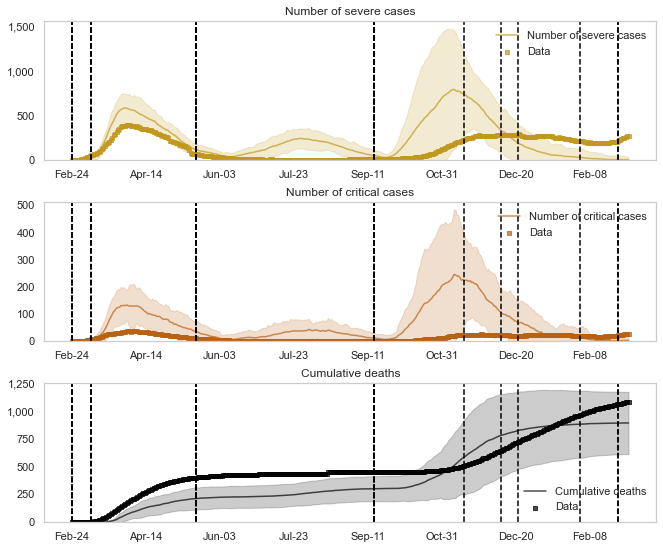

In [8]:
interventions = get_interventions(p=best_pars)

sim = cv.Sim(pars=default_params, interventions=interventions, datafile=df)
msim = cv.MultiSim(sim)
msim.run(n_runs=30)

msim.mean()
msim.plot(cols);

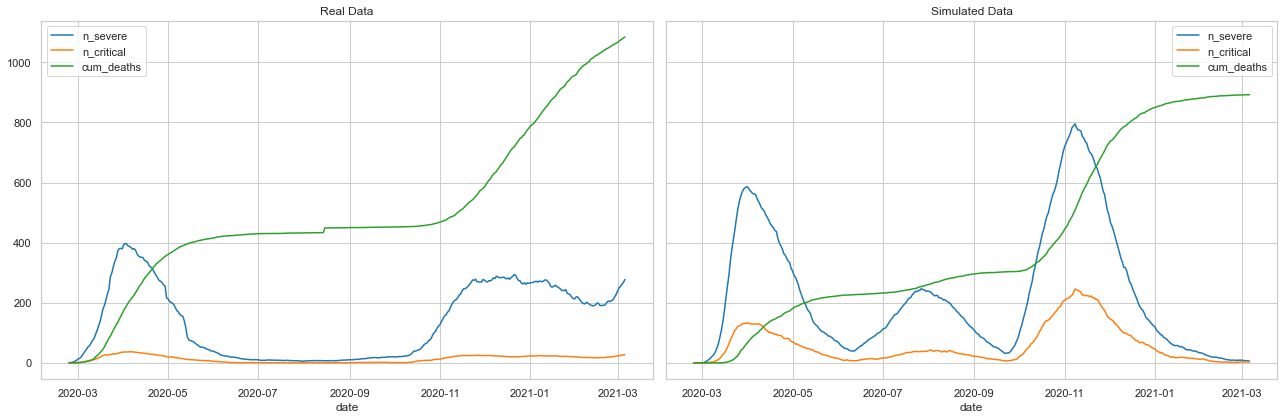

In [9]:
_, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

for col in cols:
    sns.lineplot(data=df, x='date', y=col, label=col, ax=axes[0]).set(title='Real Data', ylabel='')
    sns.lineplot(data=msim.results, x='date', y=col, label=col, ax=axes[1]).set(title='Simulated Data', ylabel='')

plt.tight_layout()